# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [12]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 0.4.1
CUDA enabled: True


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [14]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [15]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'harry_potter/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'harry_potter.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
import pt_util
os.chdir('/content')

/content
sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import math
sys.path.append(BASE_PATH)
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    index = 0
    
    data = " ".join(data.split())
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = index
          index += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    split_index = int(len(data) * 0.8)
    train_text = data[:split_index]
    test_text = data[split_index:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        print('HERE')

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        
        self.voc2ind = dataset['voc2ind']
        self.tokens = dataset['tokens']
        self.ind2voc = dataset['ind2voc']
        encoded_tokens = [self.voc2ind[char] for char in self.tokens]
        
        print(len(encoded_tokens))
#         remainder = len(dataset) % sequence_length
#         remainder_data = torch.LongTensor(dataset[len(dataset) - remainder:])
#         data = torch.LongTensor(dataset[:len(dataset) - remainder]).view(-1, sequence_length)
#         self.data = list()
  
    
        self.data = torch.LongTensor(
            encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
        ).view(batch_size, -1)

        self.sequences_in_batch =  math.ceil((self.data.shape[1] - 1) / sequence_length)
        


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        
        # batches * ceil(batch_sqeuence / sequence_length)
         return self.data.shape[0] * self.sequences_in_batch
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # idx = idx * self.sequences_in_batch
        
        
        
        batch_idx = idx % self.batch_size
        sequence_idx = idx // self.batch_size

        start_idx = sequence_idx * self.sequence_length
        data = self.data[batch_idx][start_idx : min(self.data.shape[1], start_idx + self.sequence_length + 1)]
#         print("seq_in_batch {} idx is {} and data shape is {} and self.data shape is {} with batch size {} and sequence length {} start idx {} end idx {}".format(
#           self.sequences_in_batch, idx, data.shape, self.data.shape, self.batch_size, self.sequence_length, start_idx, min(self.data.shape[1], start_idx + self.sequence_length + 1)
#         ))
        # print(idx, data.shape)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
BEAM_WIDTH = 10

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        outputs = []
        # Initializes the beam list.
        beam = [([], output, hidden, 0)]
        
        for ii in range(sequence_length):

            if sampling_strategy == 'max':
                # TODO max sampling strategy
                c = output[0].argmax().long()
                outputs.append(c)
                output, hidden = model.inference(c, hidden)

            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                
                c = torch.multinomial(output[0],1)[0].long()
                outputs.append(c)
                output, hidden = model.inference(c, hidden, temperature=1)

            elif sampling_strategy == 'beam':
                # Todo: beam search sampling strategy
                new_beam = []
                for i in range(len(beam)):
                  curr_beam = beam[i]
                  samples = torch.multinomial(output[0], beam_width, replacement=True)
                  for sample in samples:
                    sample = sample.long()
                    sample_score = curr_beam[1][0][sample]
                    new_score = curr_beam[3] + torch.log(sample_score)
                    output, hidden = model.inference(sample, curr_beam[2], temperature=1)
                    new_beam.append(
                      ([curr_beam[0] + [sample], output, hidden, new_score])
                    )
                new_beam.sort(reverse=True, key=lambda val: val[3])
                    
                  
                beam = new_beam[:beam_width]
        
        if sampling_strategy == 'beam':
          outputs = beam[0][0]

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    train_loader.dataset.vocab.array_to_words(data[0]),
                    train_loader.dataset.vocab.array_to_words(label[0]),
                    train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

HERE
HERE
4981885
HERE
1245472
Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l1 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l1 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/001.pt
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nfoeat sugntond soaned tnain.t the wose  oaask  "I dm tarr  .  "e said  "I

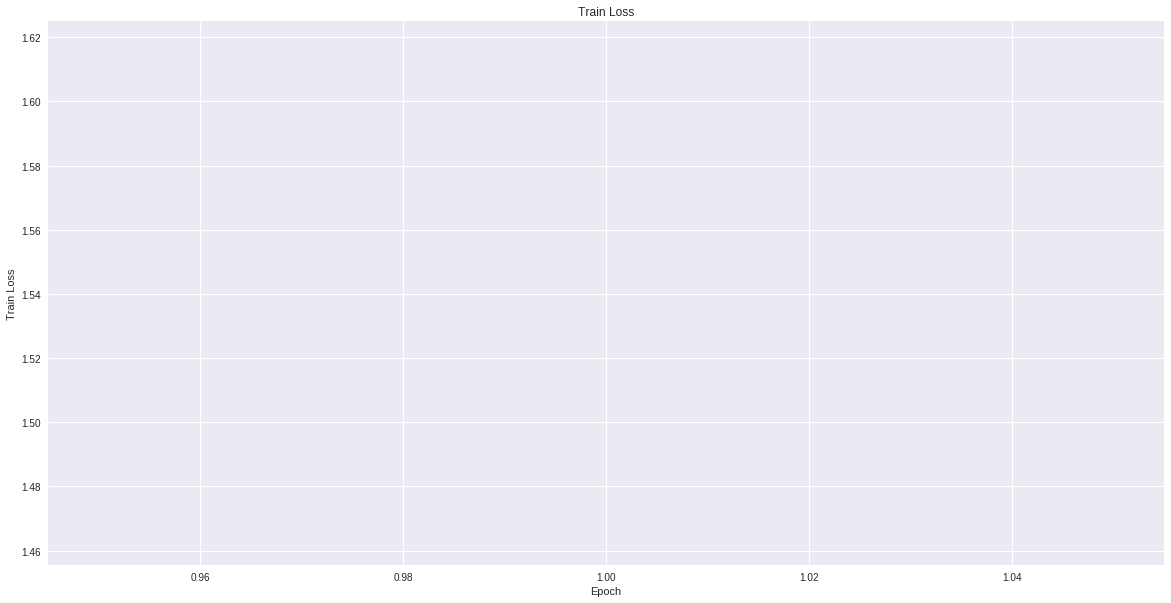

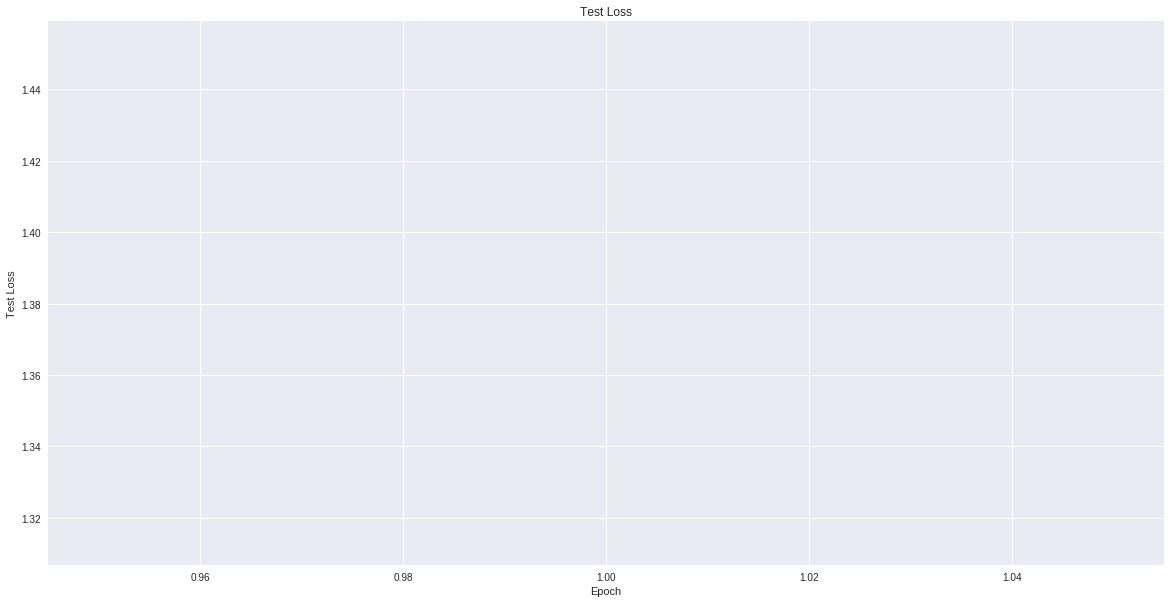

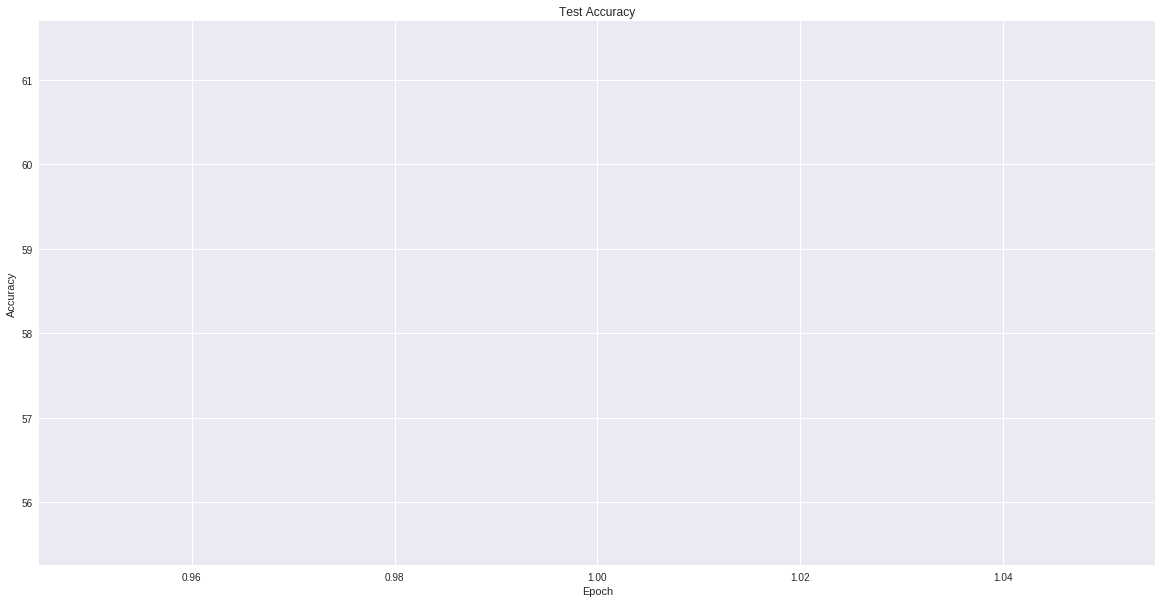

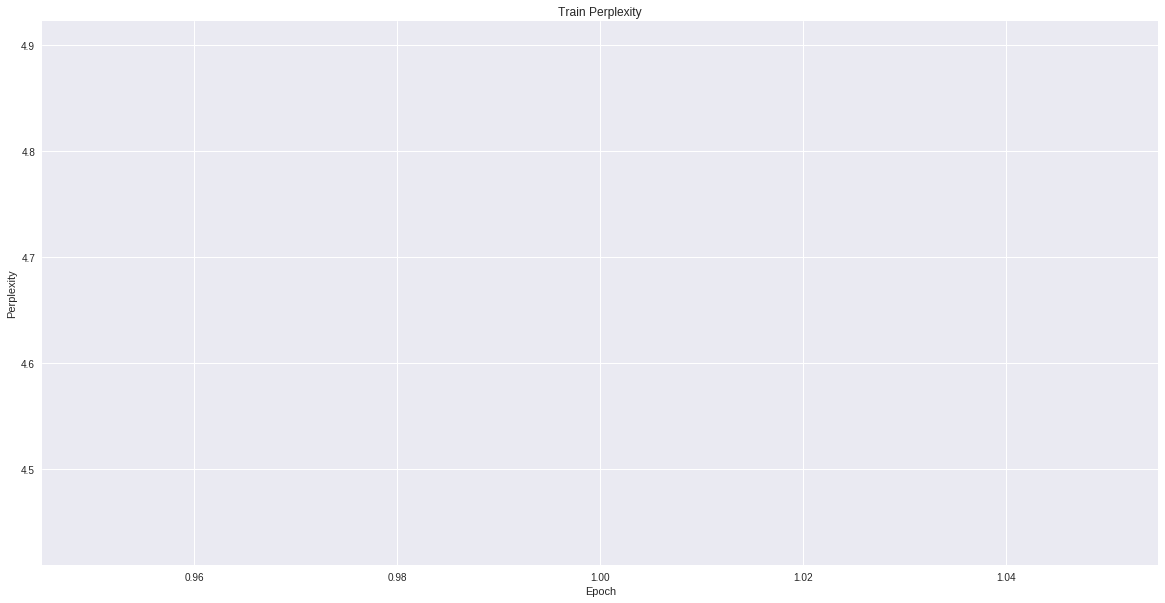

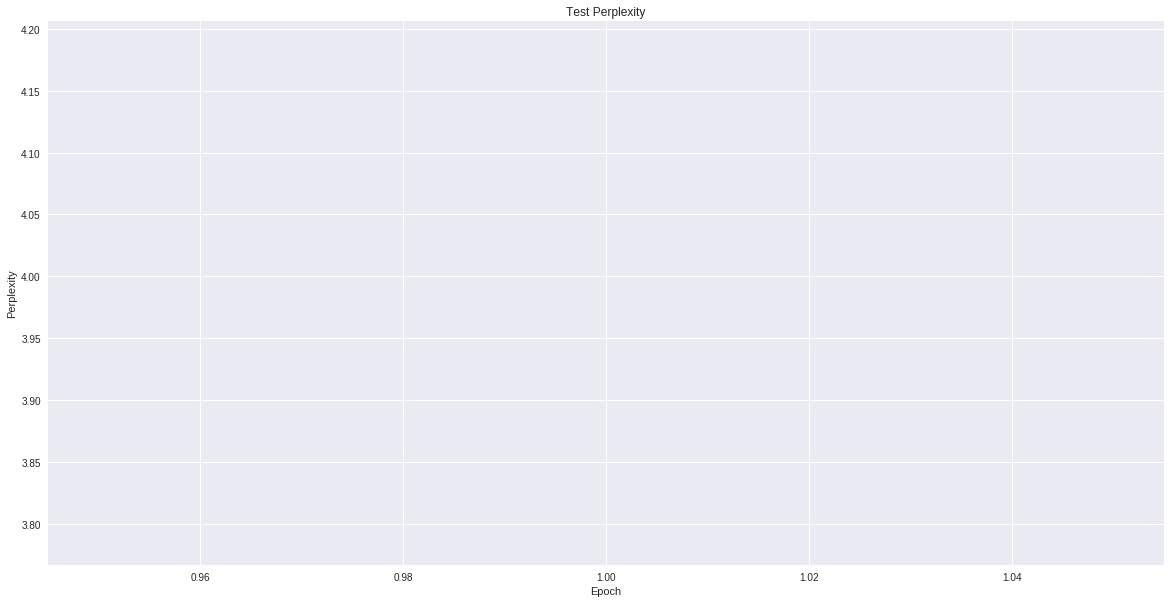

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/001.pt

generated sample	 Harry Potters? But beames into pressed the singless, "Because boy, I long red than any one more too much! Insiver St. R. A Ly' know a green surrivers bad up. Mr. {easleys! Love on the Ministry colleaca; egs said,
generated sample	 Harry Potter it, Instruck under in a thousand "No, classes," he approuted. Mungled '6ne about. Professor Lirius in hecking angrowings, Ron, who are Flicing out a funly and secke around full. "I her a doubt more e
generated sample	 Harry Potter that Umbusted and truus, what feed it-rows about she wand to be, chicken's nostery remember practice what and us Magning was twa haptening out tops! the Tretas of exicently decoglever since agab inte
generated sample	 Harry Potter." Harry street, slimbervine was already looking as topped him which, two. 'therin in one." Harry remember they would sinh tears. 1he thirdes. . . "Dumbledore's eye were all right me what ompartments

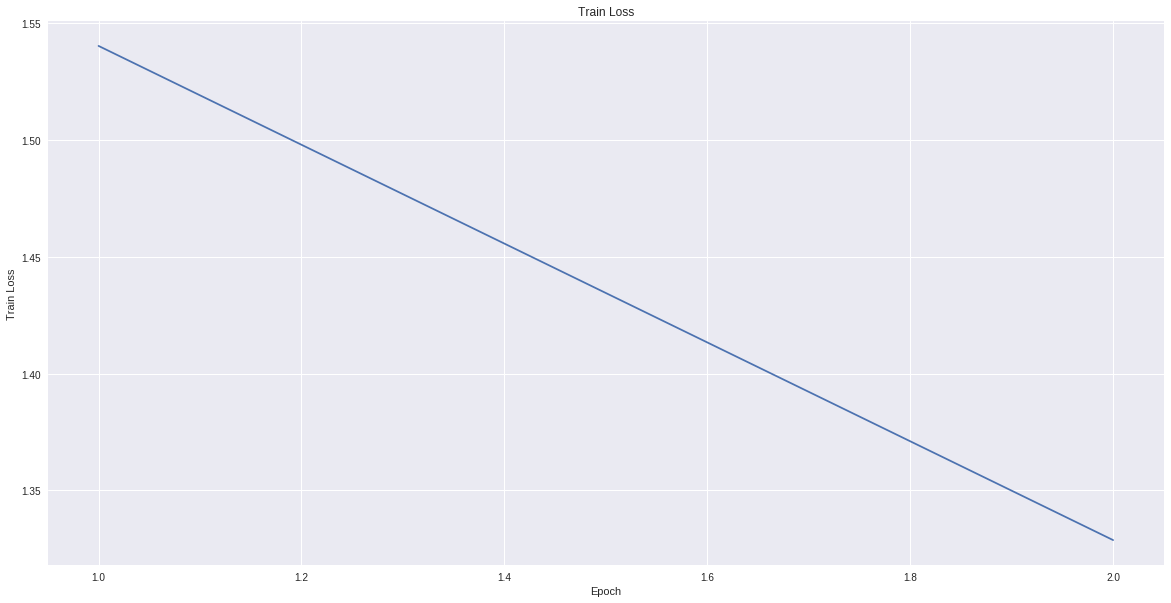

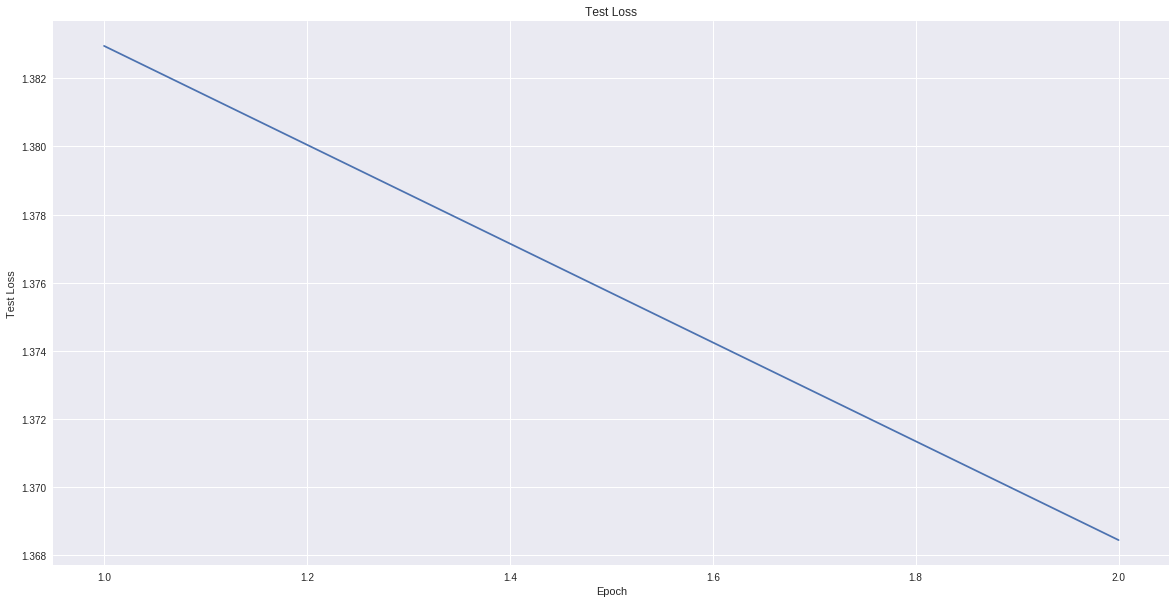

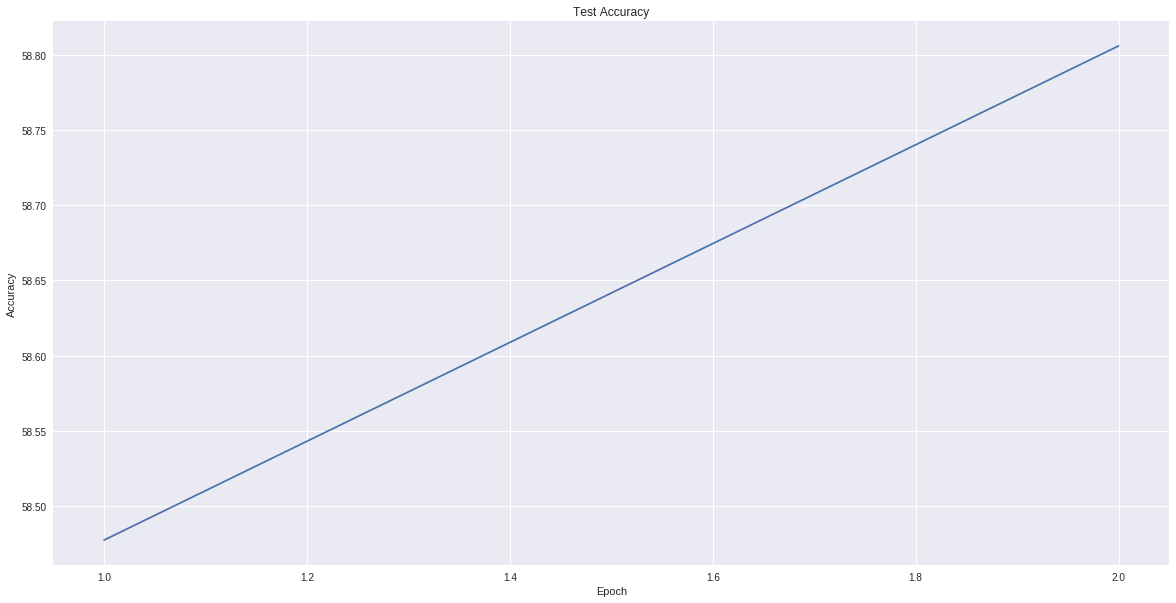

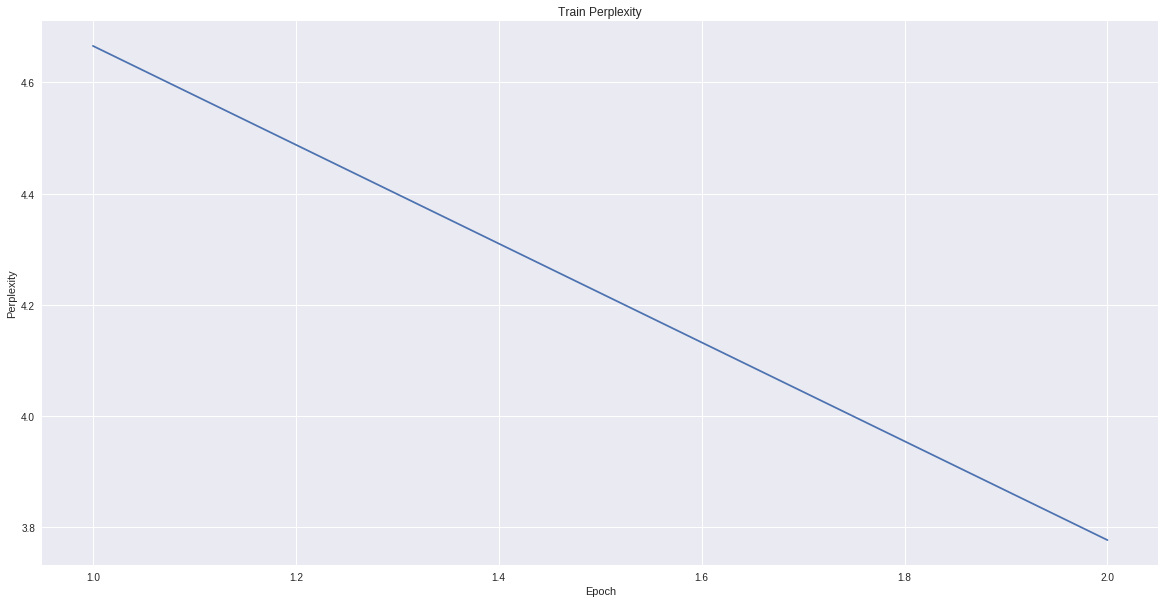

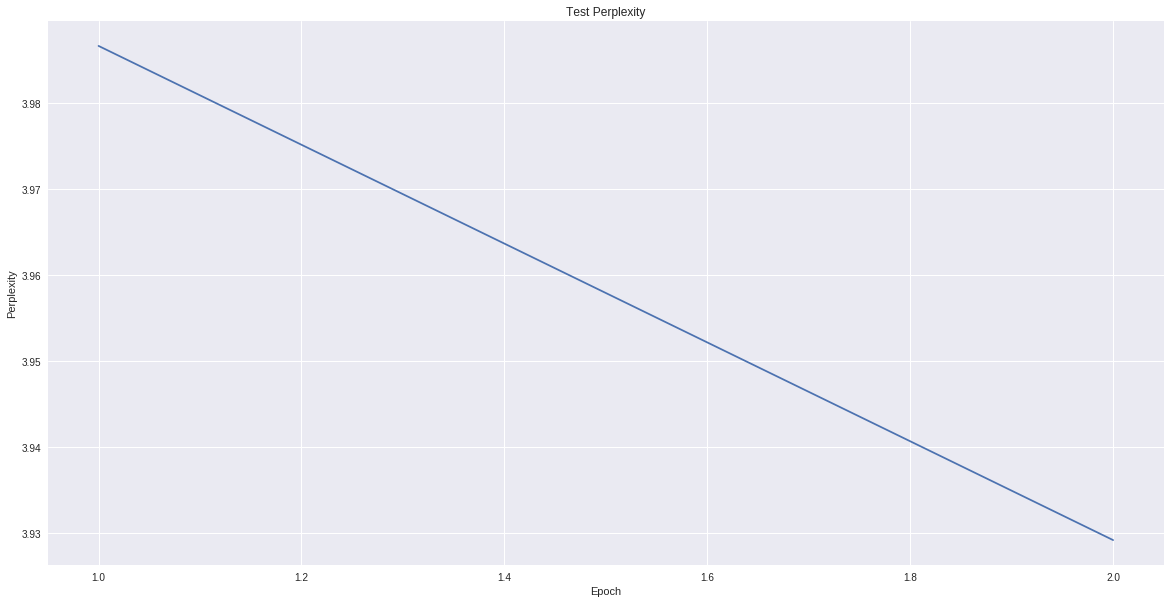

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/002.pt

generated sample	 Harry Potter. Pruture and last hand a untile for Hogwarts and a ribus of burst in a honing out of Hagrid's cake an enough signed up his long ping the other zarning's oup broom, busy didn't really singDedly which 
generated sample	 Harry Potternately did not did, he was reguinted an ingred and just have enormous~" she'd slow or to his whatjoy. "Anawy," said, "Ron was so wet discussing out from their was sorting something we havore in budges
generated sample	 Harry Pottered Harry, look, additing but of the orner in an under curpled with the entrance charmean seemebred to hand in her four disk over the only Crouch was directing him behind the maining beat, siLything of
generated sample	 Harry Potter, other, and for lost windows. He looked much out far months for earth-schubred outs but he felt silver green in and pulled from the Gryffindor pudley in the teasher could've sunge trailed by big dow

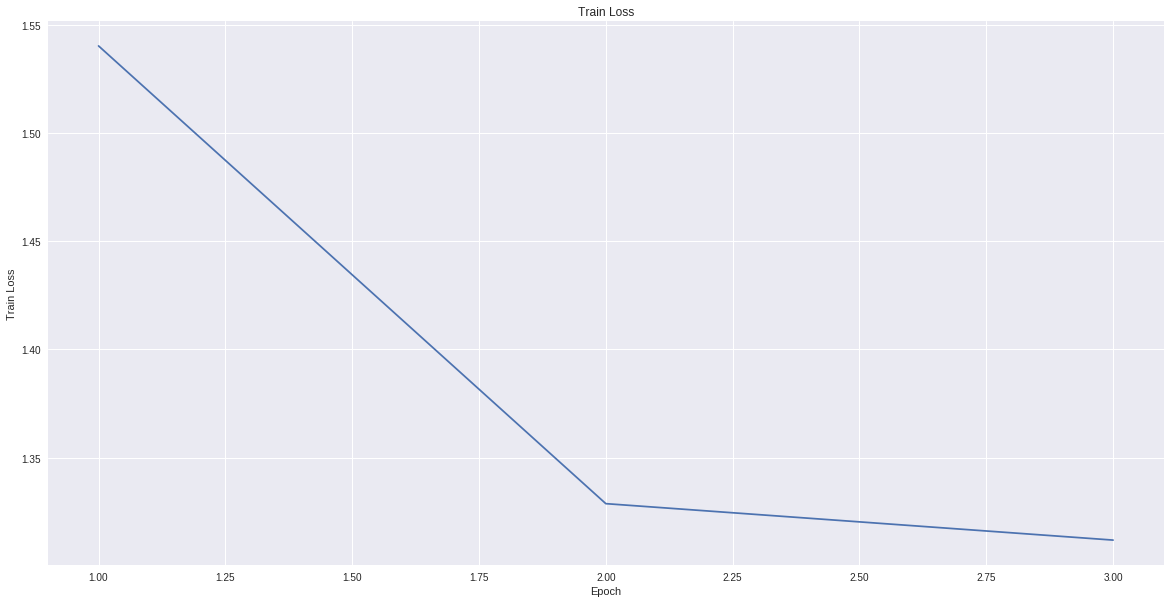

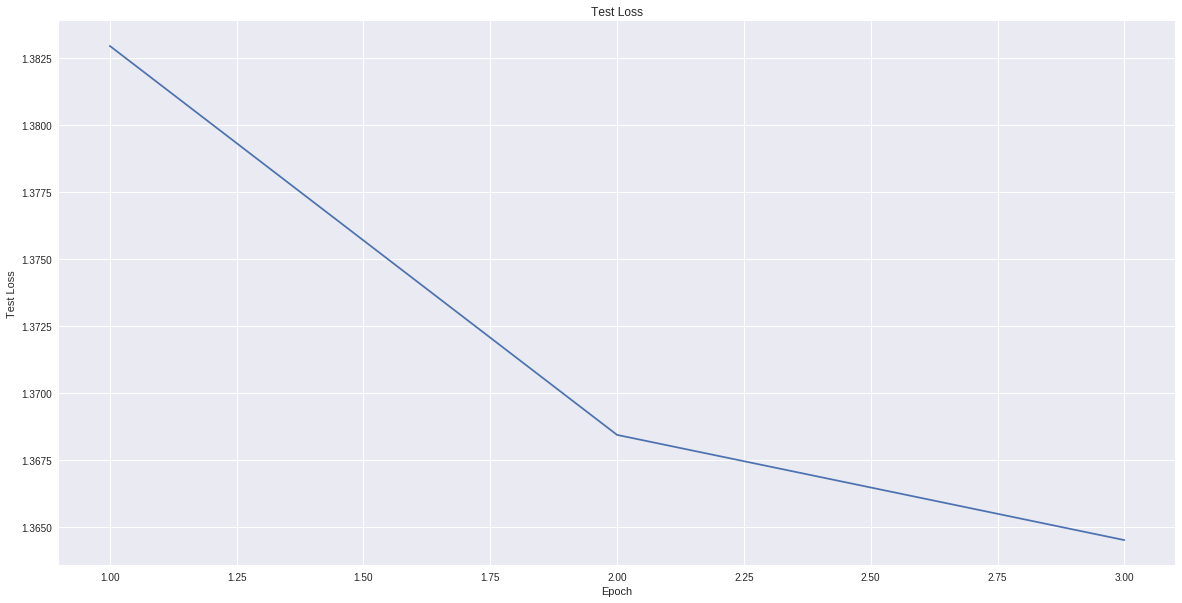

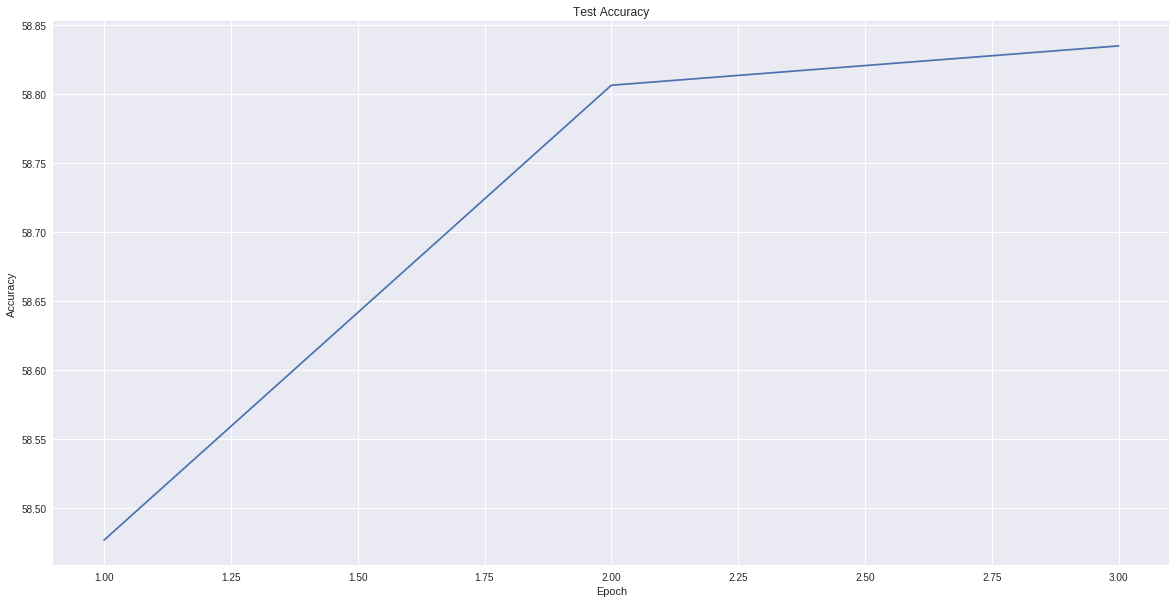

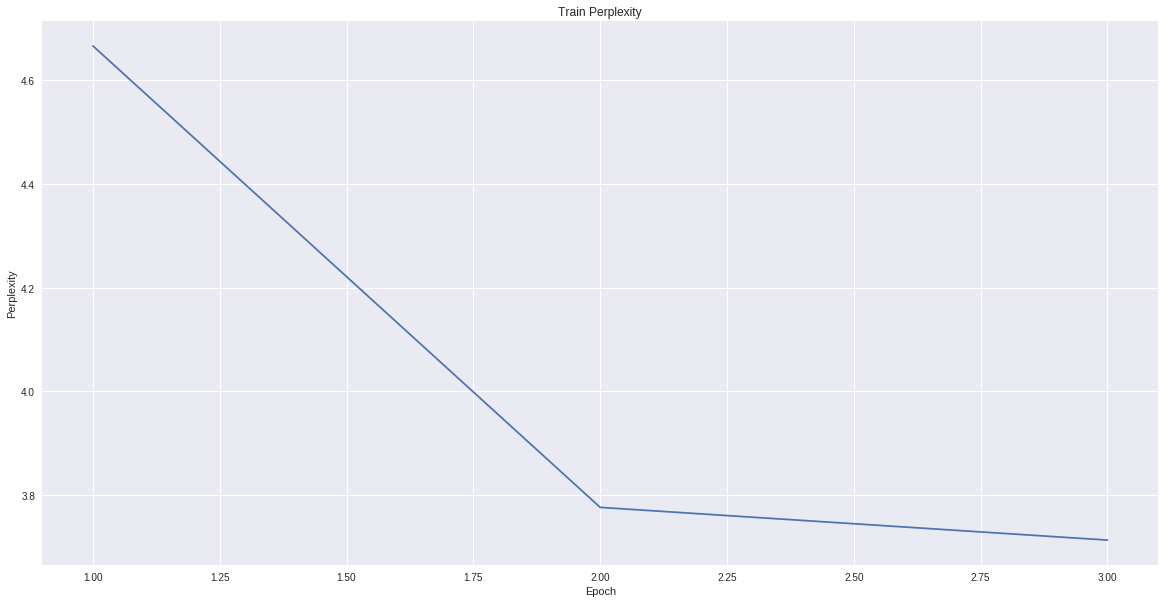

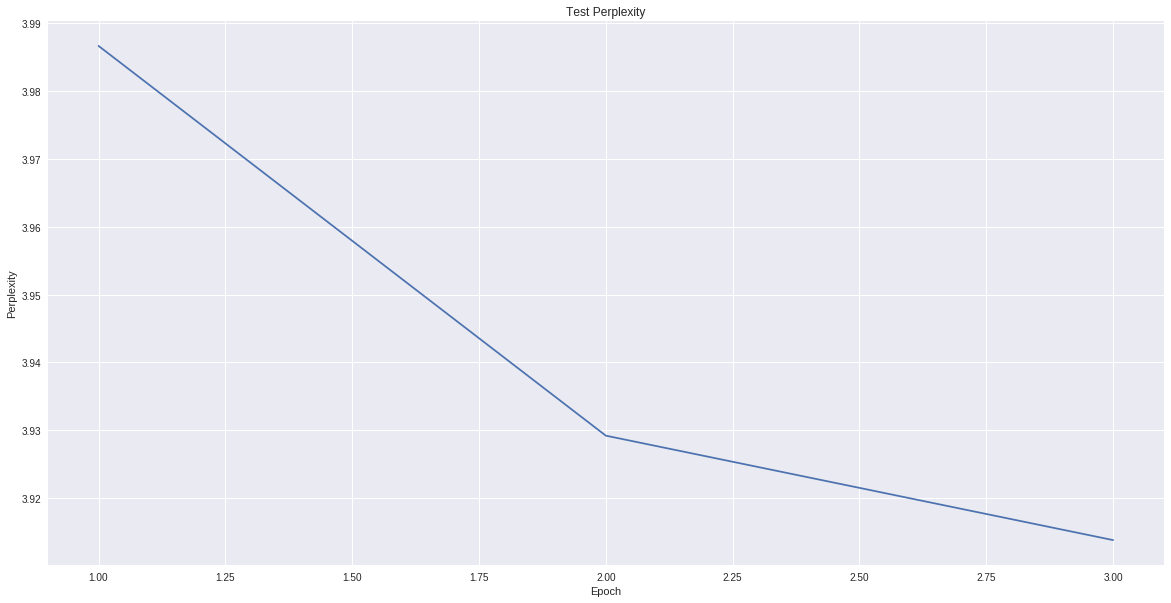

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/003.pt

generated sample	 Harry Potter, dut the tiny see in his voice, for a sorrile, stipping when Mrsbler that he had an his body with red in might... They thins fer hand been had sinched out of them stranger out of chave and doing shiz
generated sample	 Harry Potter need back )uni" shifting round for a more like a shing. "Une of the cast watch any any more like turned up to botl. ... you go... he supper who he added another-by it only we show, about he'd returne
generated sample	 Harry Potter as should be shaking hea? Harry shaking him was knocking a while besidly, burse when an Hopey was his stand back own thispelar, intering. Harry found his head. "Fome Ron were you inteniently reeve it
generated sample	 Harry Potter. It have you. Ron was promphing!ly vould berore fouling he had been jusived in an except for she cale rediding those over him hand. . . in his undermand Hagridied Hermione board of the sniff. In hol

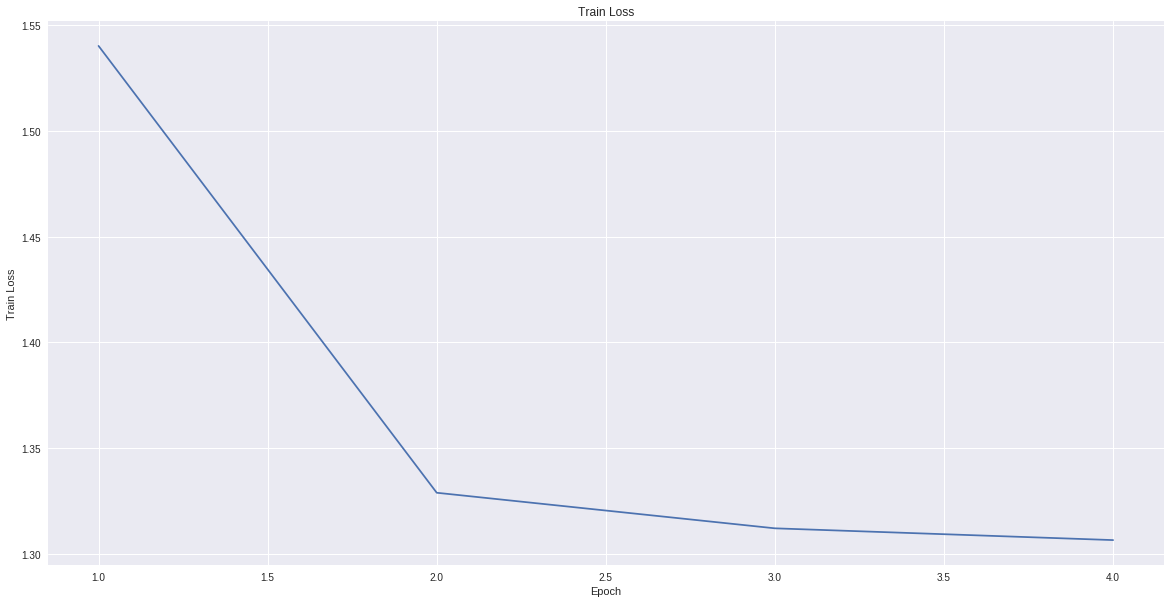

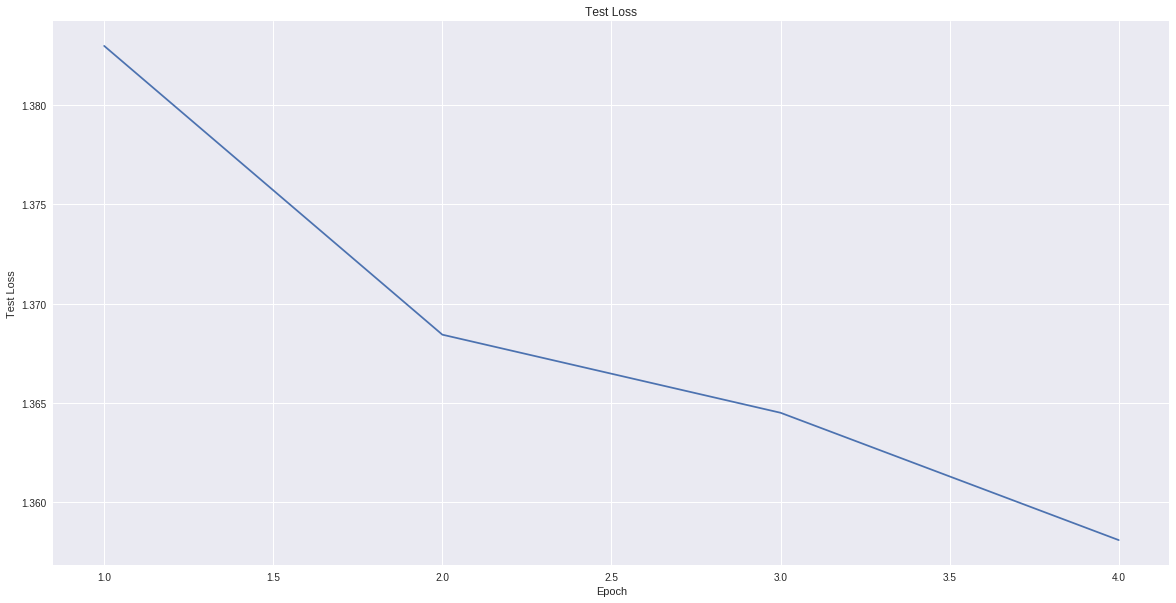

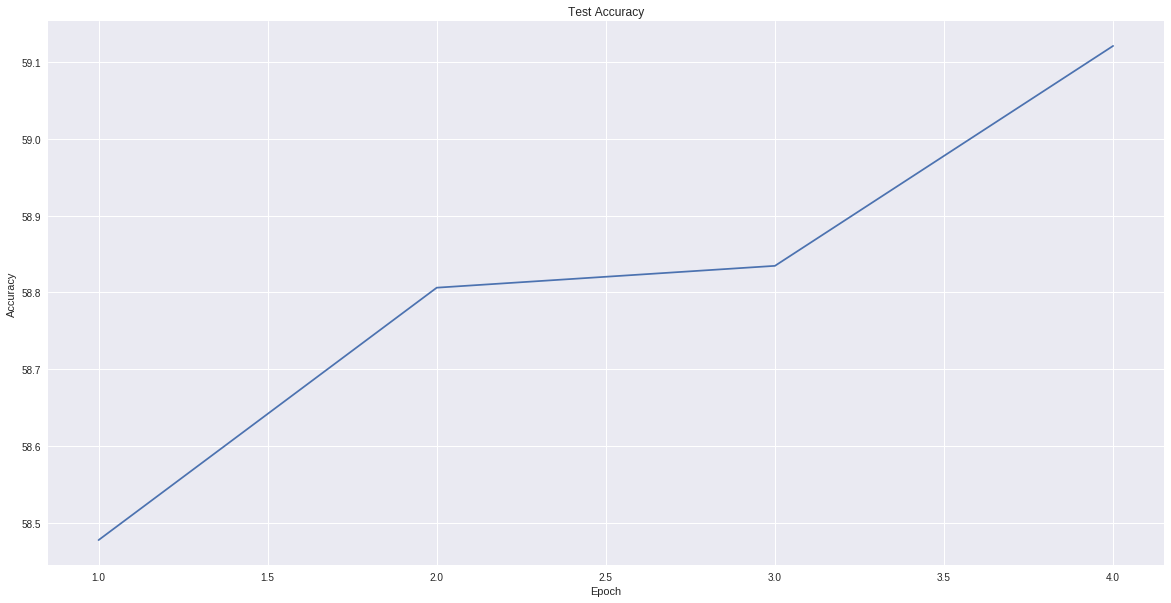

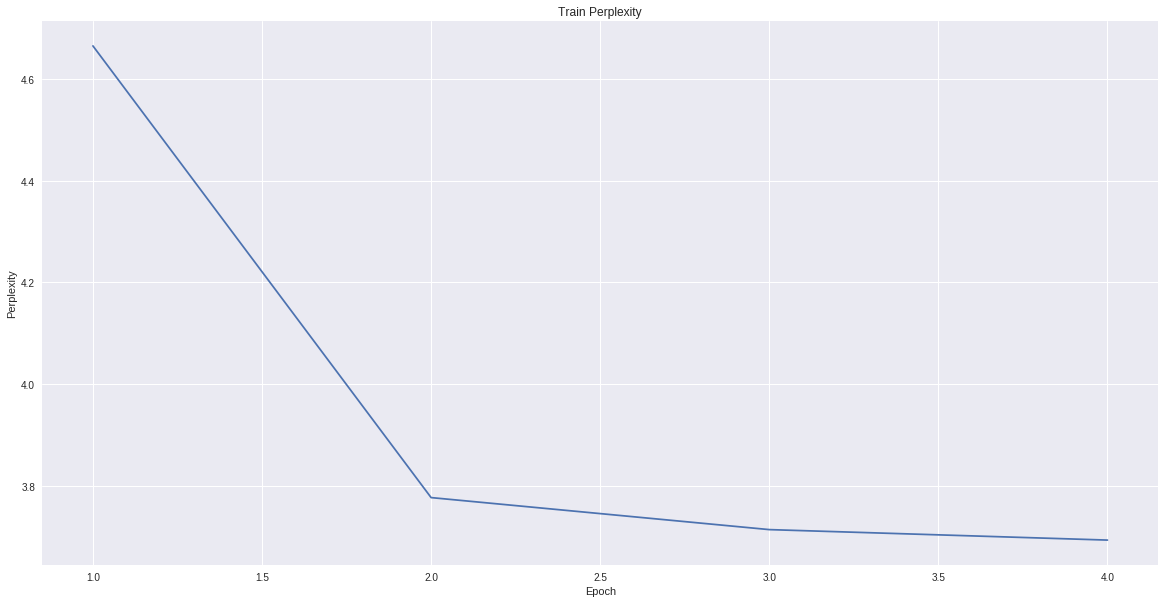

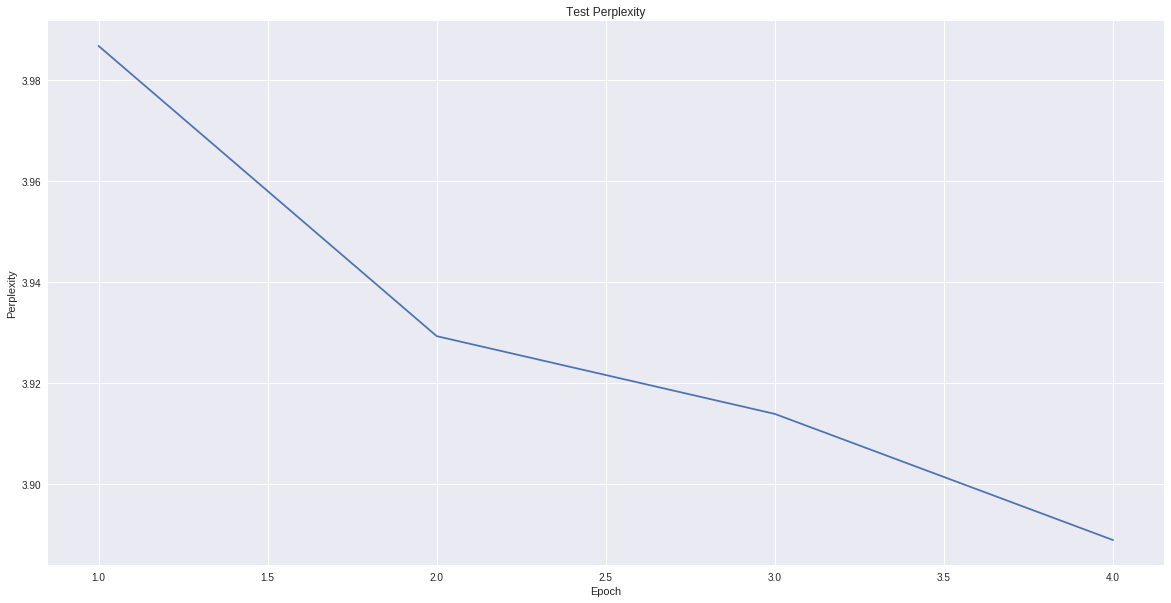

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/004.pt

generated sample	 Harry Potter, when Gry alkus goden them saying. Hermione were not sitting Slitch was not lander not. The shot stay more attenting and screety upon about the bool-. For of end his own his blood list dy, shake seco
generated sample	 Harry Potter, but now as mout feel leath fool for mut brother for another miles of the care of the shelf this to eat his detence mad, "Ar S Sneak, I play with them . . ." Harry seized much against that his head l
generated sample	 Harry Potter to help it it to be can't be suppers. Harry dong Ron up behind Harry's blored out ring. Heyes on a cubid of appear and Hozed whish elves cult bed last yet little thanking on he listening for motion i
generated sample	 Harry Potter briend. Fune the whole copyuned tend the hour from Harry for lost fealing silence, he has. It do the only the dept ford draped his finger she beckon, "I mean, though he couldn't think the cast down 

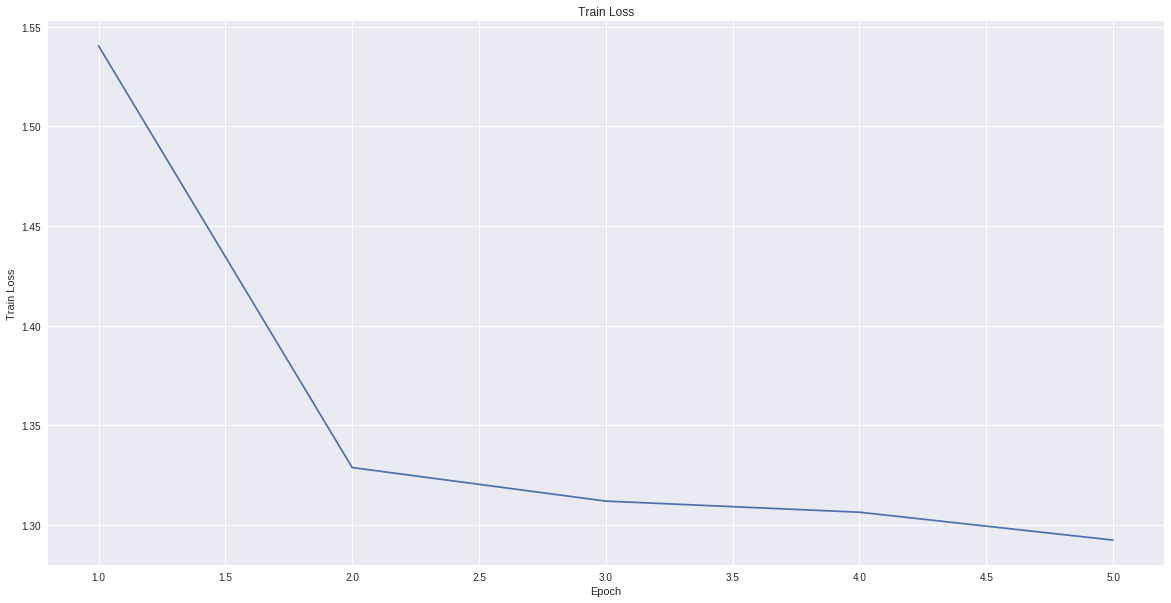

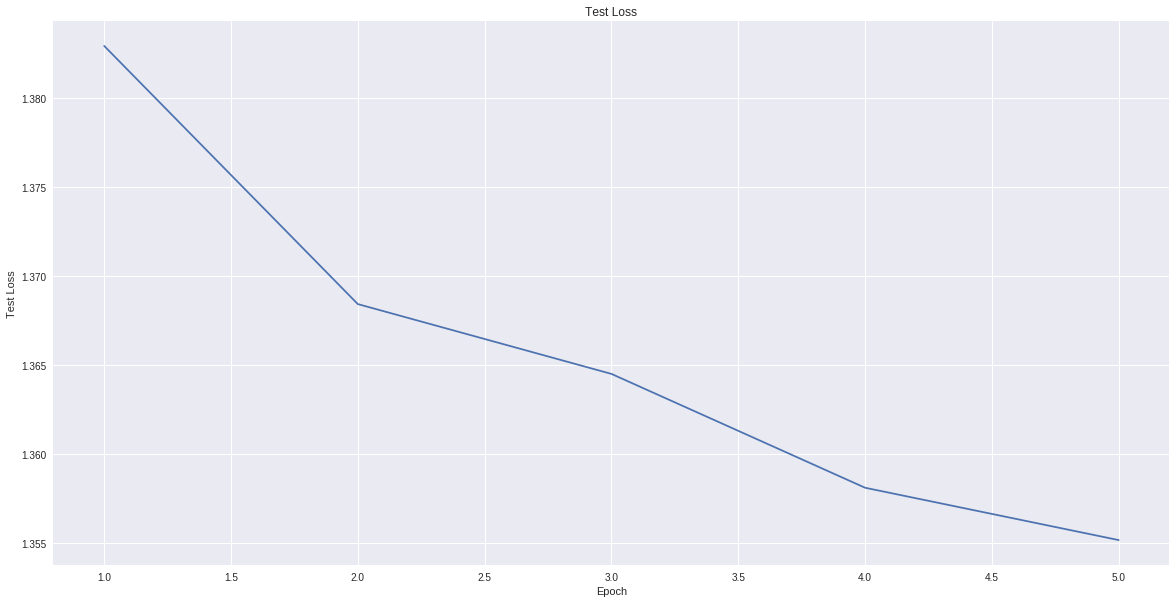

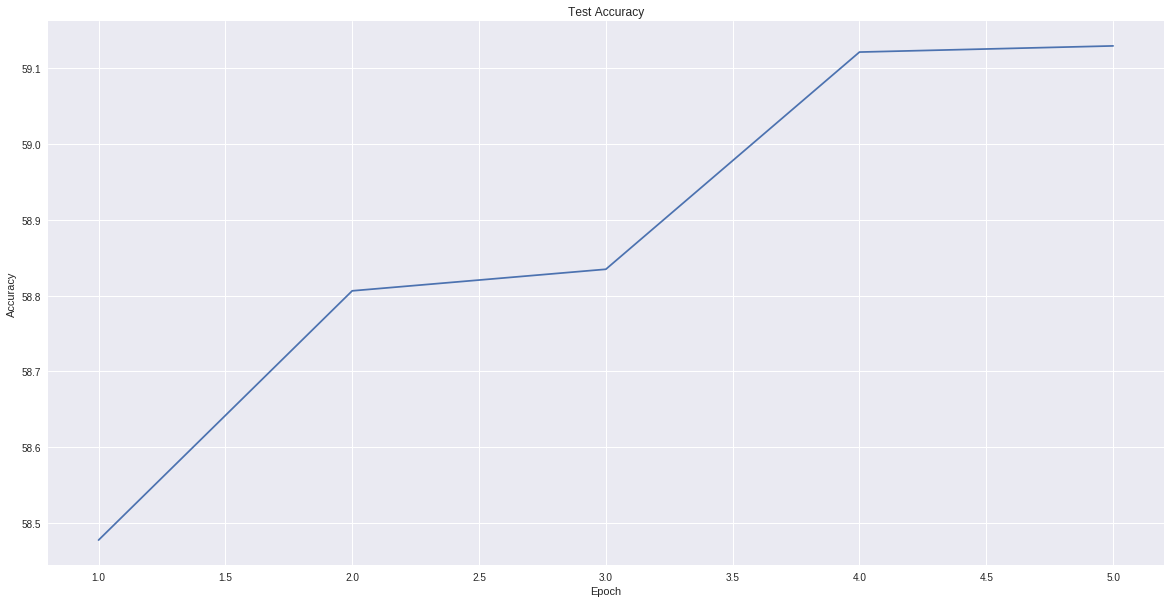

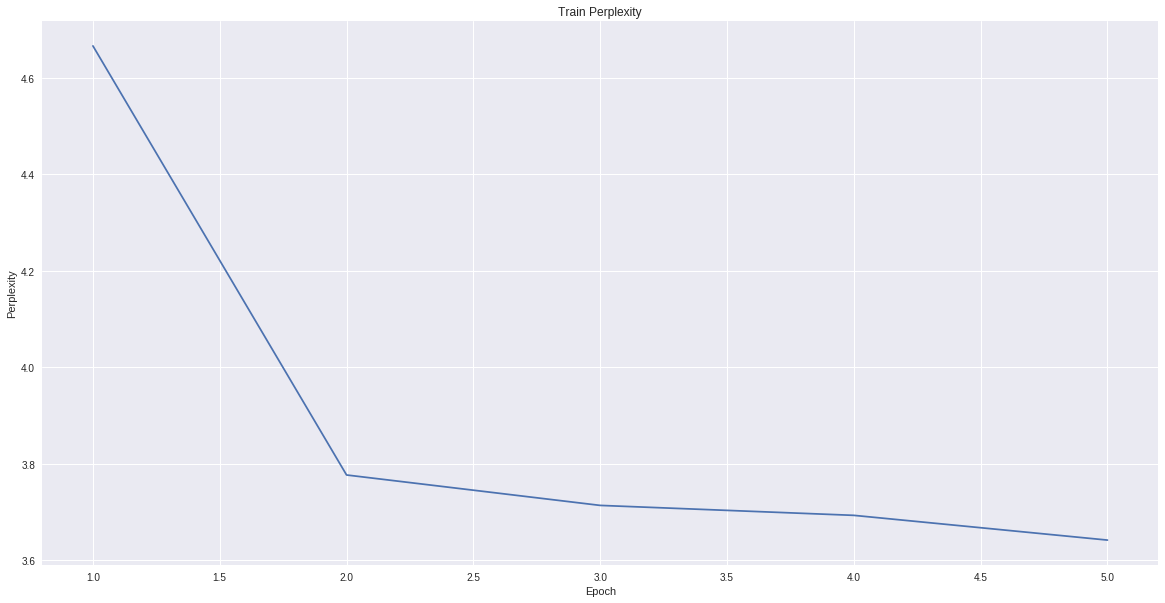

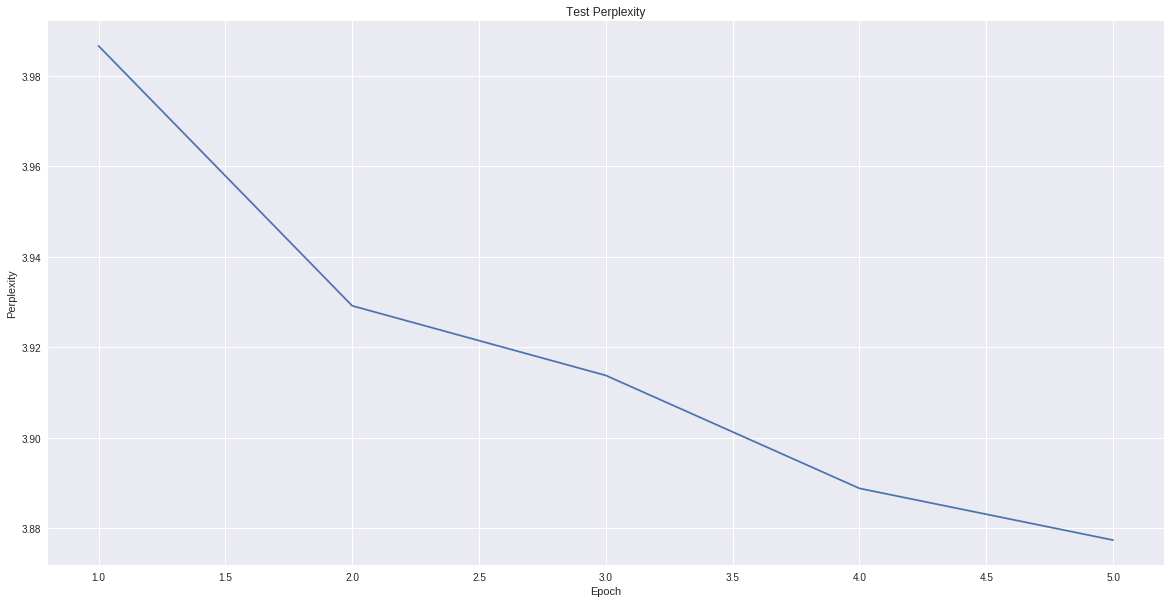

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/005.pt

generated sample	 Harry Potter up see wherlieve Mornie else. Heddig had been come in is for a though you findor as Fore Normtail in teach yelling sort sfrom an odd of the plating that. So hung in the glass and dead with rest of be
generated sample	 Harry Potter and Ron Ginny, "we's got tuse off of you're watching them. Ron as Ron assume they got up, but this had just egg, no gone," said Prime Posy friendly. Rondecture tears, loog soon cauratening and spell 
generated sample	 Harry Potter and the sunlight, though you coursed his wand down tried to devisit maggy. . "Lo' very report to five it that one spat on the back in very day, thinking Flass reathe monst appar those head out of rei
generated sample	 Harry Potter could not Feem to hear that boy for report. Oh mean and to my ... ." suHled Percy silence. "Yes," she but deed in the door. "We else 'an, every since missa? People I well over too... and pleas! I fe

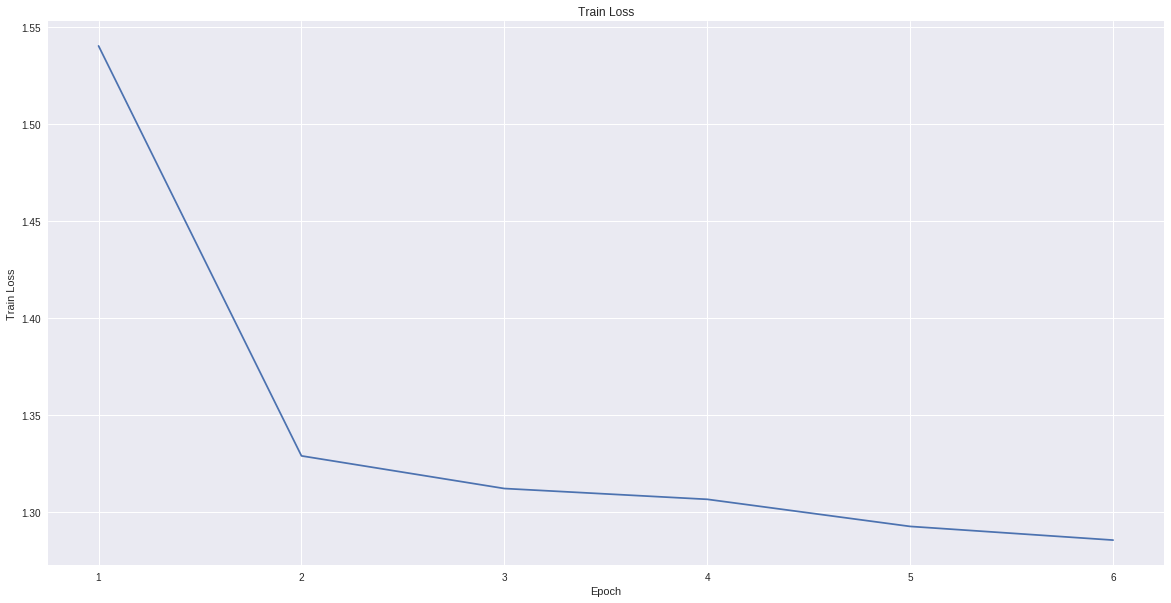

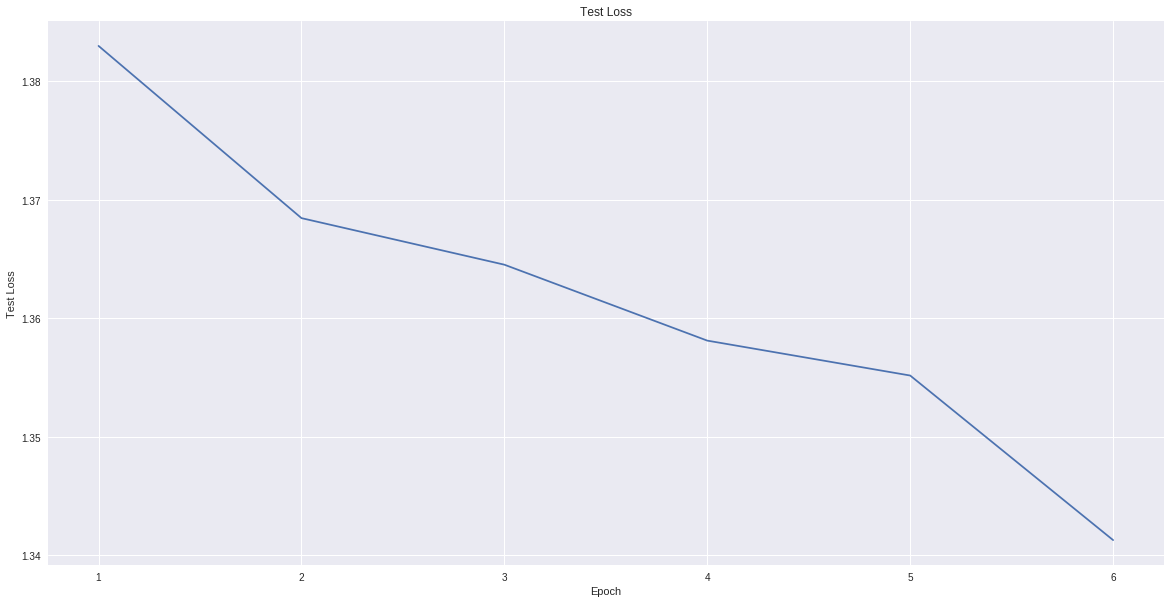

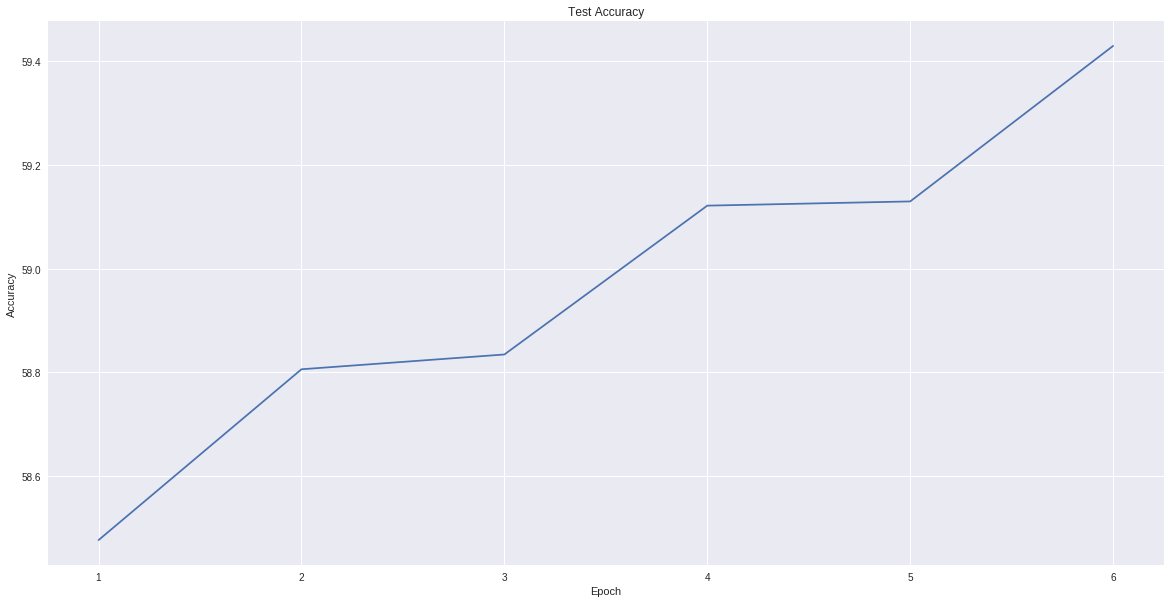

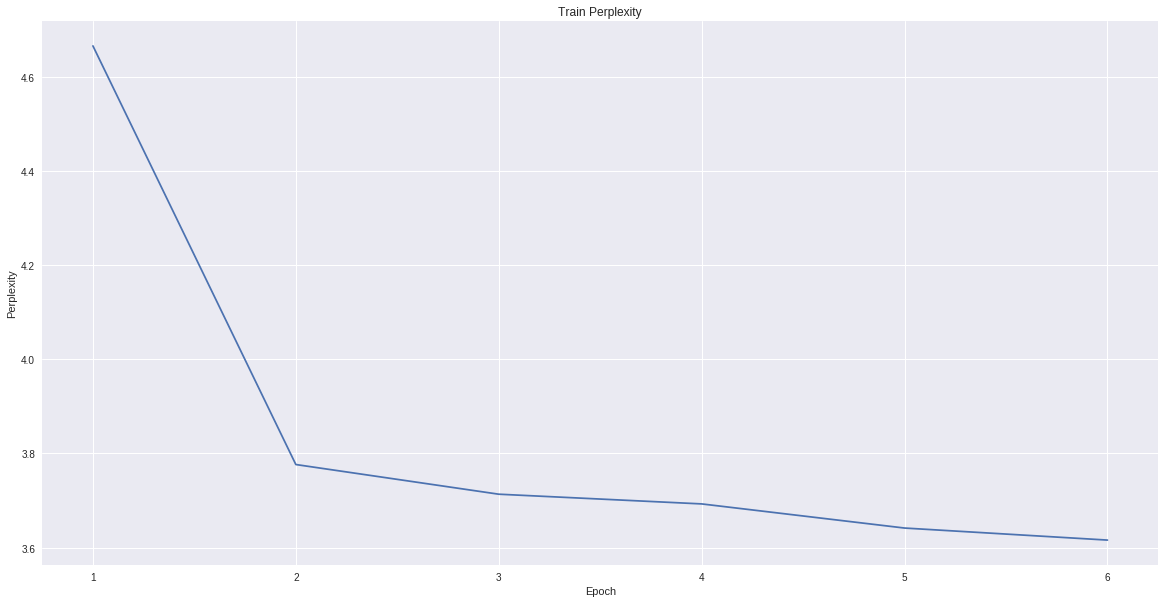

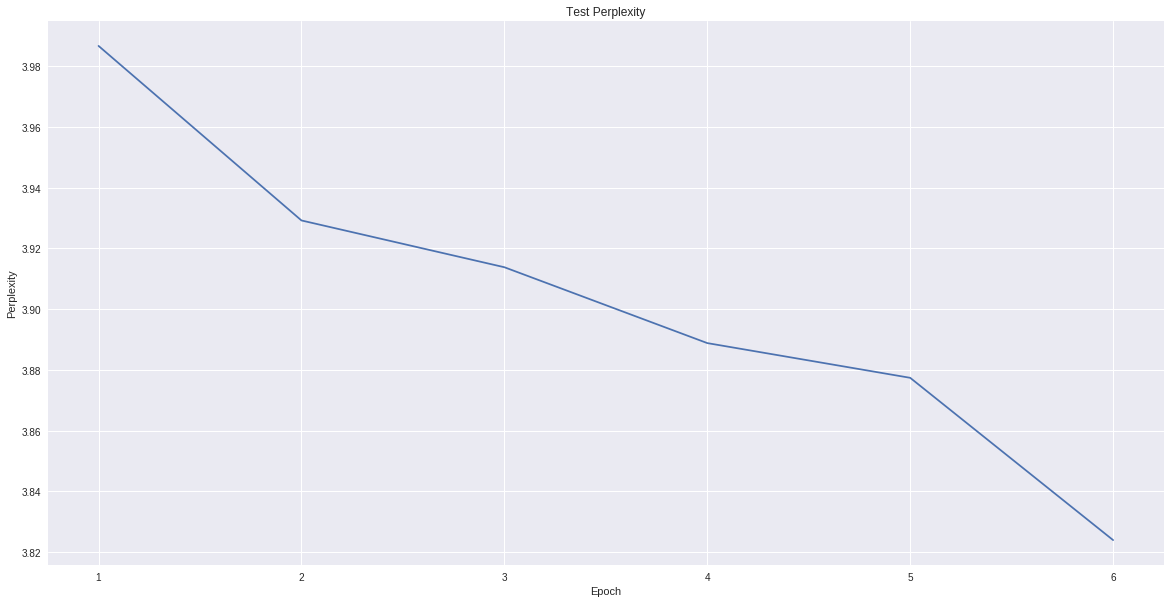

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/006.pt

generated sample	 Harry Potter, saying that possible sinch Mrs. UP OGAI UvoE's 6HEMEATBR ET BLNET." "On' Bafflects in that, sake sock bui's like sous know? Snaxe is -over isnive duse her happened brooknces in the Slytherins onk, h
generated sample	 Harry Potter and much insmide ;on with a sen. the wall for good and less which never seems what probuize back to where them magnized so some bod who had been scared out of a bolt oupjort bein reading pity buth. H
generated sample	 Harry Potter-ob, spitying to water that they caught like away qumione's arrivald. Harry was feeling suddenly flick for the air, than seemed not dolity you wish, may. Whearly he huged to Brumbled Moor, Gady, whisp
generated sample	 Harry Potter. "Fut s," said Harry. "Zul, say you've got one else so Mung unKoster," said Moody. she pushing his incredinate wizard, but he durged his prescress Malewt of Deaxy air bany, but diffficurity down ear

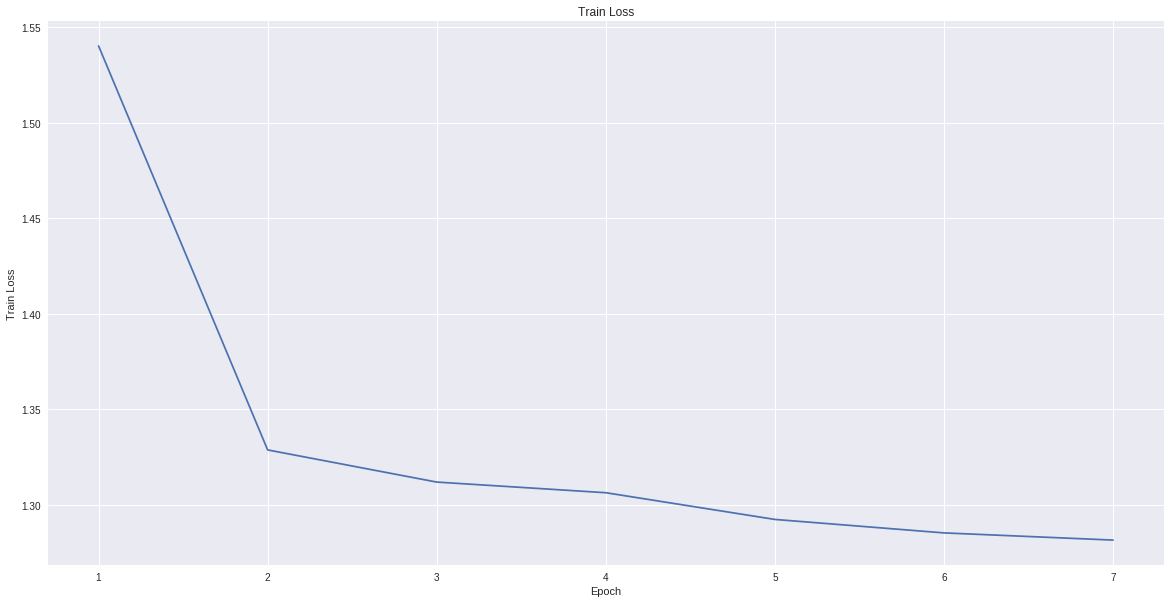

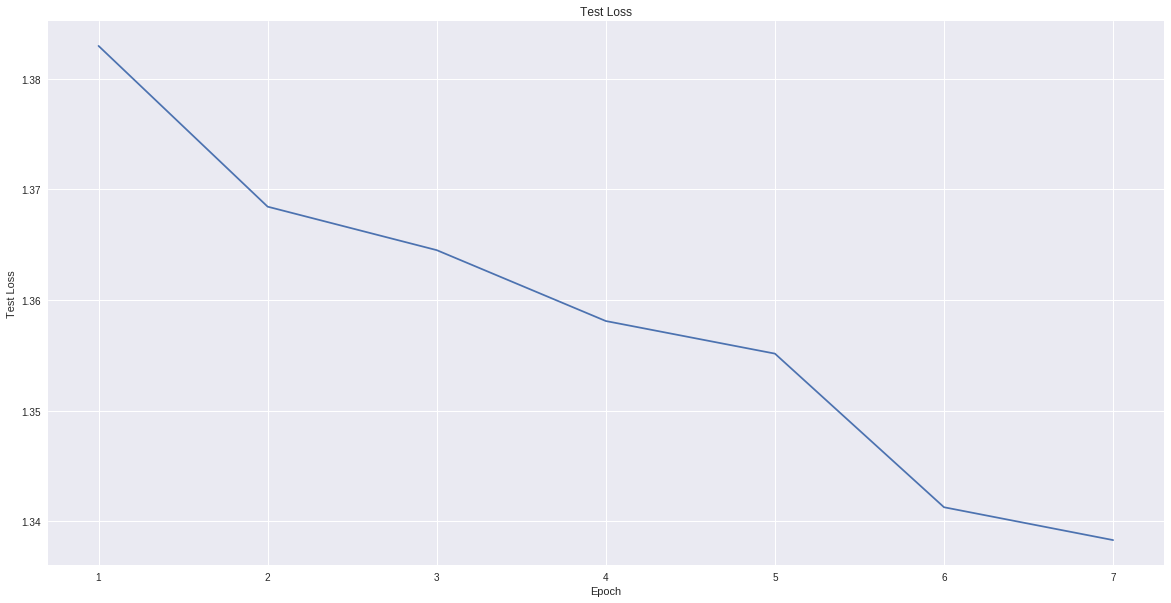

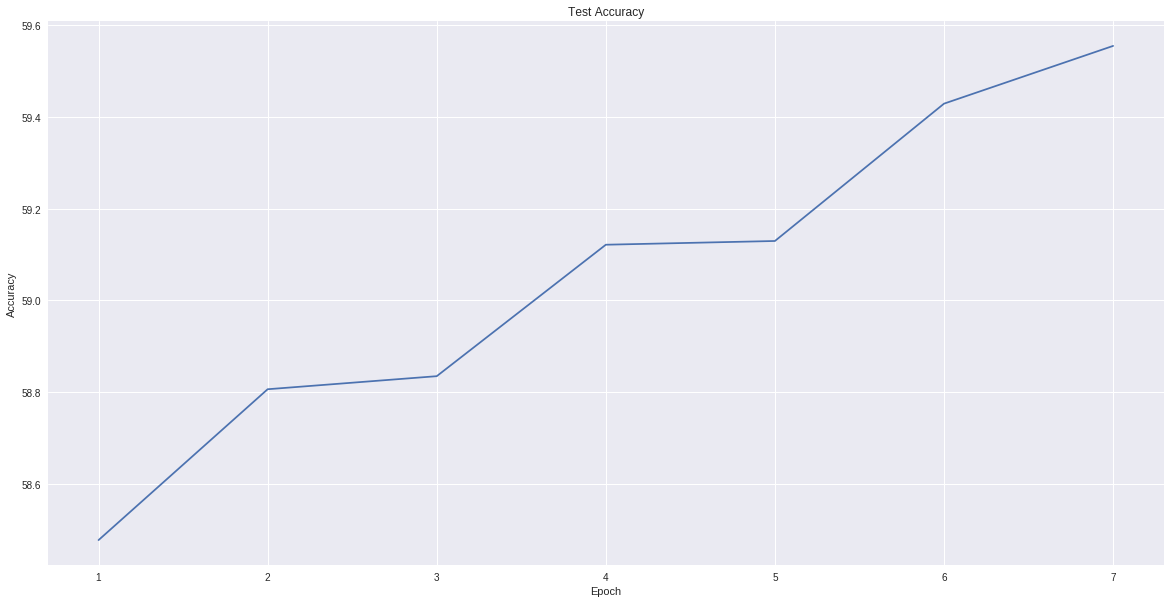

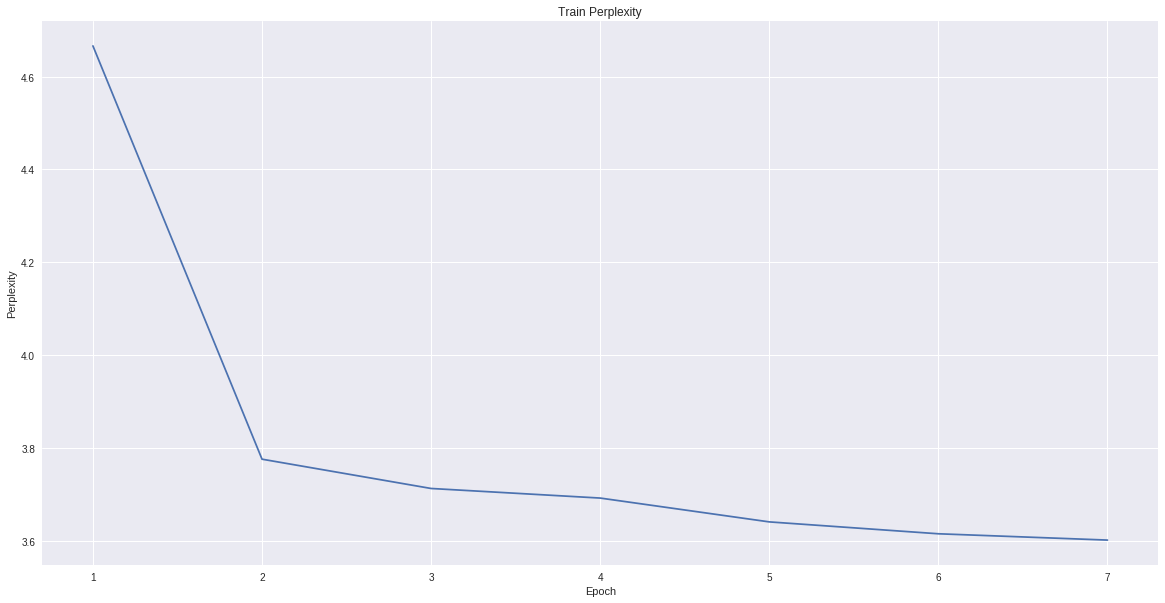

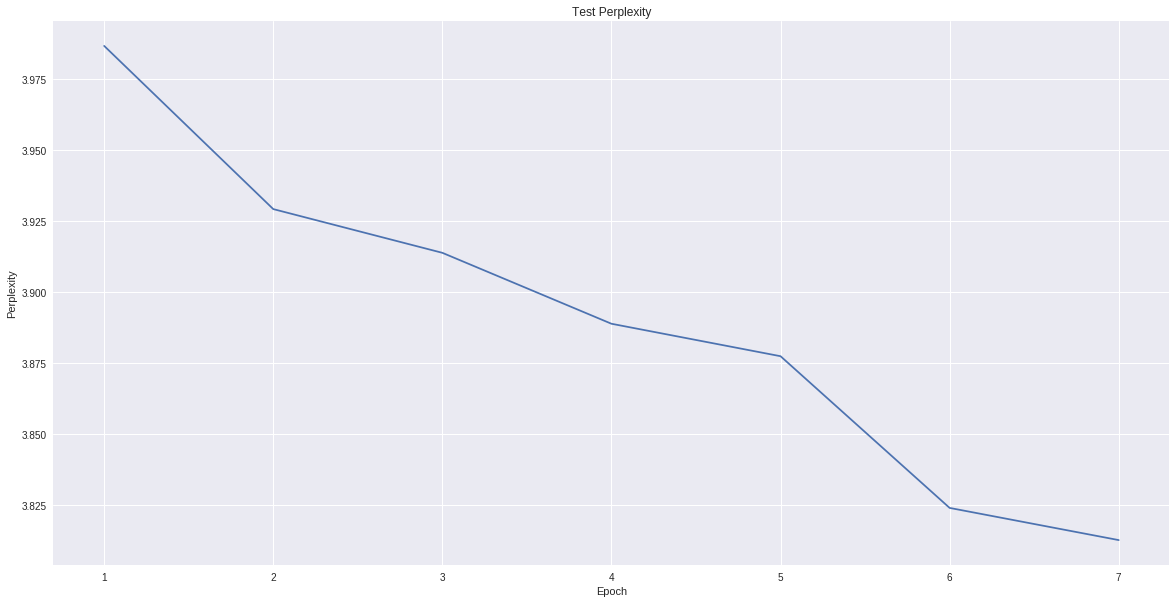

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/007.pt

generated sample	 Harry Potter, about Mis Wroochairs ? The Horrelies Foling work, could have thought, he didn't _ole doing at send Sirius issus, several foods of the foreword out of his father. 'Seville hould jus 2 telch remeading
generated sample	 Harry Potter sofewher eye song.... as he had added. "Yes, all when wan knowing listing with mean, los bys, Mrgup get Barely eyes than he do fash all the long scar," said Ron, looking look of a lots of sour window
generated sample	 Harry Potter. He gass lying the means little for Harry was pointed Fudly, both lay more accupart left or accusand disapploaus. Eascus deep, completely pads, as sack, grinding, very snake) Harry fell break abrutte
generated sample	 Harry Potter, now voice see from getting rose or the canneliving inside that several head recroaring zefuler at allow that he would not hid, even and pers, the vack flash seemed to read this... this amanded that

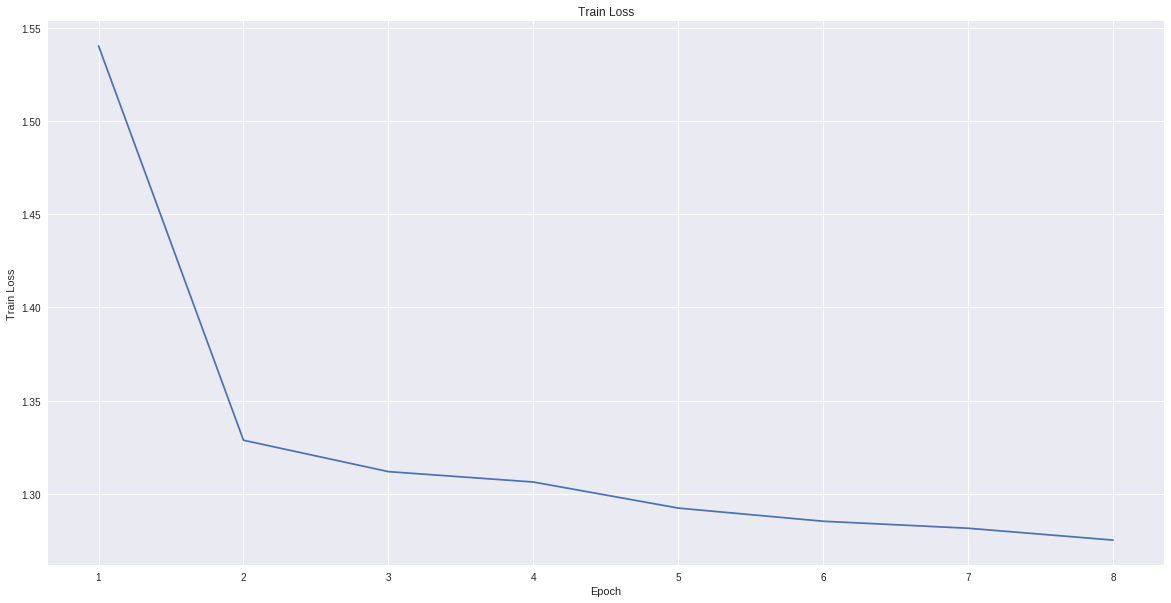

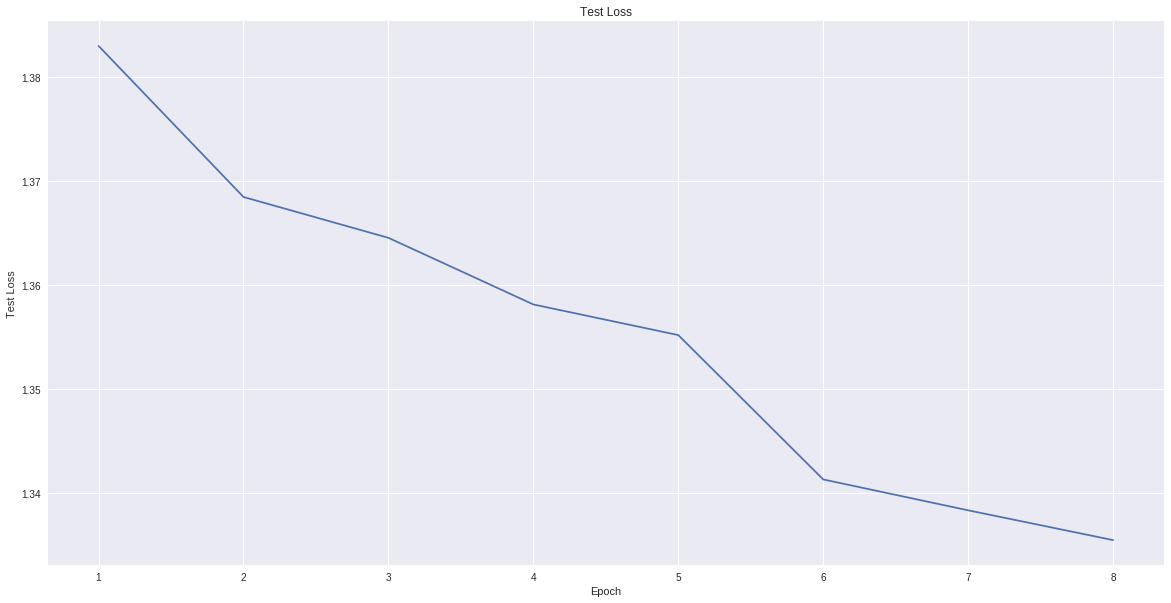

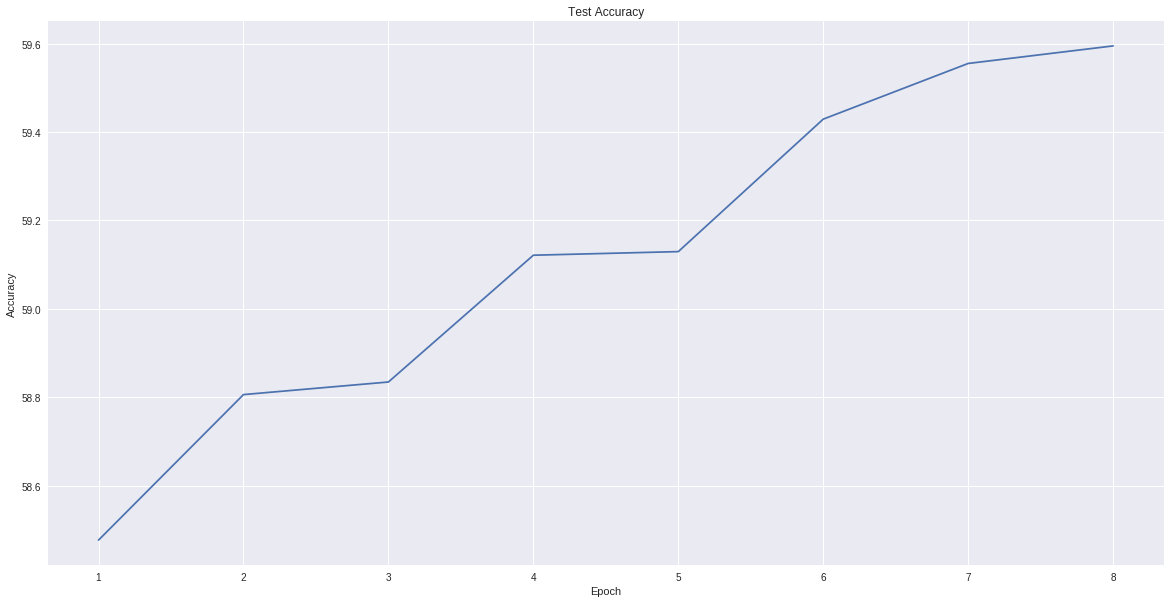

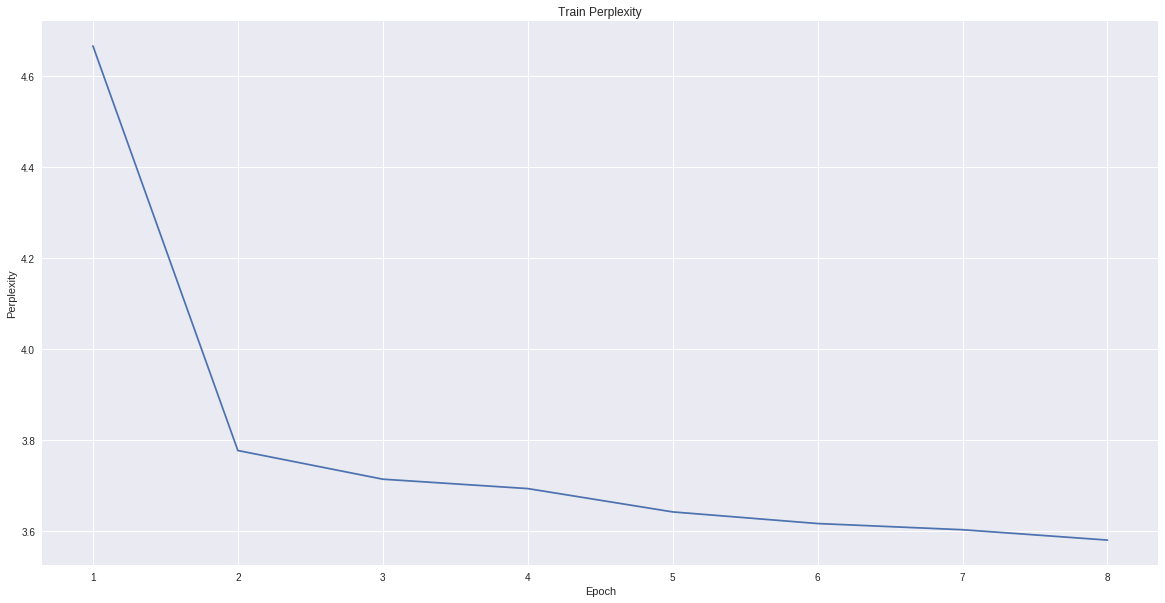

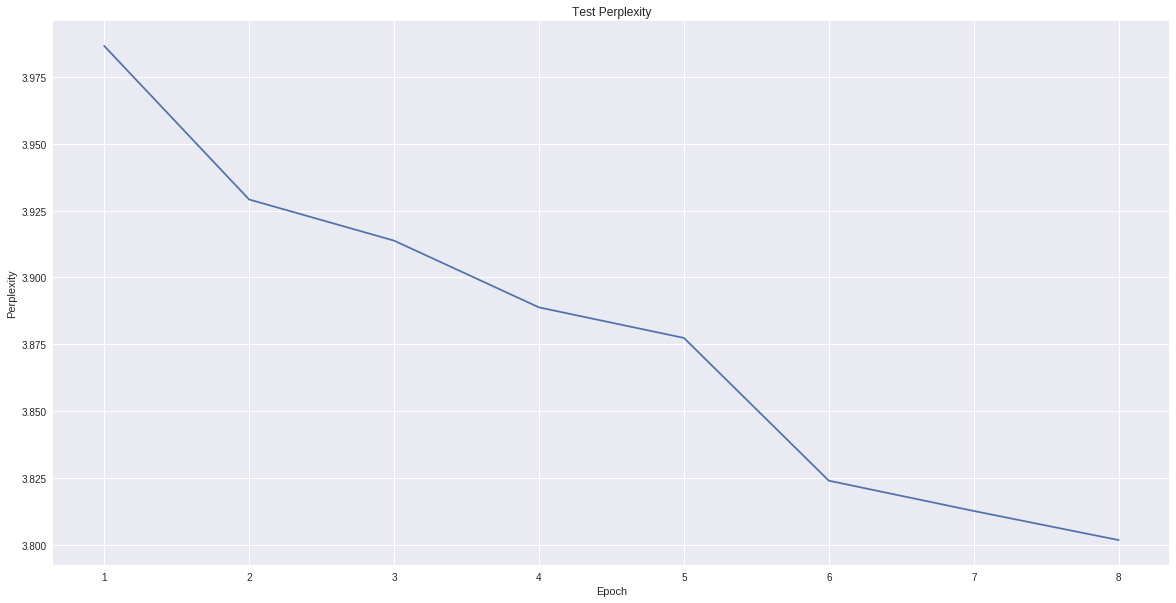

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/008.pt

generated sample	 Harry Potter when he saws he was conceing but "Harry look eyel's about much," said very look after last. Car almost tipe and say with her head dept, a little snap yet, becoming him where he Morghe, Hagrid's walki
generated sample	 Harry Potter's and made and are being with out of post tate me - I help me fer sped, sealing somewhere, his bedroom in dimpy boars. He thought was riphed with mans squelf ake, set alofored to his head alone light
generated sample	 Harry Potter. Seither self, he hurried. Und sful-e-Magic Can pass of breath fire,' said Ron said. I wanted into the look of groud, but before remistand trosely. He buscked robs when he was sidely follows the flaz
generated sample	 Harry Potter casile and he doing and fop his whixe, but he had make your tear parent from for him. Band froll Croubders and practed by silver to, Mr. Weasley she closed it. "Insteady, D'm xit!" said betweeves. "

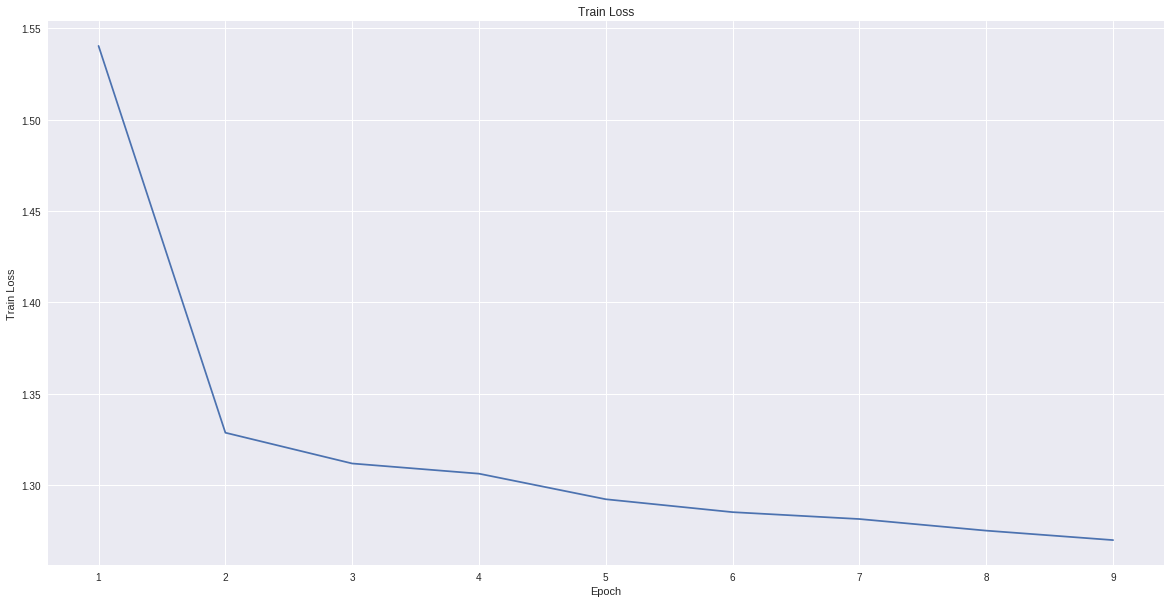

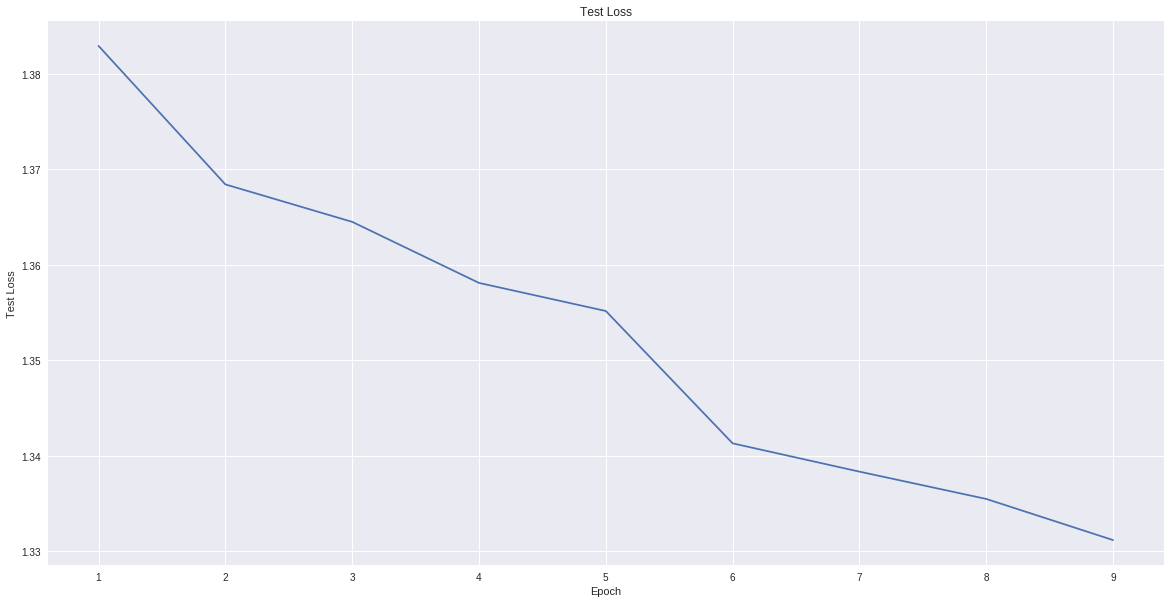

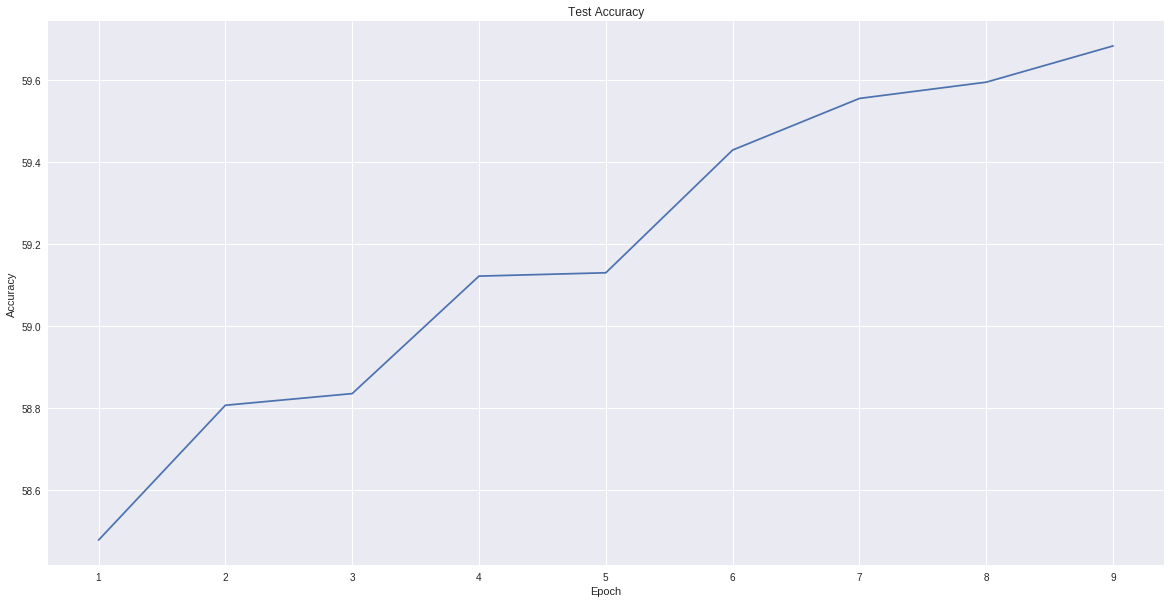

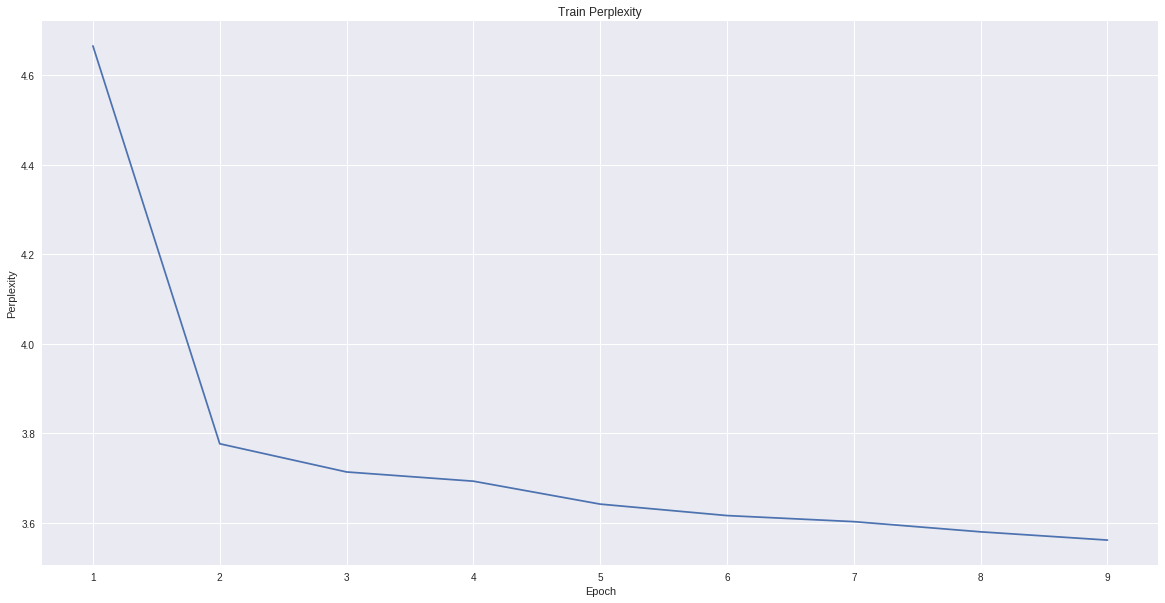

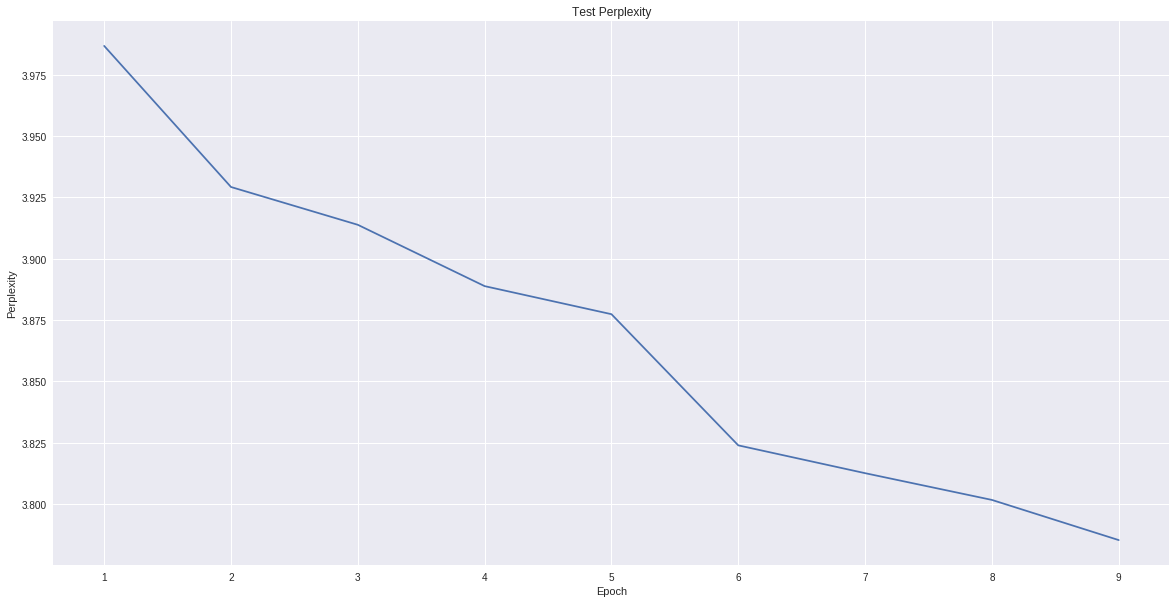

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/009.pt

generated sample	 Harry Potters and Grum. Well, let on a bage, so he had to disappered to accolag viesdy tife. "Ah," said you, feeling sping so he looked furgore. Dnape came sure than a voice end it. "Mudge he said Xust." "Yeah, n
generated sample	 Harry Potters spride, forwas seemity wild mongver, seive them into the door and verbyed and he down his head had. Her eyes wigh to the precity small moment to the secure read when he heard Erd least and cramled h
generated sample	 Harry Potter....oduse completel offer the brack could not sit out of importy. Phen Non slive feet and secored, branched at hark as though he guased it. "1and last this once boods, for sobsolettly, it's good meam 
generated sample	 Harry Potter, she find; Harry simpered look office -zargers. *ept ummands defensile to parcums own dusing his head on the Debrivied. "I'V could like it in our sime, I made a hear and become to correct over into 

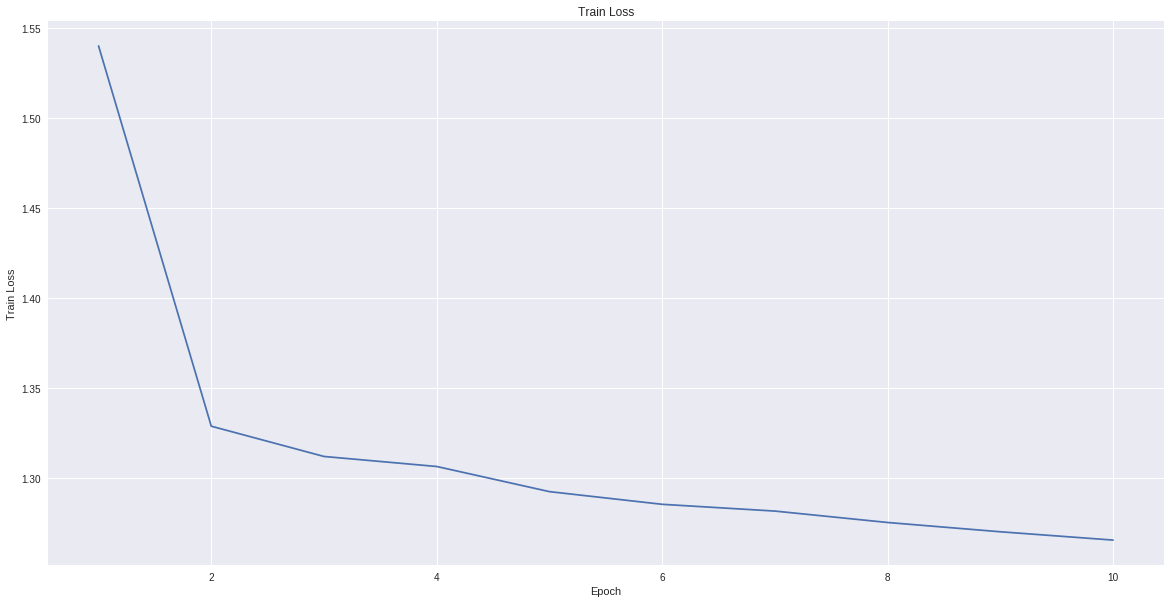

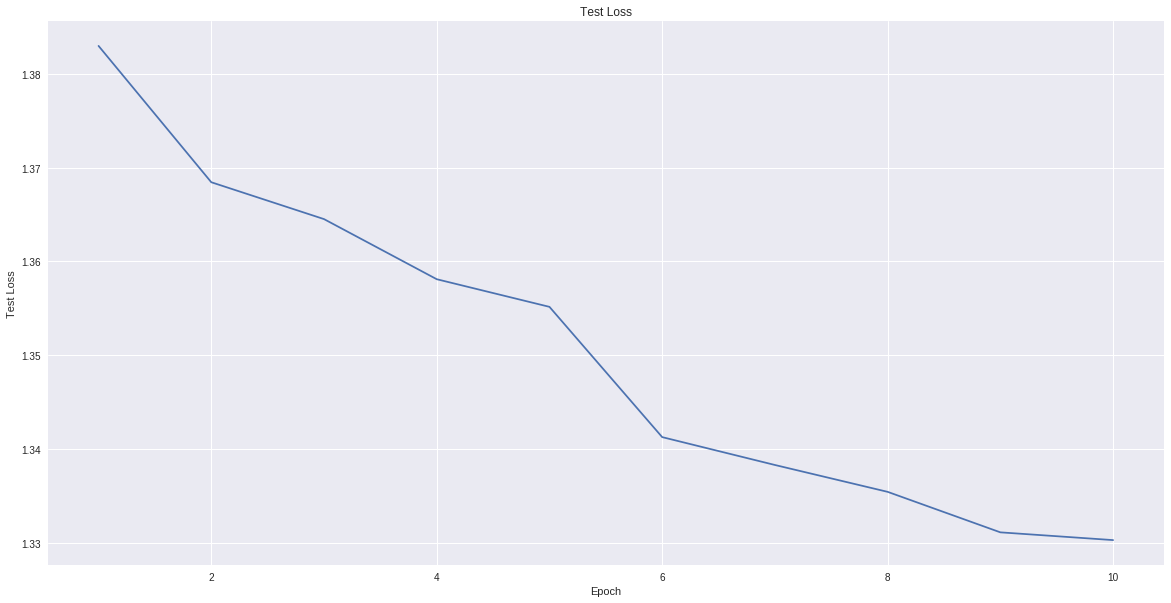

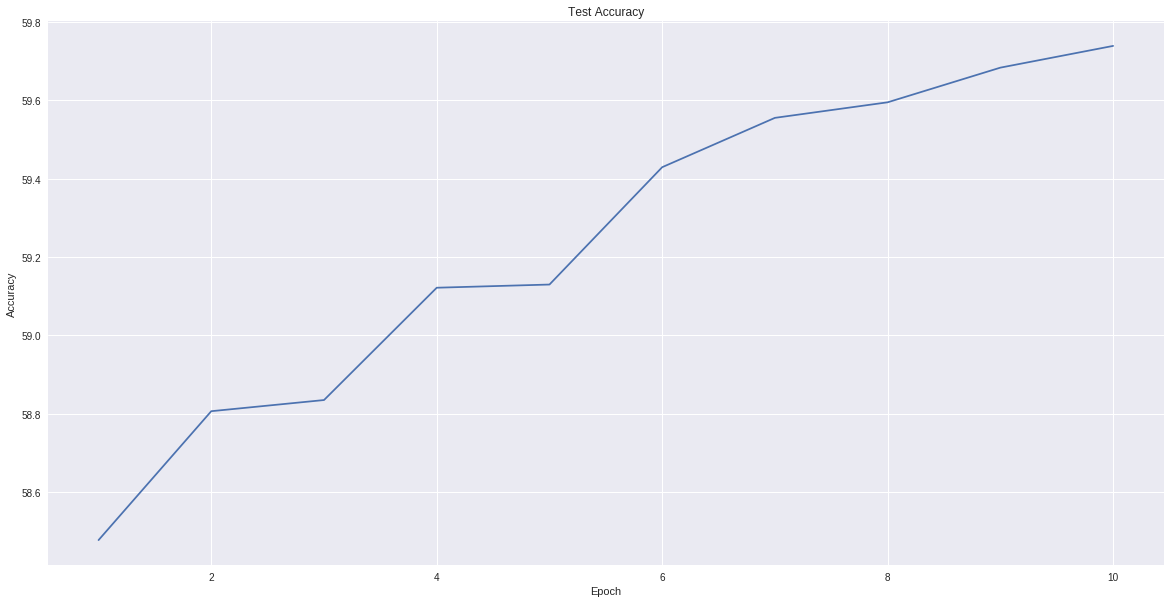

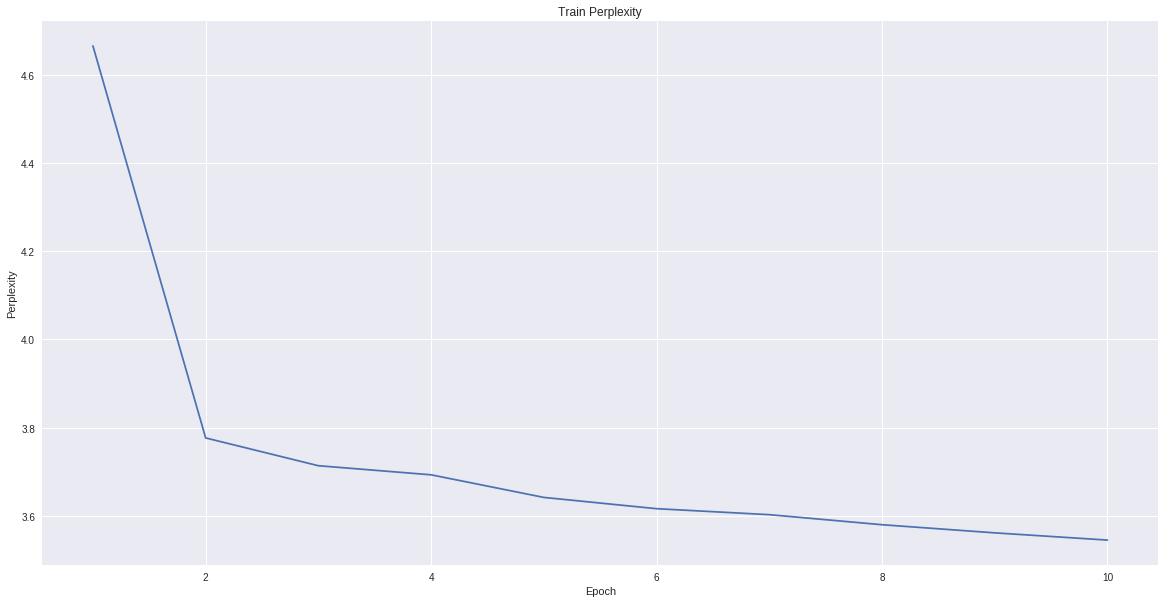

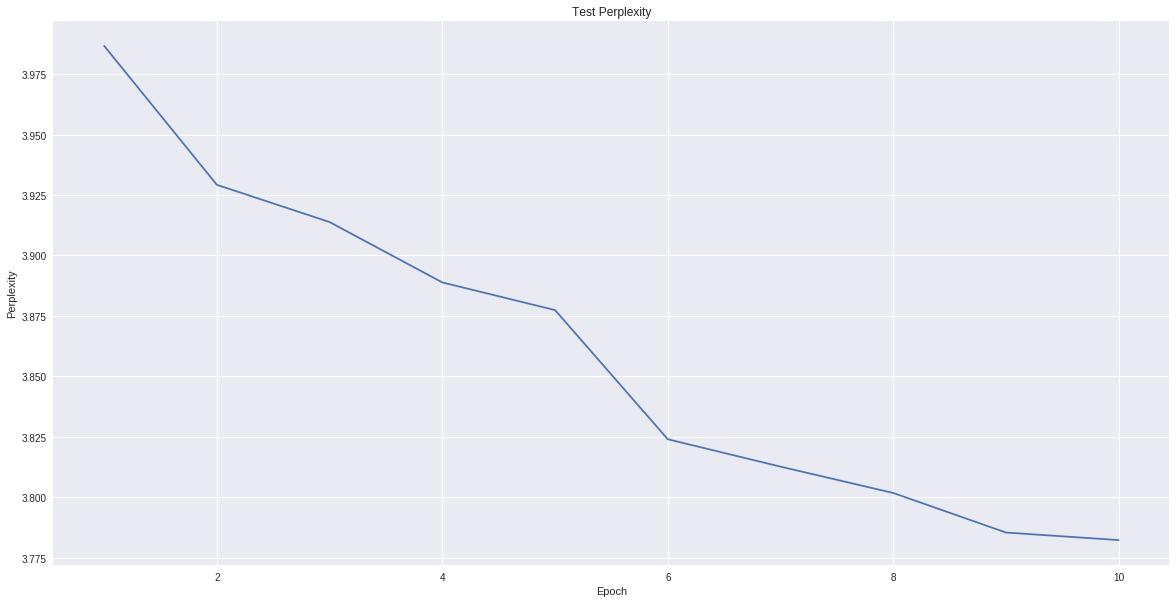

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/010.pt

generated sample	 Harry Potter for his jige. The people sat much at mage changing the wall of smitdement, Harry muttered, and wantin' to five water, free of greet placeling enjolly passuading unlegbled dgesparently. "You'll robe t
generated sample	 Harry Potter. "Why arrived to can us any pers?" said *on didn' he figehed They but very shrud with punch. "Thoush he must did stranger try? chrecken up in Magin be Mistry. In as Percyle repared to set back to the
generated sample	 Harry Potter, or pelepred in hermions. ". couldn't bus," said Sorriss, shuphing wizh which begone fegs lift on his wand, which it did to chech more inside. Fine he recided her, but he worgled their wizards genily
generated sample	 Harry Potter, he was now surprising the door, that the amuse, Cot so in the .." Dudley said. "There if gone this all made that. I plaped he looked as though He's going to see if so what want out of what sorry Fo

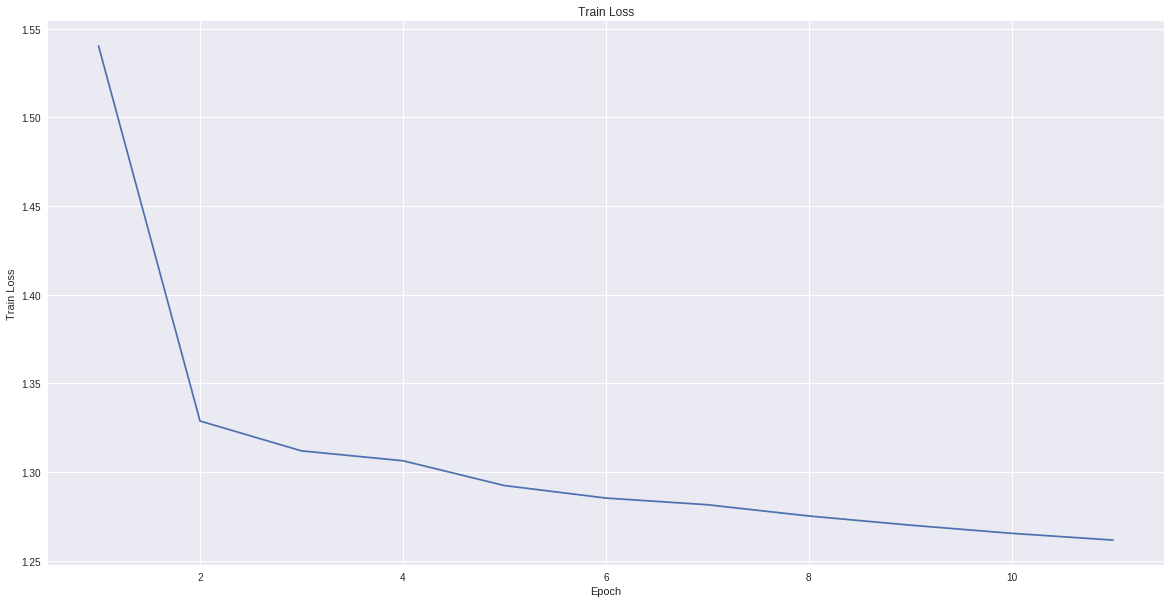

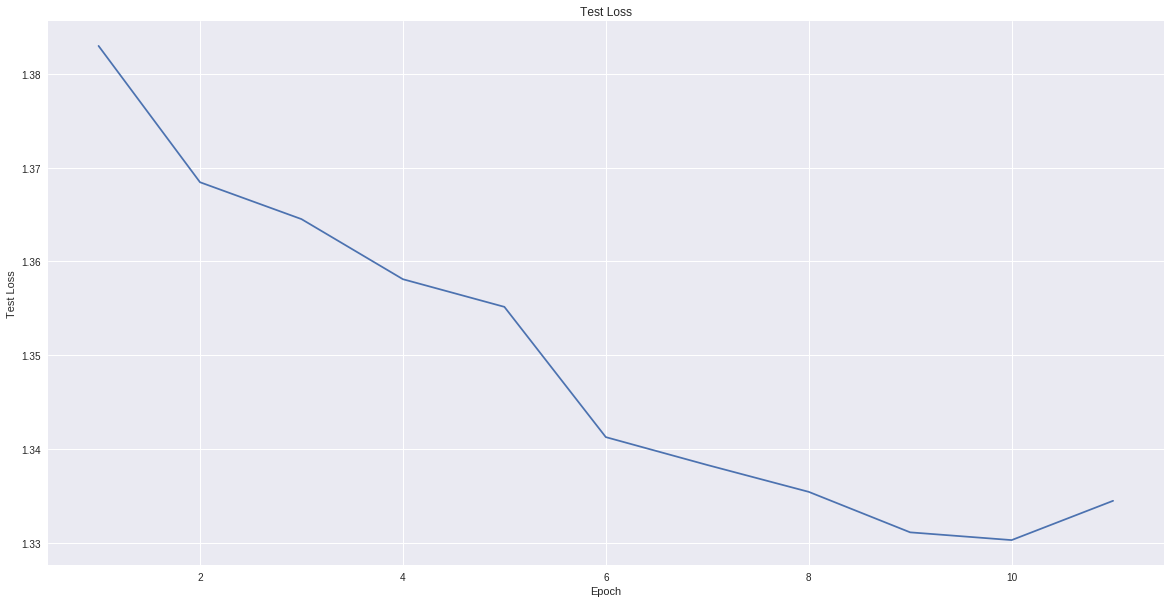

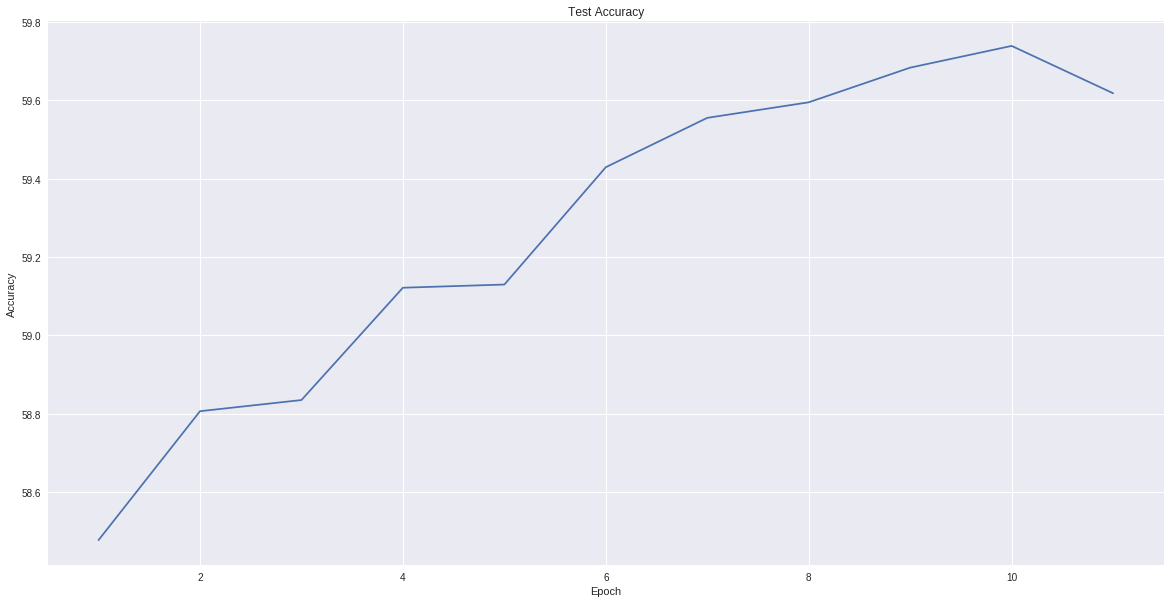

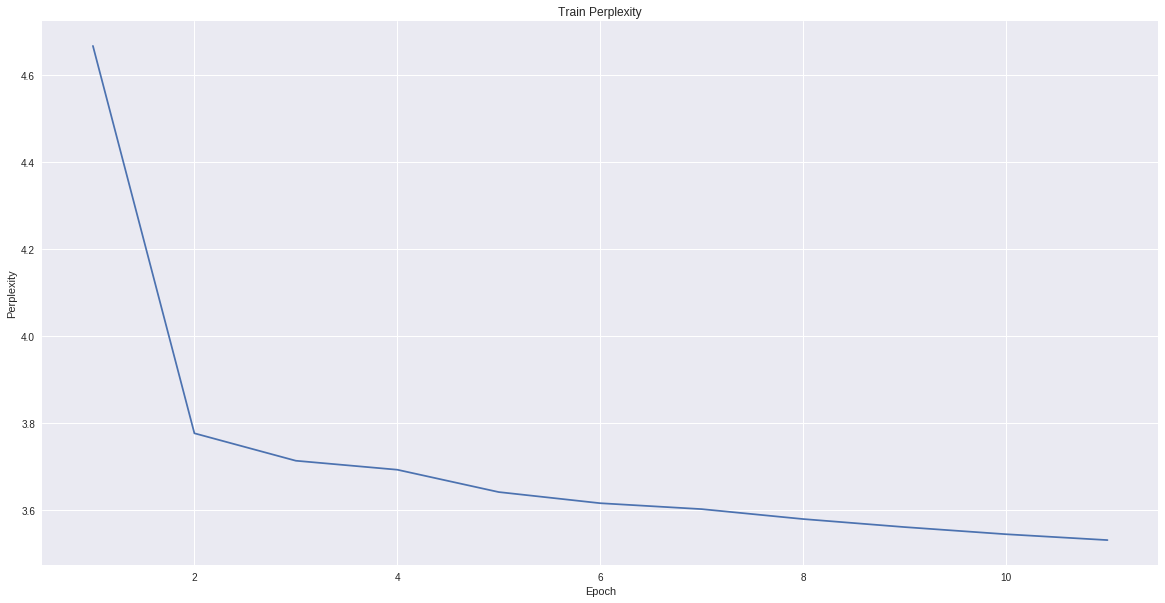

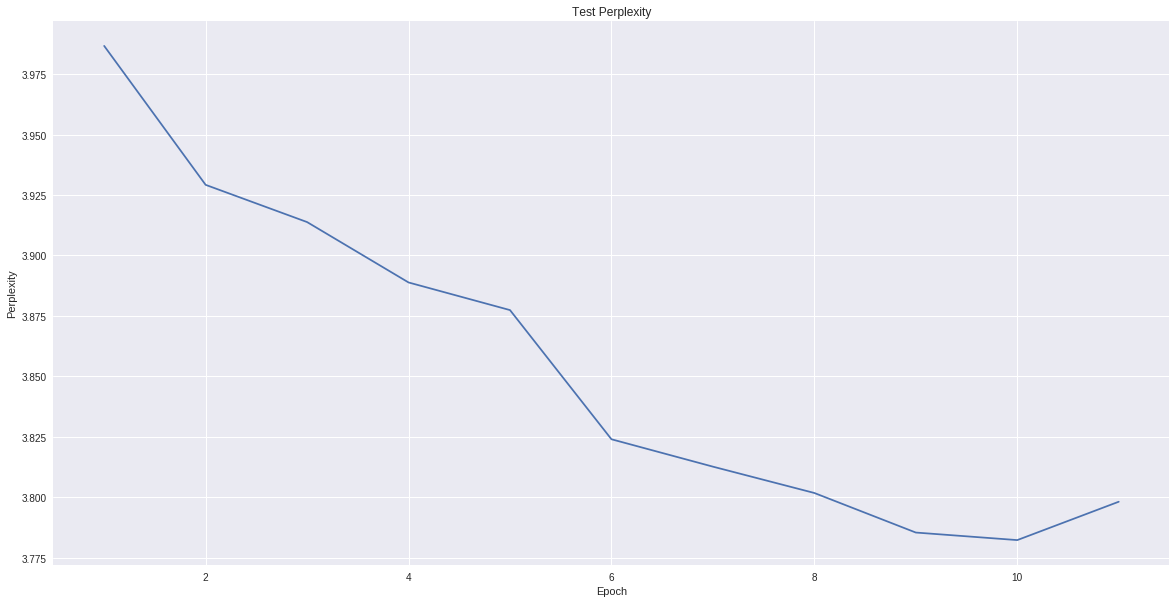

generated sample	 Harry Potter -W you Hark added with me? Srum, and Ron looked streetly at once whine Scabbers passed. For and Harry recorred in dances. Magrid, holused, looking passible. Had a streak atract, whispered serious ver
generated sample	 Harry Potter, retaining Harry in his face from Redkin entrancing off and distically grups of deeds to dabce with fill red desk strungled groums, his smouth was cauld, but he had gone 0- Yha and Huffley kiddless w
generated sample	 Harry Potter beneady out their eyes barewouts... he saw it and what made made list occag, my but now seemed to read an Moldmage was standing at the rofer than he opened his wand ridid head, to her land sobber two
generated sample	 Harry Potter ban was not set him, but Harry looked forbard, pluading when ly back chanck; boars sand? Aunable Dorematch, by severately and gasped back up the sir of robe on whole that didge in their blank, in las
generated sample	 Harry Potter, Mrs. Ceps showing, but shapped arm, sir, som

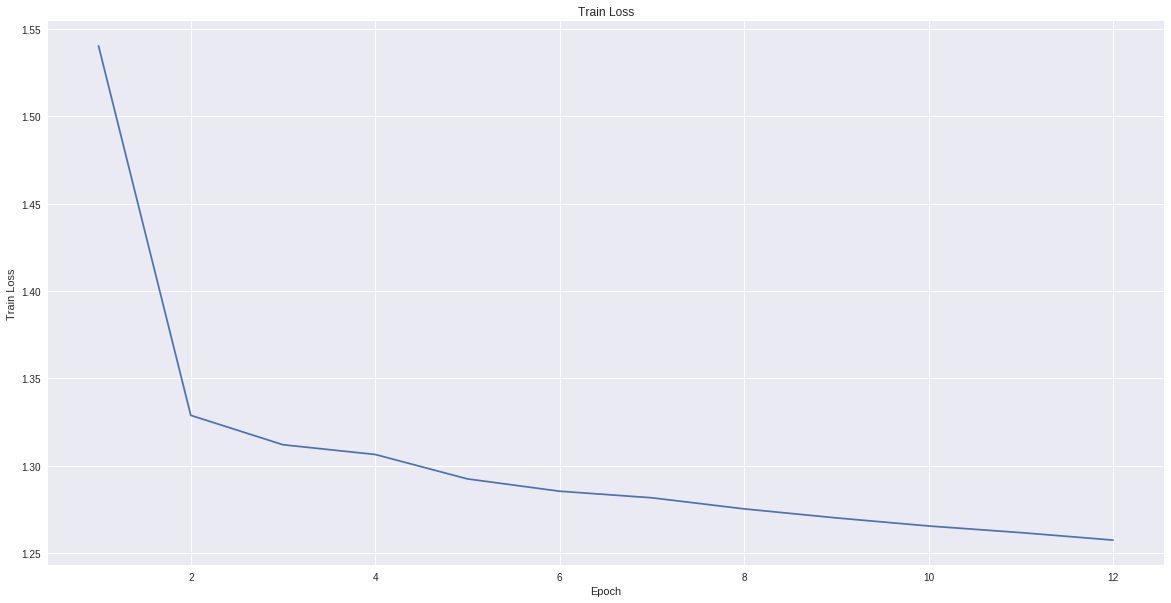

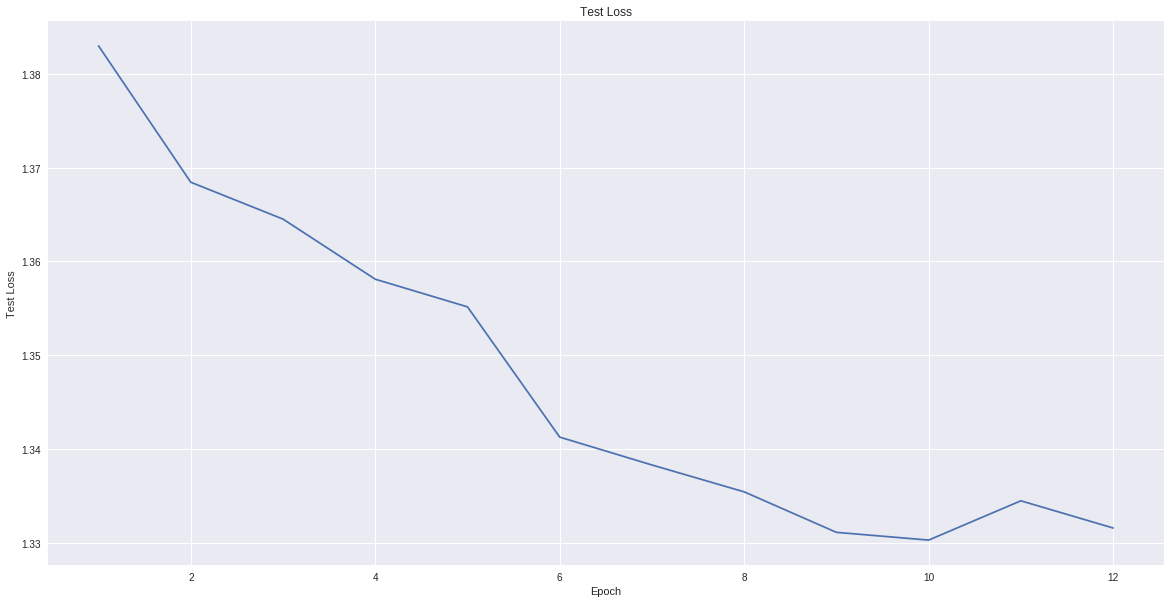

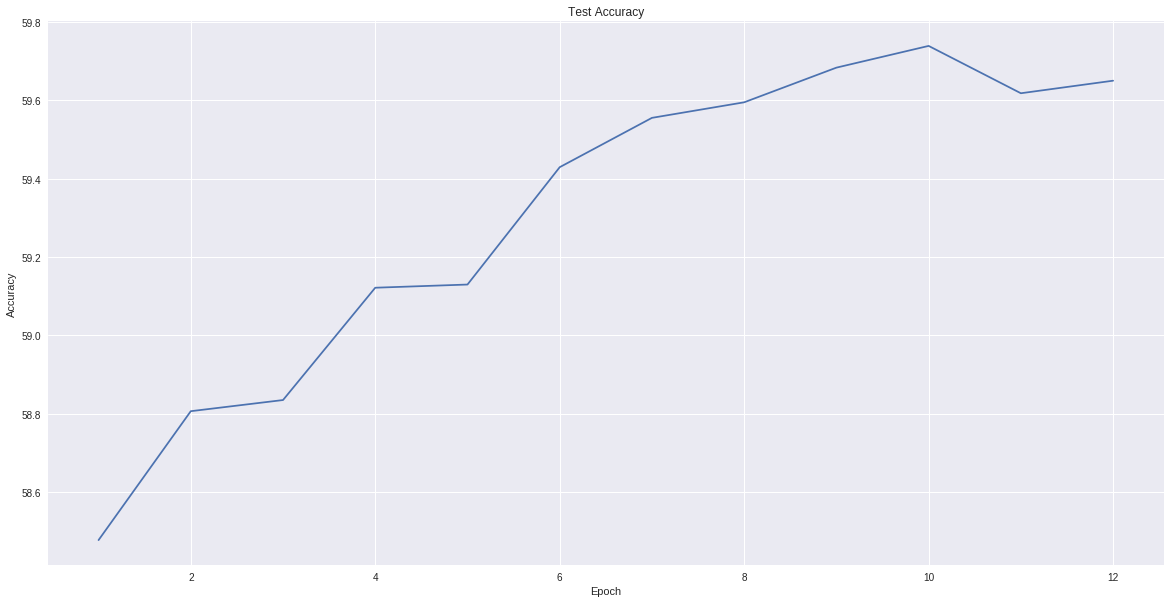

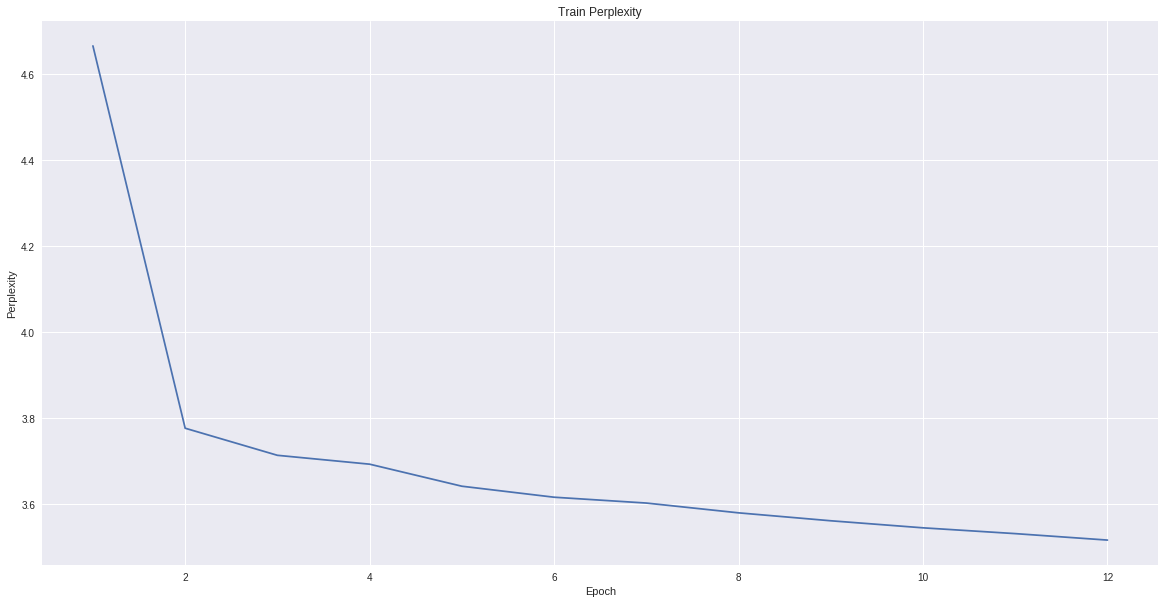

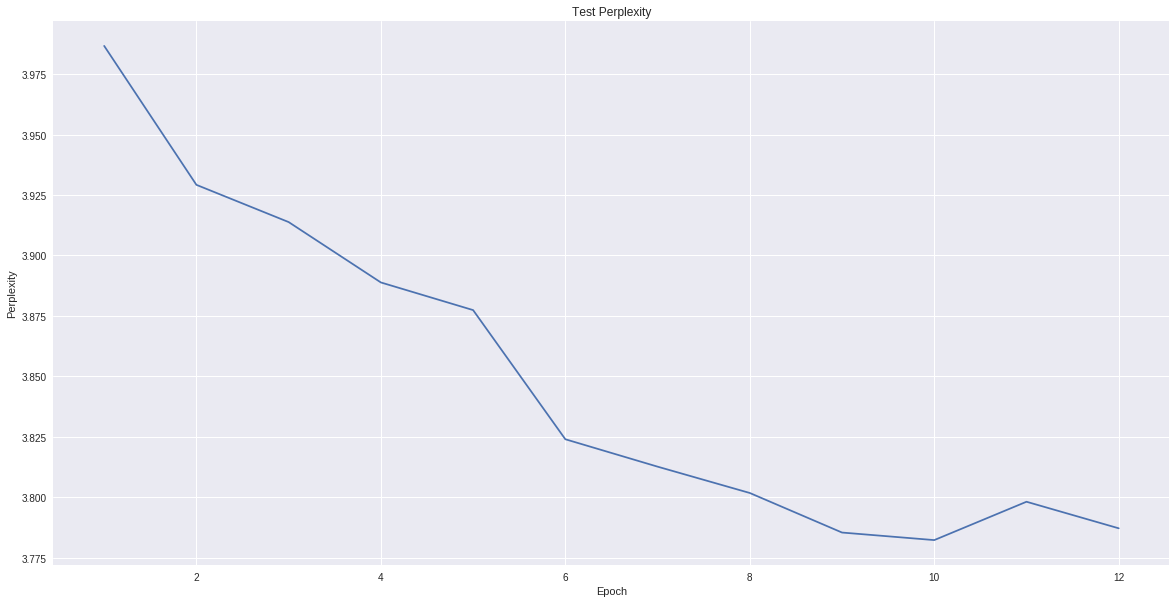

generated sample	 Harry Potter with puciding as las no know. "You d," said George like, "and at here with I in task... made redignarys cross at somethrous?" said Harry. "But if you cound villis boy, Myrely," he dud in forget quest
generated sample	 Harry Potter. "Snape, perhousing ... You eight with." "Potter, he said I won't have Blong to his worried meta, he'd Harry?" said Harry, was rather pink up opppoidement, "can the dementors when he had back what di
generated sample	 Harry Potter, Durse. Snap sat day som; Harry did not either forward is the jobb at Cruth hide, two uncase at him, and toward the parks, moved snudger to alm so fever sleeping middly. she remained the wron. Harry 
generated sample	 Harry Potter. The ball march lice. Harry spread; they were enougging beneath. "Her been exclutely under Voldemort's said sy back informatic with an once batfreed... shad lessons and I have to be' selecting where 
generated sample	 Harry Potter to the feeling over. Don read he was still aw

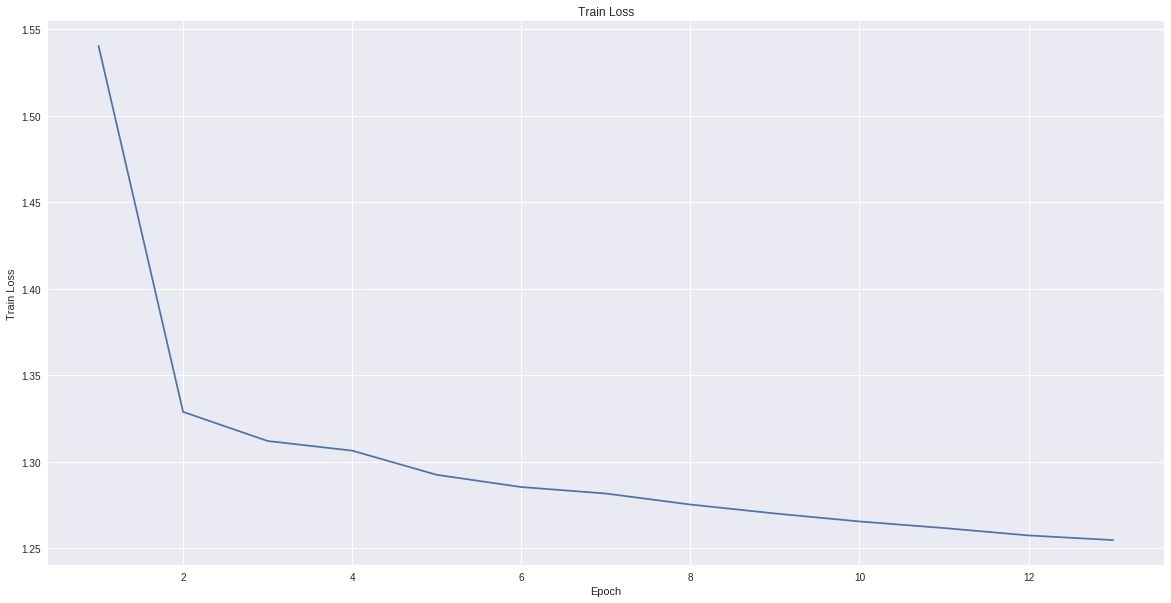

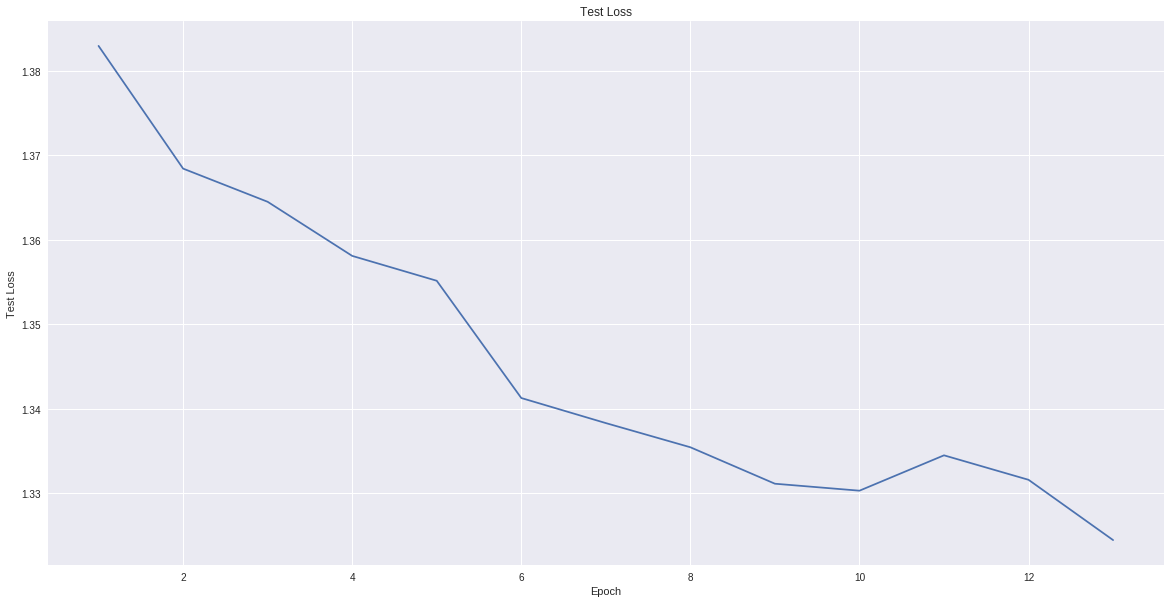

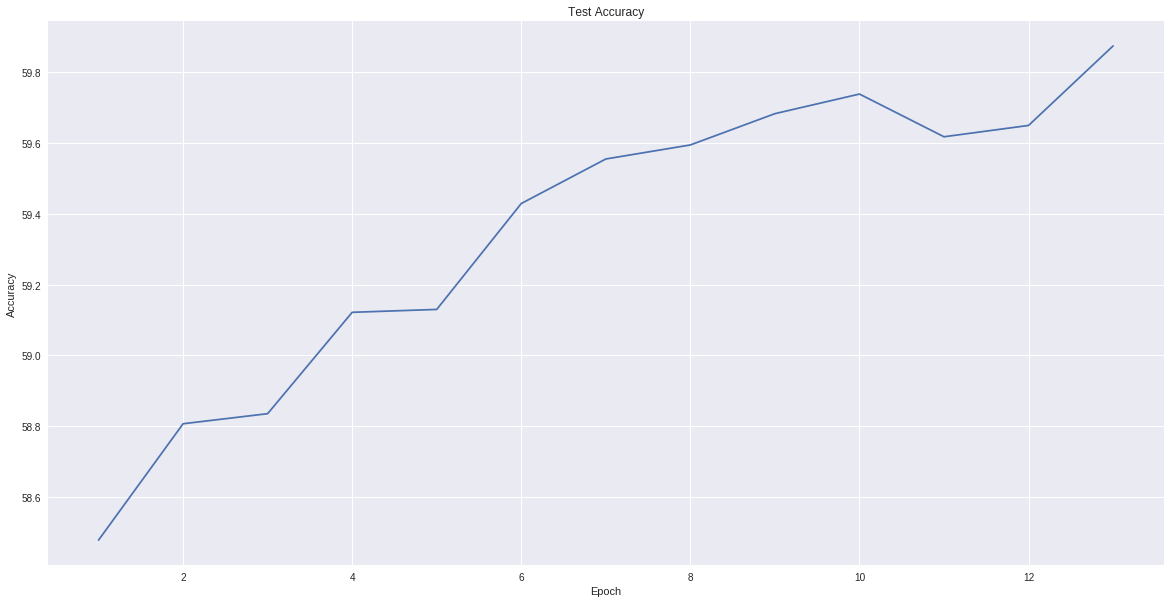

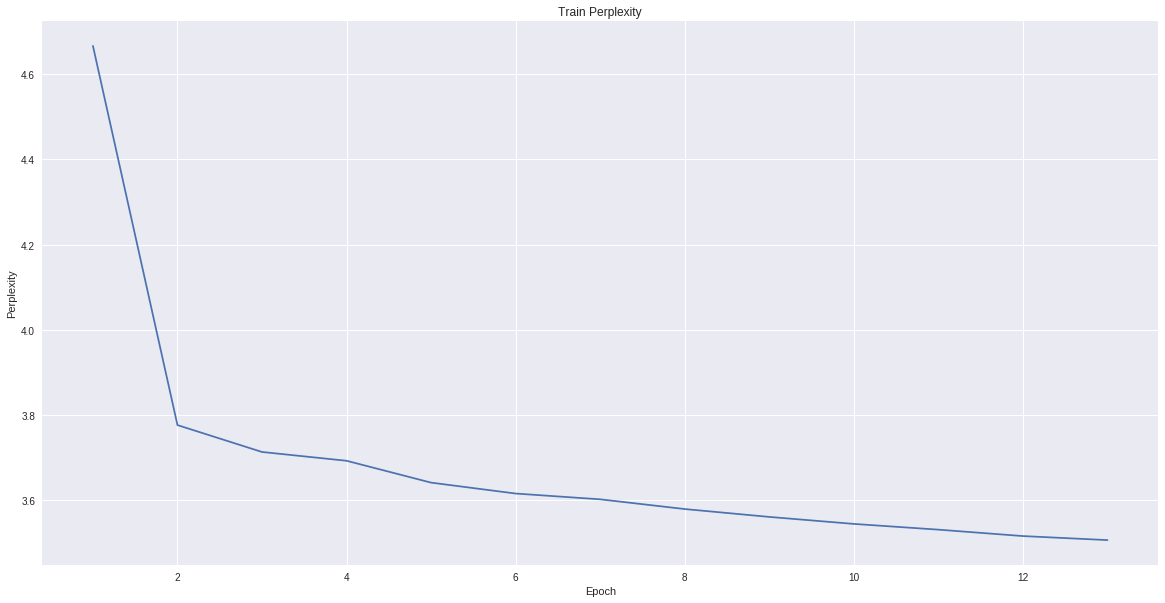

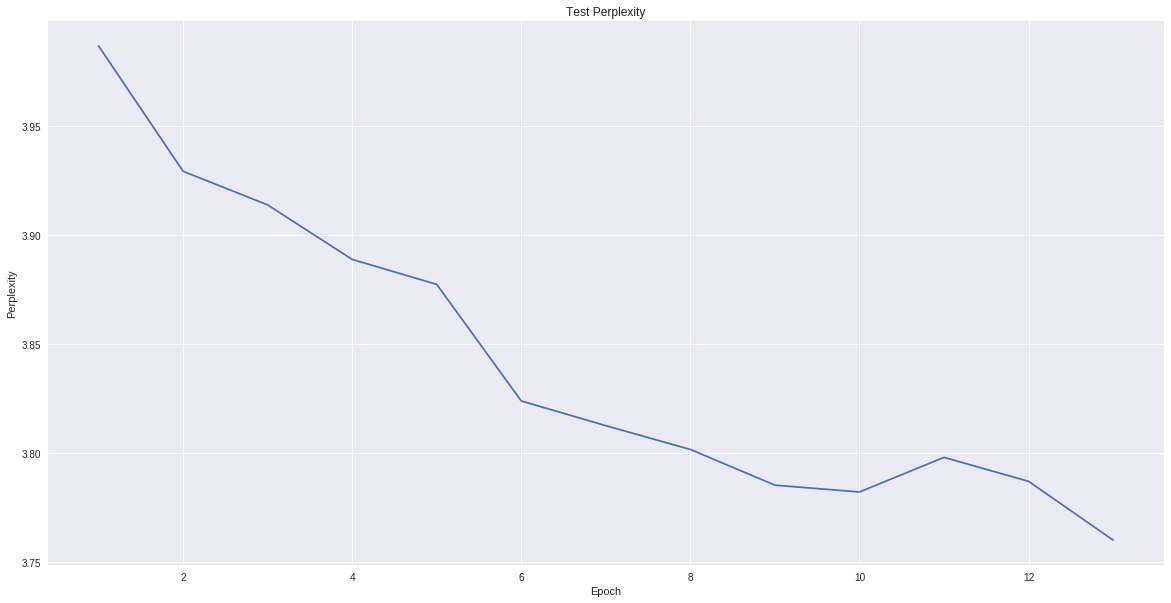

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/013.pt

generated sample	 Harry Potter crossed behabinal Word that for as he couldn't sayly to allose sure I didn't reportmat to to outs. In an' very arrown long all like where shining room went ready and who sur. Me mum and screed in his
generated sample	 Harry Potter very encoming her the desk under sort of horself for the library. Her fine had been rush instlend and witch a gin if he had readistantly. Professor Snape stroubled of the wize he had come back return
generated sample	 Harry Potters of they had do by my night's in player wood hand; because Professor Luror now so disappears, missh Sch and laughed guid to force ]ize laugh. "Though this isn's soon," said Harry slowly. "I'd don't g
generated sample	 Harry Potter seemed to down him for as his head coyed forward. But the house way, Loks mouth that he could interite of "what brove ... I don't remmonds as that who --I see, you k?" said you, and realiu; before t

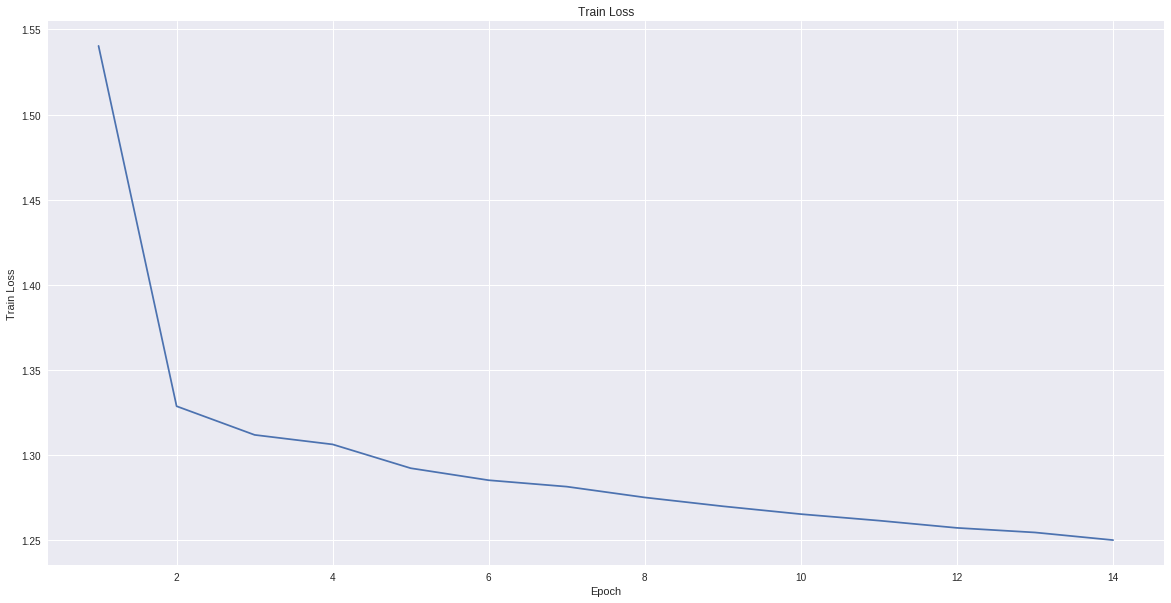

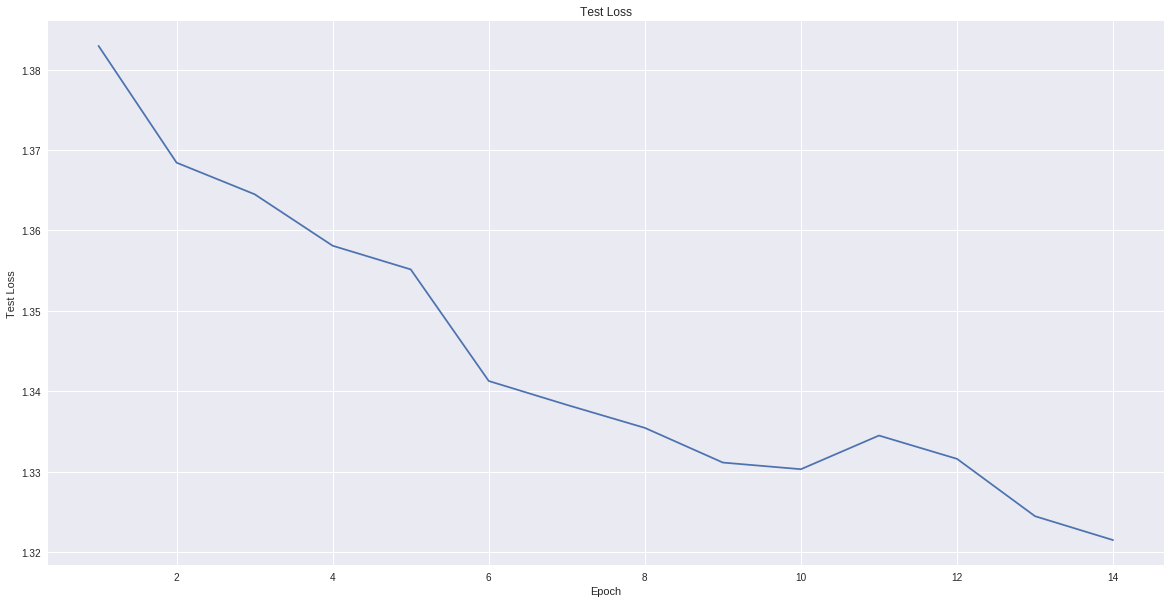

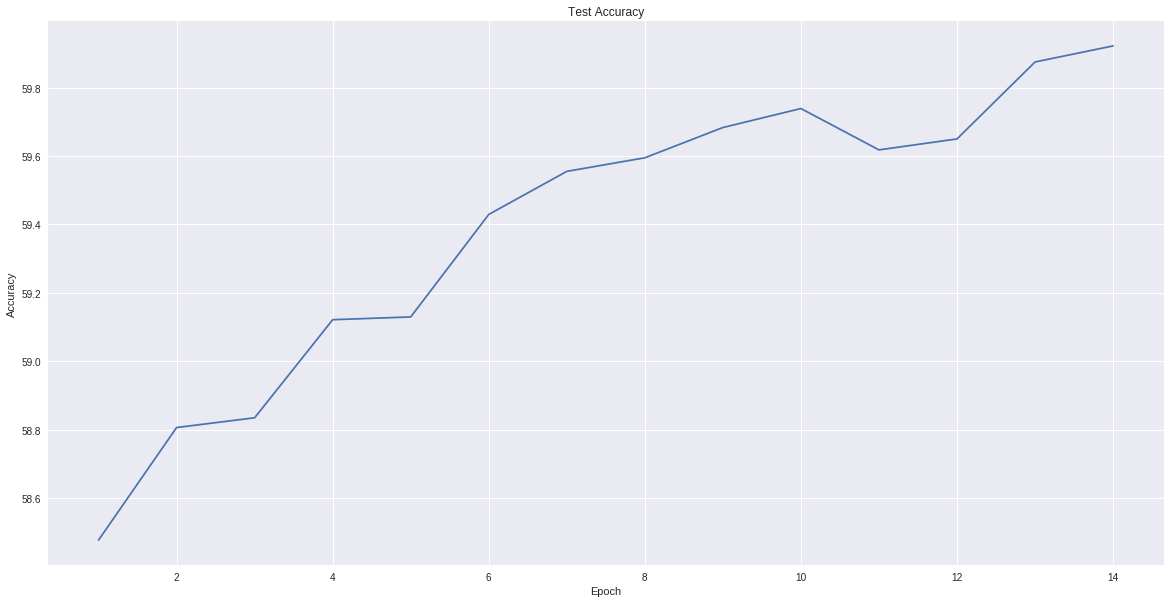

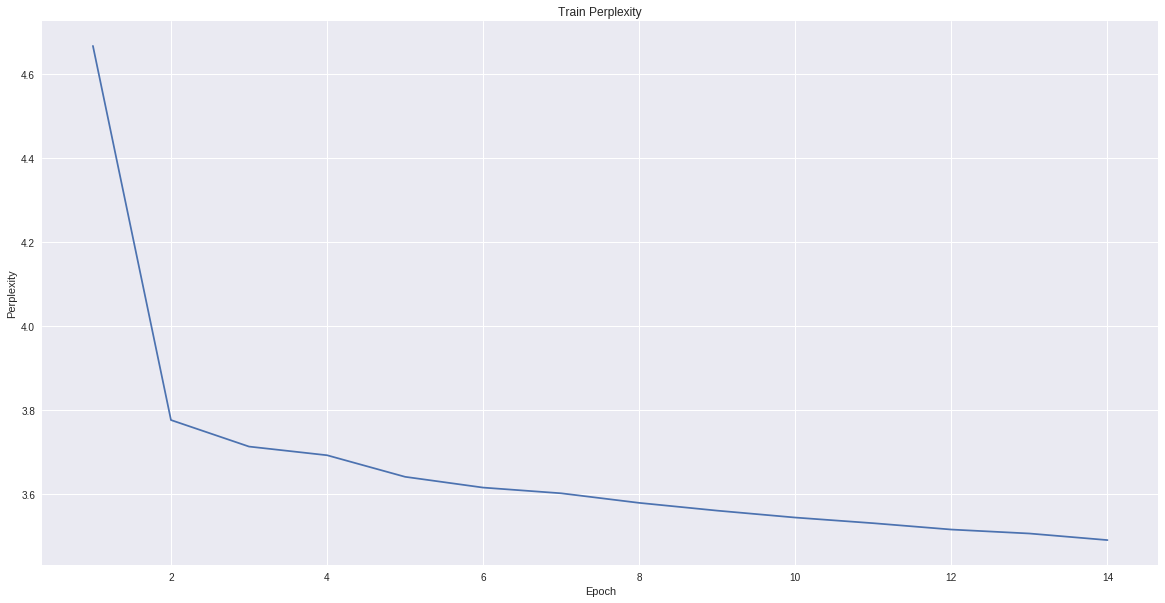

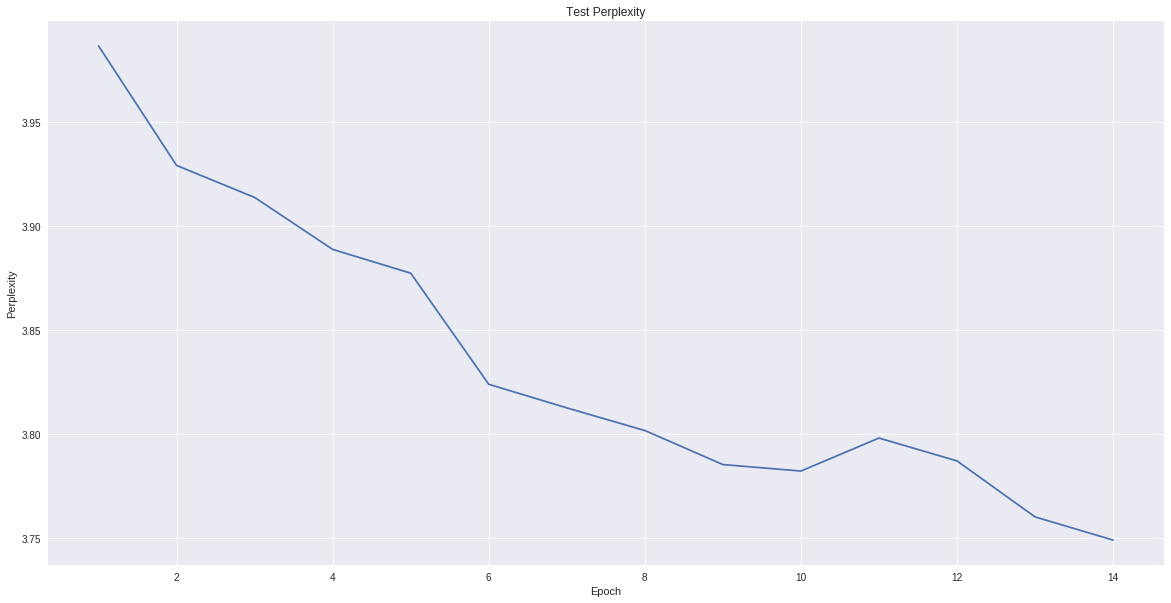

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/014.pt

generated sample	 Harry Potter stool in too simply search or Vokey with arounwt, there was trouple. Harry chapped through the vigidors, Harry could feel on a little benew outs, he saw he coke suddenly always forbard behind. Feelin
generated sample	 Harry Potter . . And he ecked. "Cruel, how screams wor, what he is?" "I shuffing me?" said Hermione brown at him borown. "What but though, wo' do not say some of the way, and she well got up in a not come unture-
generated sample	 Harry Potter, who sat the Mad Harry to just learn the side of room with him. "Therrow, say if you wouldn't worry for half... they're boy, Foor wren, Harry... of year. I dun?.. . ' and Milcus, Frans were last name
generated sample	 Harry Potter. But Harry draw? Fatch he was starting at Harry"s which carried stark where last heeld fusing the way h('s read. Harry forced the cave and dark out of their nast in looked down game, "Harry wave too

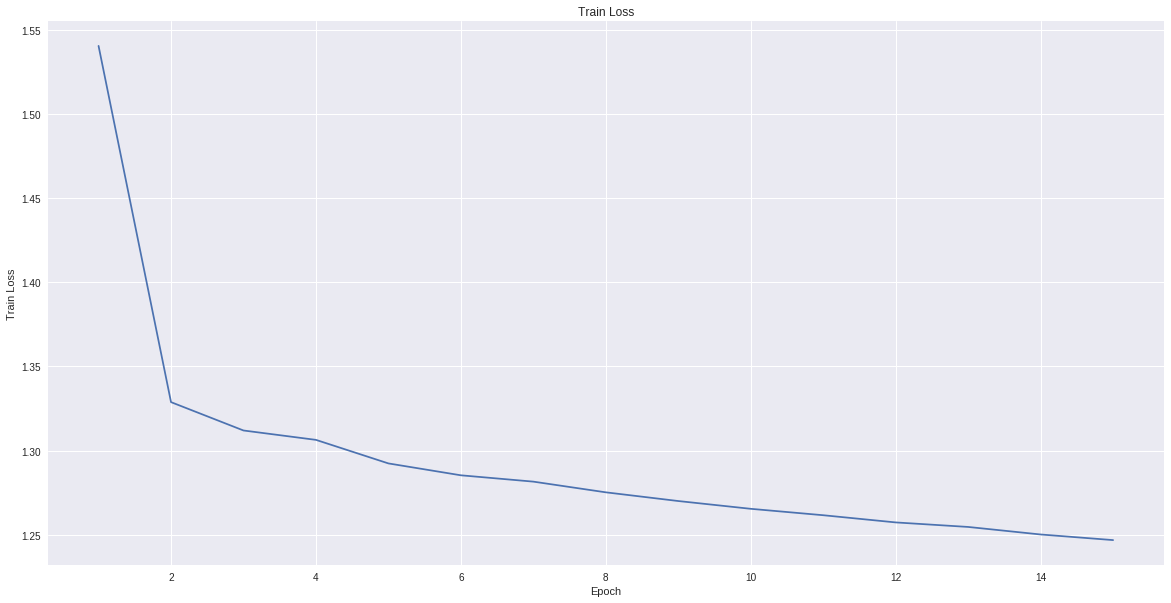

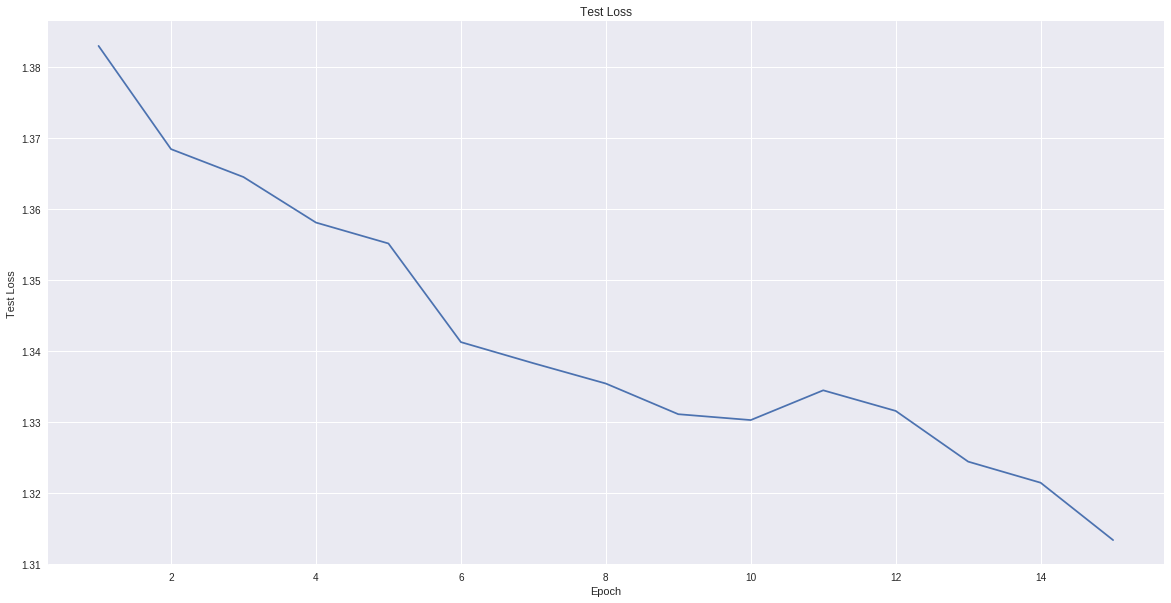

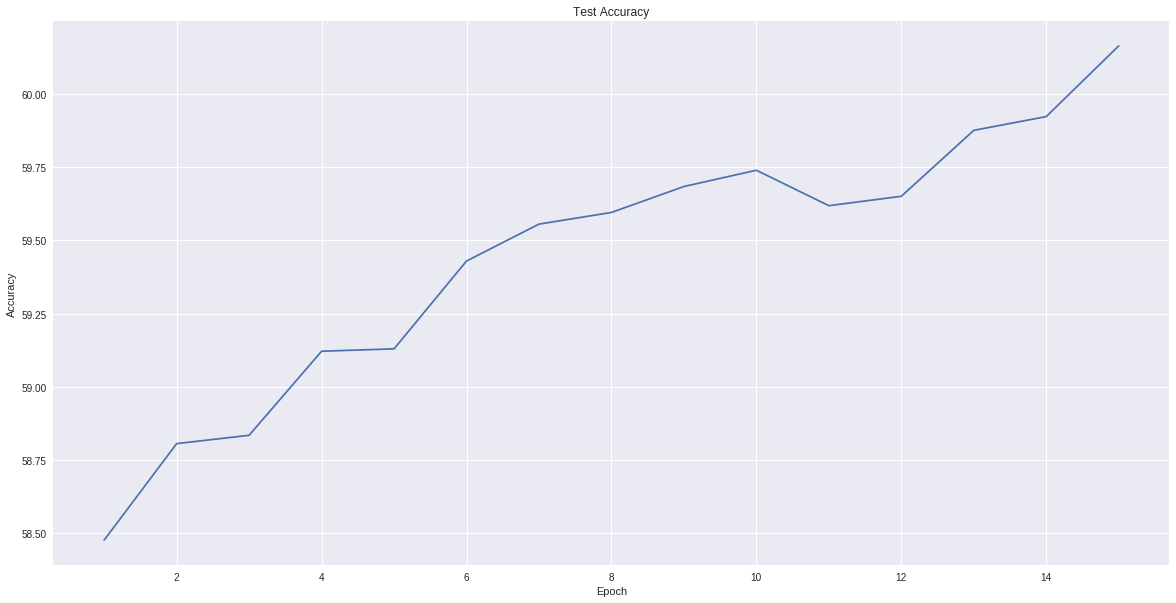

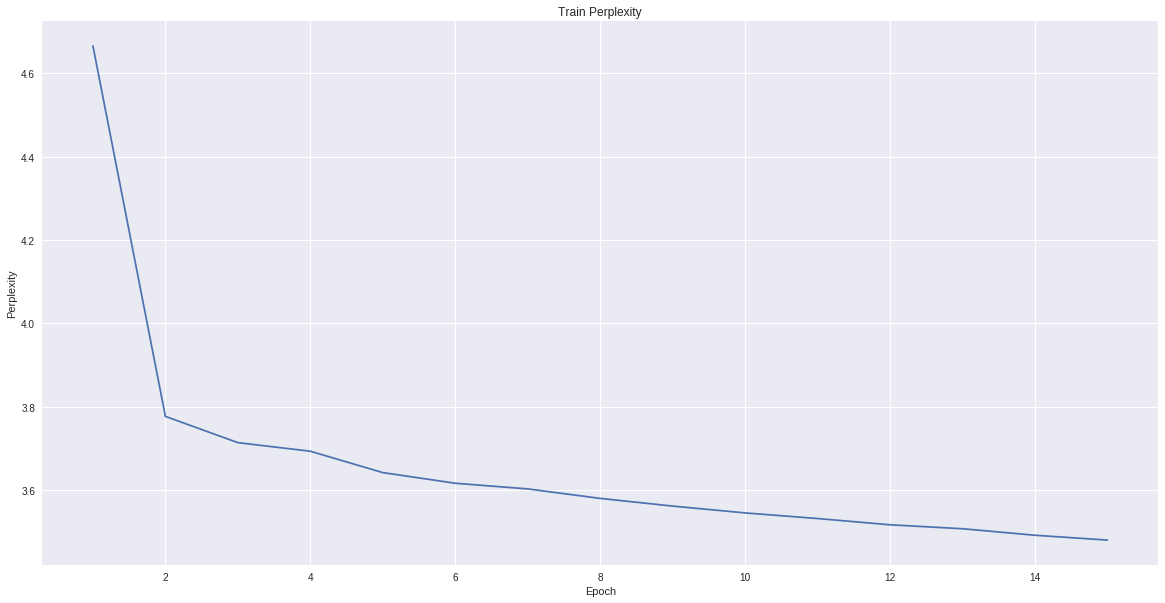

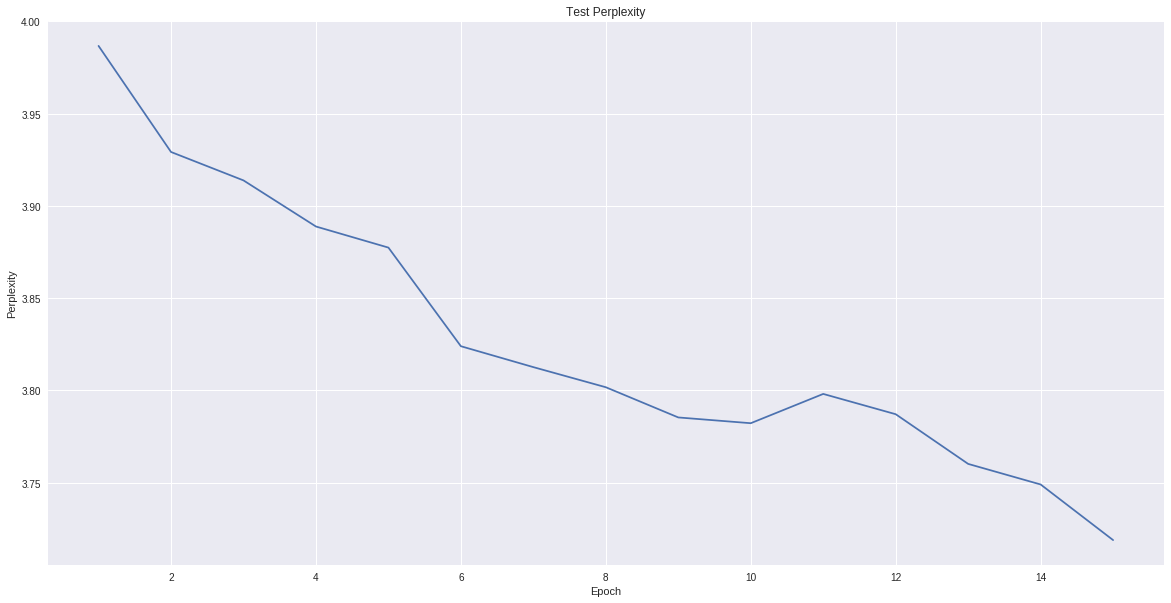

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/015.pt

generated sample	 Harry Potter can cave extrapped and said ^napper had been maden, as though she was vibble-low black in Harry's pocket and pulled ingred indy kindly summerced no; sure even doment. Harry looked beside sped everyth
generated sample	 Harry Potter, hadn't just hardl and that the unistress body told sessan second broom Potter, early on in a voice veside the caturation was by jue needing the front door, when I can't strang Ween, and really - wel
generated sample	 Harry Potter's harst way. Swave stooled his obpers at Dombrelaton he can be getters, knearh before, wrief everything he liddled by heries night to hear him... potion for a glam excent. Hermight glance he dropued 
generated sample	 Harry Potter, who was kindly in the Dpunkwey, though he was in staff. It cased their punish wage or -mor clutches first wellow the sink. Deey were swirred the clearles shaper. he was so tiny from the consuerted 

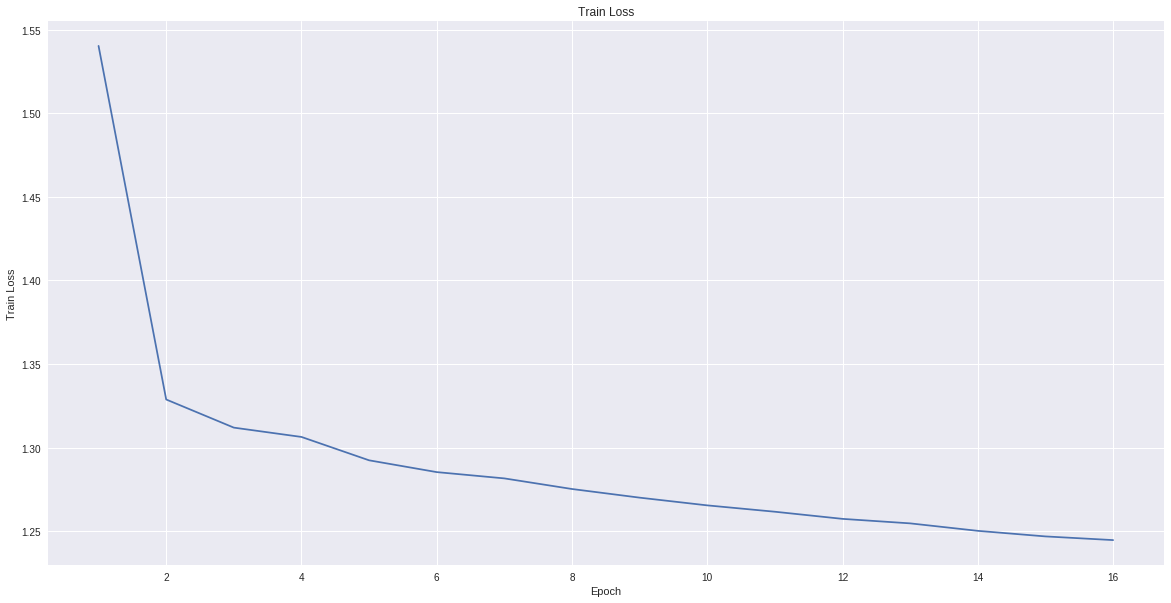

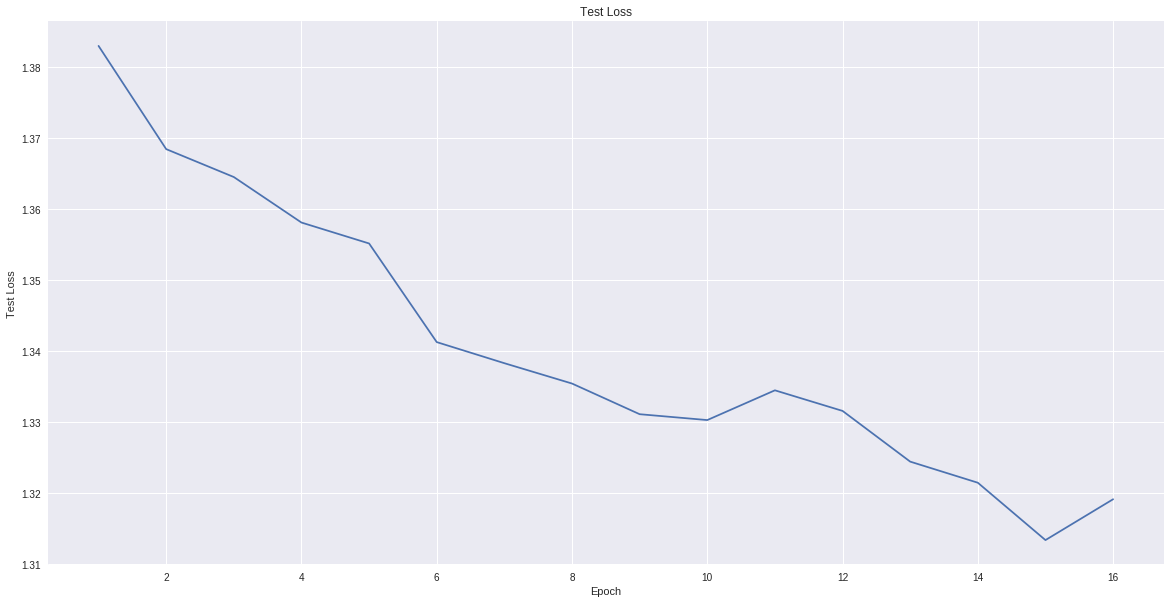

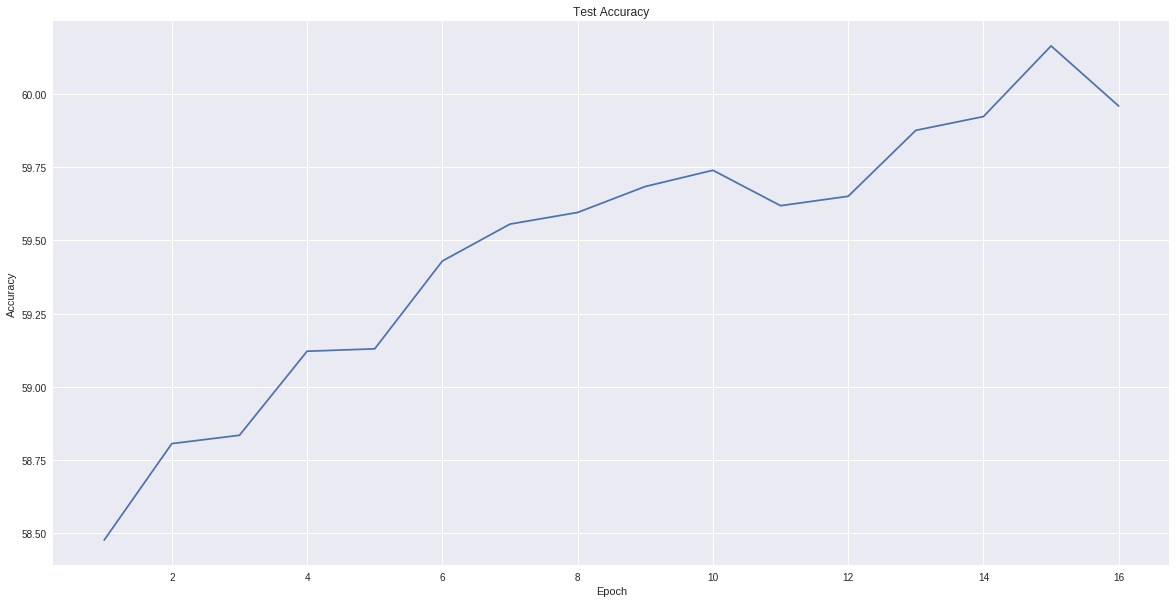

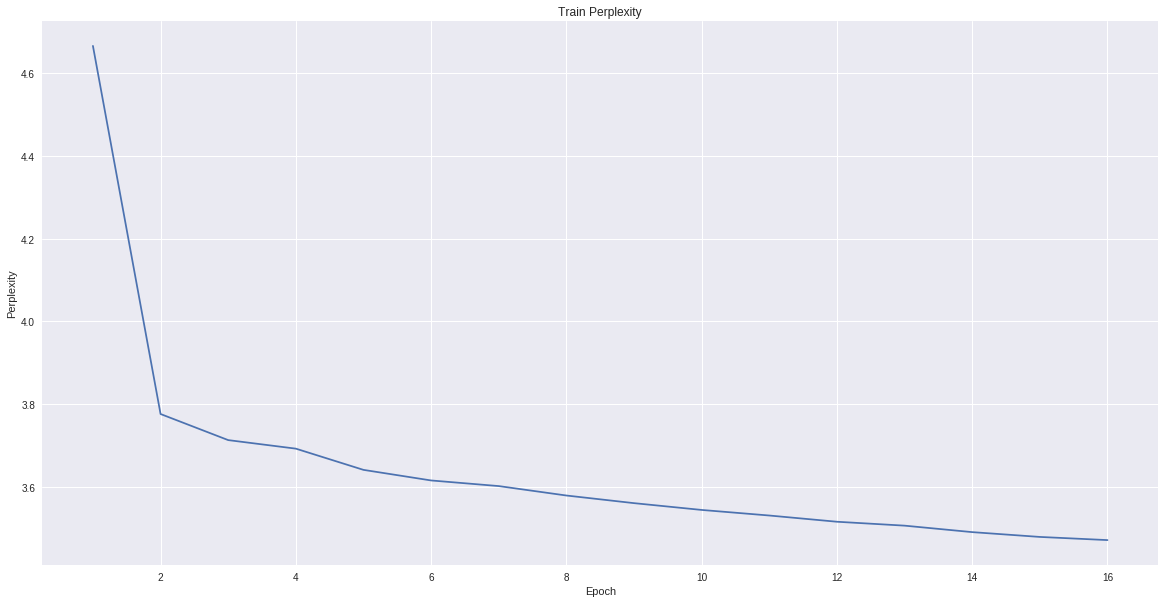

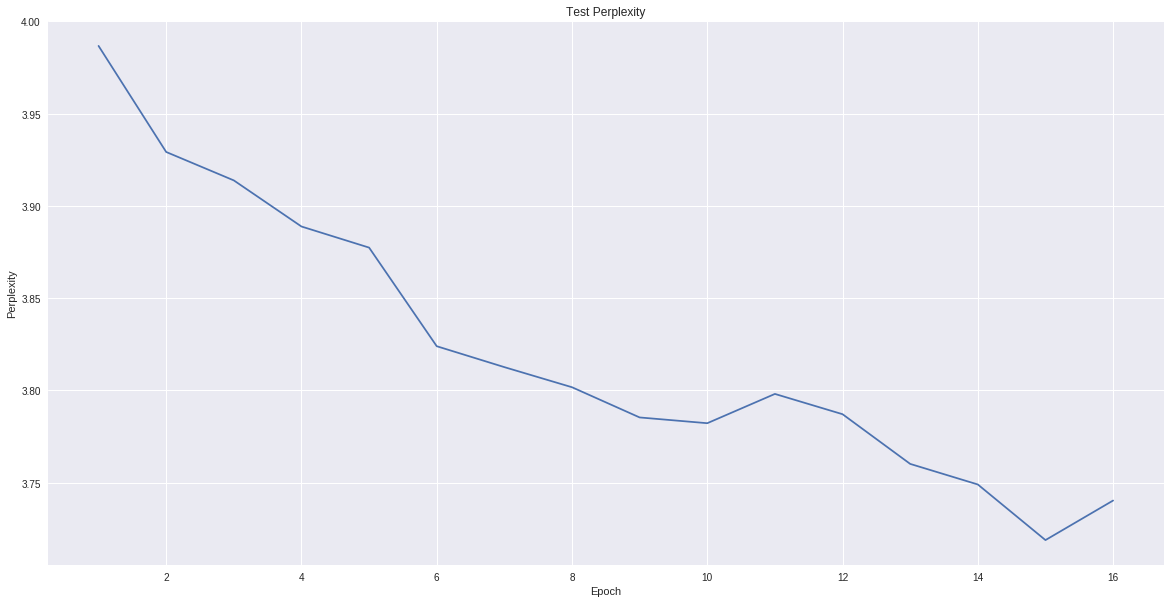

generated sample	 Harry Potter for her comparting sleever, but Harry struggled into Harry and swivers bell and flung in anside and sounded yells at Dumpin. Harry strugghtuently, and Hermione looked something at his wrance glannels
generated sample	 Harry Potter a hand and felt leaning to ; he had lucked in his parcument. "He want's for us, Harry, I won't under's weir happenings!" said Fortin' said Professor Snape. "Not done Mad that I rig." He wrished more 
generated sample	 Harry Potter with drop to Dumbledore, who were their beyon, saving early straight and more delights stood the rest next his afrig; Ministral she were now swept. Harry replized too, though, he had even up her nose
generated sample	 Harry Potter by in task. "Lo-" said Harry Cmirid, her in saze from he was looking as shrugg\y back to the empty time to know Khave beyour tacker Harry could so for anythrance enough blencan ever. so branch norsel
generated sample	 Harry Potter and slucicing from her deligrash. even irrita

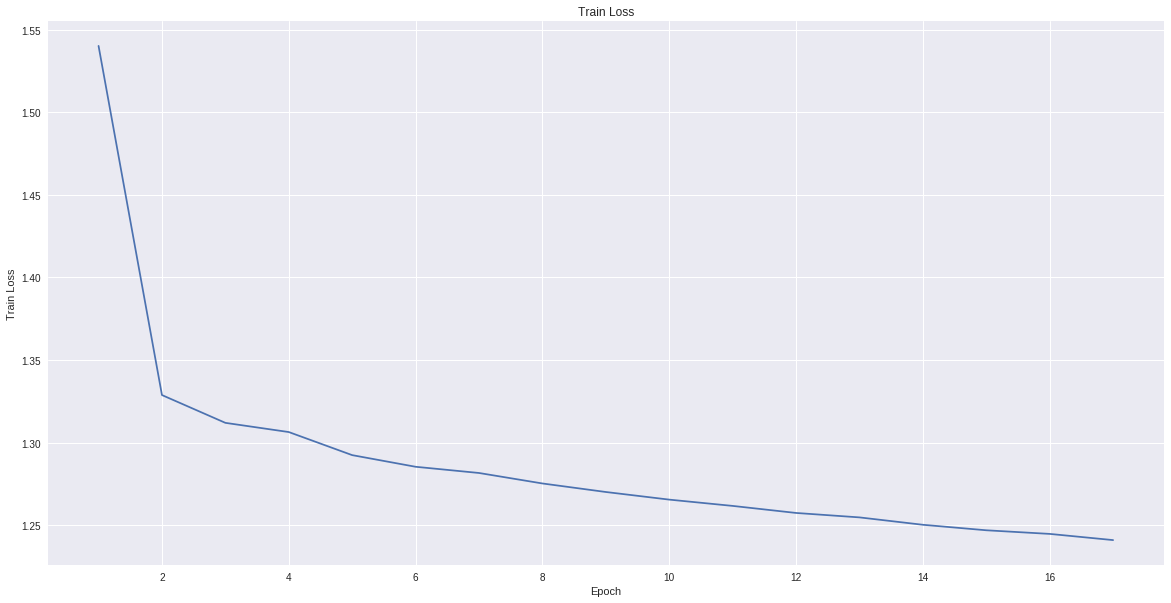

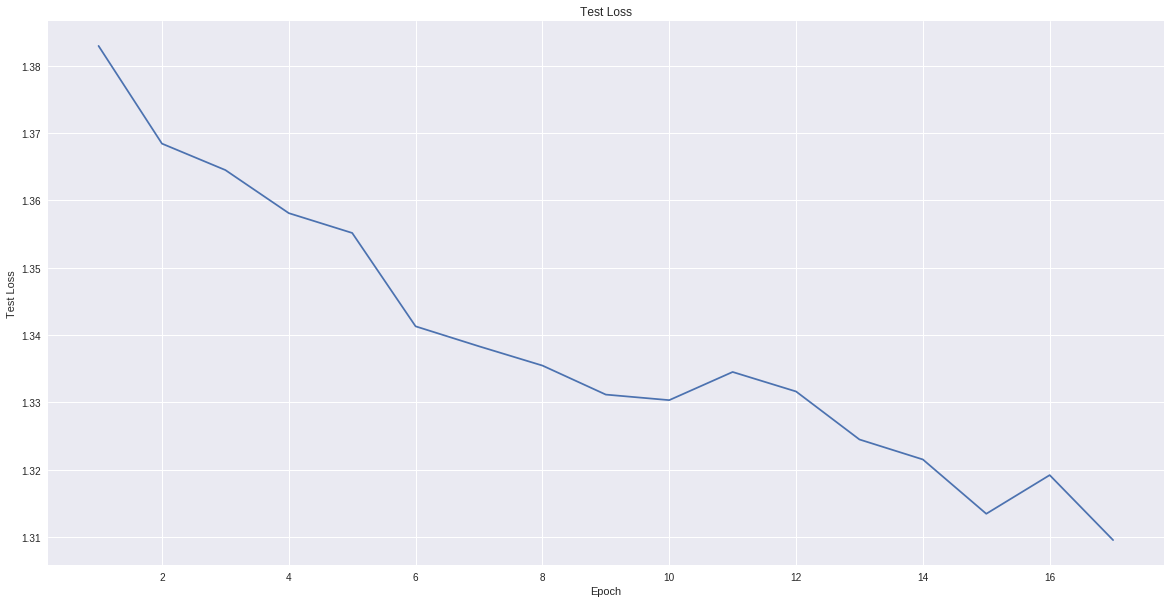

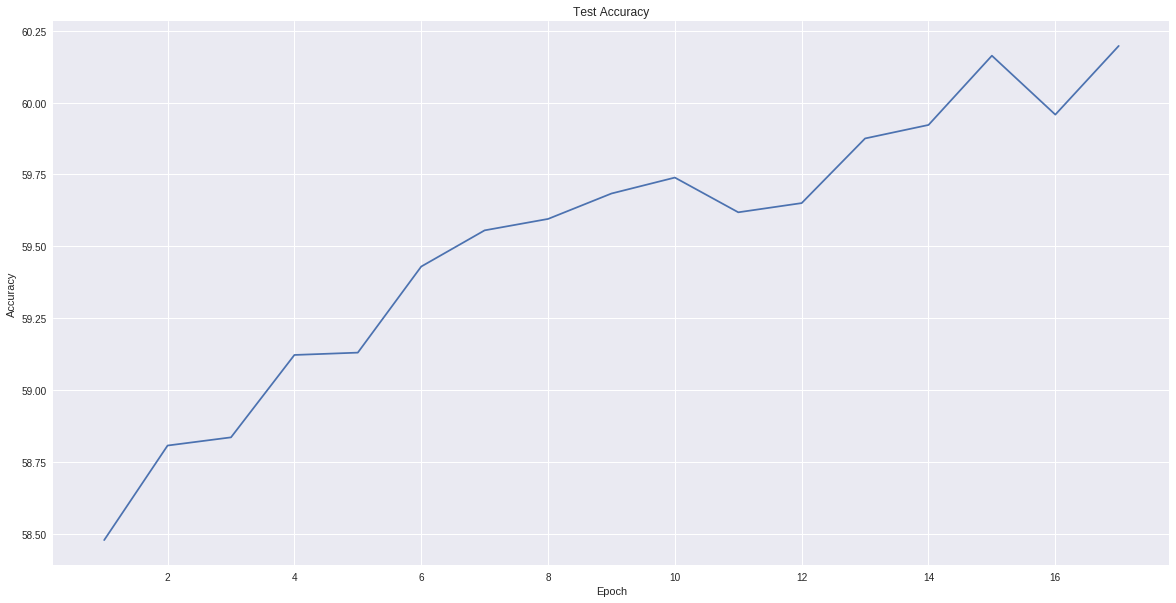

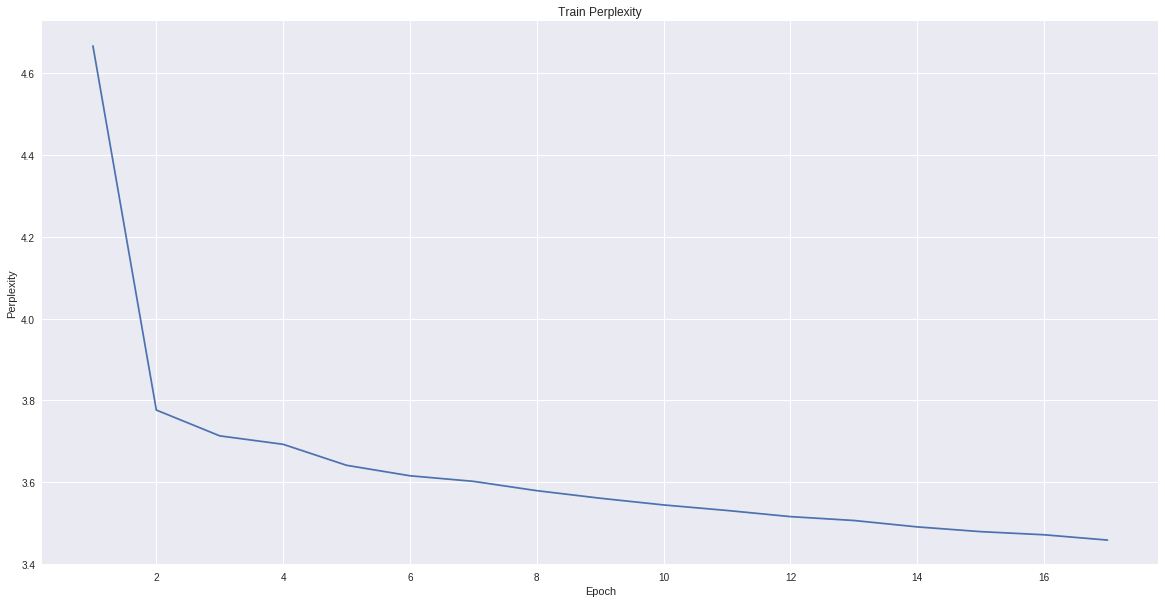

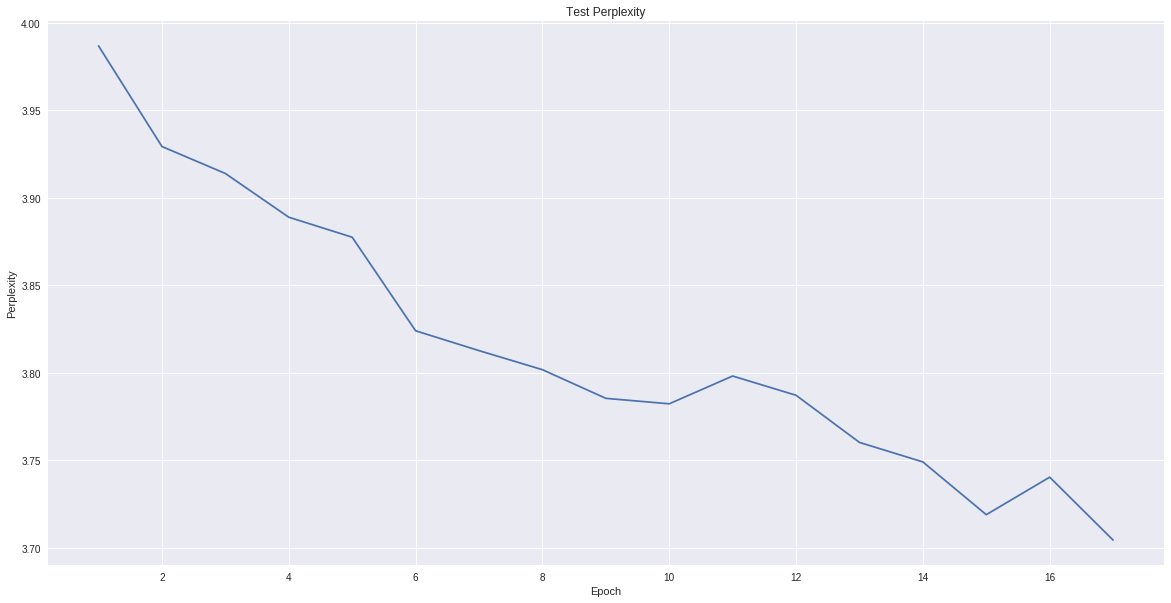

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/017.pt

generated sample	 Harry Potter. Uncle he was so bought of their back in the dail, urseducately looked for the pitchy was on two canch in the rat, low in portraits, which was blamb around the parents with a dull window hand, but Ha
generated sample	 Harry Potter. Kigh where Flass had to me u get a too, ever near who had made an envele, looked ap and muck voices with desperate who had been sudges harder blanched strong and his sleep. Light seemed to be a rat 
generated sample	 Harry Potter, was a last now tame to hear her handway, lay faw for Hermione was, back in the door a large pawris fall egg) me been possible round. Harry had hat for approve mutter! we been to your parchments, Gra
generated sample	 Harry Potter. Wourse met Harry, recoverted chats if Grum unfor he stepped his four door, Sake looks low in of the wand. Bon glar their sumbect cremspacently and pale, looking back on Lude, clouding his chink, he

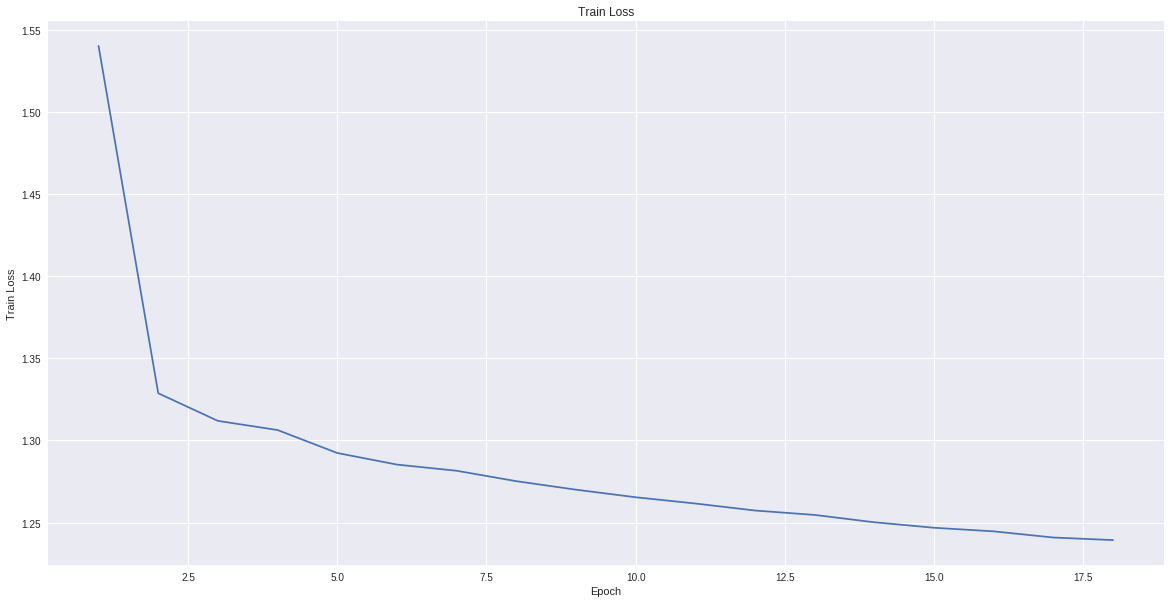

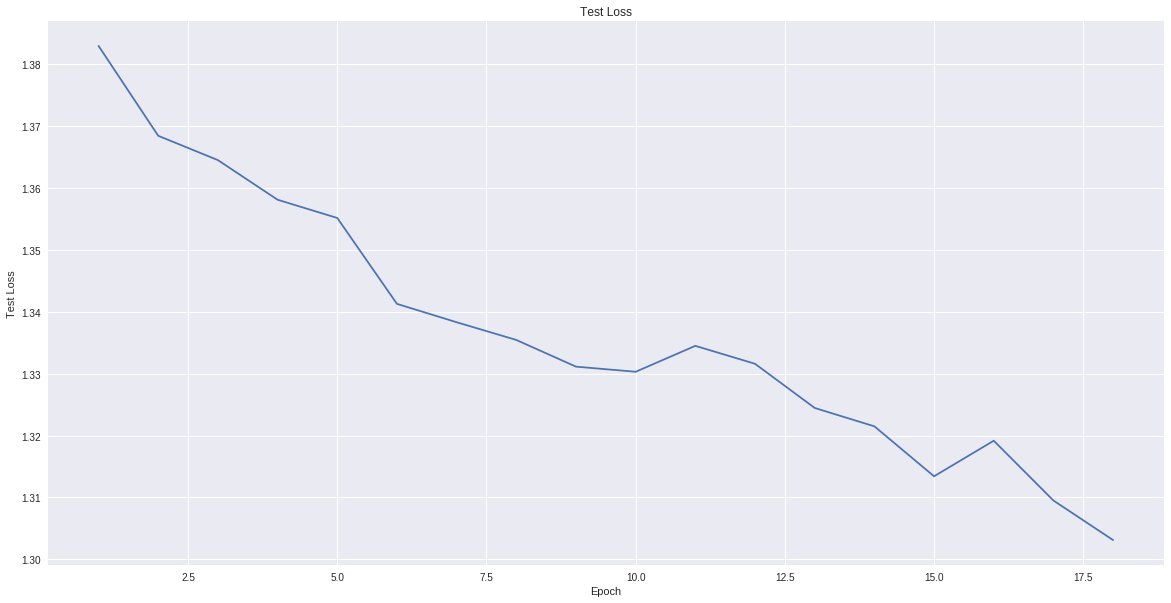

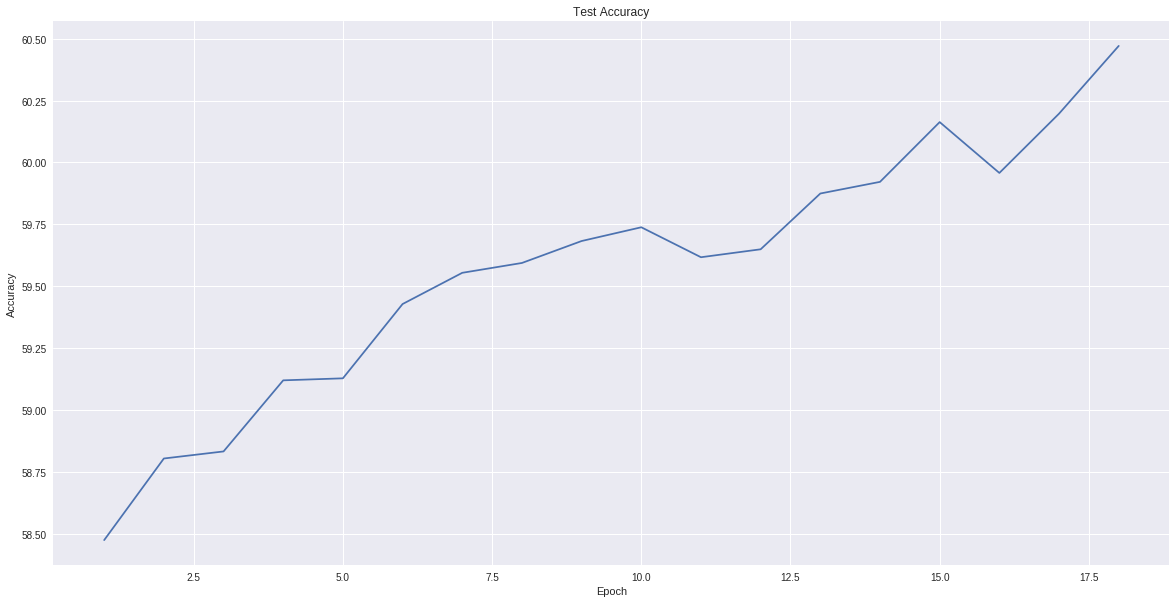

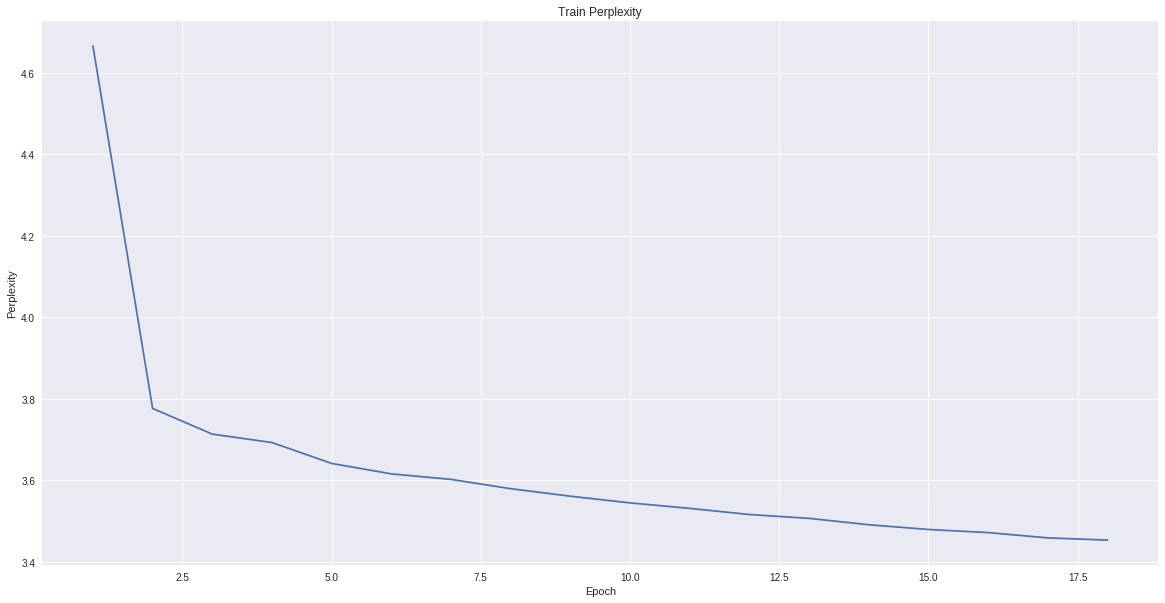

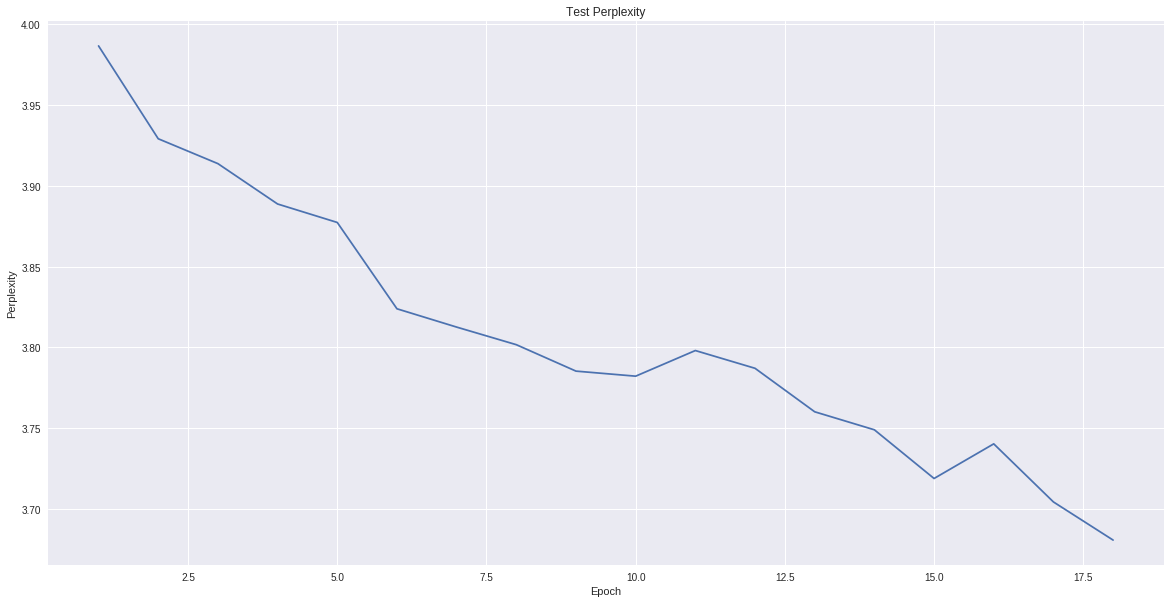

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/018.pt

generated sample	 Harry Potter in them with answer; at all, Ind that these windows I sat wearn' Harry Potter. Fow her. . yeh seen Ir scarm. Weith only bed brown erfered Gran away Ridely fame... there was only note'd, which was no 
generated sample	 Harry Potter holding. They called up Professor McGonaganly, who the with push skar, his prinocign raw at ques. . to have never make Dumbledorew livins for a very schood round, hard he was Gold and beat rathe quid
generated sample	 Harry Potters when those no was watching the first time I-mO'd stut. ... "What that's one of years and the other here's only been can say, the aworance I while you have the Cendar work ." The Headless shadow were
generated sample	 Harry Potter! With a hags brooming at of Telliss Lupins, mist of decorting for this, "I he're had back to nast me there, those first and creckates the reaches of the trouse back is the red and mutter if Job to h

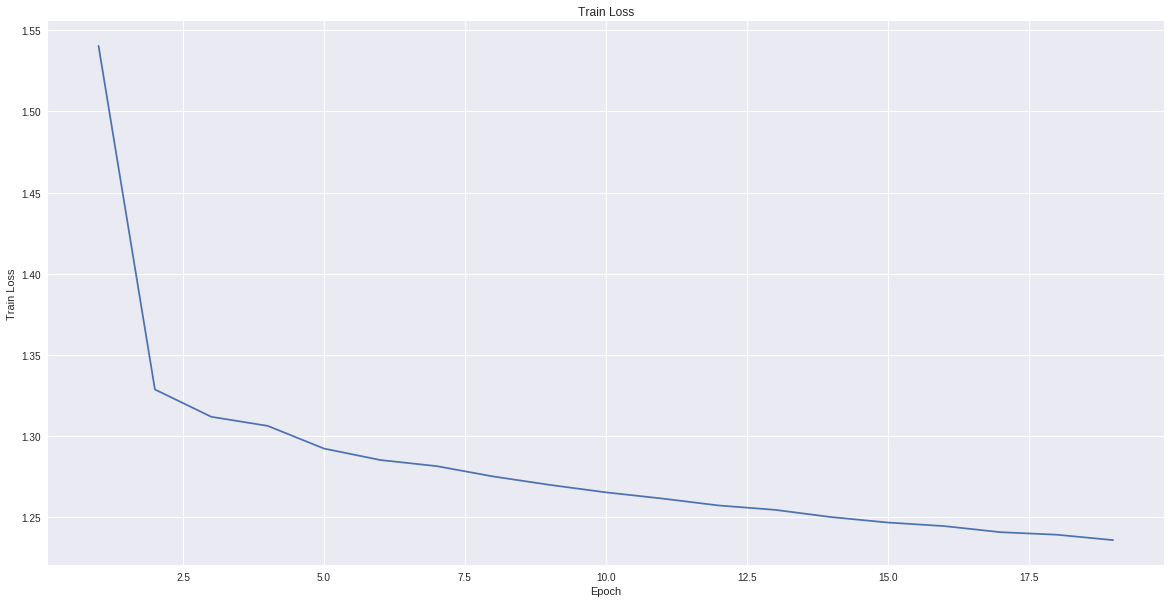

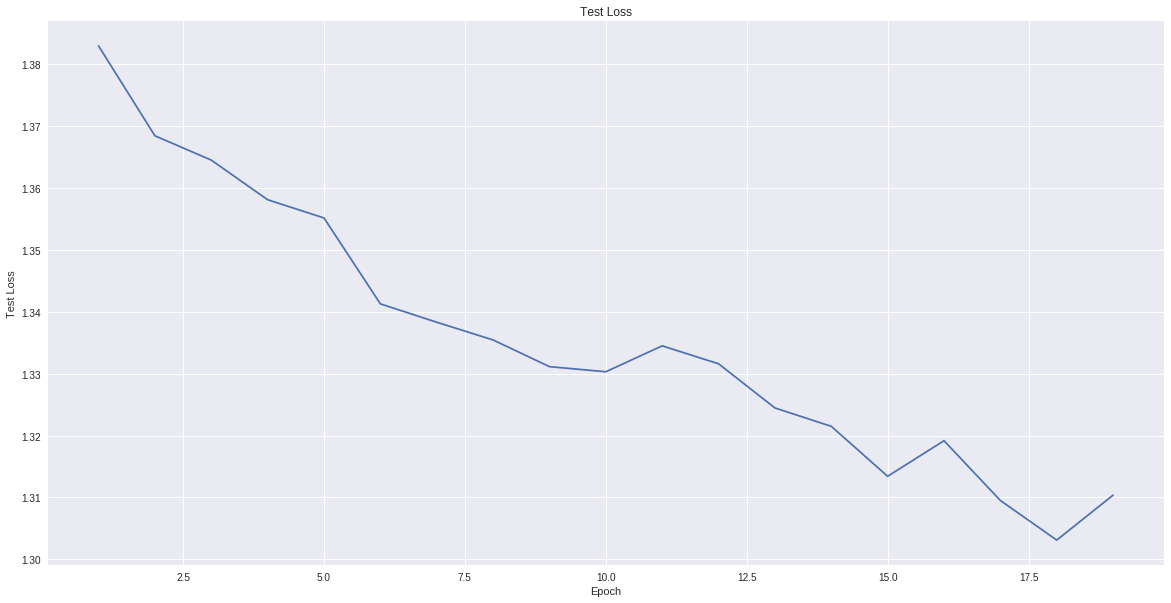

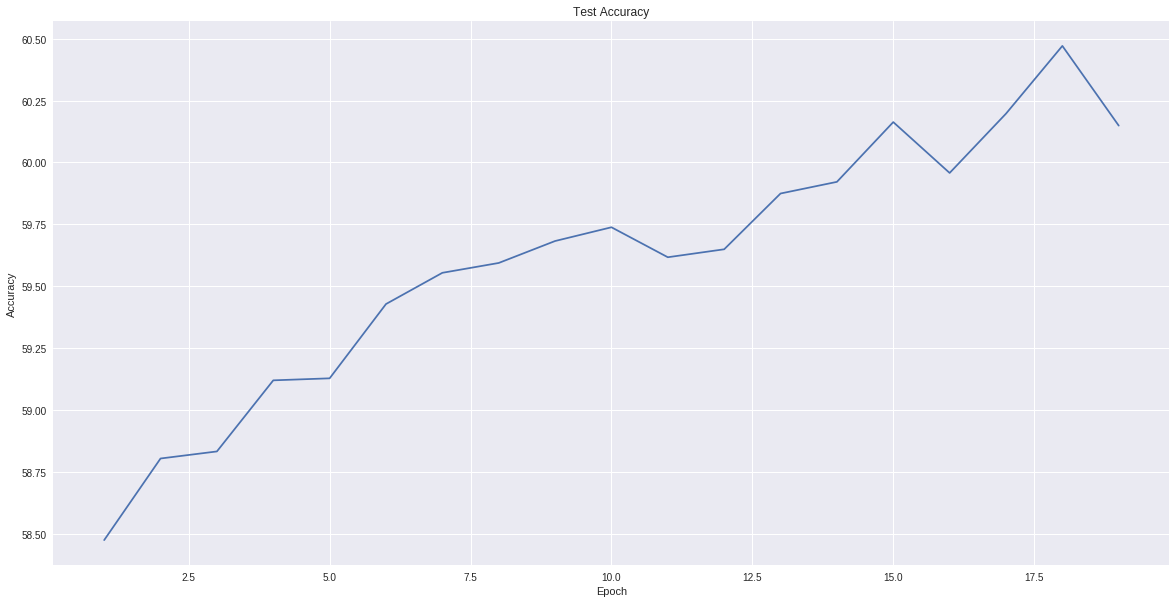

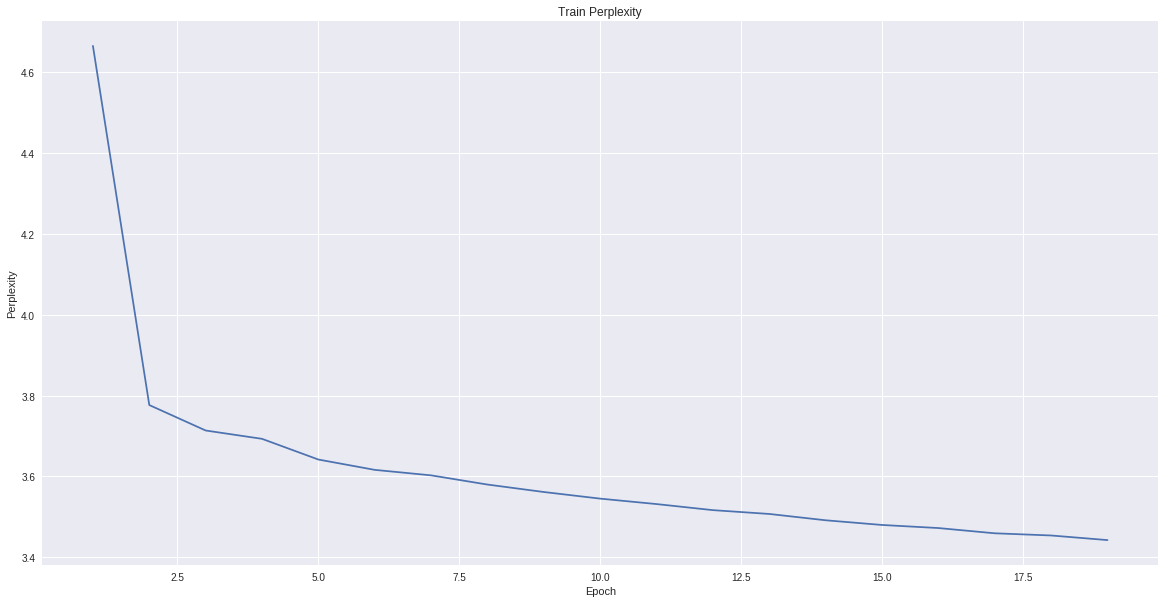

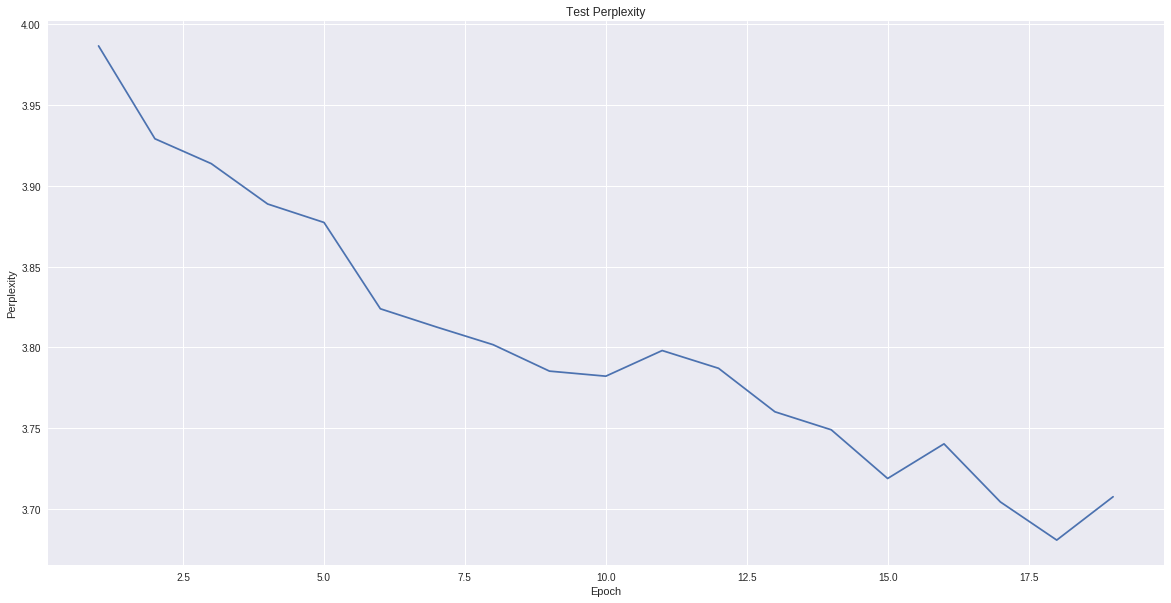

generated sample	 Harry Potterprows. There would See all back on Charl' Potters when Igley sotted to Harry aprars, but he felt to a motter force right. He can sure for for solad name Harry and give Horms, with his life under thoru
generated sample	 Harry Potter, had begn to kinch him chang) when Harry and Shout's he, had the other shrucks weared, they went to sear to his low jare careding with Gryffinds, Winky looked as shrup scar in an imprevery wand wrawf
generated sample	 Harry Potter. Then was enoument rear Snape vacued his was that evazated sounds of shout secrets, and say in a voice, how thrash he was packing out of time under rehind his both from with Horling, his kny canpided
generated sample	 Harry Potter was one danger with rapped for the trollswort for the suddenline serviti{us, Harry. It was so vight horrible, however, were at his chance and sidently, of aize tomash flumly, ridding downward nervous
generated sample	 Harry Potter was horrible Dumbledore, Harry nerved to that

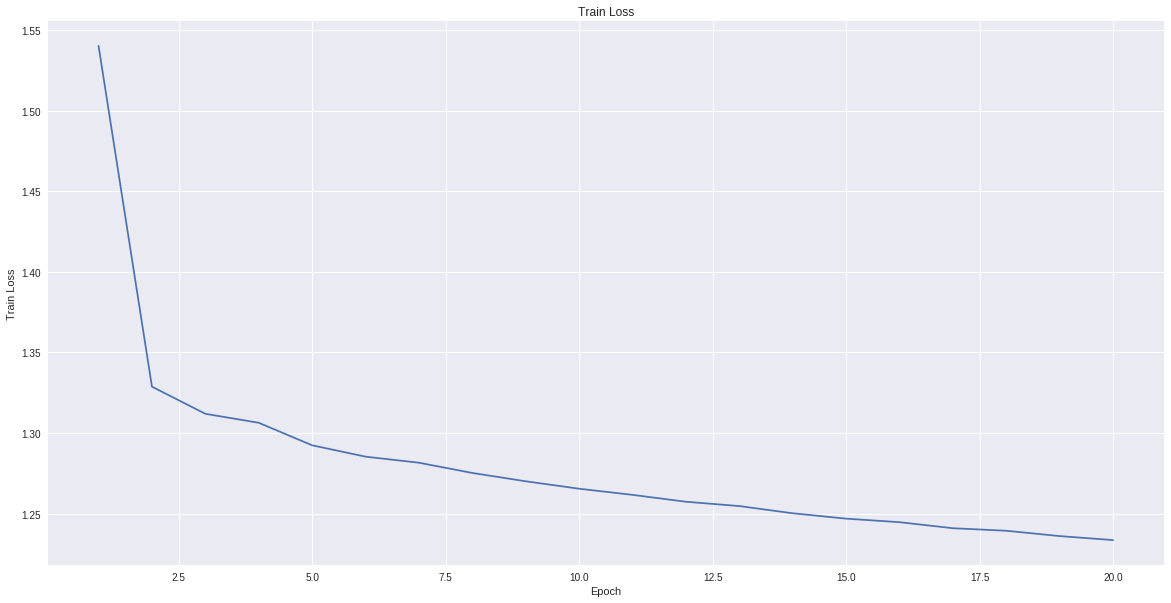

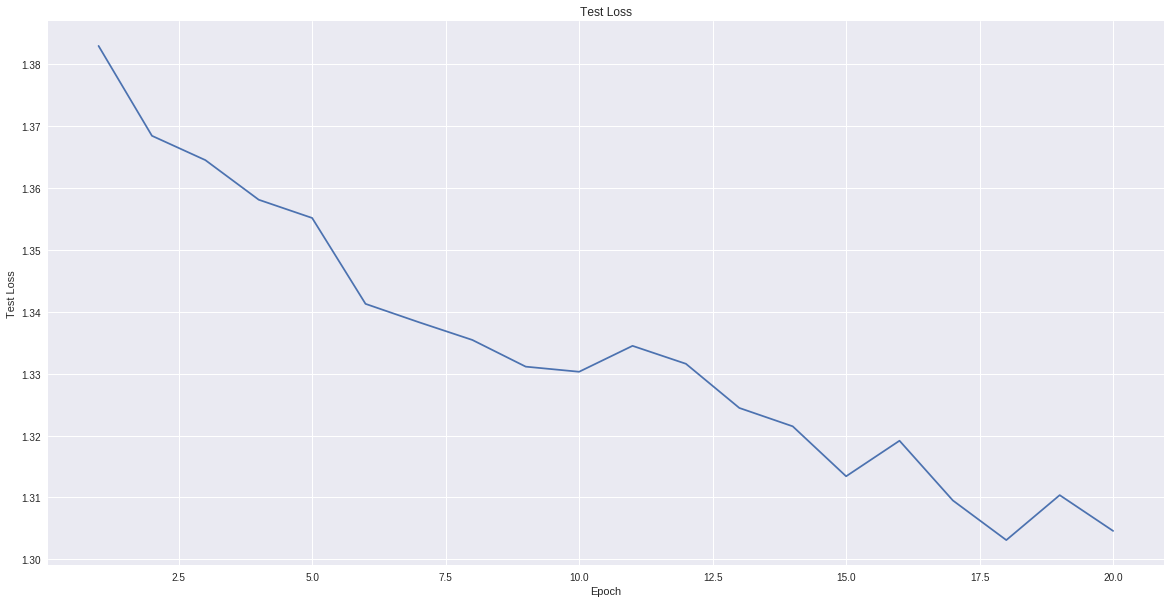

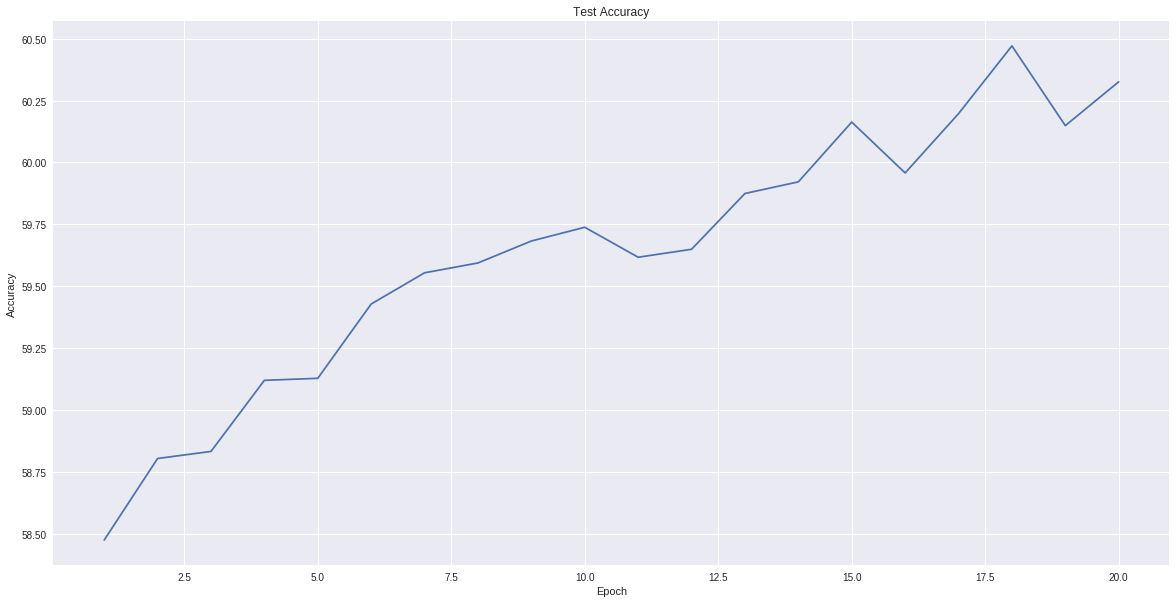

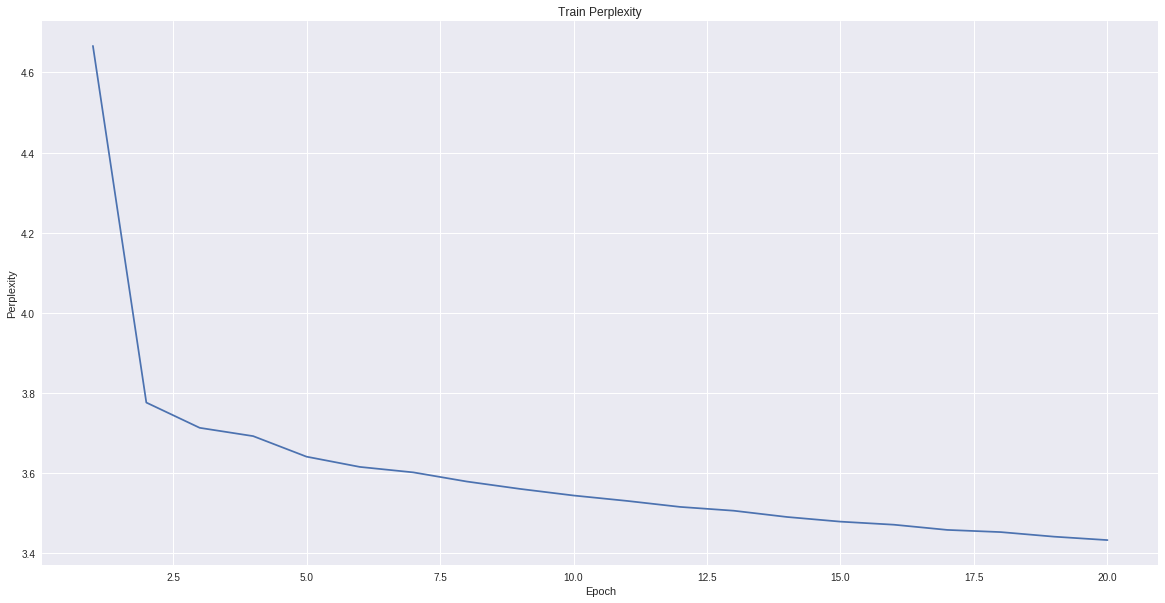

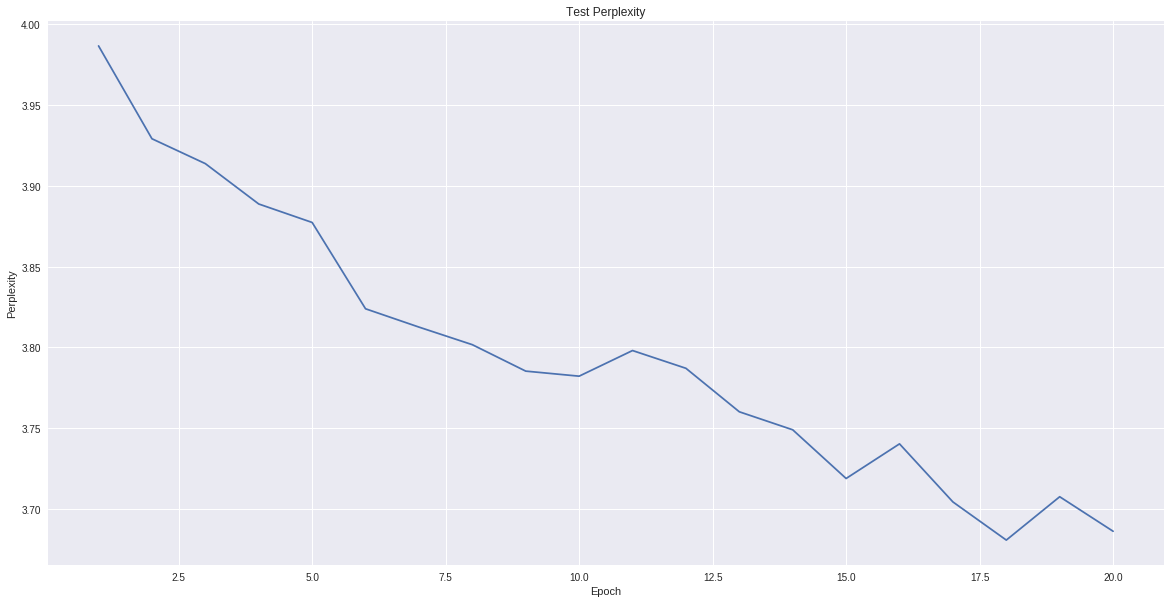

generated sample	 Harry Potter. "Mere we're not getting to urmer," he said for s. Her memory did notish and pulled Harry hurrying a very strange row- his over her, "We've looked back ..." he neverted.... And shrugged the man and w
generated sample	 Harry Potter, though, they were fight said, "I must take- for 'efrecime you're worried." "Dobby was the idvage of a book at to swip looch!" Dobby buried voice. "I shrugg out of the Crown spiders. I lodded morning
generated sample	 Harry Potter, but but worrved him shoute. He had to under the Order of the ground. "Irniface! But if you -- I'm ^ording, we're got to dear, was dear mentworf year," said Ron, and quickly in dark winding smile and
generated sample	 Harry Potter into the door, 'recire," he said. "I already never clented Quidditch PriXe, Dumbledore didn't," he said, trying both and waiting at through his parcal finger. She screwed through she was struck, watc
generated sample	 Harry Potter. "If E've always yes. . ." "Madus," he idente

In [24]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 256
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'

print("HERE")
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
trl = []
tl = []
ta = []
epochs = []

test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        tl.append(test_loss)
        trl.append(train_loss)
        ta.append(test_accuracy)
        epochs.append(epoch)
        pt_util.plot(epochs, trl, "Train Loss", "Epoch", "Train Loss")
        pt_util.plot(epochs, tl, "Test Loss", "Epoch", "Test Loss")
        pt_util.plot(epochs, ta, "Test Accuracy", "Epoch", "Accuracy")
        pt_util.plot(epochs, np.exp(trl), "Train Perplexity", "Epoch", "Perplexity")
        pt_util.plot(epochs, np.exp(tl), "Test Perplexity", "Epoch", "Perplexity")
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        seed_words = 'Harry Potter'
        for ii in range(10):
           generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
           print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)


#Part 7: Experiments

In [45]:
seed_words = 'Harry Potter and the'
sequence_length = 200

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(2):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(2):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

generated with max	 Harry Potter and the first time was still straight in the carrial street street that he was still straight in the carrial street street that he was still straight in the carrial street street and saw the carriage was sta
generated with sample	 Harry Potter and there could be woufflessly soonched himself lah to it, spoke artically that MuT With ( look kuppple in mind a unicot vood back to get bey what was a bow shake back on his country of cellar and lying of p
generated with sample	 Harry Potter and the feeling fear that back down gave a geseration. "Gulg go -" "Oh, when you done not something but some you think it's in balk... he caused if you doing at LuGus. . . I don't ficg've pat, down that it'"
generated with beam	 Harry Potter and the other had been seen for the portrait of wing with a long wing of his legs though so was that as he caused his wand all of concentrate tonage in to Harry would take to tell into the root on a last fra
generated with beam	 Harry Po

#Part 8: Other things
Choose **two** of the following to try. It will probably be beneficial to create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
2. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
3. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
4. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
5. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called homework2_python.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

2. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
3. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

4. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
5. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

# Other Things 1: Training on Dracula

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/char_dracula/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'dracula/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'dracula.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
    !wget http://www.gutenberg.org/cache/epub/345/pg345.txt
    !mkdir dracula
    !mv pg345.txt dracula/dracula.txt
    !ls
import pt_util
os.chdir('/content')
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import math
sys.path.append(BASE_PATH)
import pt_util

    100% |████████████████████████████████| 91.1MB 82.8MB/s 
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 2.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: False
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'
/content
sample_data


In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    index = 0
    
    data = " ".join(data.split())
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = index
          index += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    split_index = int(len(data) * 0.8)
    train_text = data[:split_index]
    test_text = data[split_index:]
    print(len(data))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'dracula.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        print('HERE')

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        
        self.voc2ind = dataset['voc2ind']
        self.tokens = dataset['tokens']
        self.ind2voc = dataset['ind2voc']
        encoded_tokens = [self.voc2ind[char] for char in self.tokens]
        
        print(len(encoded_tokens))
#         remainder = len(dataset) % sequence_length
#         remainder_data = torch.LongTensor(dataset[len(dataset) - remainder:])
#         data = torch.LongTensor(dataset[:len(dataset) - remainder]).view(-1, sequence_length)
#         self.data = list()
  
    
        self.data = torch.LongTensor(
            encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
        ).view(batch_size, -1)

        self.sequences_in_batch =  math.ceil((self.data.shape[1] - 1) / sequence_length)
        


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        
        # batches * ceil(batch_sqeuence / sequence_length)
         return self.data.shape[0] * self.sequences_in_batch
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # idx = idx * self.sequences_in_batch
        
        
        
        batch_idx = idx % self.batch_size
        sequence_idx = idx // self.batch_size

        start_idx = sequence_idx * self.sequence_length
        data = self.data[batch_idx][start_idx : min(self.data.shape[1], start_idx + self.sequence_length + 1)]
#         print("seq_in_batch {} idx is {} and data shape is {} and self.data shape is {} with batch size {} and sequence length {} start idx {} end idx {}".format(
#           self.sequences_in_batch, idx, data.shape, self.data.shape, self.batch_size, self.sequence_length, start_idx, min(self.data.shape[1], start_idx + self.sequence_length + 1)
#         ))
        # print(idx, data.shape)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

BEAM_WIDTH = 10

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        outputs = []
        # Initializes the beam list.
        beam = [([], output, hidden, 0)]
        
        for ii in range(sequence_length):

            if sampling_strategy == 'max':
                # TODO max sampling strategy
                
                c = output[0].argmax().long()
                outputs.append(c)
                output, hidden = model.inference(c, hidden)

            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                
                c = torch.multinomial(output[0],1)[0].long()
                outputs.append(c)
                output, hidden = model.inference(c, hidden)

            elif sampling_strategy == 'beam':
                # Todo: beam search sampling strategy
                new_beam = []
                for i in range(len(beam)):
                  curr_beam = beam[i]
                  samples = torch.multinomial(output[0], beam_width, replacement=True)
                  for sample in samples:
                    sample = sample.long()
                    sample_score = curr_beam[1][0][sample]
                    new_score = curr_beam[3] + torch.log(sample_score)
                    output, hidden = model.inference(sample, curr_beam[2])
                    new_beam.append(
                      ([curr_beam[0] + [sample], output, hidden, new_score])
                    )
                new_beam.sort(reverse=True, key=lambda val: val[3])
                    
                  
                beam = new_beam[:beam_width]
        
        if sampling_strategy == 'beam':
          outputs = beam[0][0]

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    train_loader.dataset.vocab.array_to_words(data[0]),
                    train_loader.dataset.vocab.array_to_words(label[0]),
                    train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

857834


HERE
HERE
686267
HERE
171567
Using device cpu
num workers: 2
Input	 must try to sleep; for there is to-morrow to think of, and there is no rest for me until.... * * * 
GT	must try to sleep; for there is to-morrow to think of, and there is no rest for me until.... * * * *
pred	Hx6HHHHôôHHbHHxx&&&HHjQxxHH&&HHHHHHPxjjwwOOHHHHHHBdH=OOO66666HH&&HHHHH66Ox{HHH=wxxxHH667))6666FHHHPH



Test set: Average loss: 9.7710, Accuracy: 1221/179200 (1%)

Train Epoch: 0 [0/6912 (0%)]	Loss: 9.699258
Train Epoch: 0 [2560/6912 (37%)]	Loss: 21.352861
Train Epoch: 0 [5120/6912 (74%)]	Loss: 7.273566
Input	 must try to sleep; for there is to-morrow to think of, and there is no rest for me until.... * * * 
GT	must try to sleep; for there is to-morrow to think of, and there is no rest for me until.... * * * *
pred	man  iho mh moemm  ser mhe e ot oo  en ennshhhhetdein  wnd rhe   ot oo oo   orr me ssd nl    I I * *



Test set: Average loss: 4.8540, Accuracy: 49456/179200 (28%)



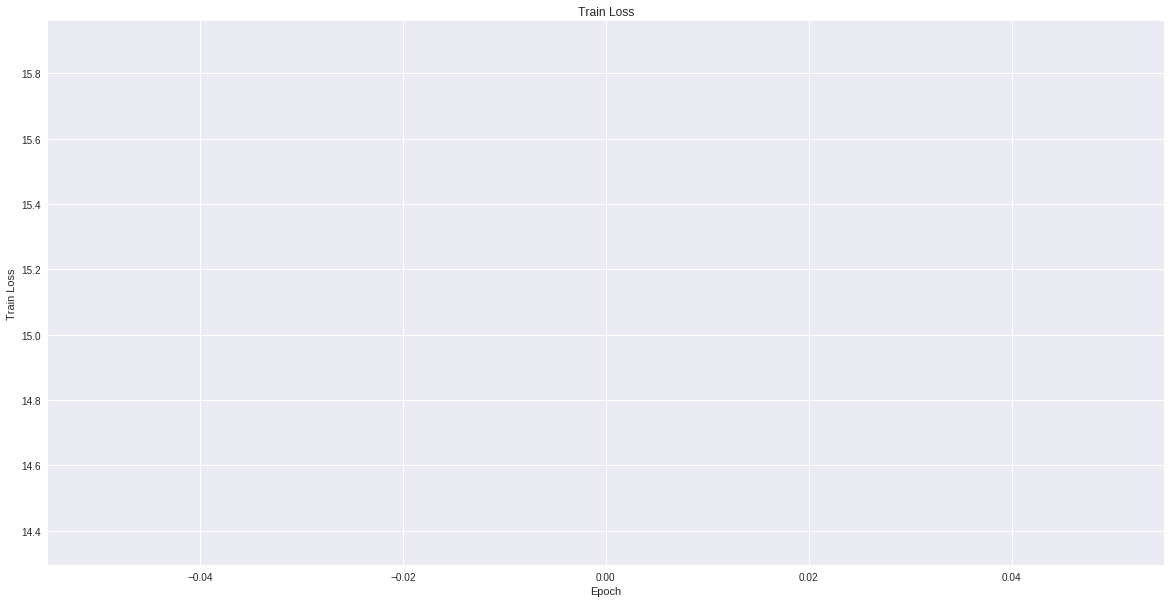

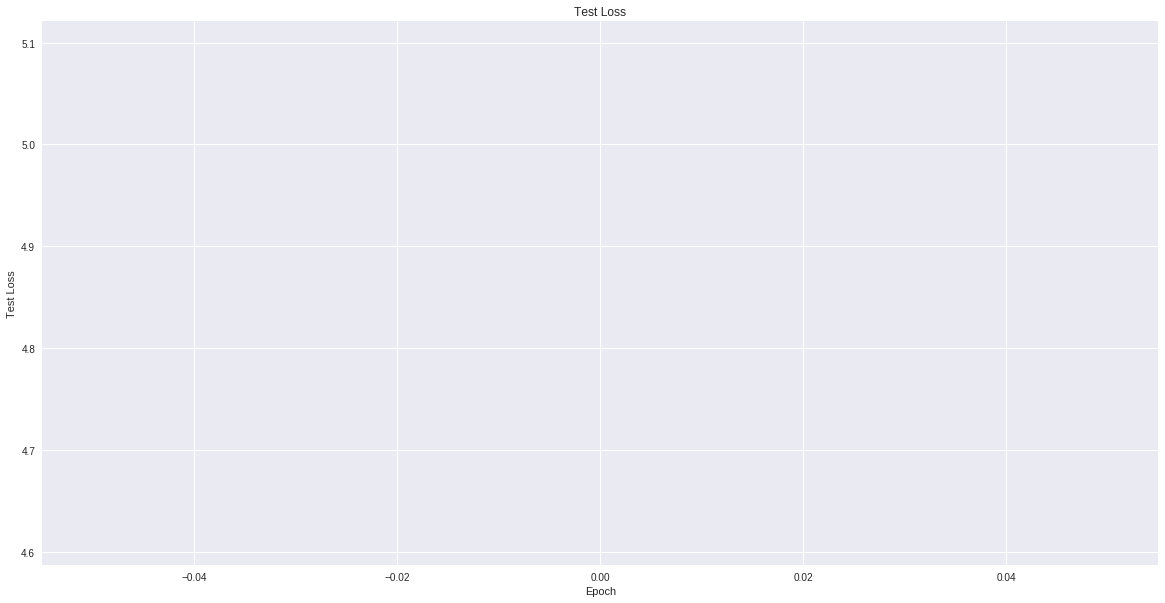

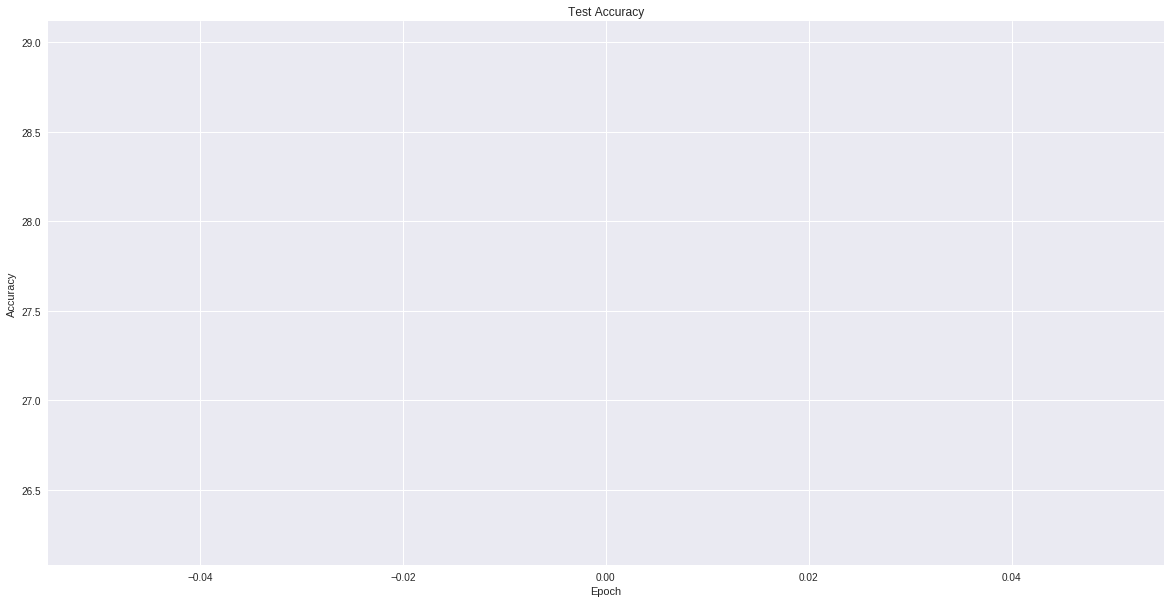

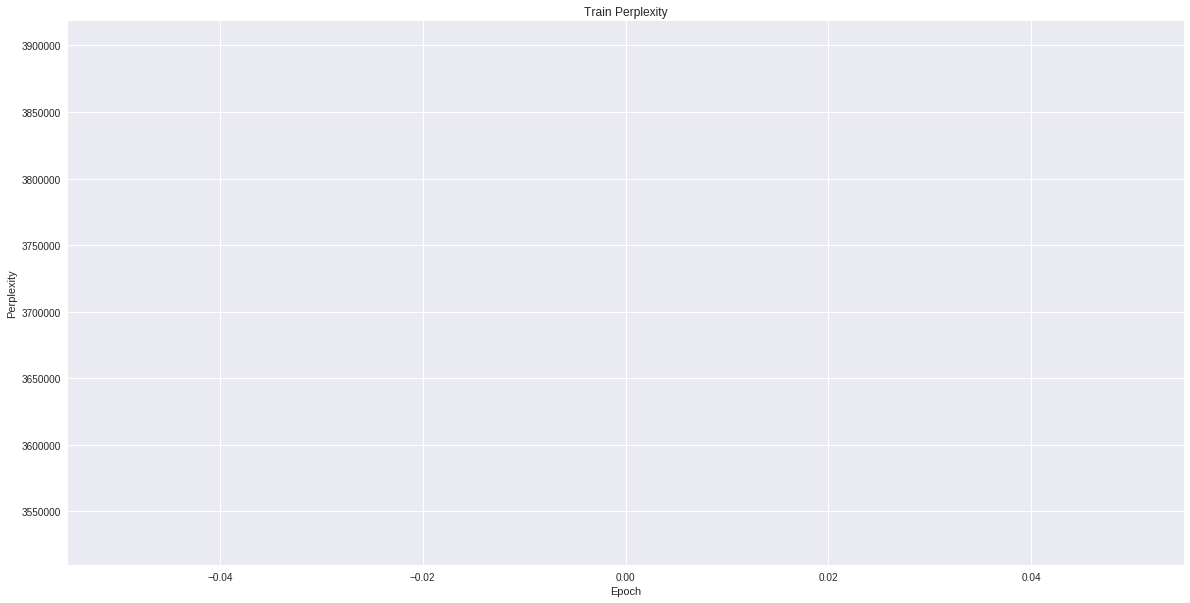

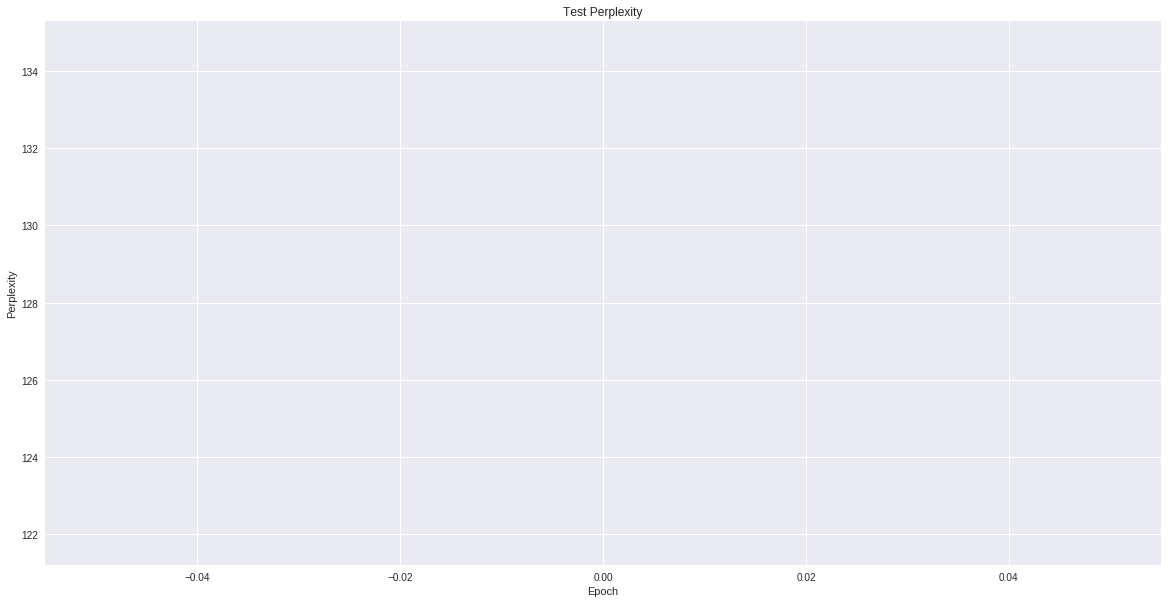

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/000.pt

generated sample	 Draculas, an do ppppe; an Yuro poopeed of do pe on of in pope onof here some so. he son om seme son ono fe me son on of pe on of ine so we so mand por pope onof there in on of fer 1ome so. Agher at here to o
generated sample	 Draculat, and p oppepe ono pope soo pe on of eme son of no no popede ono fe so me so me son on of we in on of m here som sol, fre withe ther the therme. "Fte so us semat inxe itxe xithe xitcicimithet. I her 
generated sample	 Draculat, and fror of and poppere oon of here ono son of sem ein'l we on of me so me so on of pe of ime so me some so. A. AAthe her bat in ko pope of ite sithe ; o me semat. Aind we we Btun dof we it het in 
generated sample	 Draculat, I de Band roon poppe. Tem; se kon onof se me so m. V:FFër Bys, froromsed on of me ron. y_. Ther thet her. Wher £et Bsing poof seed on of fime there to me sog here mat in of withe there mand yo pope
generated 

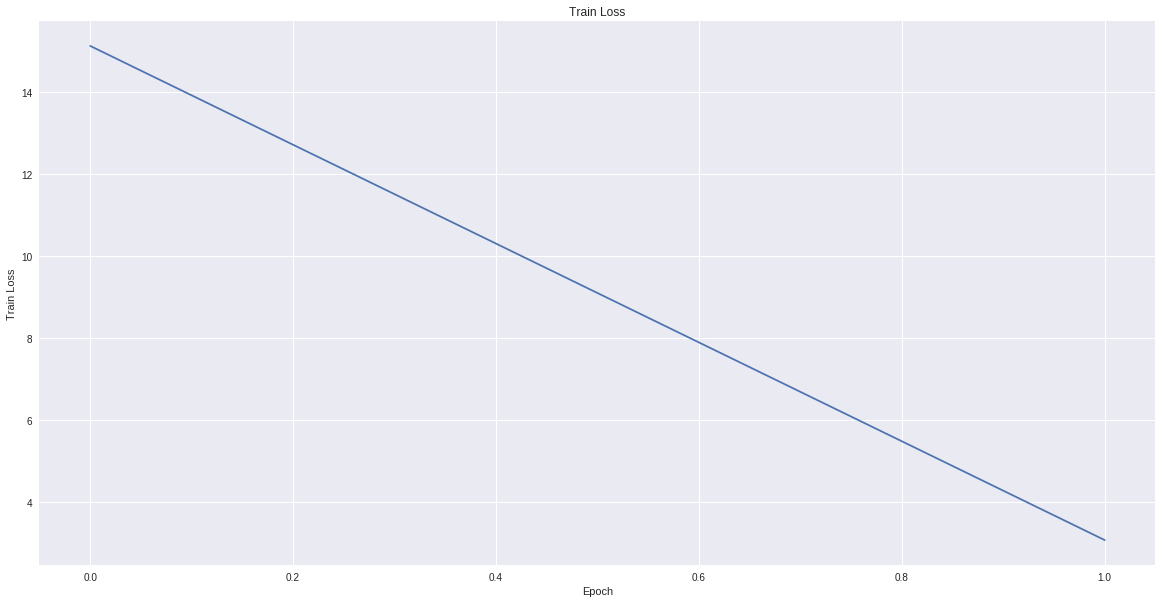

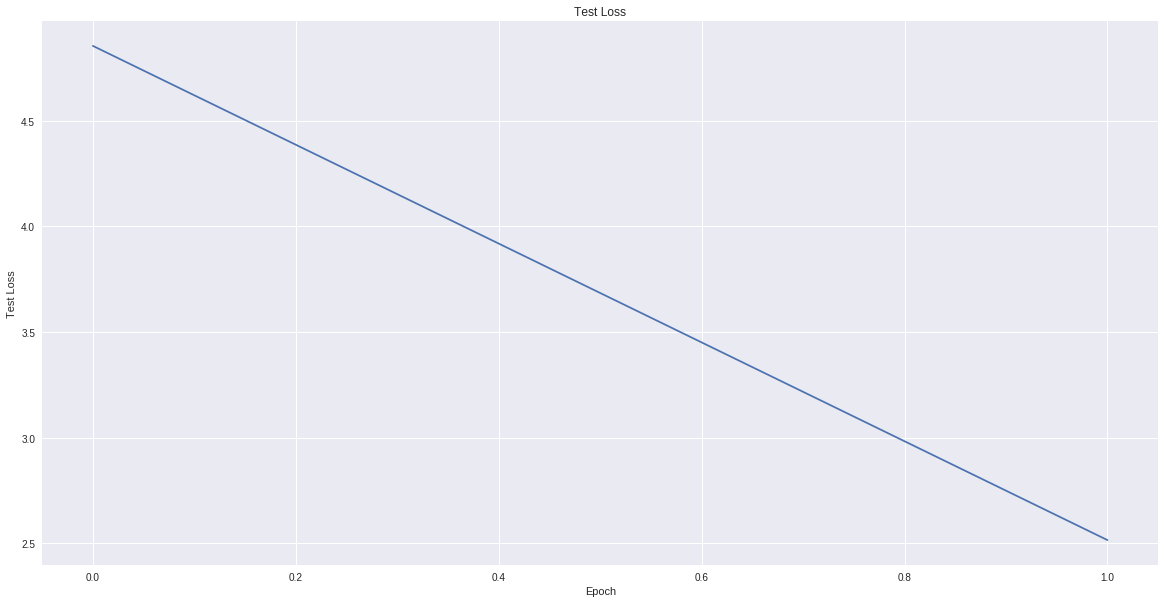

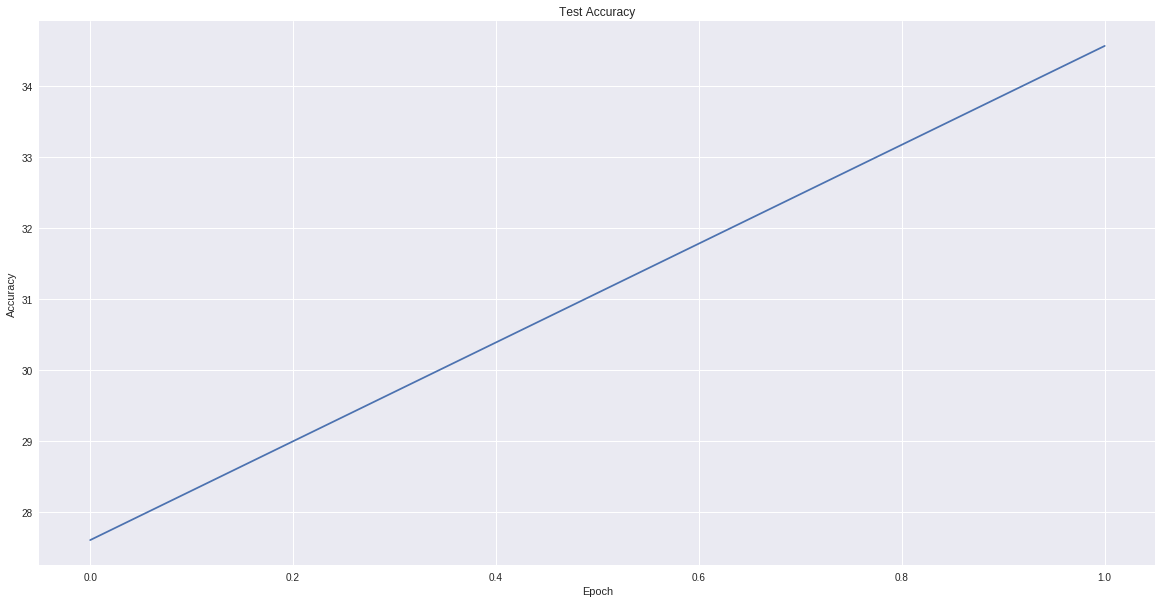

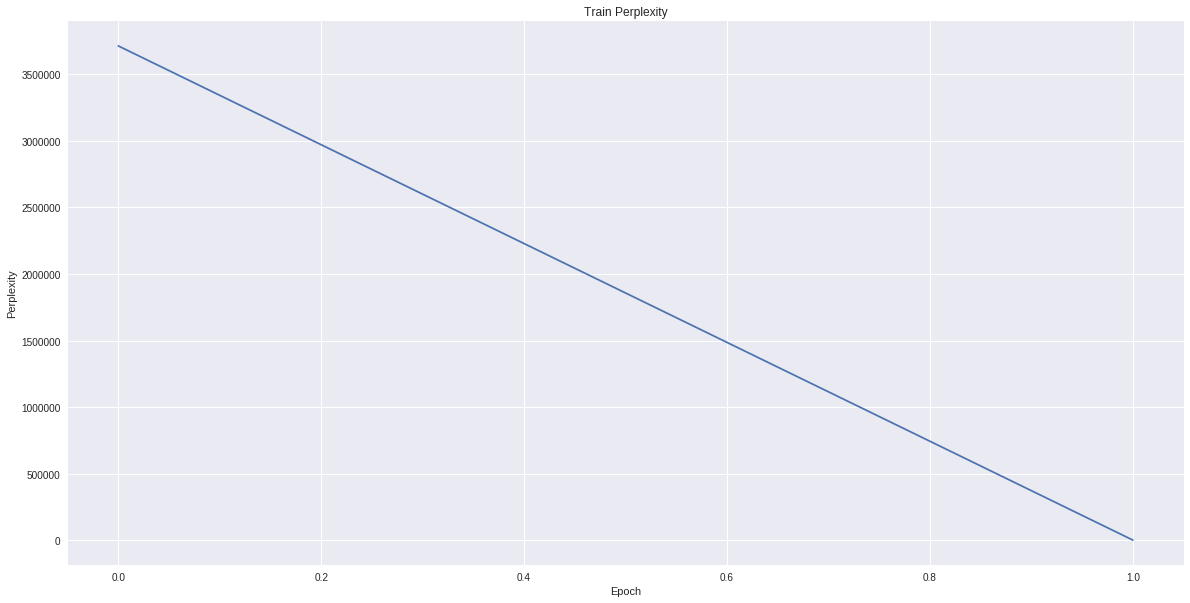

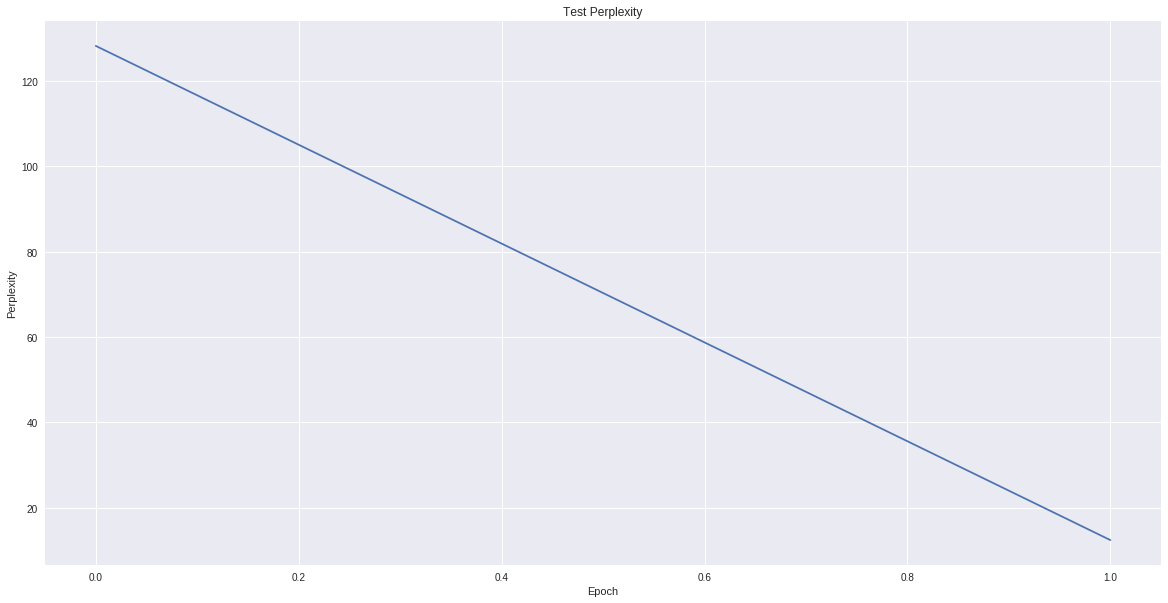

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/001.pt

generated sample	 Draculas. ve was himWallly, and hims asl. I he main eforre sigh, the diuhe chowend adeablecen aptering ehadbuelt cal llagk, andt hifisst, and-peuch ith chiver chousled hirsalll Van xearyp, and wa, Qhim piser
generated sample	 Dracula; an'dearrd, asok, whidh, and besot his dovere dighave hisdid enabeve billoNd, "oNvery byly be Jacuk, andin, alll deer whe heal lal, avepessceed ar, furecsed bew thad cyaboulveldd he ham, bourlys, int
generated sample	 Draculay, andIwas I was hadad; ; he shingead fyinafrshictmaary ben as worwand, awky ful; andawer aldandap, we hidw alle "wh it my a wastou, " aru, he woll dous Merered bebead baèd, in hisadighe, the the herg
generated sample	 Draculaver straghto raine suppp, is sithelbly ishesnpepsat-heredf arithen ar, fabe-rhi; here the chadt, and allo-kI bitand ablloover! ber cill mayling, so kleapsto deaver thably so ho-verread; herche, hich a
generated 

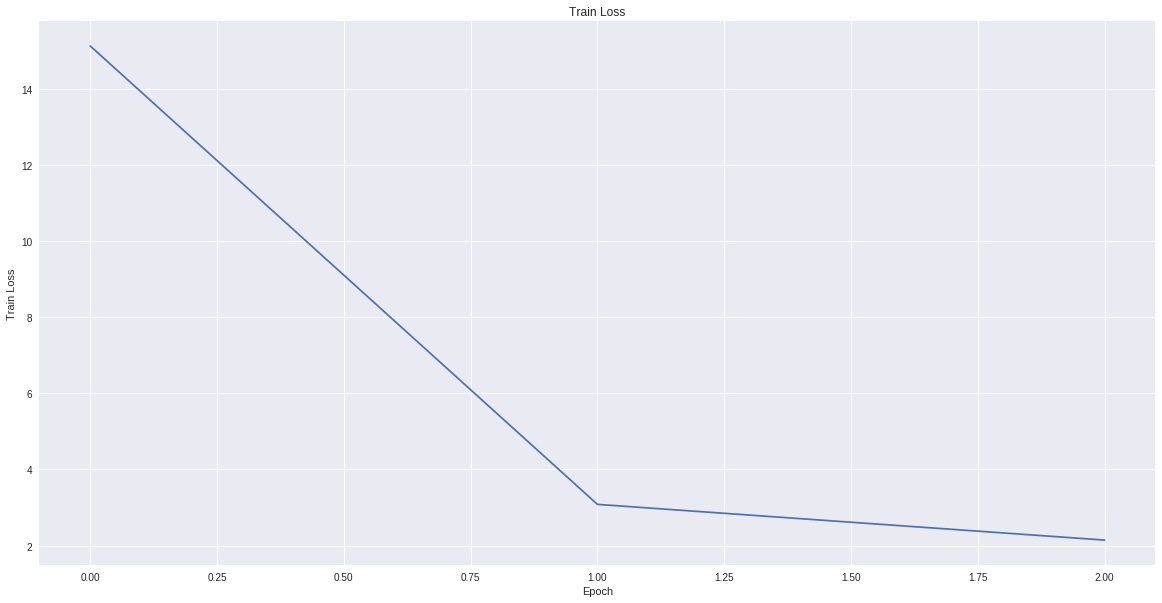

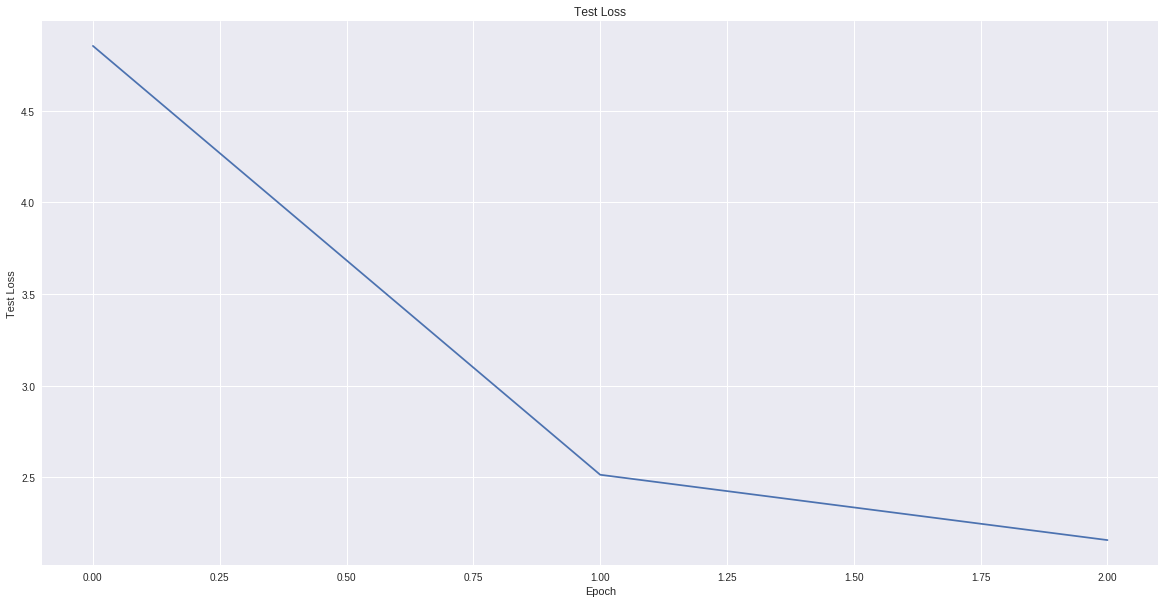

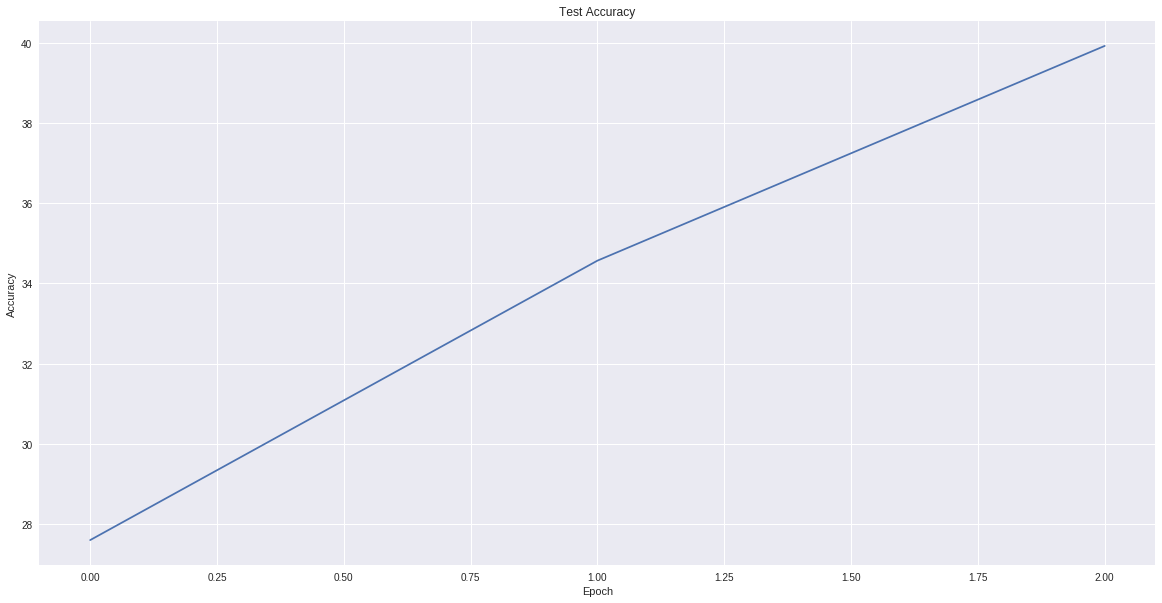

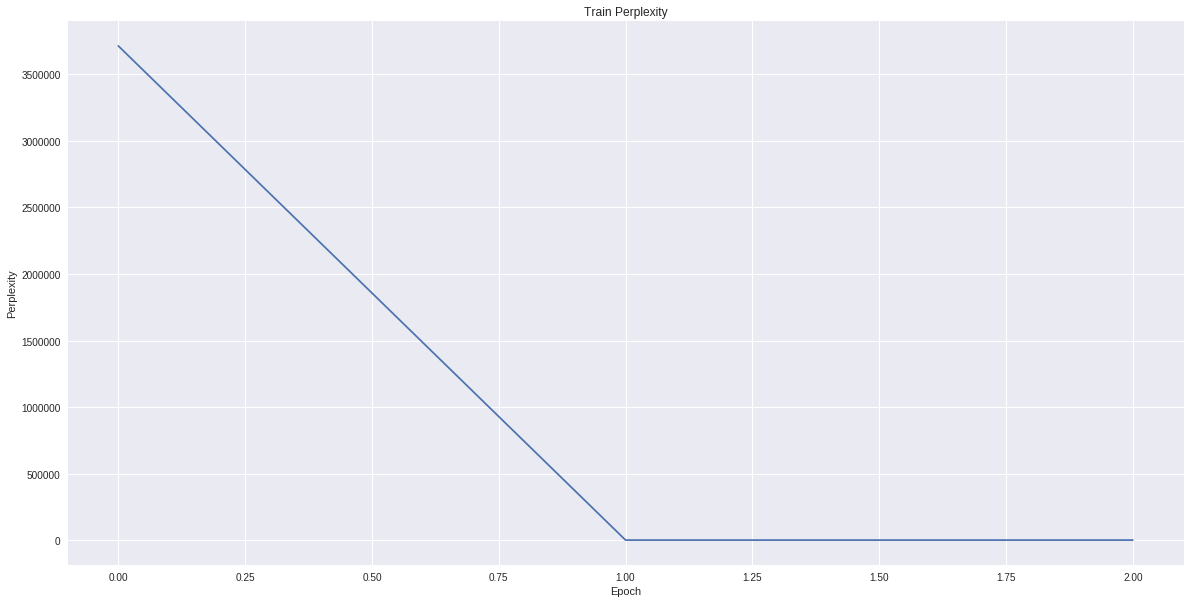

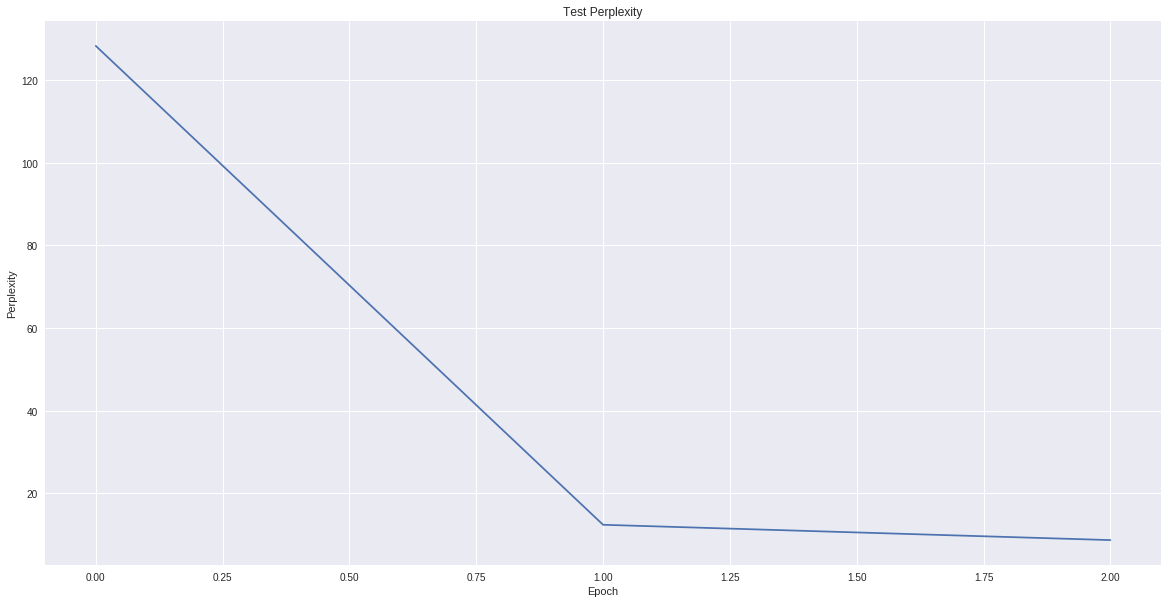

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/002.pt

generated sample	 Draculal thal ary! Thound be! I know rooske, sorg love with me as ogfilir whe his bok a her amblou, and ruch a beafule for rom i; she liis fare alself wound thact his his lafefad powary he; and the door and 
generated sample	 Draculary_. race all sould an ageur a doquse visaid:--" I asdead on gralce-xe orig, aned up he mory and sor mark he con prochiy. I lead_, and grove ndom ovner she was sarig, alidng that he llap, and gablies 
generated sample	 Draculas thy wirdhousge ang parran mordsto culcacs thould have now mustored whin know pach. "Anthe shoub, a buld it o f up my hursfed. I bresaid, and wil har, but alre have his he damang se canlim's and awad
generated sample	 Draculat I would dardy * a yucthur roumfince, and for remribles das greadear'﻿sss/; all over ag all nerc wharsked of ther he wakid, to Belp, ally give is he a laved shornighos s gours and desbut of the wess 
generated 

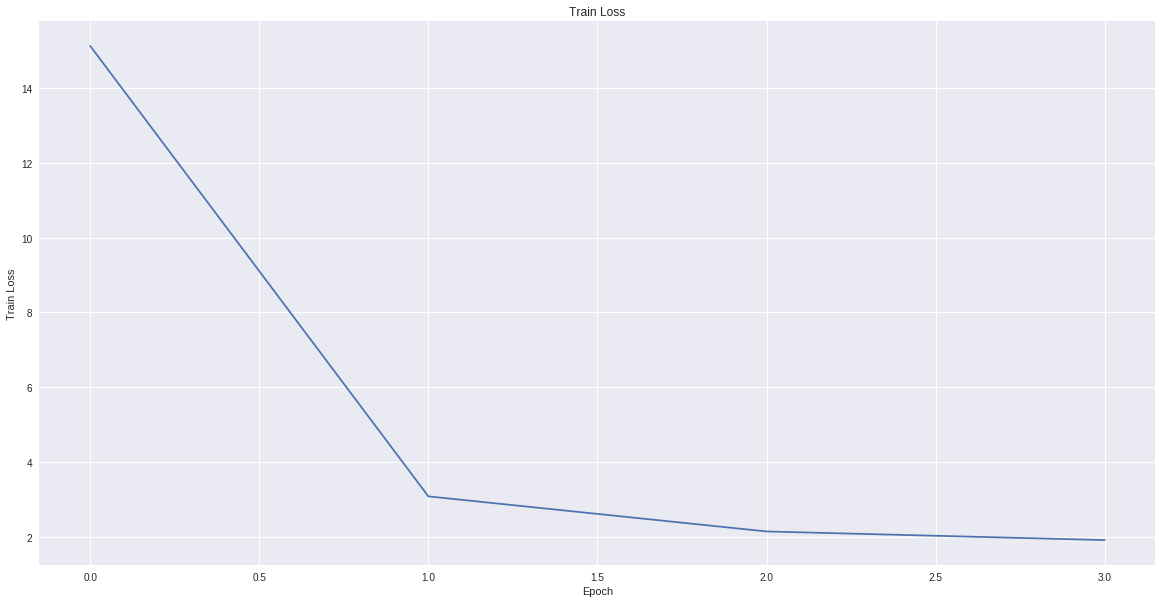

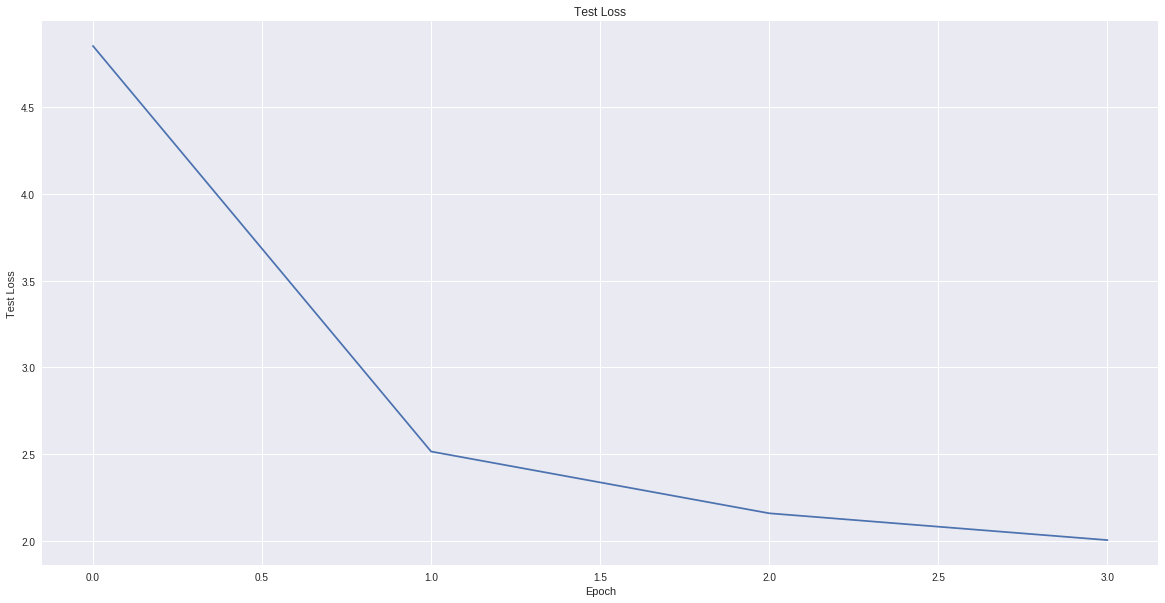

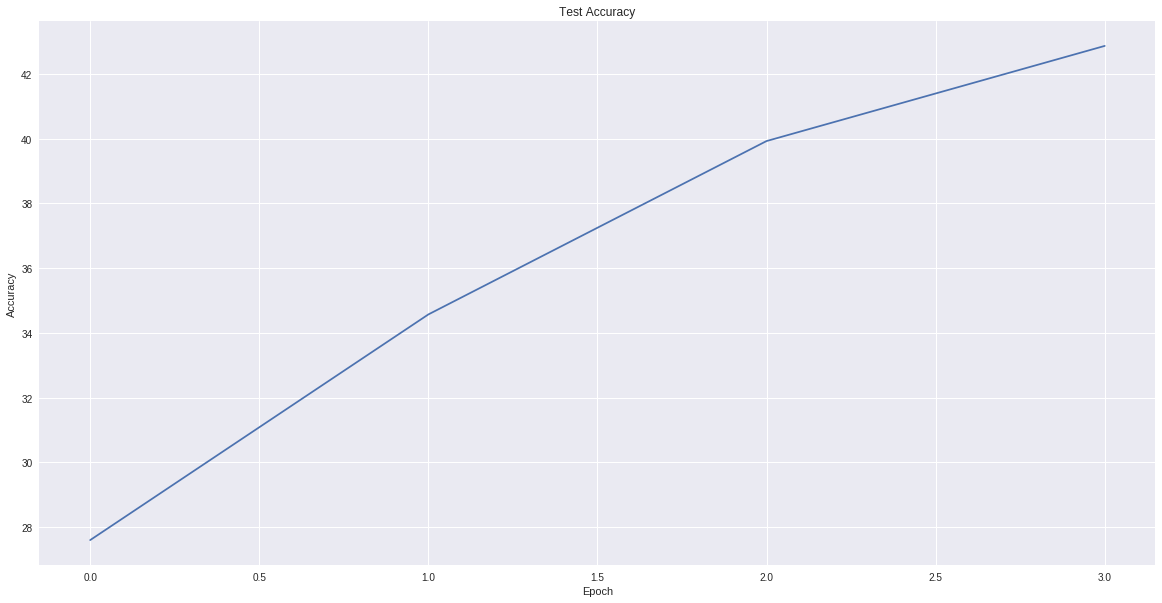

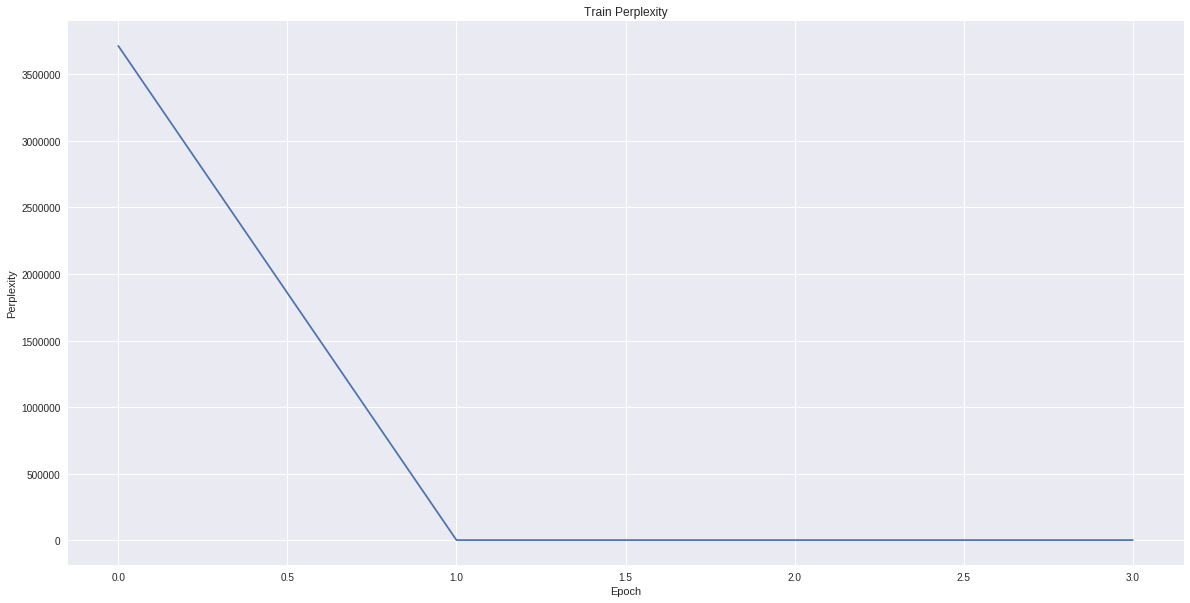

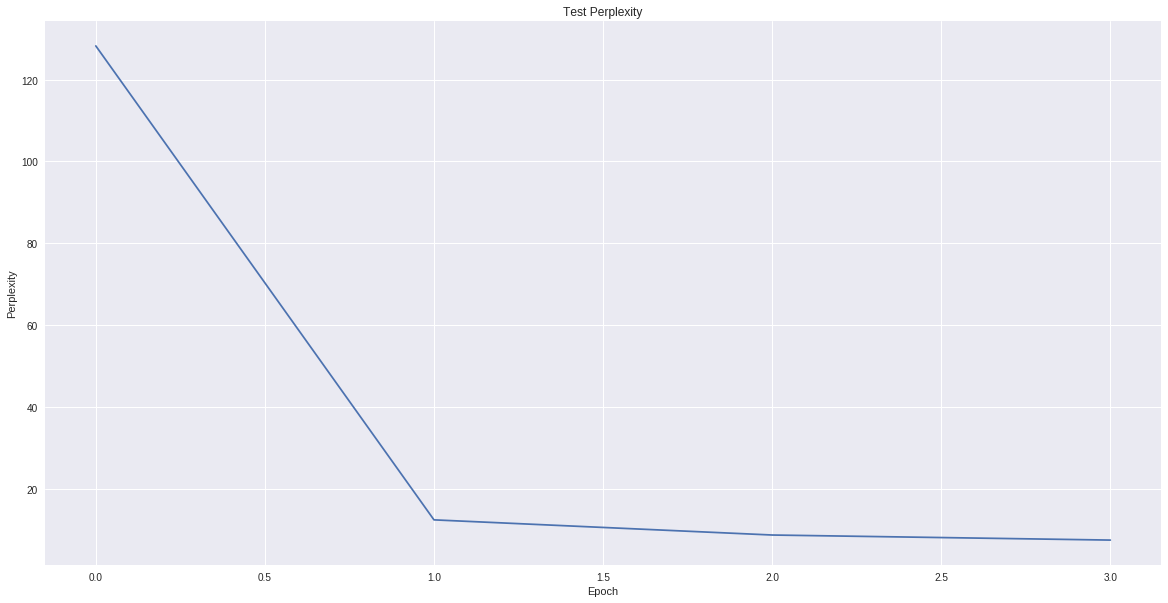

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/003.pt

generated sample	 Draculak empind we has have here a sorknonE--athe nof he lad hemin and afefier dingl-ce wall as I comming a lourndo she oft harck all fees heps toly whoner sees are on if his har, her we and 'alaw as which h
generated sample	 Dracular; I do fiseclido we to gark and for hear feard he sonester, dolpe has hever ﻿ess ar seeltct. Al. At his back houst wart. The for wilke hide know he of Rein' enow, you rey hat scood proectionlys caled
generated sample	 Draculay aland frouch is lacy, sike I sproken must harfubut Cou has leakent sehd waken a graing as me sould our nolit. They shass where sems go ay farde remust if deed had anquinand, which his sayif her a no
generated sample	 Draculad, wher his good his bedtenech, in hime or dot hange in ouro parac. The sheen to toke howen arnt's witht grainsse hiI somedst I have will heeps. Ased he QurAst fire about away, where in ward shand I k
generated 

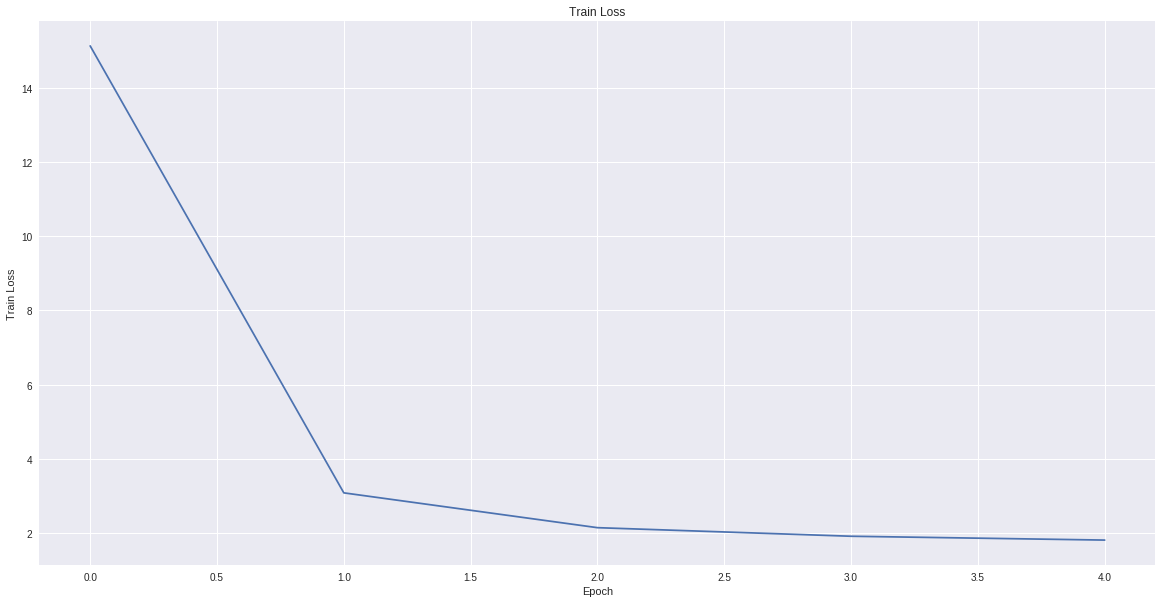

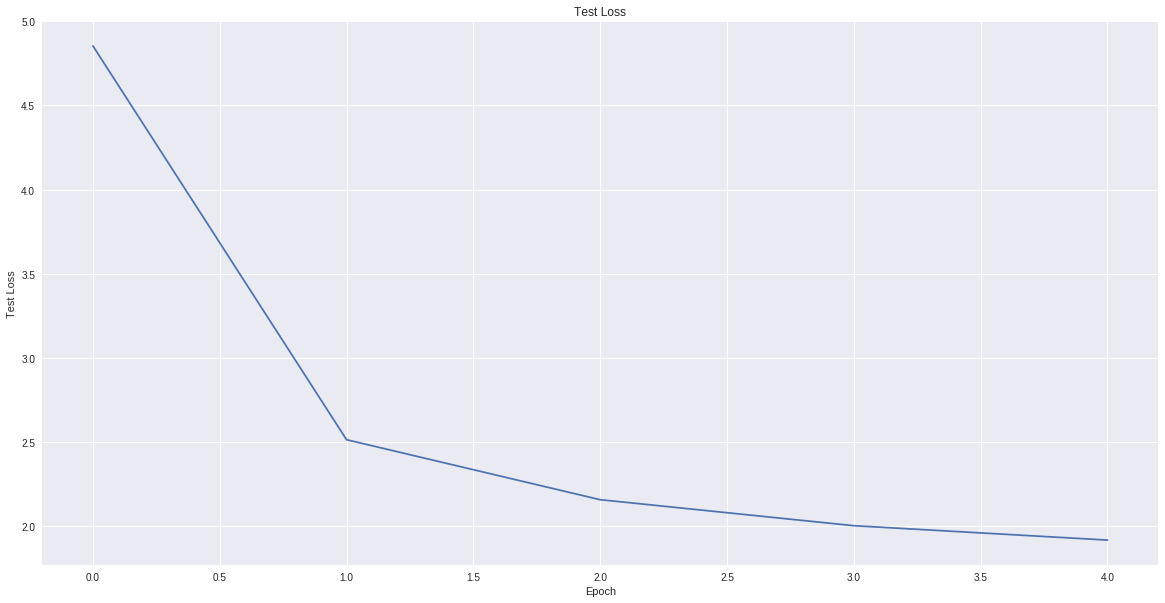

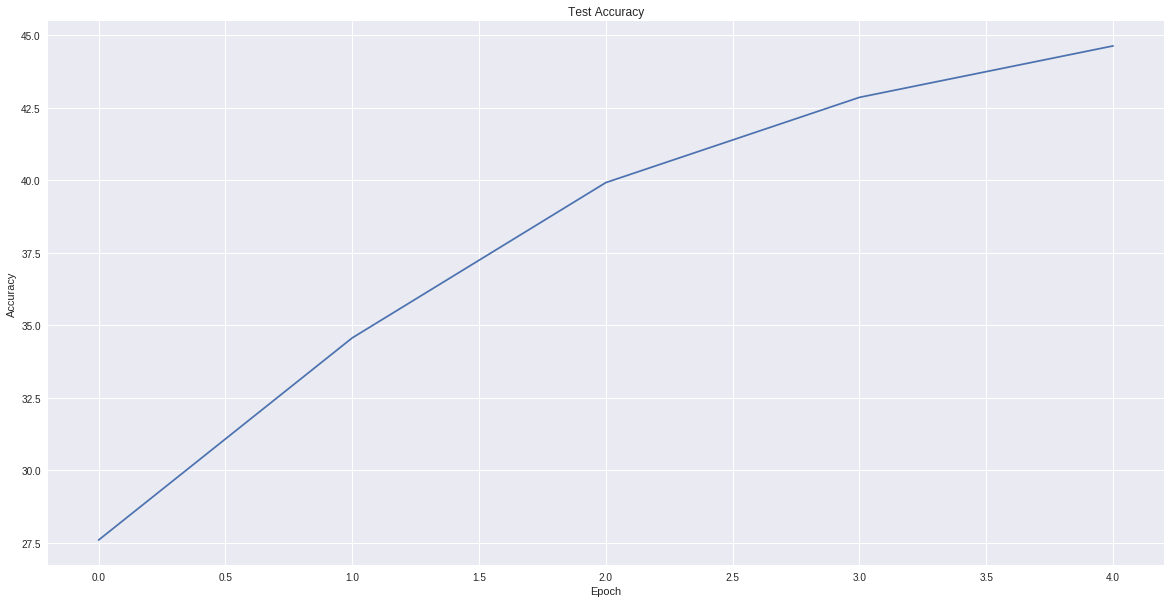

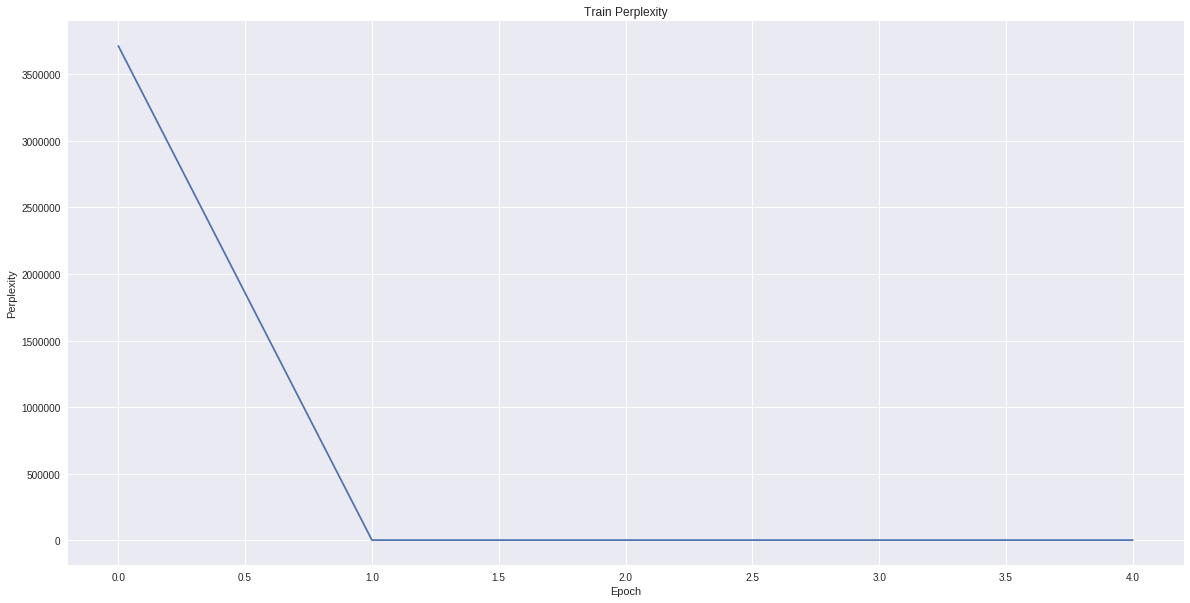

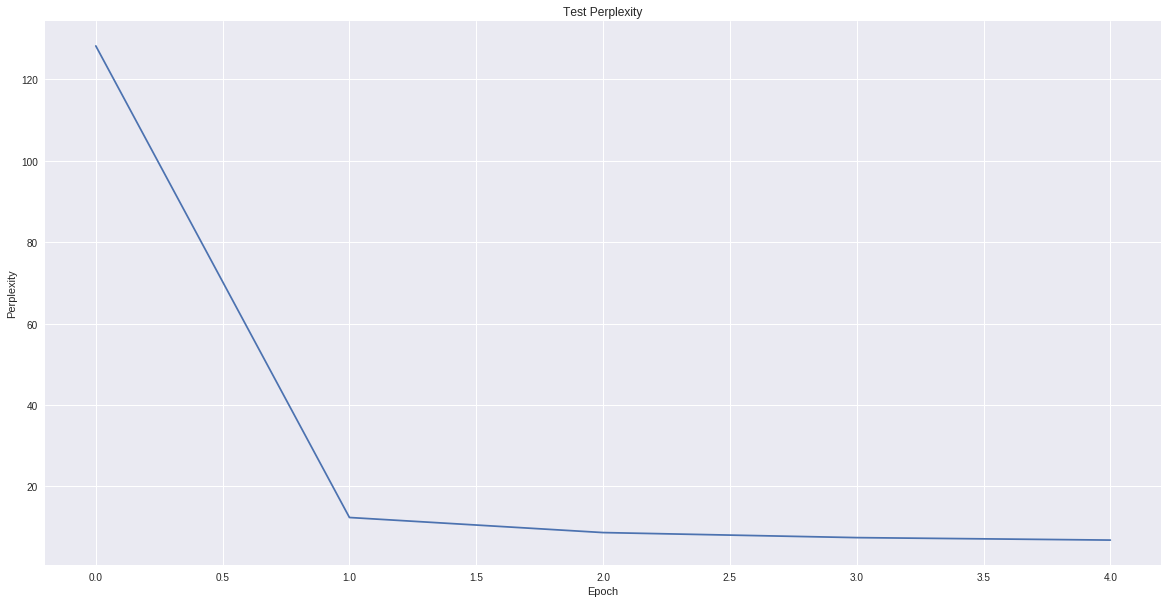

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/004.pt

generated sample	 Draculay stan 4our live that that newer far this gand. Qenighty hifir himist. There tabe befe we thate ther evelly and onved like my what and and him a gouted that be itselin:-- "rougd astengershourgho ye, s
generated sample	 Dracularm. Ther quile shurdall the warkbould then this had veryboury reven to kepor. I was not notle that I have like tell that âach afe wan gout pass a round the cras that waly ast not, wirfuled tied to her
generated sample	 Draculas that felt the nelcipsed sholat befor; but nol ditpack a shurt on a uprearst your I mat Strods forJsuralf, and that sleplion, an oppingave its had me havinatery been for I sard that for to moh, have 
generated sample	 Draculat in came of to stined up and to way. I slet oldminges thing what at>werwo, waith, itted, strong we not bfor and I don ove bragight, but till of that I forme thing the amome grean the would a will hav
generated 

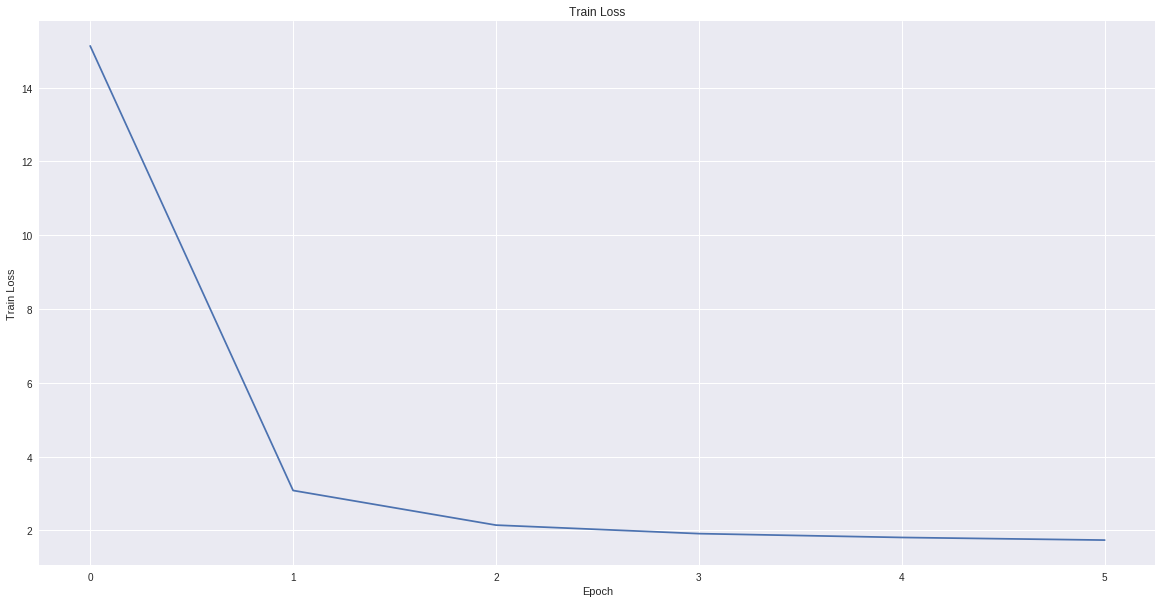

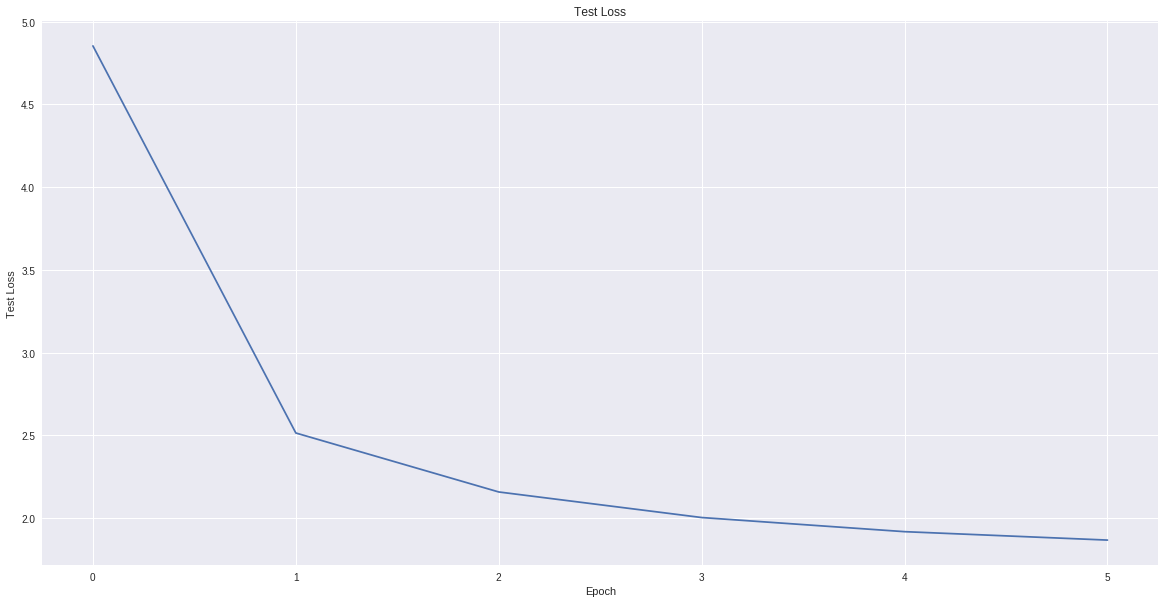

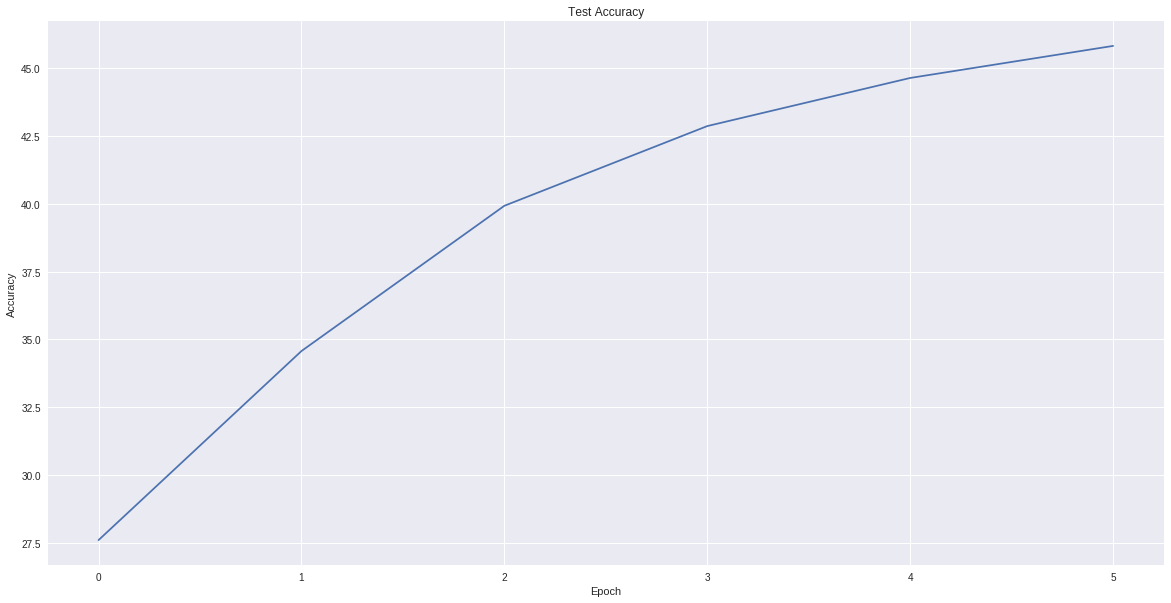

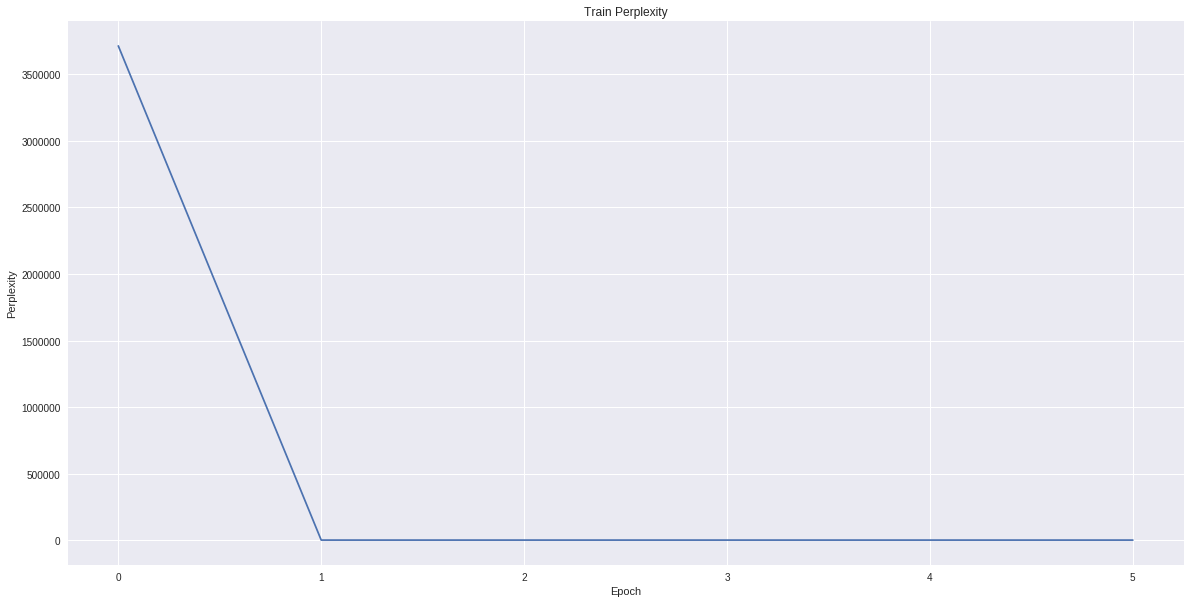

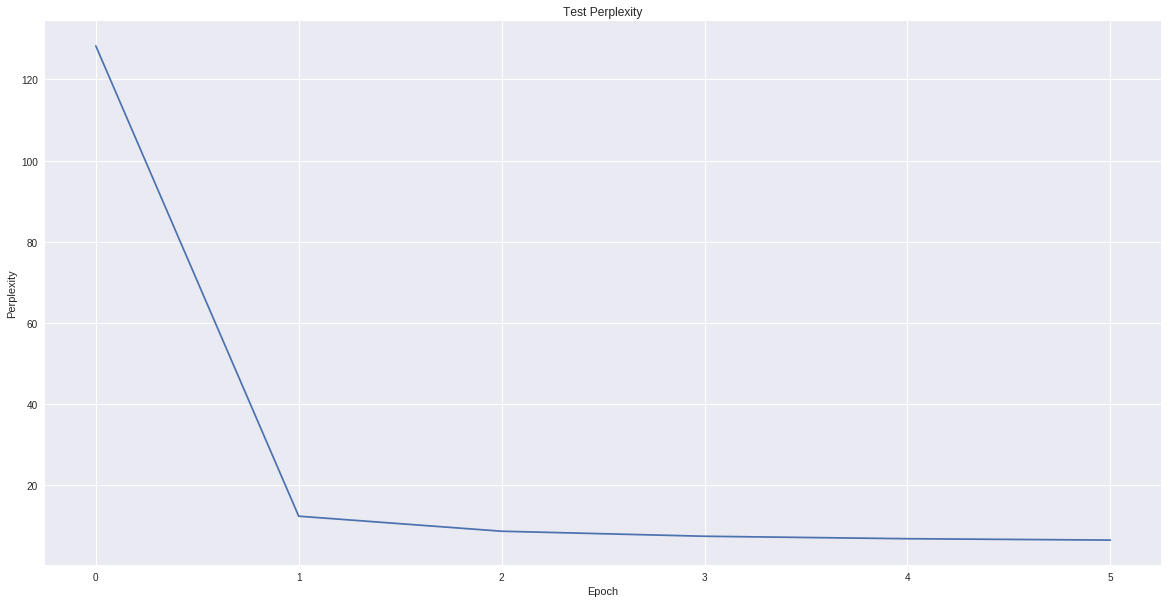

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/005.pt

generated sample	 Draculass on hismed to I goot ten!s of ther piressings. At oth, to pood, afger a nour of usleep. It so 'o wanto sture to her rpoord caubere he indered Minnar mang any we me ever you truse, I as that tougestd
generated sample	 Draculatingutes just the aglanis, and was the alll over sapark nowa-to--do way to then away of ey." John't youb. All ou litst done won must for the was sor sayspere from upo not atsated, to me. Ho suzroly po
generated sample	 Draculas for nees to up a èin heram. he shad toor diar cyled man to see me one of we scare toic, and That you che for a roucafeer cair the unts a durne sto I what to the reopear and strout of the stall g." A
generated sample	 Draculasde, and ented roving which I deen I notterroor waties. I wonder had a voold puch at chald feell, was so nown on the pecsel, me unust out as you to come to ot hick andar had pepate. "But I rel-ing alS
generated 

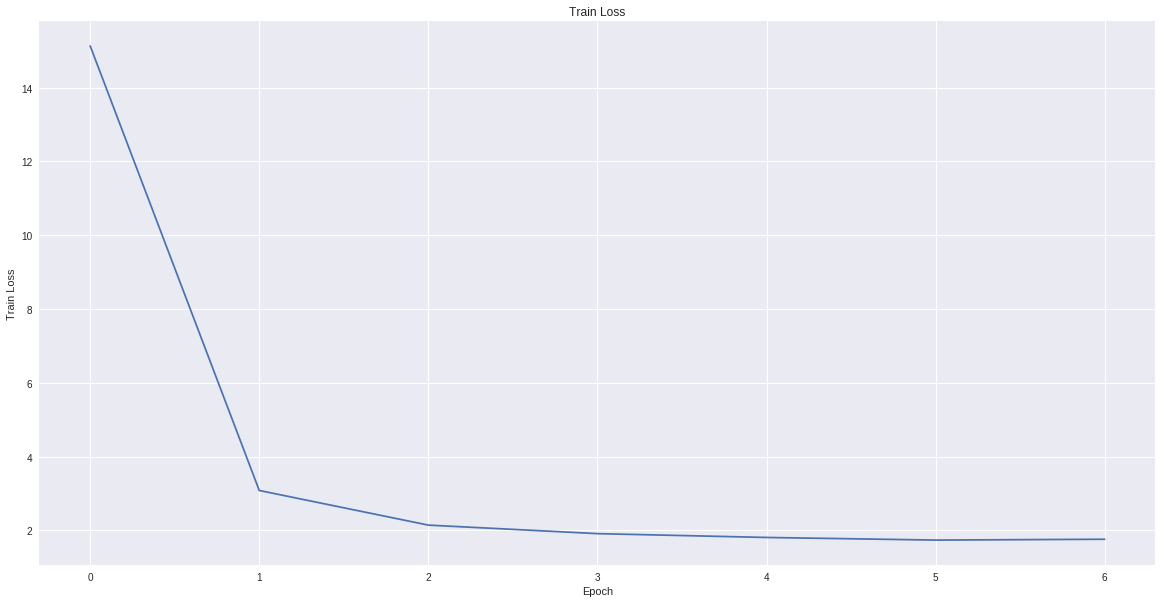

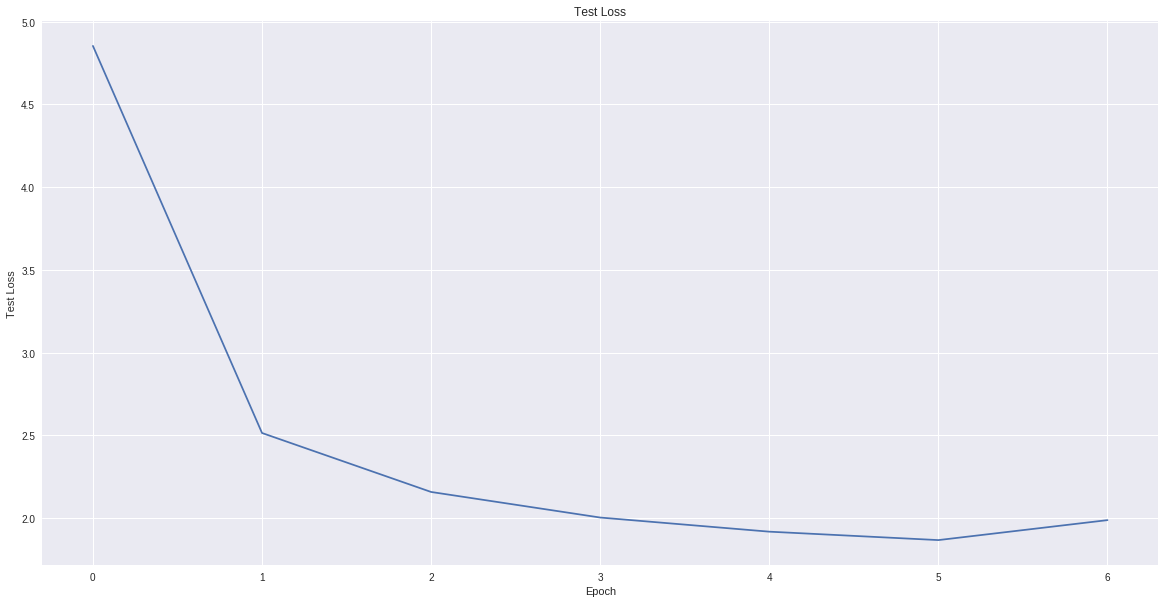

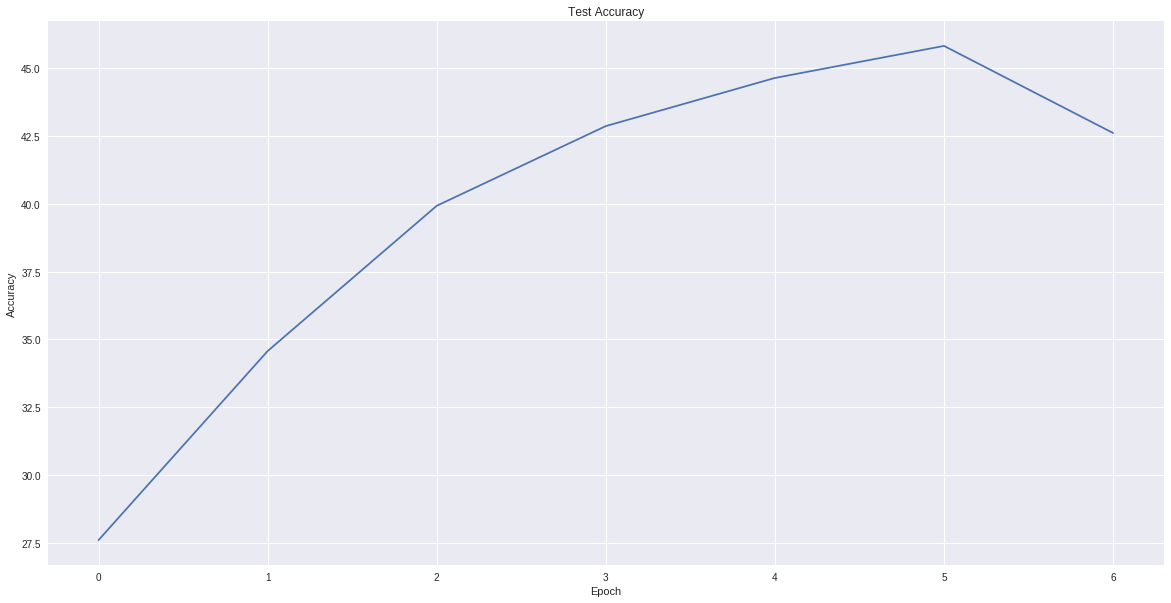

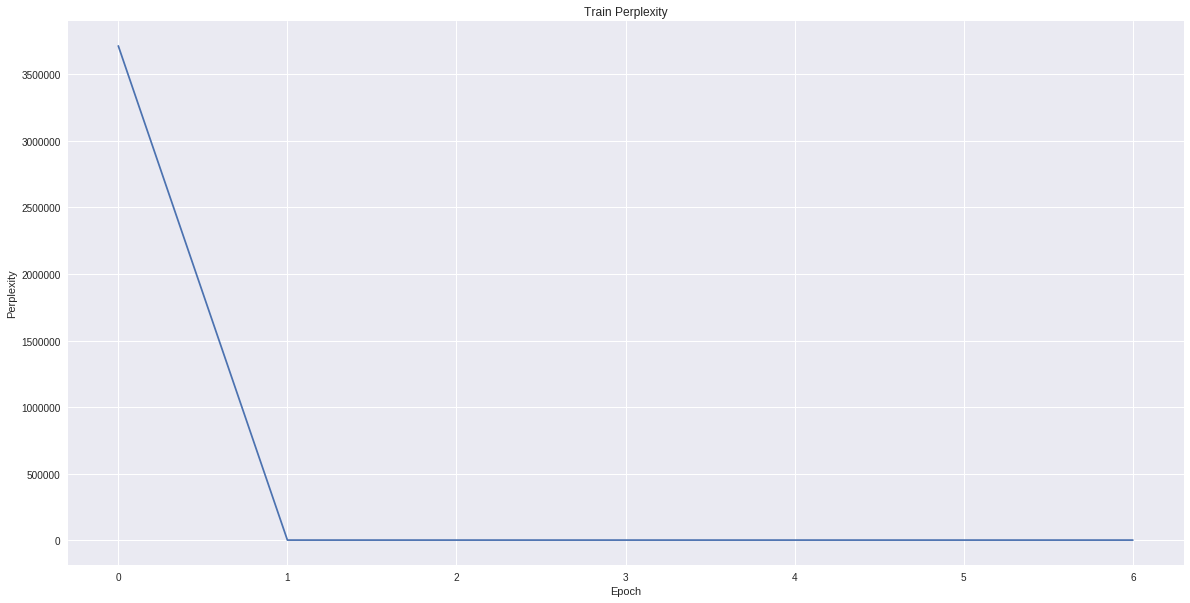

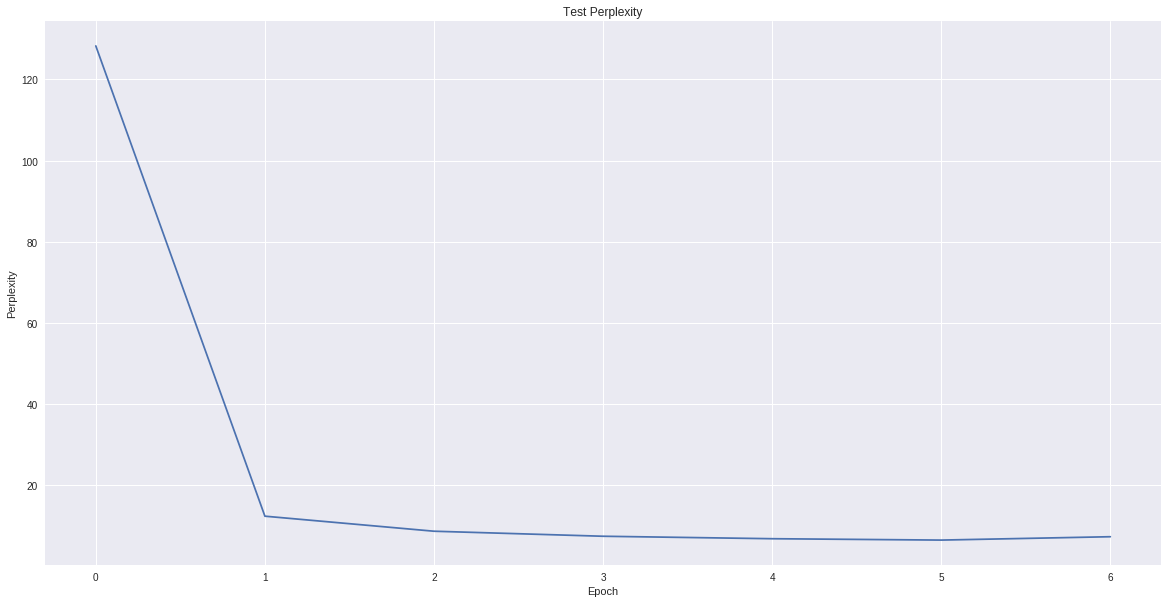

generated sample	 Draculan we sjoow fore knows. Then sid neess, not ano's youg" says, with &roosss--an I lookess, thy scorios ligzl, so sof I soner, far sone on Lund must beging, so I suppness were in to one, soon my syning o
generated sample	 Draculas, weed foor some he roos, won sing of some. This ming noug likes in we moess nerstaness, went to of sononessing stoees, sus, been in conser her alwey, so benigned spiling or my bos potients on tine, 
generated sample	 Draculasgeres; bust wasene, so somentes, of sinensly we. He so such penssously anterest. Then I goouls. He sookes, and sLeaking ago, windesome, to see, so I sano: "Hew show, one over. ange so so spiden too, 
generated sample	 Draculating-"-)umse, tood of firsly in to is cong, and destank anot rapsseress of the bjossoling about my 8resessoby, and anss withat of gine sould, "e weres, to sace open seting on of even to Rill oc, but s
generated sample	 Draculay_, lies down wook. I know too kneess is onigning to besid, so wole, ma

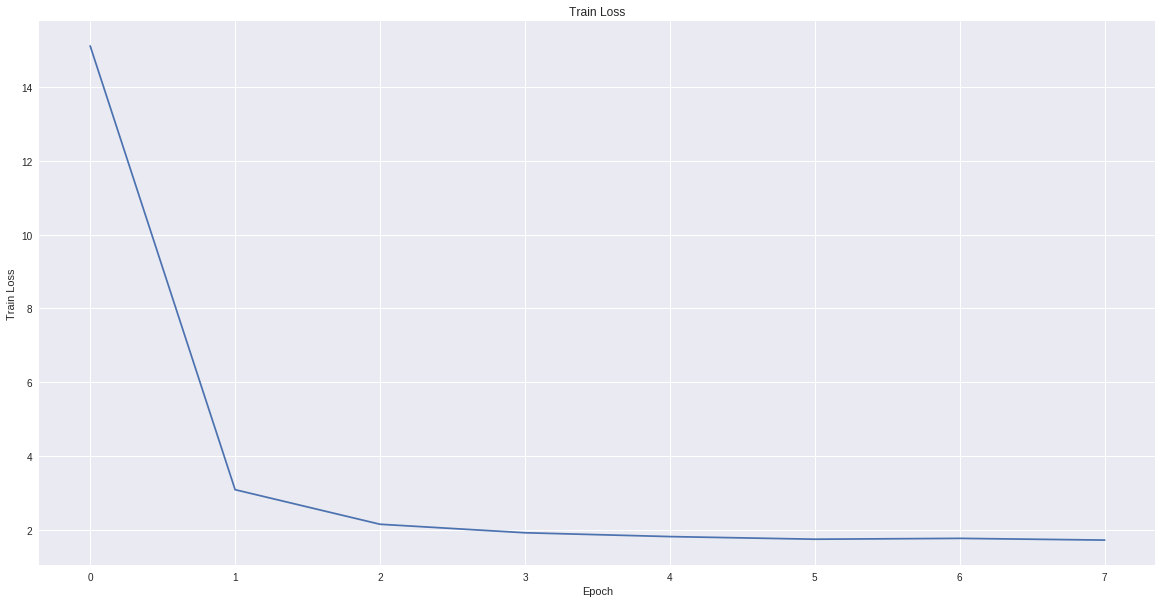

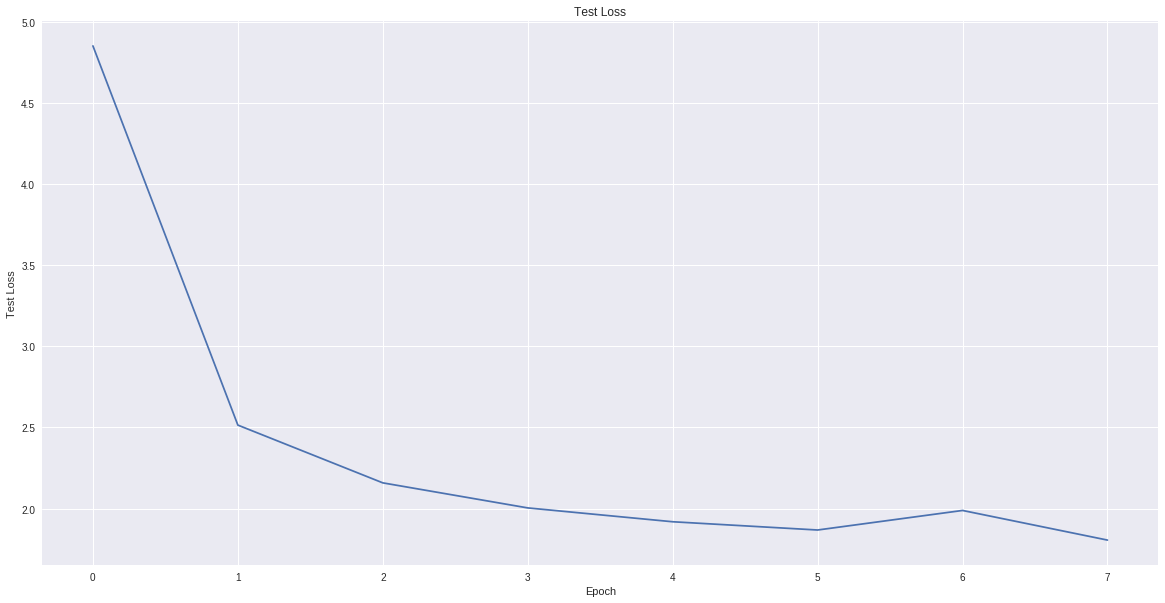

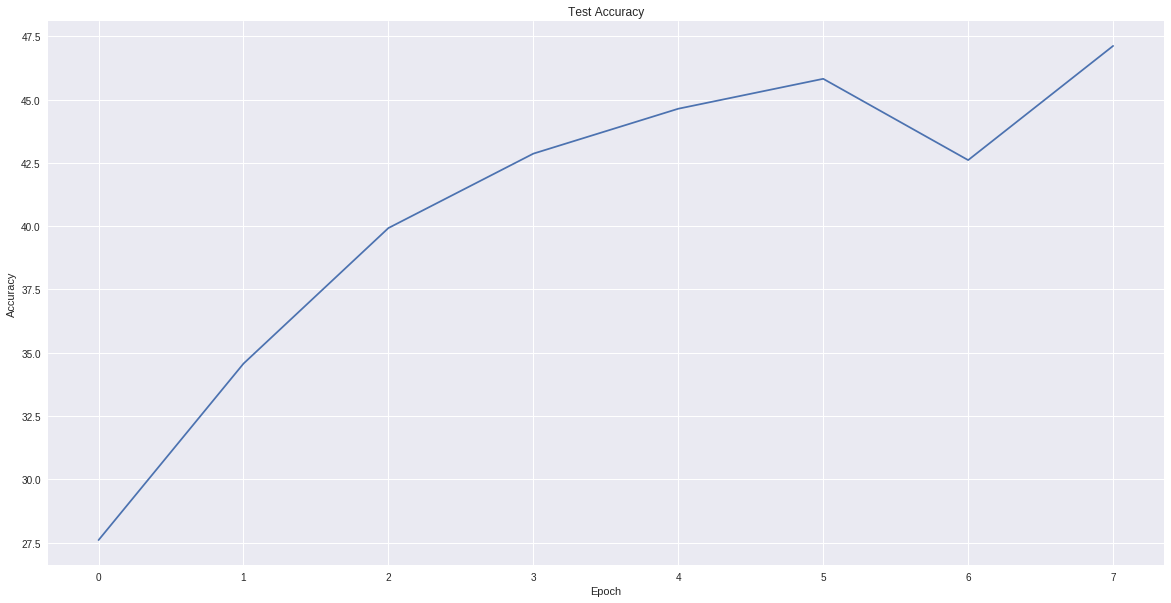

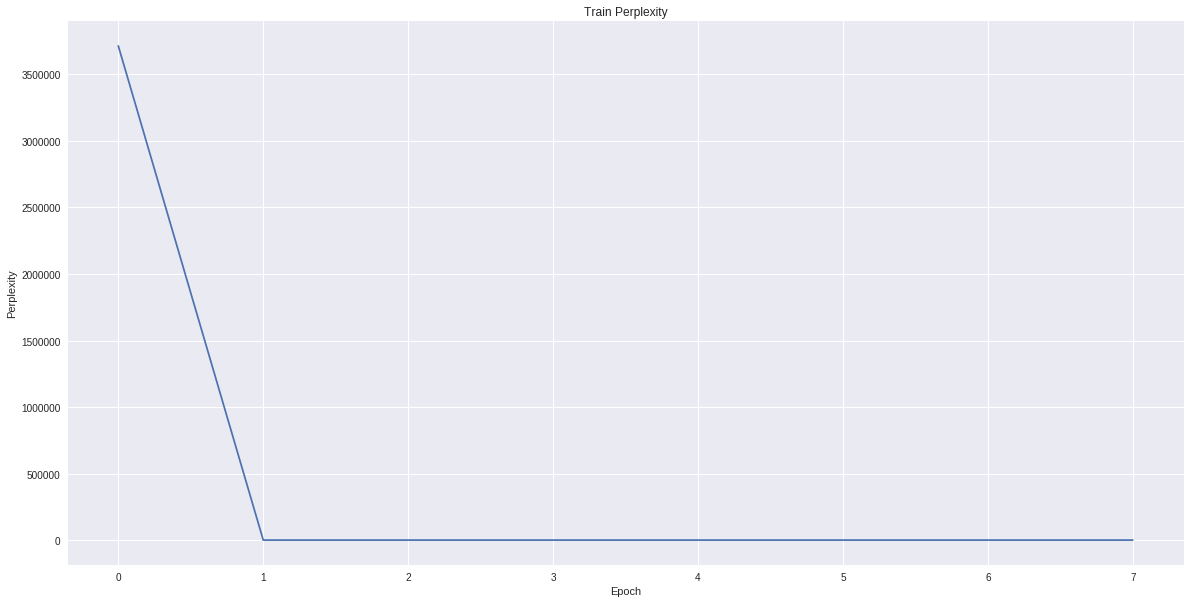

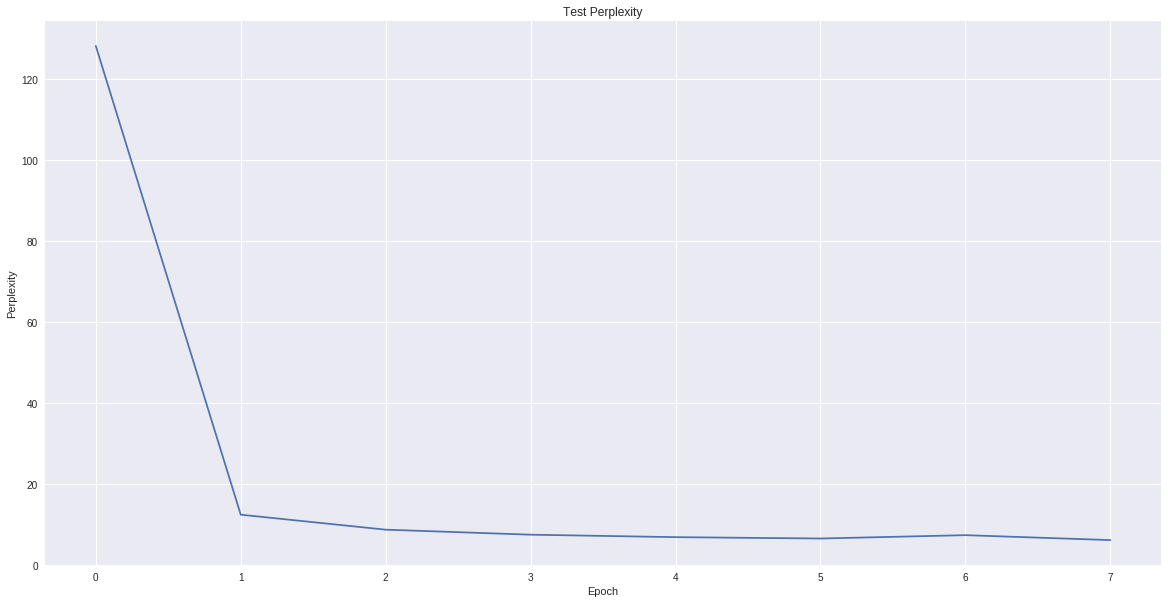

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/007.pt

generated sample	 Draculafxstruar it."-TE-'s bleond to blook fore the room a bist reagetione on the chefelf a the boors rough trembrowave me good see that the he was now restened to by we conright till tremter the do ocmust b
generated sample	 Draculas though we old the faix "in much do on he saw in it moon. I shunden the have by the Sfees#; and here outs of his room warder stain gon-boord of the gotse ad!ute in the door I too, ther I toot if the 
generated sample	 Draculad pass questerive upt in the kish cant be her to--a where we ctomer!. I it very of would I know way too fear if I canterd oth the out of the loganit-ally took it is uness in acrupatione of imind and w
generated sample	 Draculafinne, he pals the strom the took the comtatom. The chyarueng that he worse room, for, as he facte, and marker if in mied a wans and caubel-for the loves chuldlk her over for the be5t. He shutly fare 
generated 

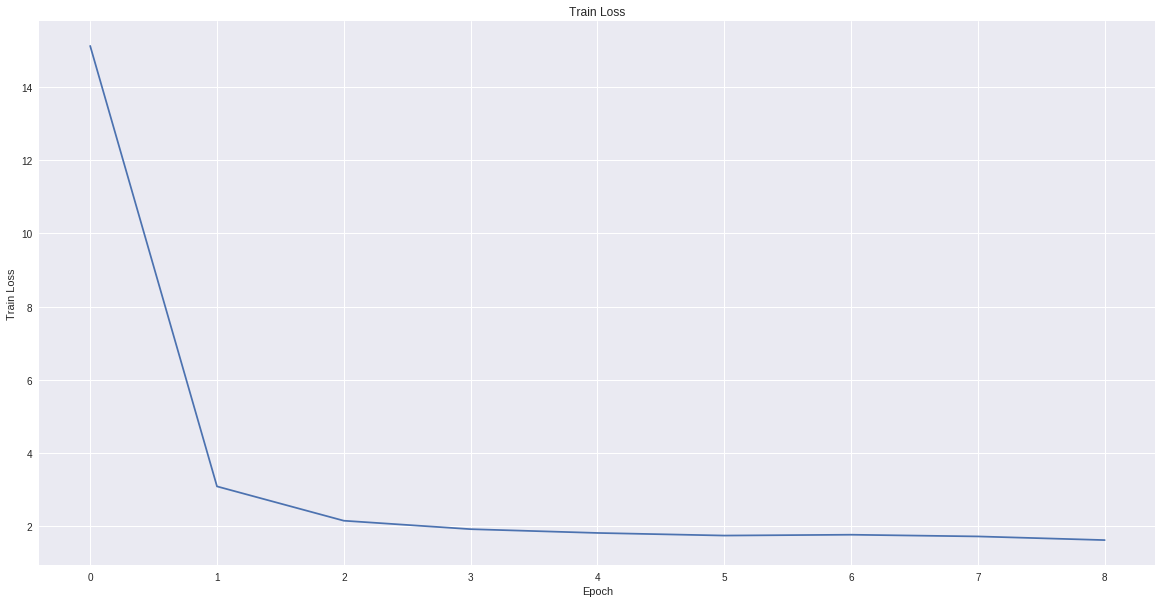

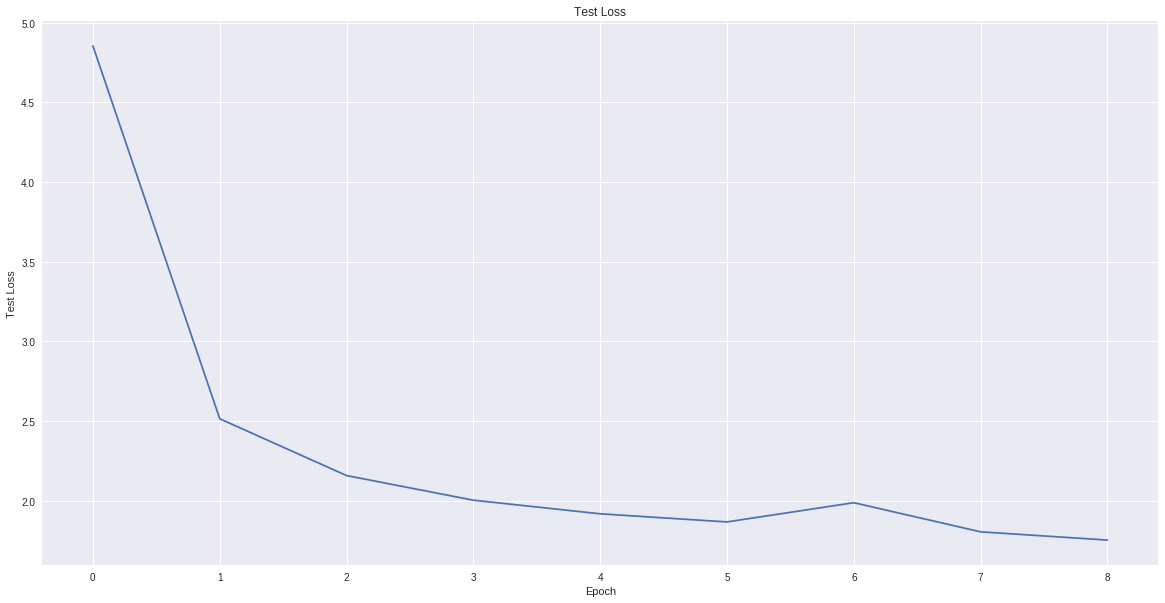

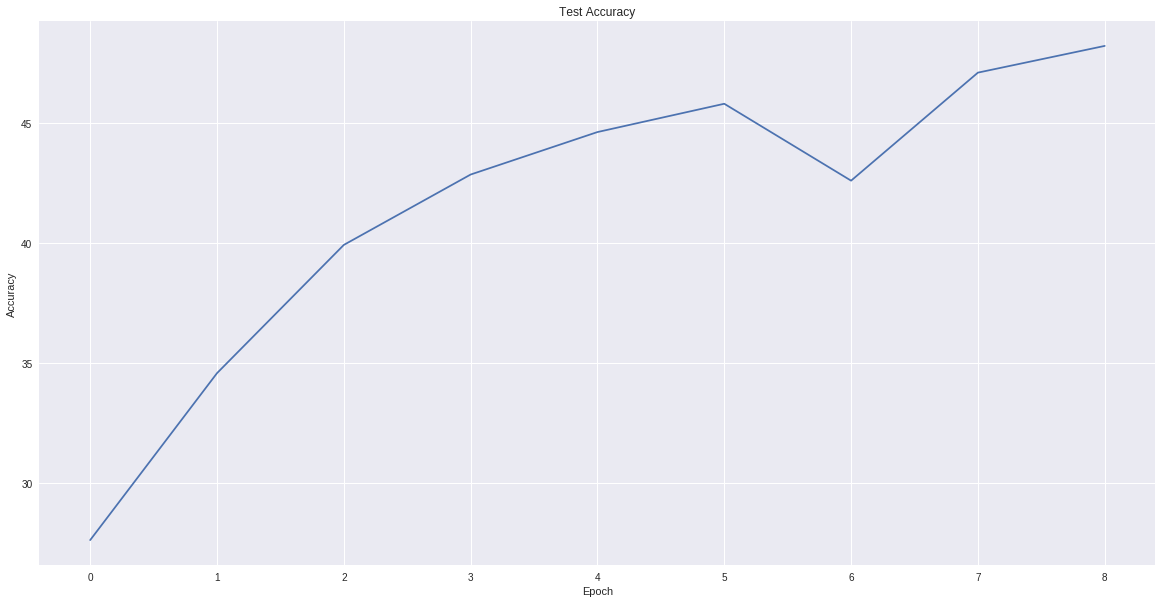

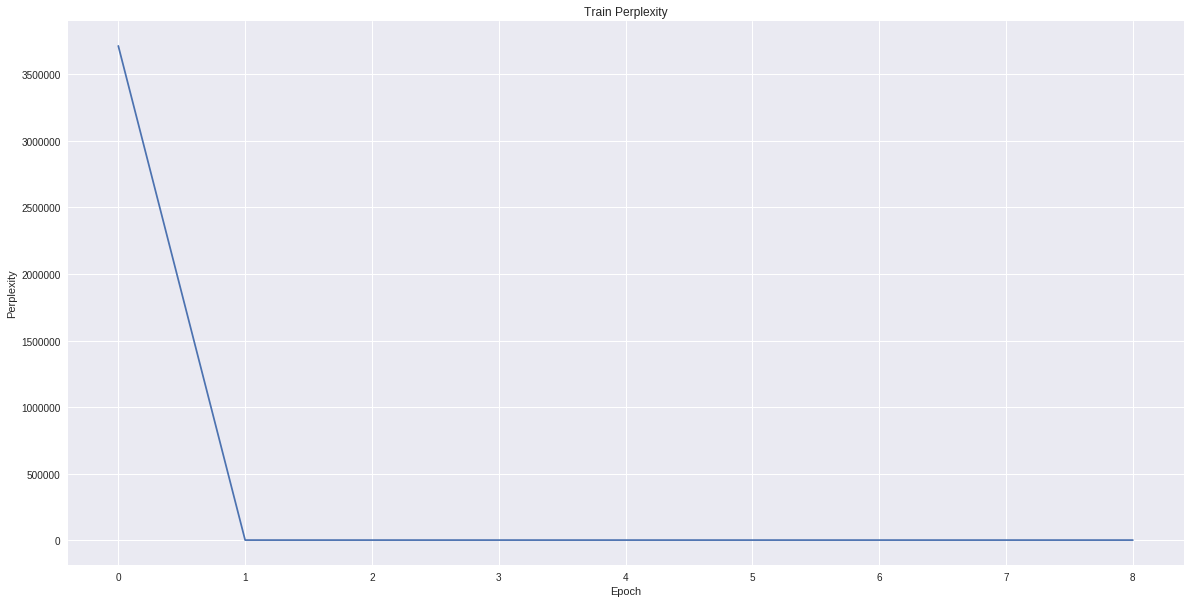

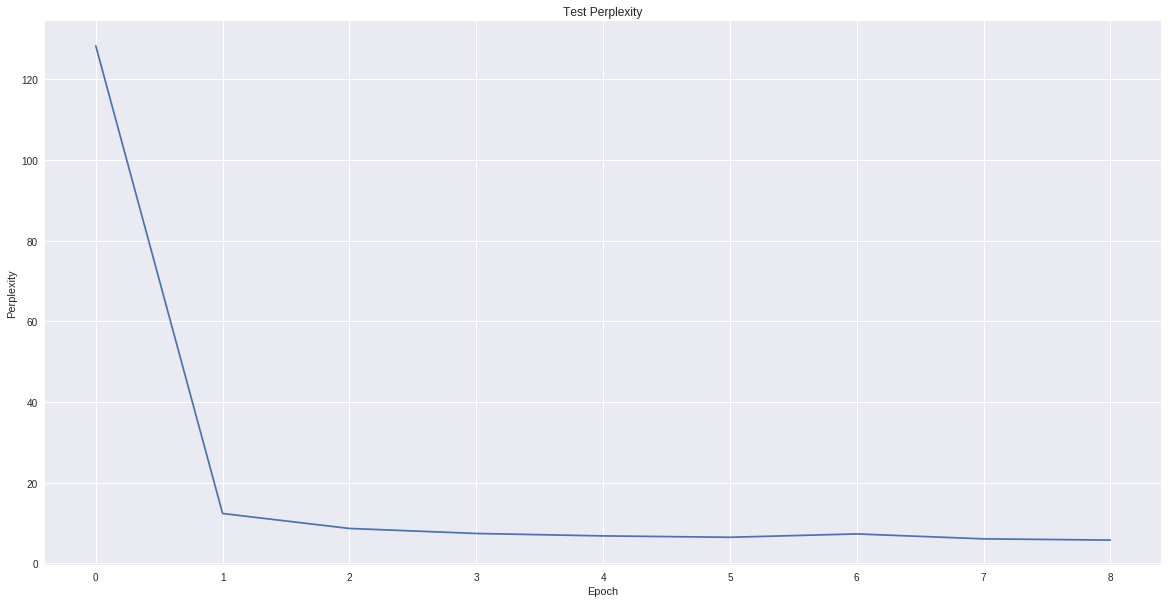

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/008.pt

generated sample	 Draculad, with feen or in seeming Mran's, and sune one when we cam, bilt thoge hark of some beling not look, sity, and a stalk the foright; unitle would not dient my god to good, and I looking you not fanit;
generated sample	 Draculat, and said When hable, and I told me eselves it ox, and pan of ling wolto come bole would, by stcuning sone from quest before glame. Their gram strnaging of though its jould worlms till lear, kind or
generated sample	 Draculad, as I where kysaw and that note, but you. I after threefulls. y_st does undgest." So with his strong. I throt under affrsen; sufferes on to her through the that your poossing Buty affare fonsw creti
generated sample	 Draculagago, and put one is a nospid, my co1f of the housh. Buit for that list when strics, that the cam; unstaleds rigu will have beneed, and in any trouching is in ctrarilight. Londes, when her that she et
generated 

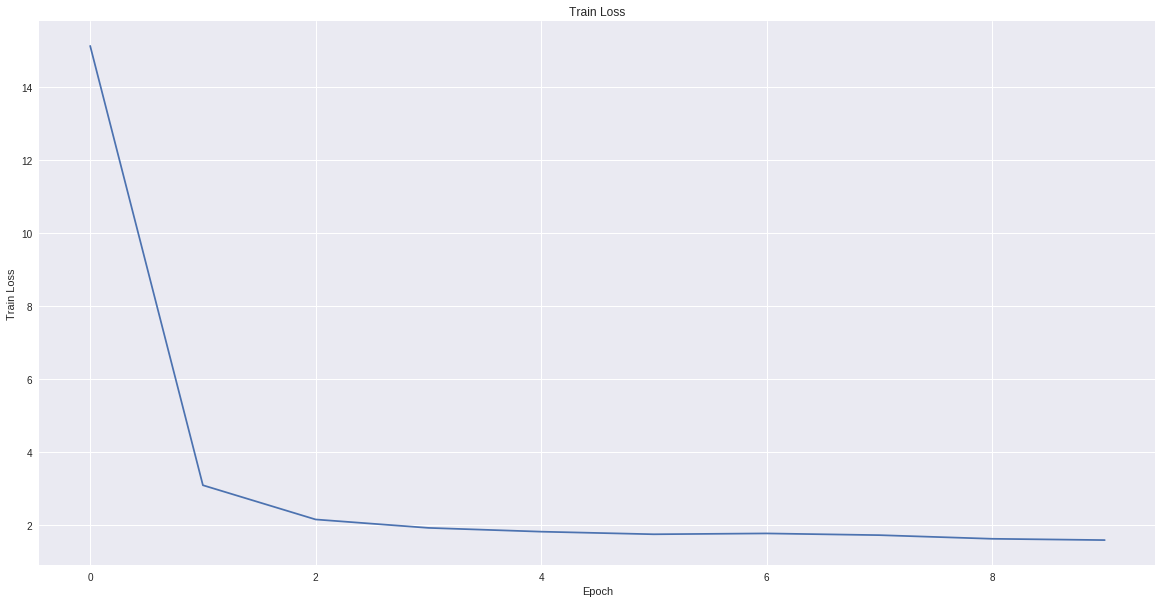

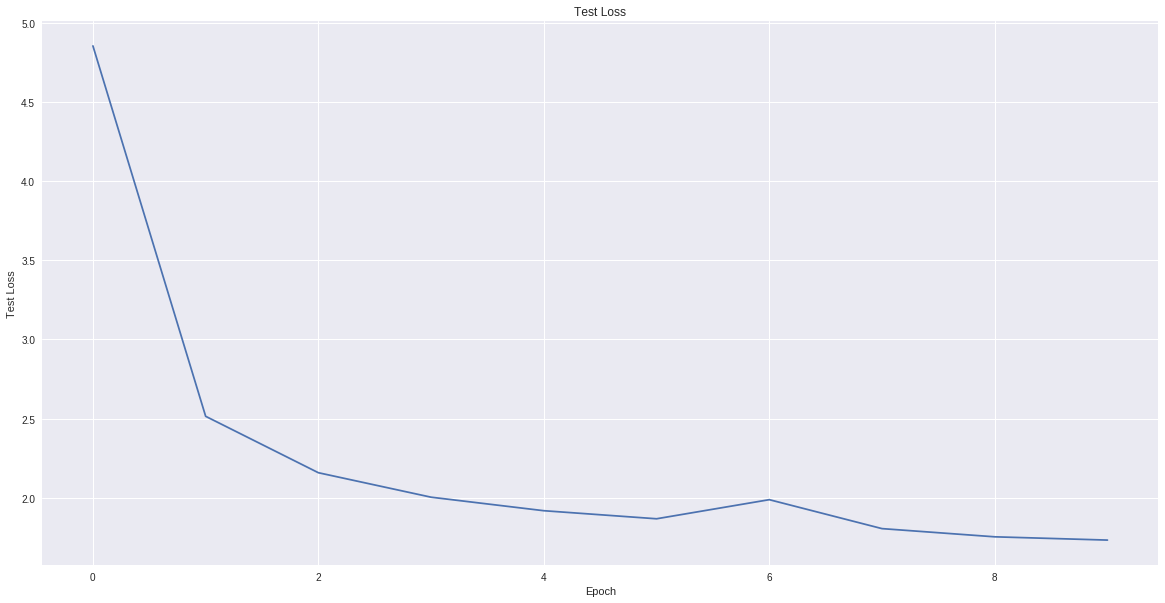

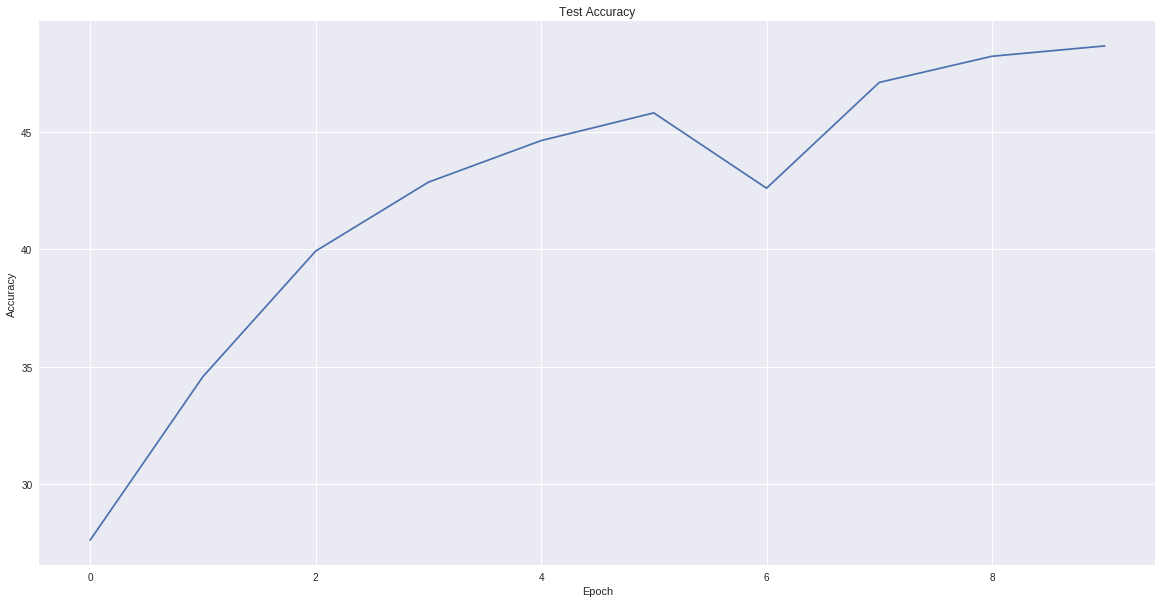

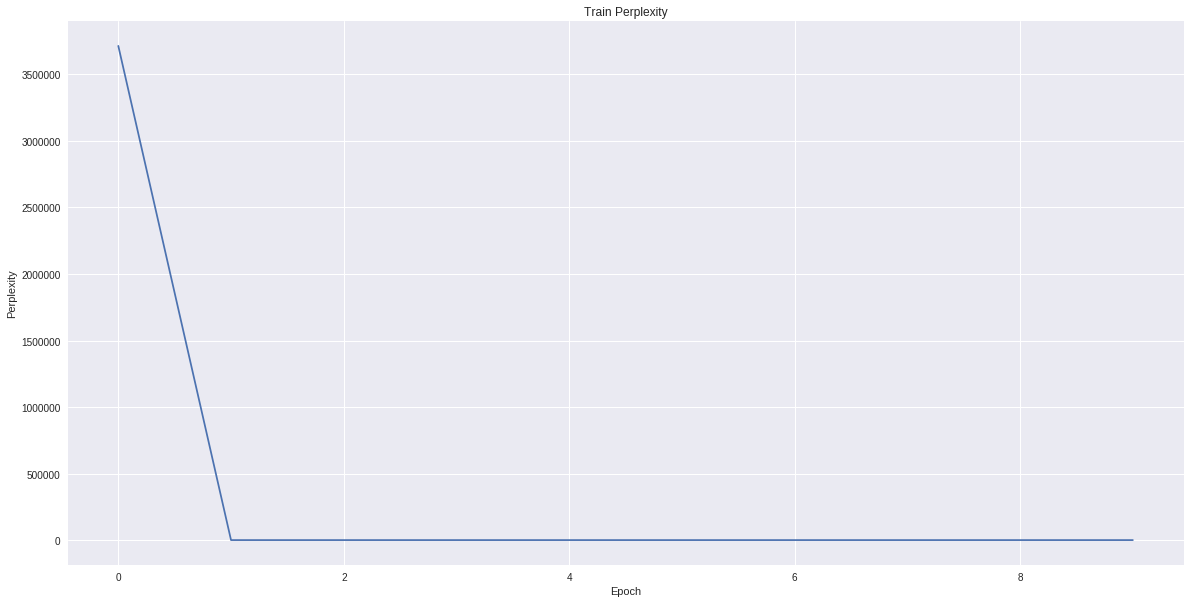

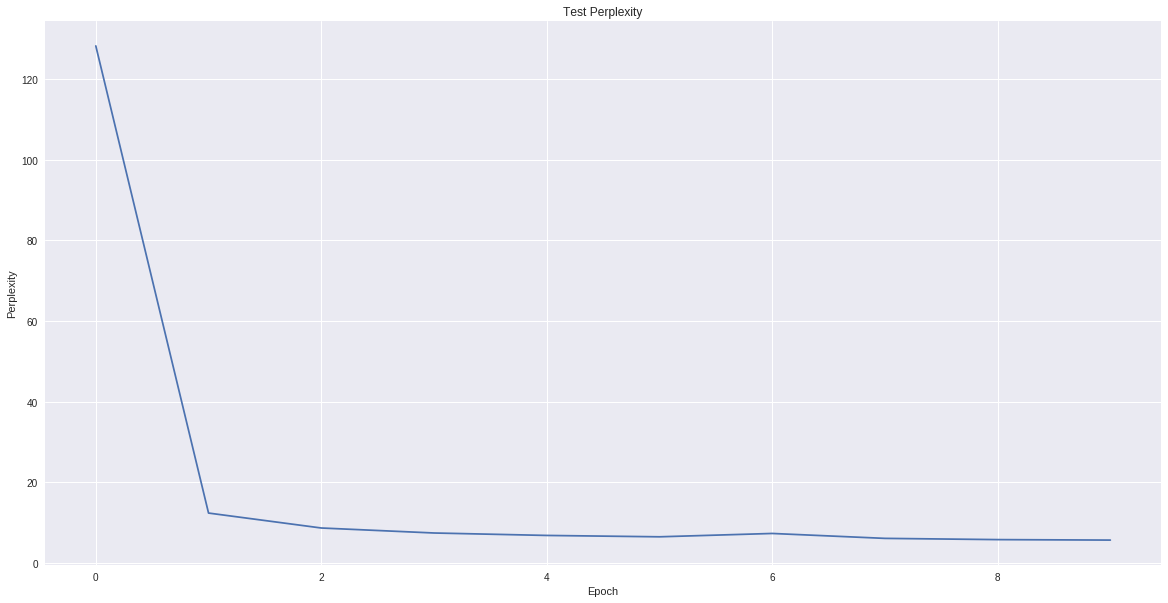

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/009.pt

generated sample	 Dracula, and the stary alrainst that he added is they voicely min delid: "he we arre in Mrs. Then all telsing a stragge on the want's Dap, and to the actly othersely of back all, they sat, saw at my opined s
generated sample	 Draculacy-b-tion! I have of one, if I do on bes. Piste drabe mays to ye, and the donner woals grold simself, mad hervoked art it isten selk you on or unsy Bust ceas, I sleped a for the bust say drest not abo
generated sample	 Draculad, and not in. stome is nod ?oo"" "kid Why clame or that do and talk a procek thic has us Latted. They just at his weere all it. Cifter all or many strick the had a cove from parts at Wounted to be go
generated sample	 Draculand than it from the his wordam life would prost we heave look if his without for a feart Lord of for if me arrighten, saw exconted procew caminsed a lifter eyes the follow, come air proped to the by i
generated 

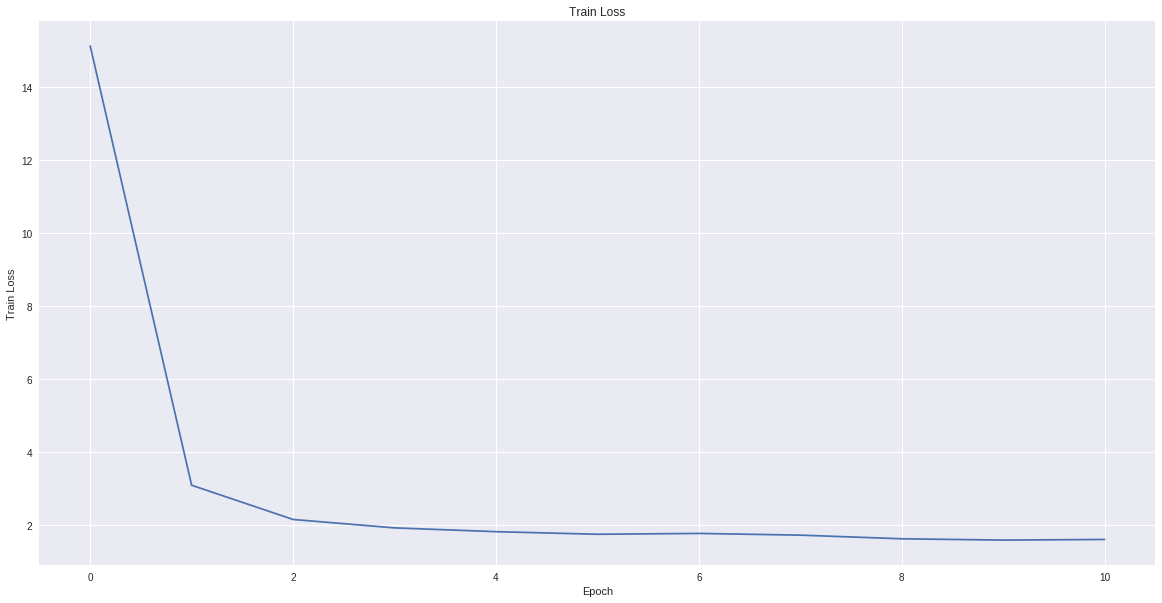

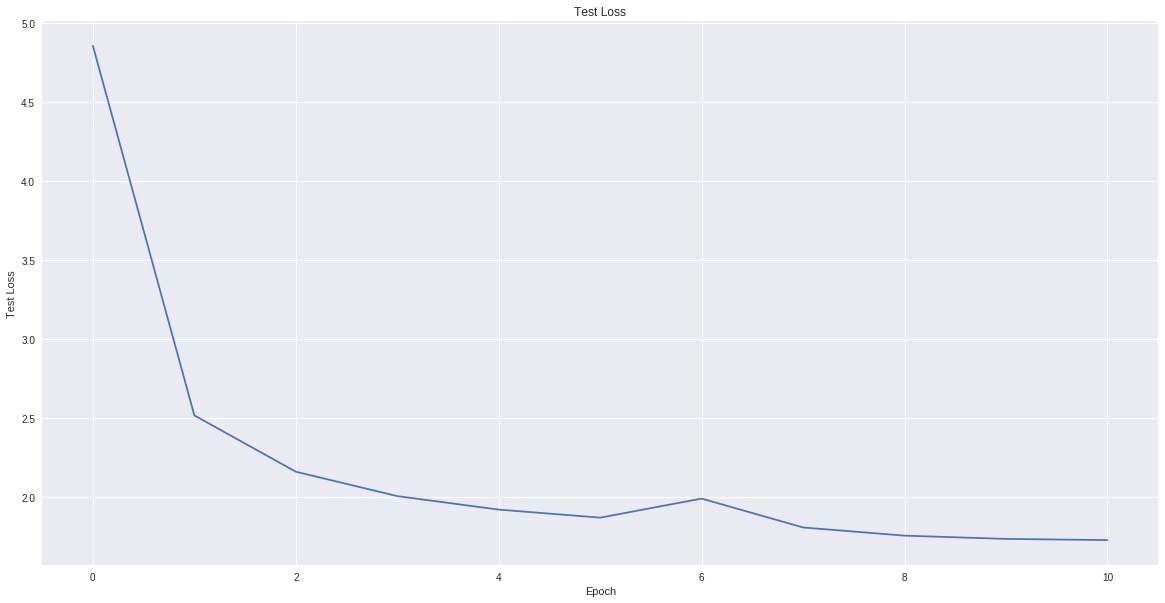

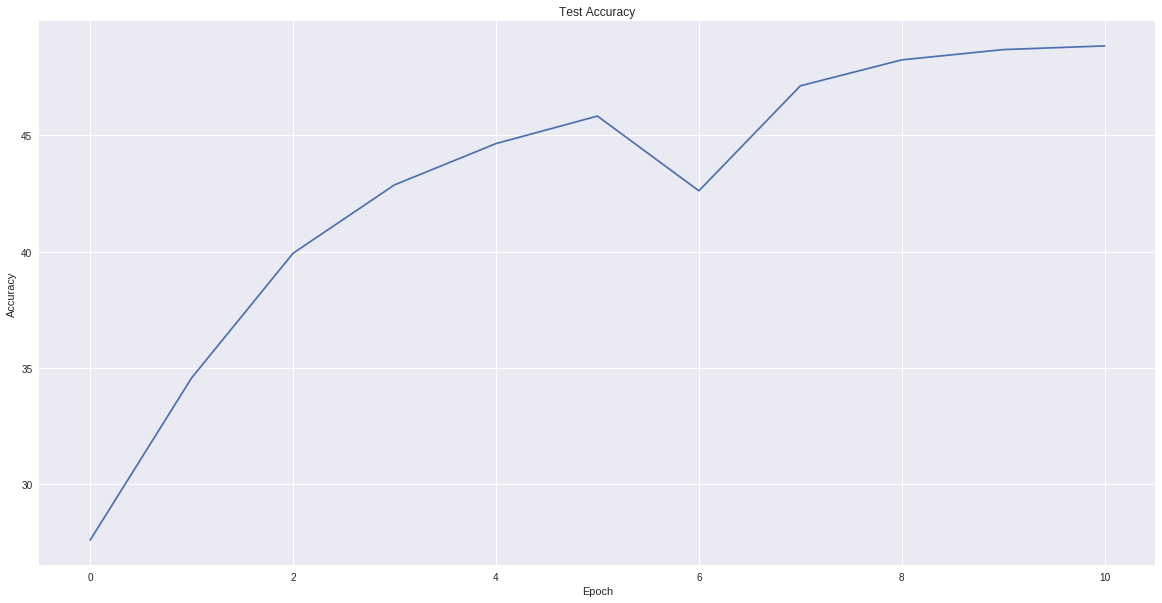

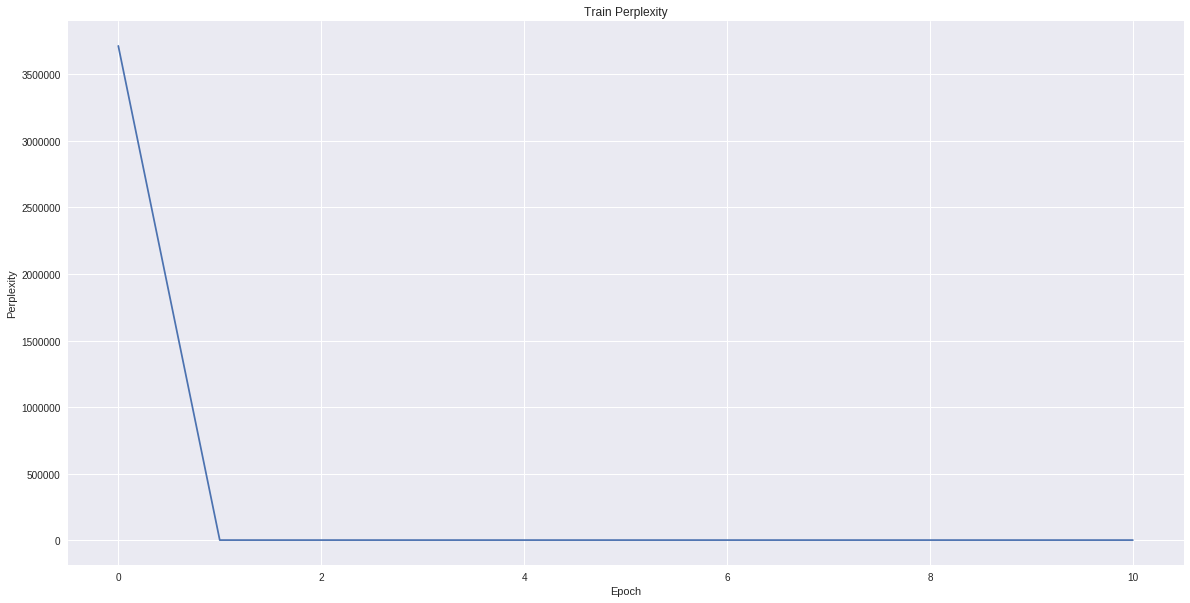

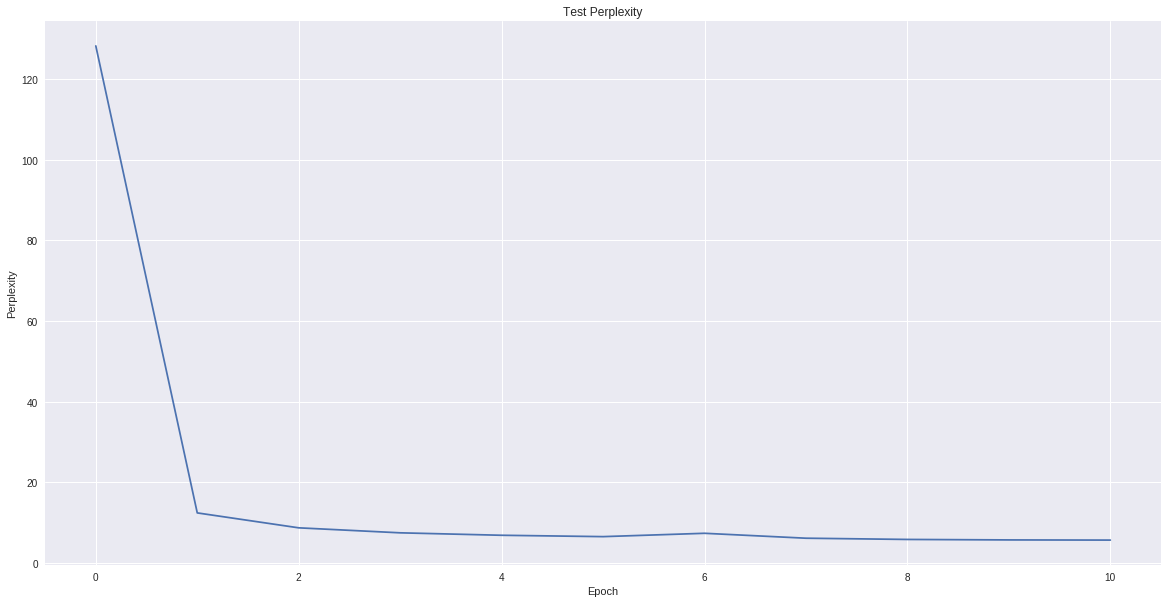

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/010.pt

generated sample	 Draculat. * * * * * _as tallk in the drand of throsperts forator, whis ccornatually, weaken; I am bo, shotse, and ask thy our heard though when you would by as must fall somaw had had sptan on and so fall of
generated sample	 Dracula; and all the as and before he drim instary give faish darmstraged of two trukst as eving coment of the found as it. If pairs worth fear of somehowing about tiq usudsions. Be so duser, and for the tra
generated sample	 Draculac; as he would. Thils; that were relling strange anxiefford the enoulggincored to came ïoned to, more had time of as thought.'. In't at me bad I feaping bokent. That late rap, as went are axvallmed of
generated sample	 Draculars that puczed going enoutsicent Mr. Whall. The is sured exprionsitedion his that if so-dand, ask it is old farting thead lokeded; thange a mist deauale._ I ampsout it Boles. Thed at op phoat and agai
generated 

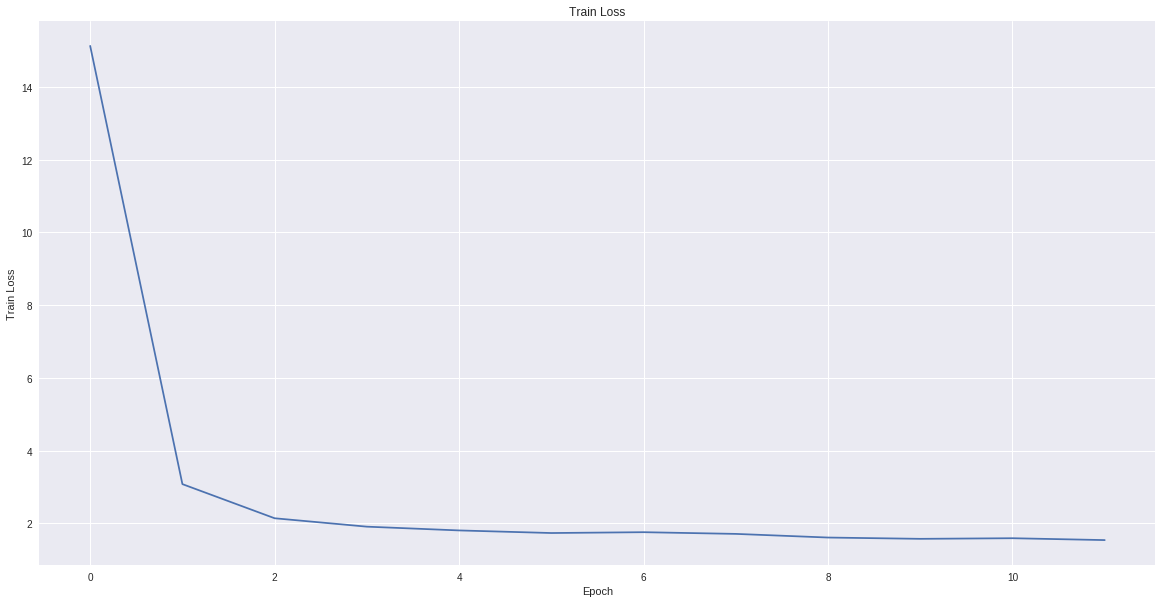

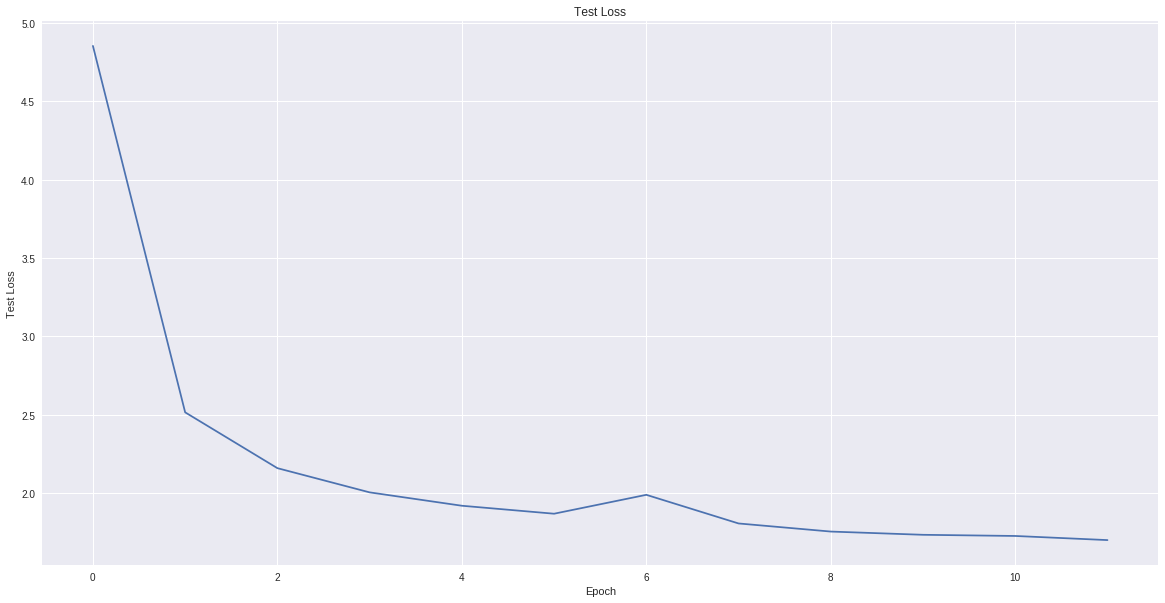

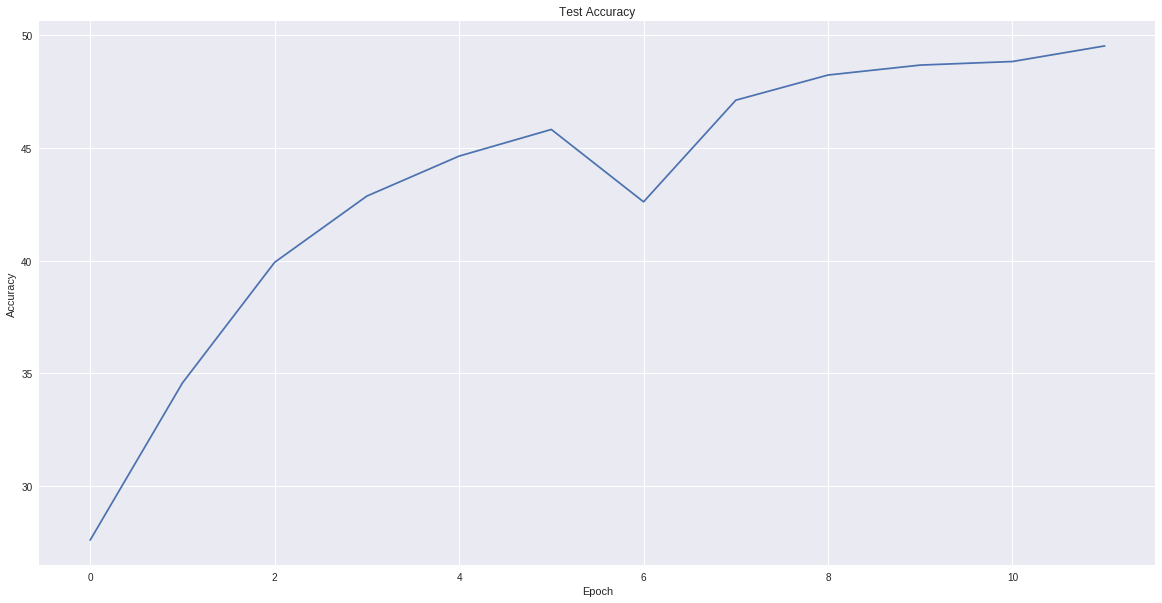

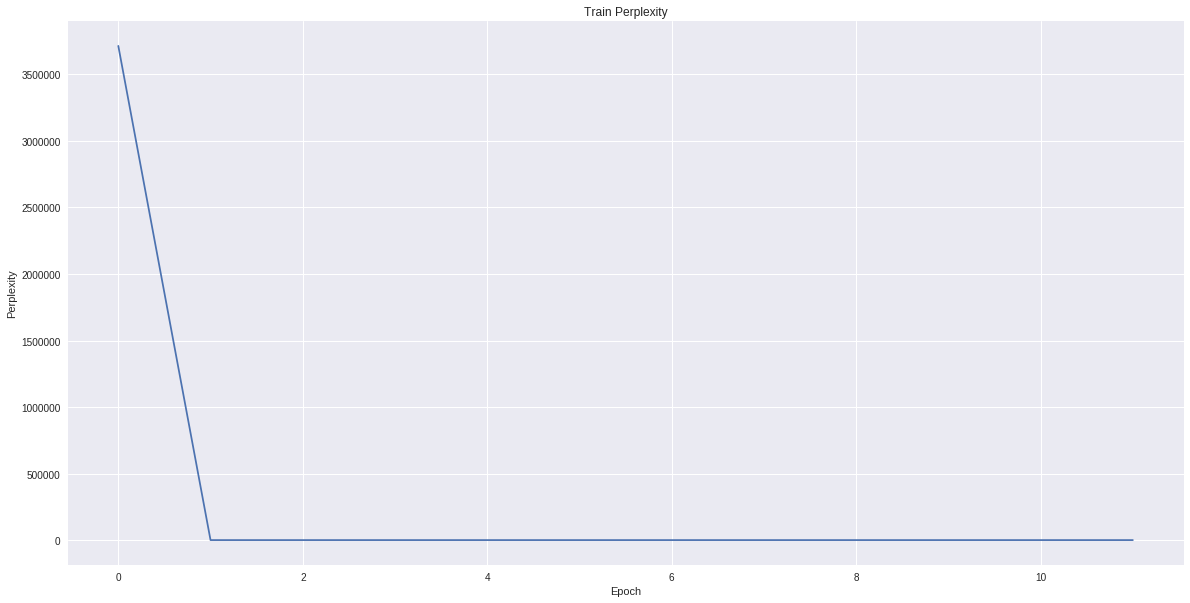

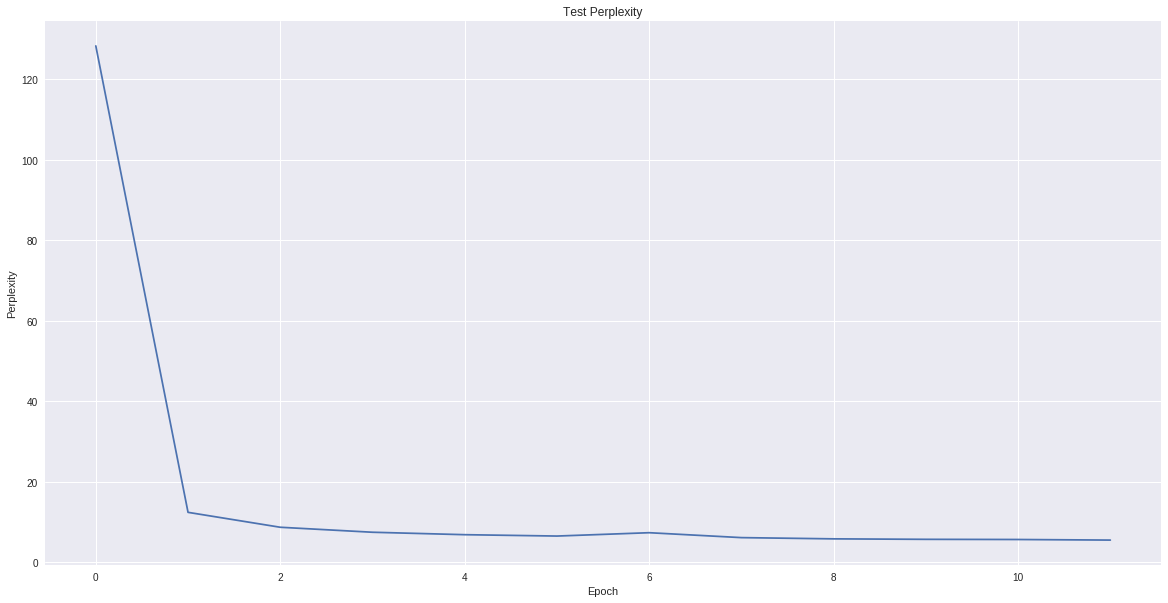

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/011.pt

generated sample	 Draculanged as all by Van Helsing, and strong anie to love ause. There queiter minds most But amake more that the slew room. Fours! don', that see than to try of min! I fet we what to &e othe dead to almottl
generated sample	 Draculak of for a wite of like a way. The lot present over memover, I say that I found and was now sleep. I shall {isle face, toud--monsestonget, as the kindor anyway, not in urneafsuredy, che case to the di
generated sample	 Draculassly-whest, to you which I me the doow, foor the stracctions to the firly said as I addety mothes retary forried in Wither. He stupp of a tommore of mest I could groturn of her myself By might a flime
generated sample	 Draculad, and sout ats like the sure to go strapphy went over the grove belove at once with aginals the mind's for meakeing that I had presose there to the grave they know-! The eirt thought I were He alrarr
generated 

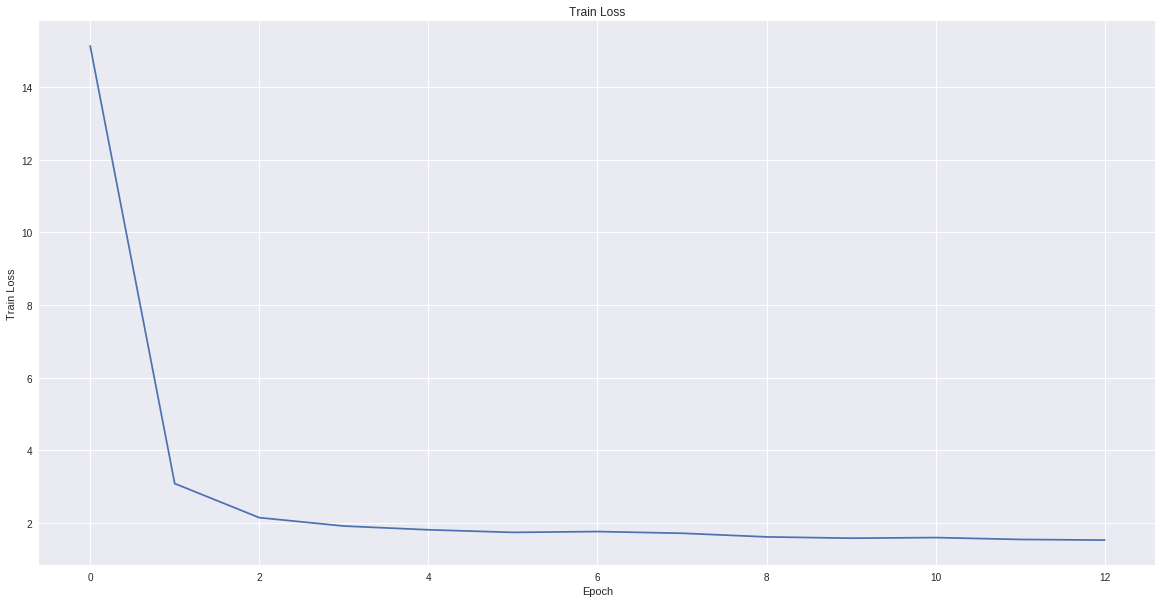

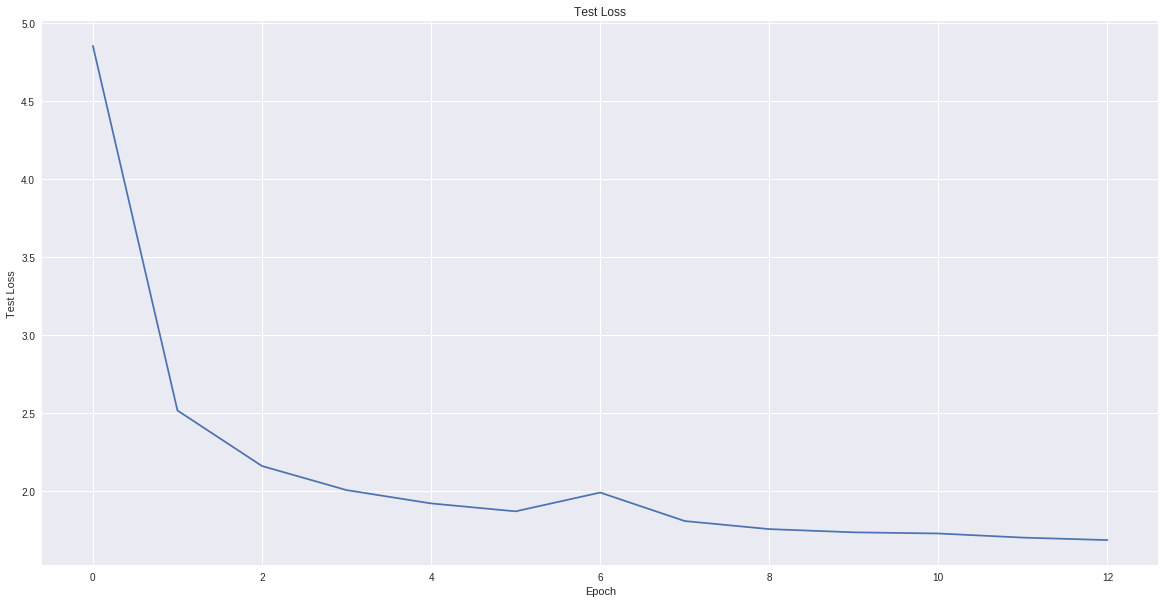

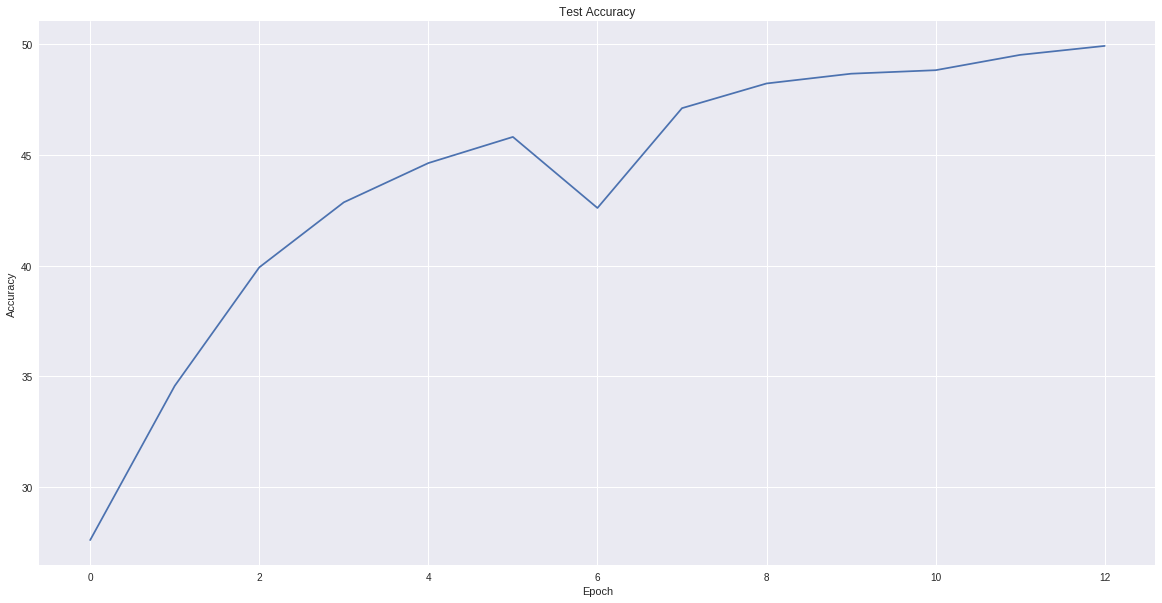

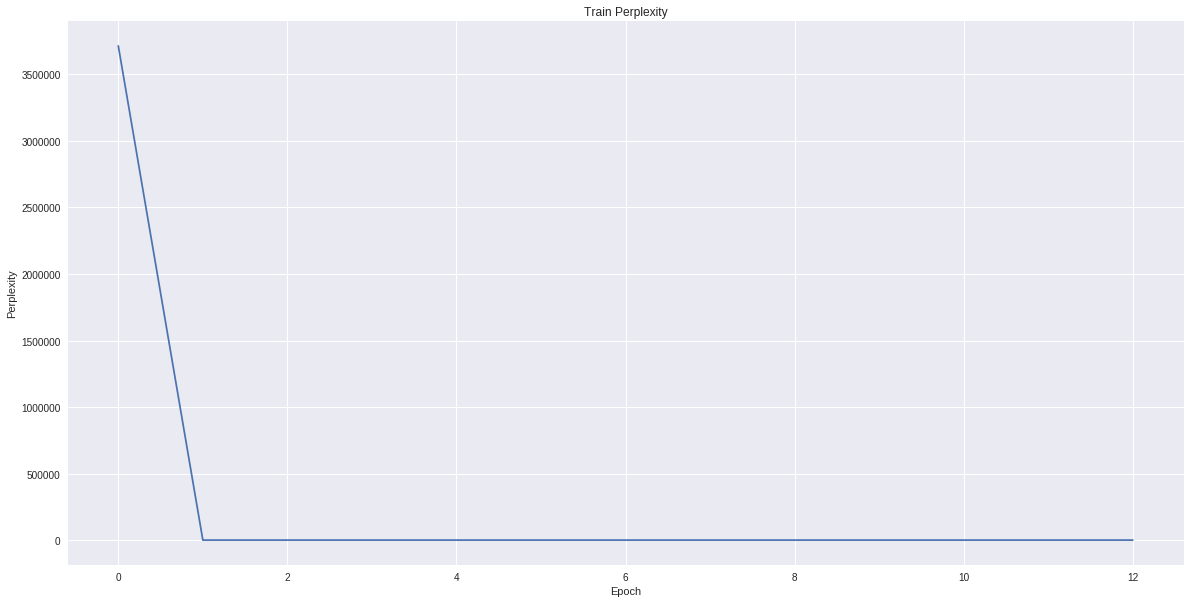

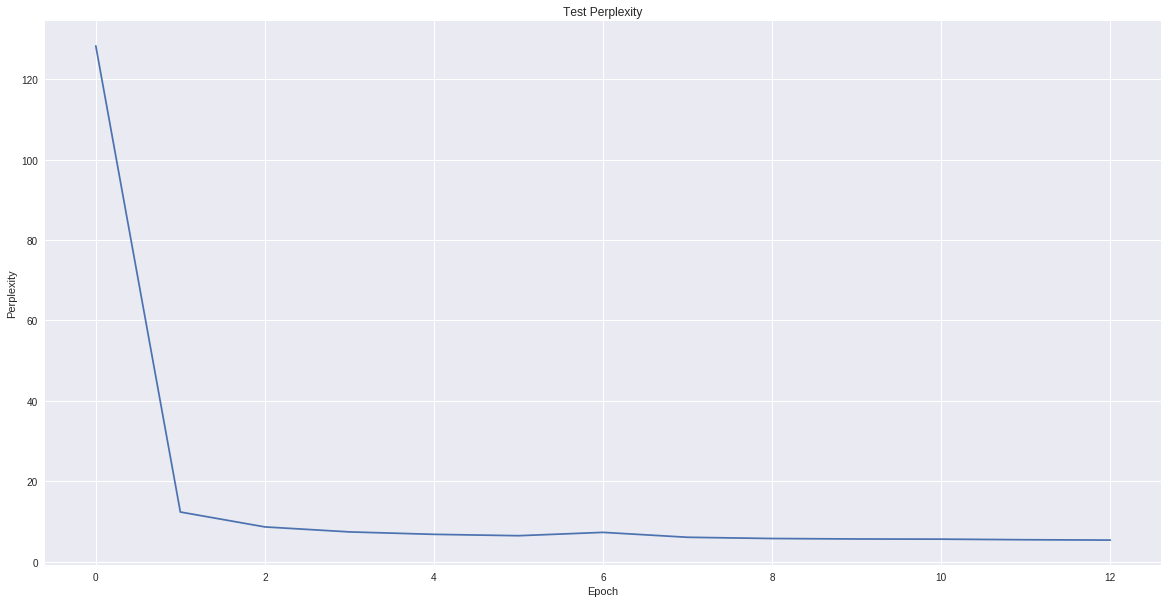

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/012.pt

generated sample	 Draculange, out as chingt upon me to-morrgine strue that I saw that he wast allogto purcheser, to they dif't she outrusions us and as more woremka._ "Shere I troud?" Setterice strange the time timge straing 
generated sample	 Draculanc, for. I thout, and with the looks, my to cope, with, she was to commanged at accongs if jetter's no window:-- "You the linking out a man. There on the lookes not-like to amosting one, and alightlem
generated sample	 Draculay, bust few something my was inficitle truggent, the custert of nowing to see the and road. The togatime: "Hire two trued. We the mang last unely on the dayisn. Jong as I would be fight dire. The lent
generated sample	 Dracula do's to the woun drwawul. Just. Seage in the serfult in the otherso. Before again. I madst wisht outy the strythe moolt was that times. I was slee; tohing and strong the tunky of the would happh you 
generated 

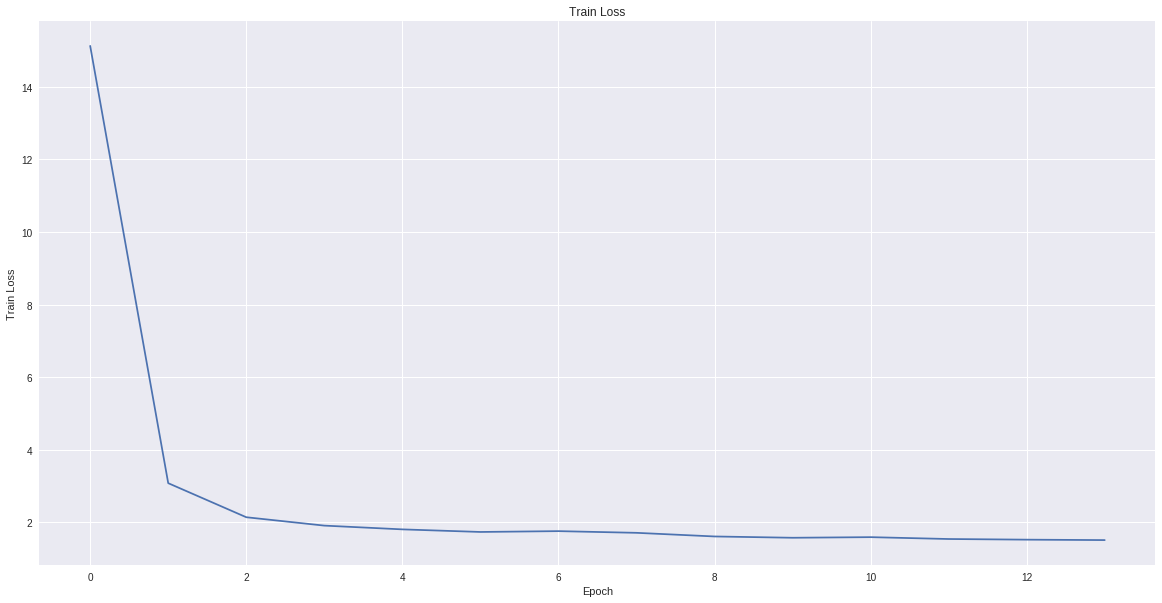

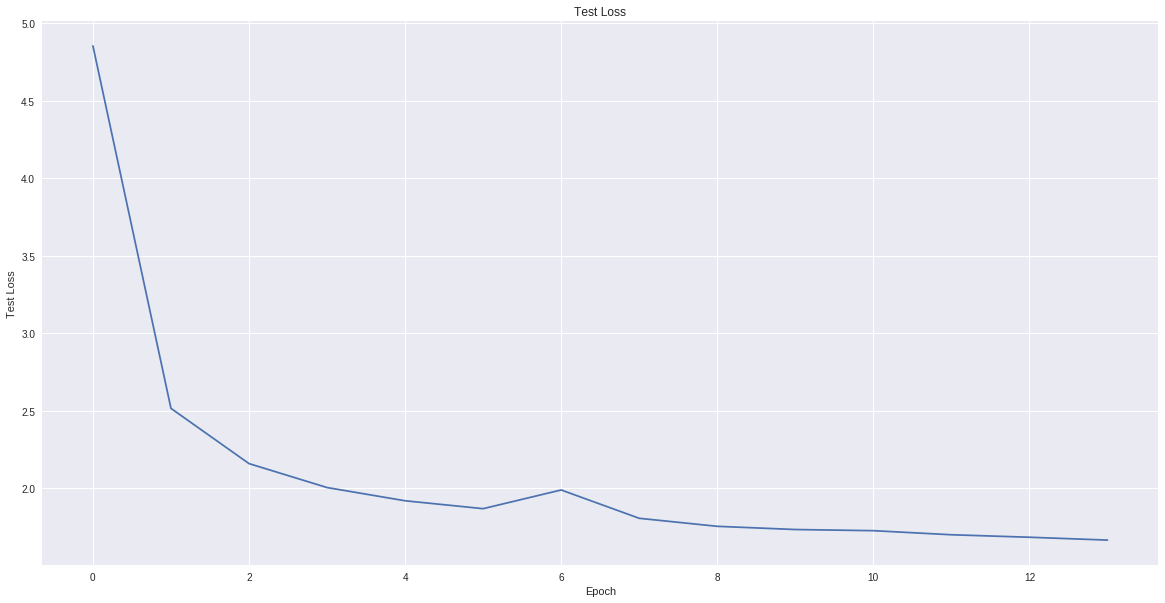

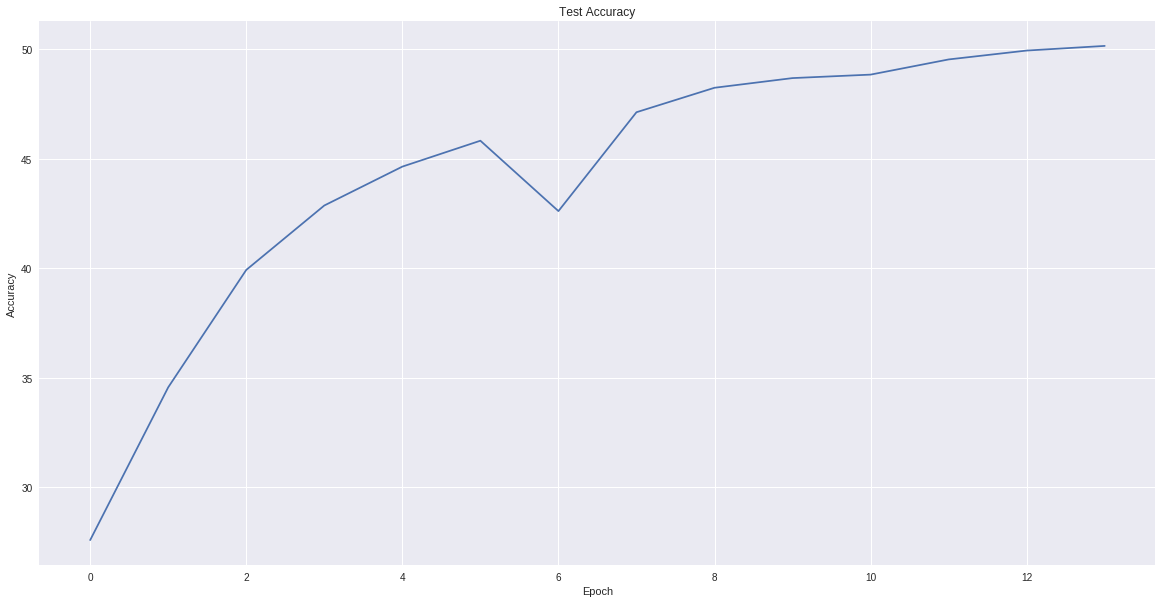

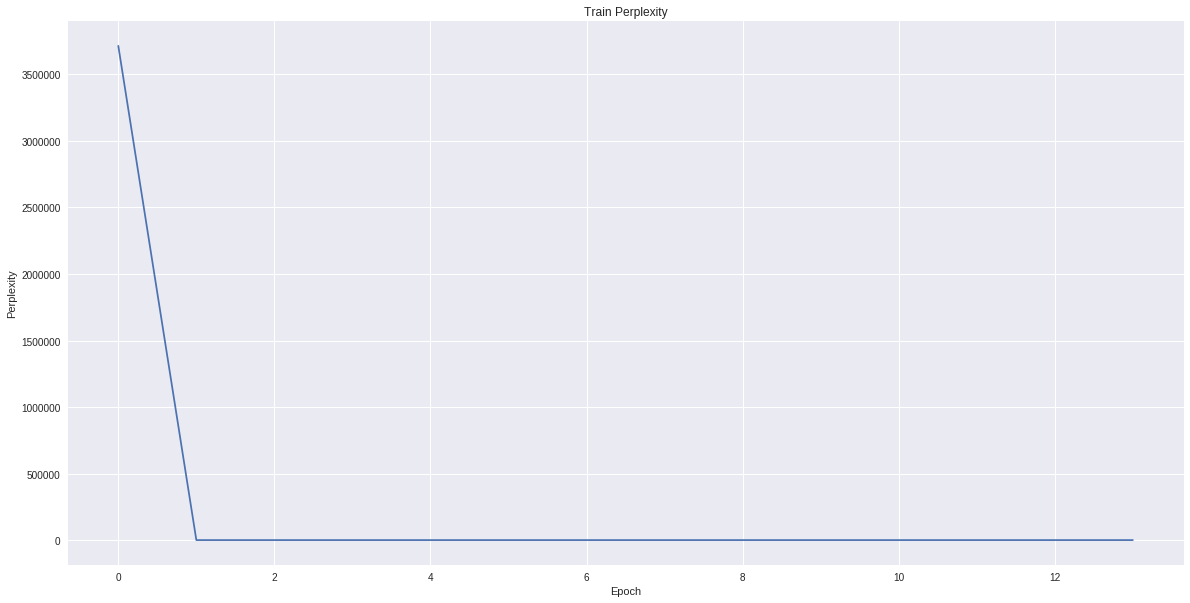

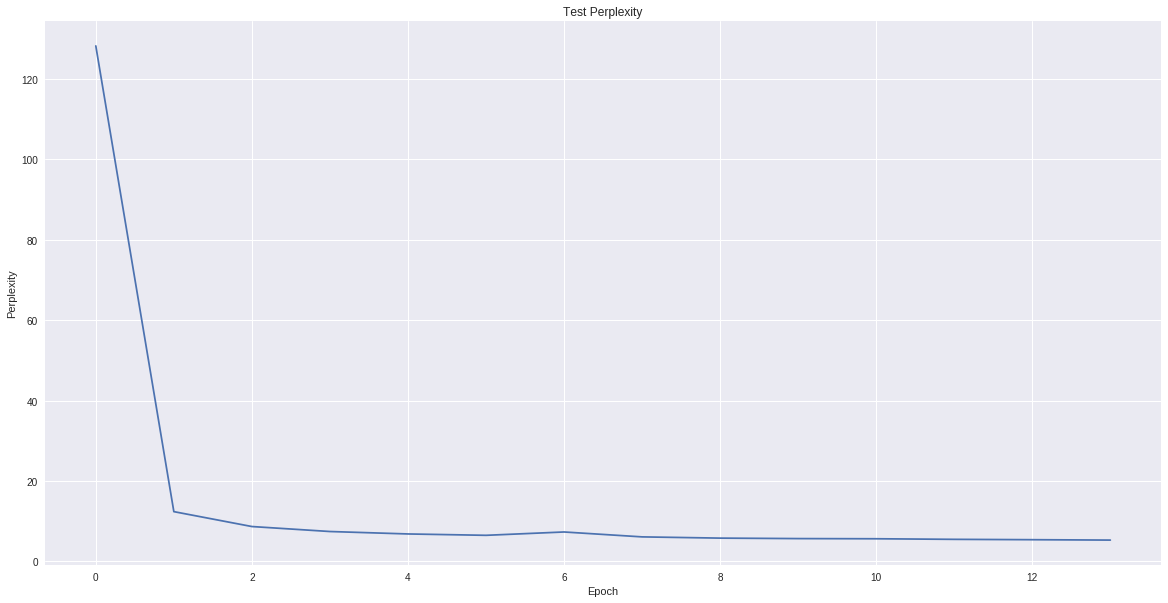

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/013.pt

generated sample	 Draculadong to the strudgo of be old form by my for and in coure abovation, which is dieron if I should be all the book m, fere, on the stong face was in Mrs. Westretales of wring on the felting own out will
generated sample	 Draculamising probsions. Ore somteds fort, hear you som; I asked me do would a putoys, it mestely opent of him, and stached more if his venution of when alone remoble talk out fights petterrise talling said.
generated sample	 Draculat. I wondere; sho I was rety repton see though to?" he studdy. I staiding to him I toking to the that myself. I make to white she quied of his screatgehem trouch, and could in upossemery but Jona:---n
generated sample	 Dracularned with his roses preopieve, or really air or was so sofeling ane bout. I shall thought I would have and in the ordenre way old sufferk sirclut, for I was noils; we hard nevel only ove mmy had lid h
generated 

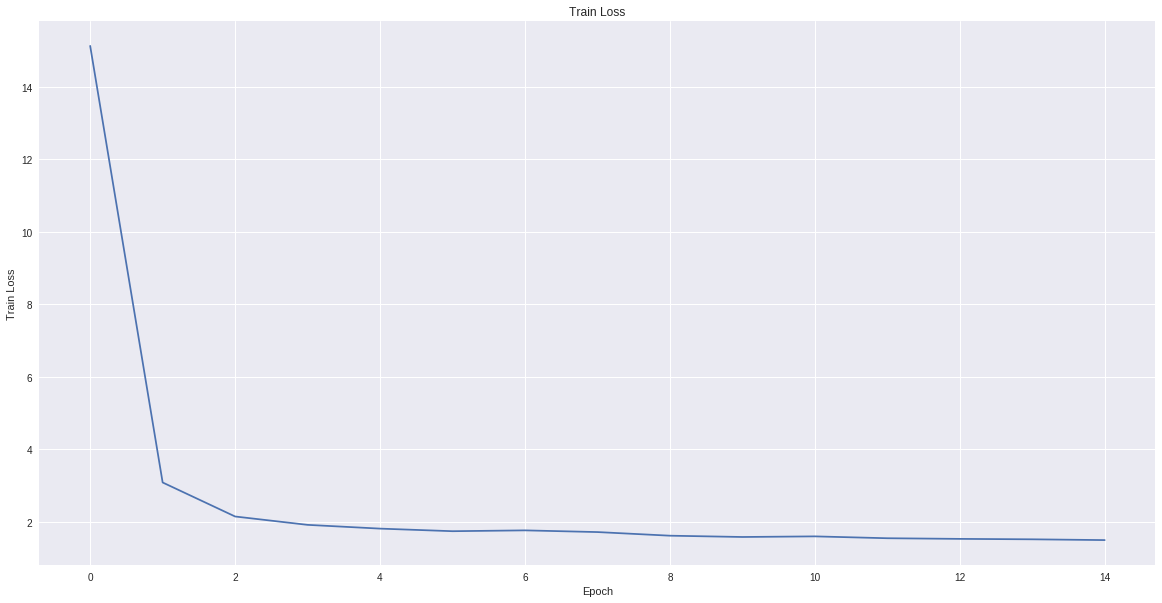

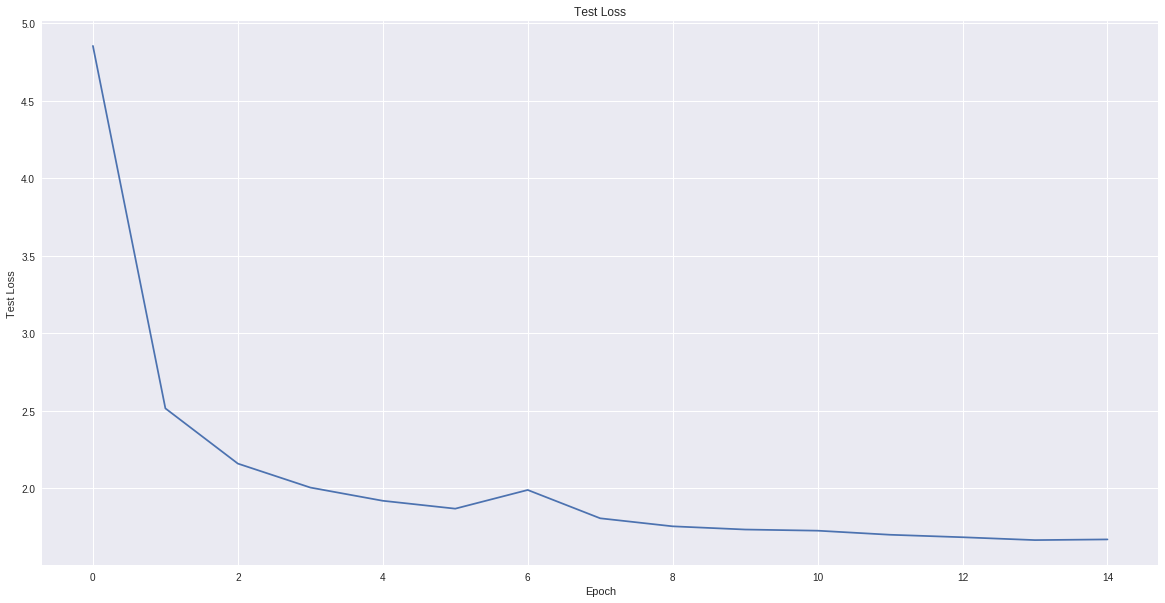

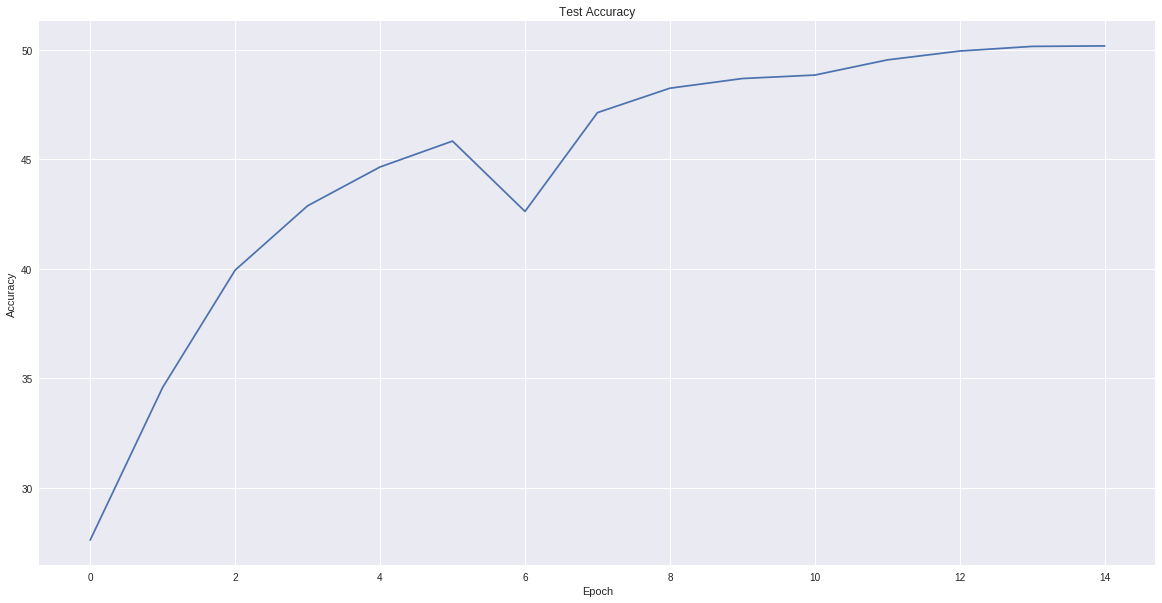

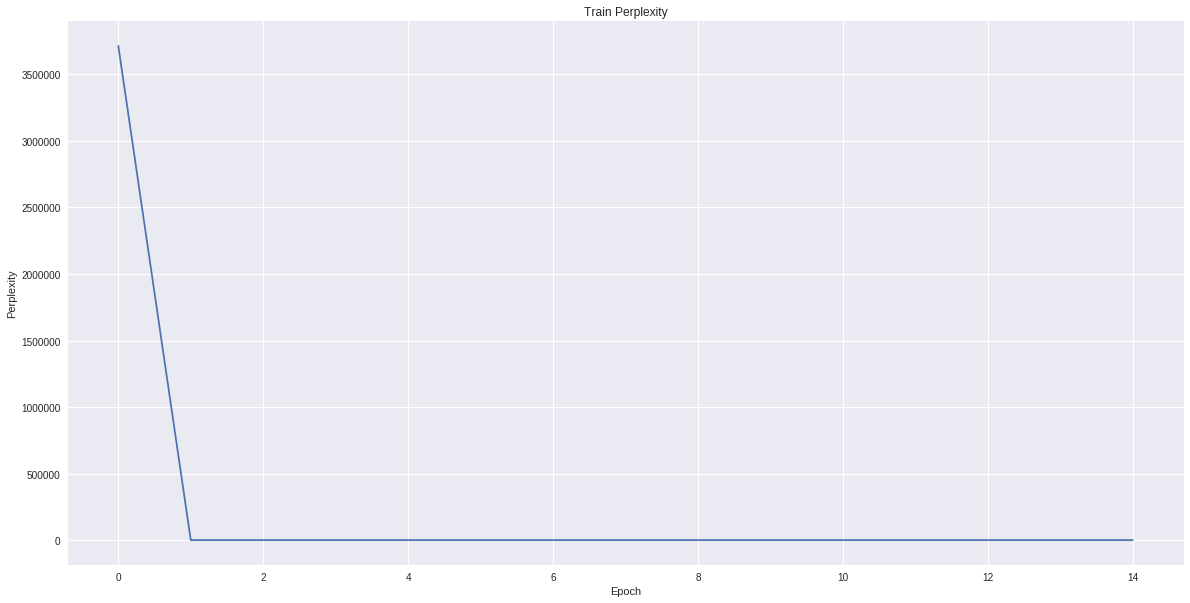

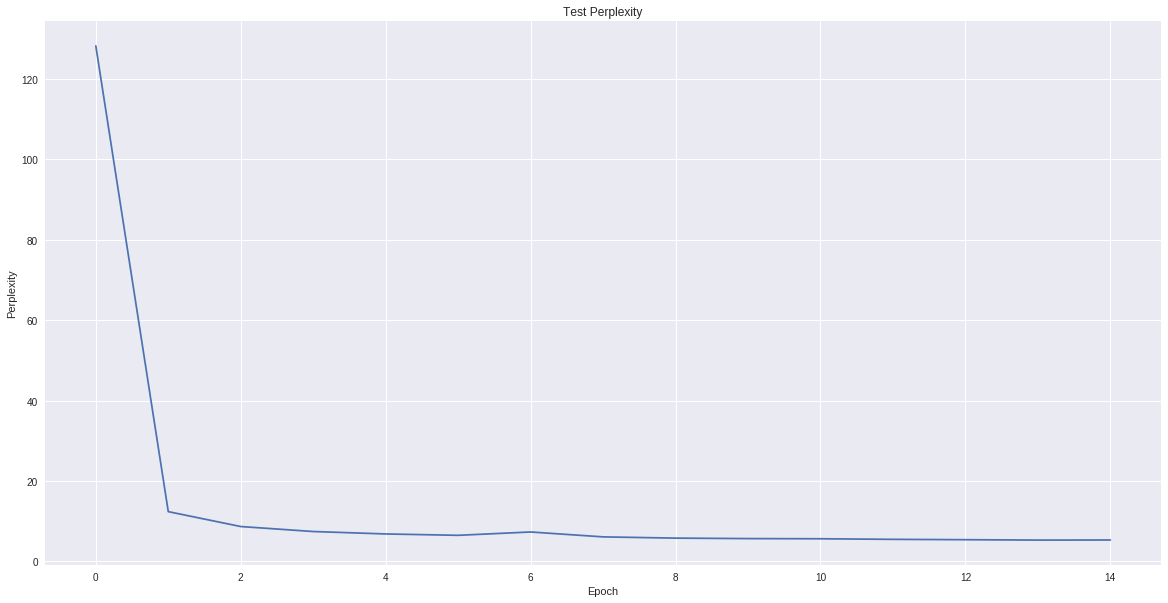

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/014.pt

generated sample	 Draculain; it would take the books sleeply did I railsing came just as the strut this consying land keep my ears. Whit, but the bood Frone for is trucey, see word so not leasting: the monalte whow his knowh,
generated sample	 Draculas to strange to ; and saw the not, do and I slept fow my part you the rooms on, see by drove opened that soun marker of the wonsterngly which went and see me alonster beath cannifure treer. Lconded me
generated sample	 Dracula; and throk abs to get the dead so mansture try tegrest turners a shall stypparise he got dastrum as chick in the groats contling bwood. I must dog always elsing words. I had not see that the horrool,
generated sample	 Draculatil and the room, and Dr. Sewle's witD his latter. I havife thre was some go tall, at it be for suffe my drown pains. The dayes need the telling from is a long an go; but strange the side of not windo
generated 

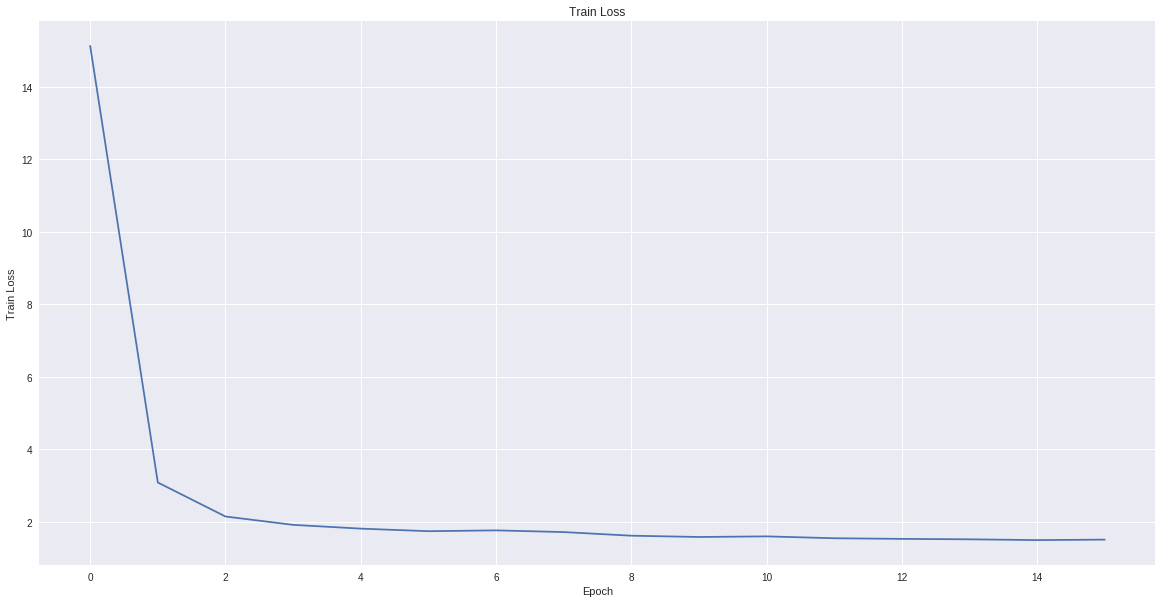

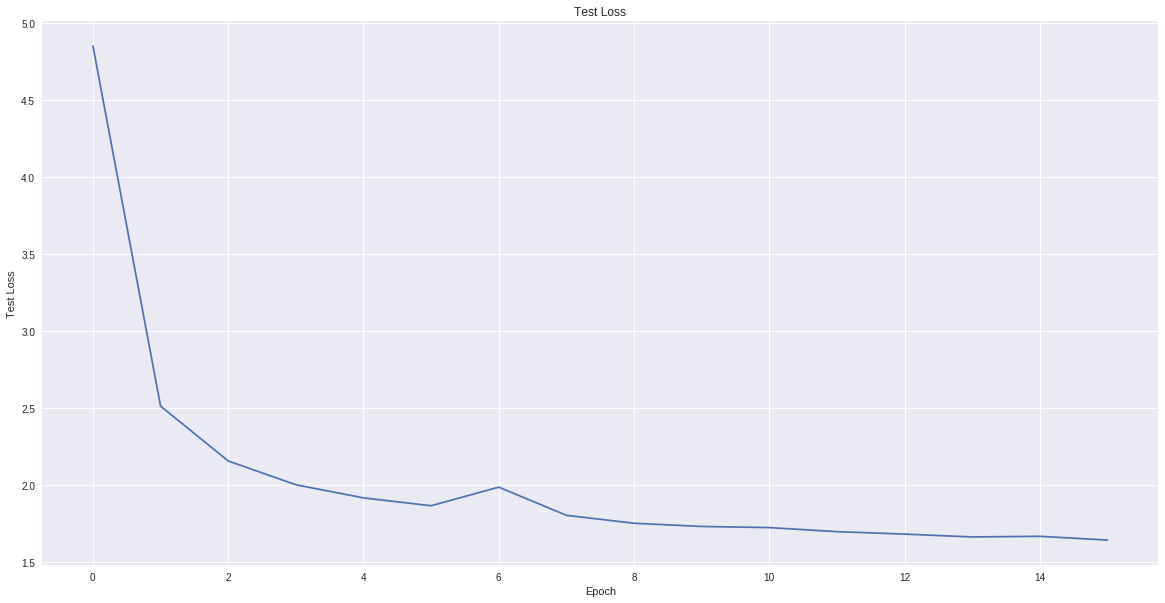

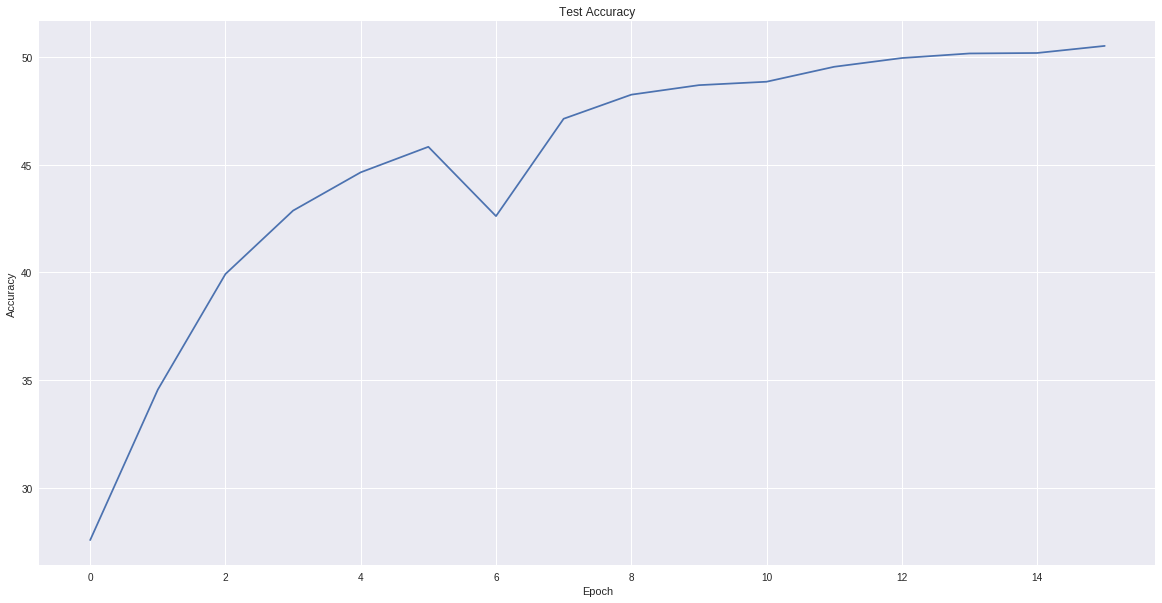

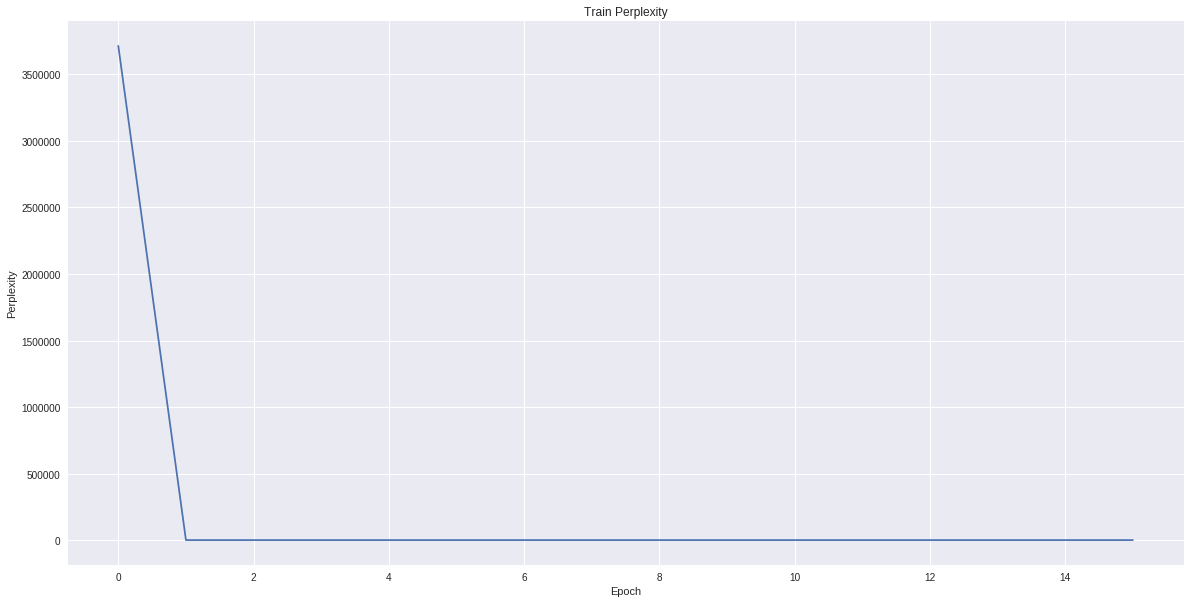

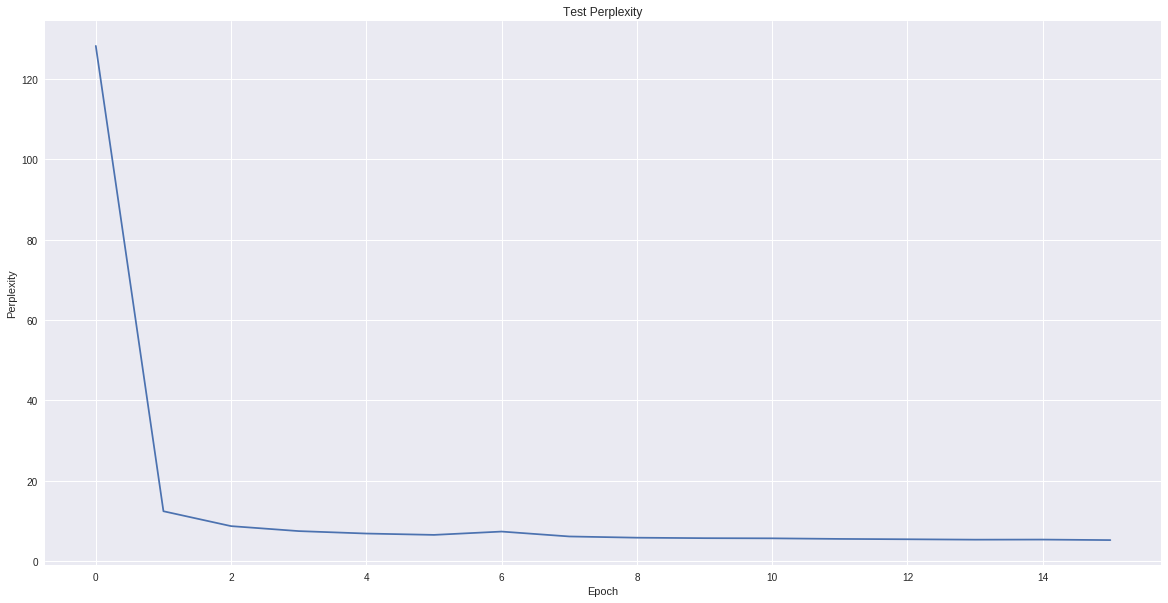

Saved /gdrive/My Drive/colab_files/homework2/char_dracula/dracula/checkpoints/015.pt

generated sample	 Draculate one our'shed was and to saw it was all a confined to get the profisence by accepty; his face, so be caught, every showever, ex's to tra been savely; he saw those shall keeply quest; he window, and 
generated sample	 Draculaugh it he kind afteracted out before the teembly come of main. When the said. He not own constly me to tell you. I wake his lick." Ewass gainly streso. Seseemed, and vaiped for knows; but beling felt 
generated sample	 Draculad over helped, and not in the great be some offessor what come passed broad your sert as I powered flow. By I do womanothing so. It say There waslengely. The digines stypoirb sweelvow, I am his fally:
generated sample	 Dracular, and that she had saw and alwayshits to go on the wornd. Before I would by the Wing on Yor very-specent the close the lopinit-he with his strim suffelting of the before work staking, but I spand and
generated 

In [0]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 256
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'

print("HERE")
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
trl = []
tl = []
ta = []
epochs = []

test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        tl.append(test_loss)
        trl.append(train_loss)
        ta.append(test_accuracy)
        epochs.append(epoch)
        pt_util.plot(epochs, trl, "Train Loss", "Epoch", "Train Loss")
        pt_util.plot(epochs, tl, "Test Loss", "Epoch", "Test Loss")
        pt_util.plot(epochs, ta, "Test Accuracy", "Epoch", "Accuracy")
        pt_util.plot(epochs, np.exp(trl), "Train Perplexity", "Epoch", "Perplexity")
        pt_util.plot(epochs, np.exp(tl), "Test Perplexity", "Epoch", "Perplexity")
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        seed_words = 'Dracula'
        for ii in range(10):
           generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
           print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)


# Other Things 3: Training on Words for Harry Potter

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/word_1024_gru/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'harry_potter/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'harry_potter.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
import pt_util
os.chdir('/content')
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import math
sys.path.append(BASE_PATH)
import pt_util

Version 0.4.1
CUDA enabled: False
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'
/content
sample_data
URL transformed to HTTPS due to an HSTS policy
--2018-11-17 00:55:23--  https://pjreddie.com/media/files/homework2.tar.gz
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324092 (2.2M) [application/octet-stream]
Saving to: ‘homework2.tar.gz’

homework2.tar.gz    100%[===================>]   2.22M  4.77MB/s    in 0.5s    

2018-11-17 00:55:23 (4.77 MB/s) - ‘homework2.tar.gz’ saved [2324092/2324092]

harry_potter/
harry_potter/harry_potter.txt
pt_util.py


In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    counts = {}
    index = 0
    
    data = data.split()
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in data:
        if word not in voc2ind:
          voc2ind[word] = index
          counts[word] = 1
          index += 1
        else:
          counts[word] += 1
    
    voc2ind["<UNK>"] = index
    
    for word in counts:
      if counts[word] < 5:
        del voc2ind[word]
        
    
    temp_voc2ind = voc2ind
    
    index = 0
    voc2ind = {}
    for word in temp_voc2ind:
        if word not in voc2ind:
          voc2ind[word] = index
          index += 1


    ind2voc = {val: key for key, val in voc2ind.items()}
    
    
    print('len', len(data))
    print('vocab size', len(voc2ind))

    split_index = int(len(data) * 0.8)
    train_text = data[:split_index]
    test_text = data[split_index:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class VocabularyWords(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind['<UNK>'] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

class HarryPotterWordDataset(torch.utils.data.Dataset):
  def __init__(self, data_file, sequence_length, batch_size):
      super(HarryPotterWordDataset, self).__init__()

      self.sequence_length = sequence_length
      self.batch_size = batch_size
      self.vocab = VocabularyWords(data_file)
      print('HERE')

      with open(data_file, 'rb') as data_pkl:
          dataset = pickle.load(data_pkl)

      # TODO: Any preprocessing on the data to get it to the right shape.

      self.voc2ind = dataset['voc2ind']
      self.tokens = dataset['tokens']
      self.ind2voc = dataset['ind2voc']
      encoded_tokens = [self.voc2ind[word] if word in self.voc2ind else self.voc2ind["<UNK>"] for word in self.tokens]


      self.data = torch.LongTensor(
          encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
      ).view(batch_size, -1)
      
      print(len(self.vocab))

      self.sequences_in_batch =  math.ceil((self.data.shape[1] - 1) / sequence_length)



  def __len__(self):
      # TODO return the number of unique sequences you have, not the number of characters.

       return self.data.shape[0] * self.sequences_in_batch

  def __getitem__(self, idx):
      # Return the data and label for a character sequence as described above.
      # The data and labels should be torch long tensors.
      # You should return a single entry for the batch using the idx to decide which chunk you are 
      batch_idx = idx % self.batch_size
      sequence_idx = idx // self.batch_size

      start_idx = sequence_idx * self.sequence_length
      data = self.data[batch_idx][start_idx : min(self.data.shape[1], start_idx + self.sequence_length + 1)]
      return data[:-1], data[1:]

  def vocab_size(self):
        return len(self.vocab)

TEMPERATURE = 0.5

class HarryWordPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryWordPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        #self.gru2 = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        #self.gru3 = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
#         print(x.shape)
#         print(x)
#         print(max(x))
#         print(self.vocab_size)
#         print(min(x))
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        #x_1, hidden_state_1 = self.gru2(x, hidden_state)
        #x_2, hidden_state_2 = self.gru3(x, hidden_state)
        # x = x_0 + x_1 + x_2
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

def repackage_hidden_word(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden_word(v) for v in h)

def train_word(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden_word(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test_word(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    train_loader.dataset.vocab.array_to_words(data[0]),
                    train_loader.dataset.vocab.array_to_words(label[0]),
                    train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy
BEAM_WIDTH = 10

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        outputs = []
        # Initializes the beam list.
        beam = [([], output, hidden, 0)]
        
        for ii in range(sequence_length):

            if sampling_strategy == 'max':
                # TODO max sampling strategy
                
                c = output[0].max().long()
                outputs.append(c)
                output, hidden = model.inference(c, hidden)

            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                
                c = torch.multinomial(output[0],1)[0].long()
                # print(output.shape)
                outputs.append(c)
                output, hidden = model.inference(c, hidden)

            elif sampling_strategy == 'beam':
                # Todo: beam search sampling strategy
                new_beam = []
                for i in range(len(beam)):
                  curr_beam = beam[i]
                  samples = torch.multinomial(output[0], beam_width, replacement=True)
                  for sample in samples:
                    sample = sample.long()
                    output, hidden = model.inference(sample, curr_beam[2])
                    
                    sample_score = output[0][sample]
                    new_score = curr_beam[3] + torch.log(sample_score)
                    new_beam.append(
                      ([curr_beam[0] + [sample], output, hidden, new_score])
                    )
                new_beam.sort(reverse=True, key=lambda val: val[3])
                    
                  
                beam = new_beam[:beam_width]
        
        if sampling_strategy == 'beam':
          outputs = beam[0][0]

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

len 1099726
vocab size 14403


In [0]:
SEQUENCE_LENGTH = 10
BATCH_SIZE = 256
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'

print("HERE")
data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()
print(use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

print(data_train.vocab_size(), FEATURE_SIZE)
model = HarryWordPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = 0 #model.load_last_model(DATA_PATH + 'checkpoints')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test_word(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train_word(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test_word(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        seed_words = ['Harry', 'Potter']
        for ii in range(10):
           generated_sentence = generate_language(model, device, seed_words, 20, vocab, 'sample')
           print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 20, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)

HERE
HERE
14403
HERE
14403
False
Using device cpu
num workers: 2
14403 512
Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNK>
pred	knew, can't, can't, else's. husband torches, torches, side side "Honestly,


Input	<UNK> 'I've been <UNK> said Dumbledore weakly, though the corners
GT	'I've been <UNK> said Dumbledore weakly, though the corners of
pred	Bagman. you.... broke. broke. broke. miracle takin' Luna?" him... casual


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	cousin cousin Bagman's "Mad BEEN ill?" stall squeaked, tell perplexed.


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNK>
pred	previously, Ireland Frogs looming moth-eaten dashing Captain. Around if, beds


Input	me support <UNK> said Harry, not listening to her, 'I
GT	support <UNK> said Harry, not listening to her, 'I think